In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import math
import matplotlib.pyplot as plt
import warnings
import scorecardpy as sc
import random
import time
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from lightgbm.callback import reset_parameter,early_stopping
import seaborn as sns

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
#导入原始数据,测试需修改路径
train = pd.read_csv('../../../train.csv')
test = pd.read_csv('../../../test.csv')
submit = pd.read_csv('../../../submit.csv')
train.shape, test.shape, submit.shape

((40000, 21), (15000, 20), (15000, 2))

In [3]:
df = pd.concat([train, test], axis = 0).reset_index(drop = True)

# 训练集存在，测试集合不存在的数据
df = df[df['HYZK'] ==90 ]
df = df[(df['ZHIYE']==90) | (df['ZHIYE']==13) | (df['ZHIYE']==24) | (df['ZHIYE']==17) ]
df = df[(df['ZHICHEN']==999 )|( df['ZHICHEN']==8)  ]
df = df[df['XUELI']==99 ]
df = df[df['DWJJLX']!=390 ]
#ZHIWU，XUWLI,HYZK数据无意义，剔除该类数据
del df['ZHIWU']
del df['XUELI']
del df['HYZK']
# DWYJCE 与 GRYJCE 一致，剔除
del df['DWYJCE']

In [4]:
#对数值类的进行转化（从公积金缴纳基数可见，应该全量-237）：
df['GRYJCE'] = df['GRYJCE'] - 237
df['GRJCJS'] = df['GRJCJS'] -237 
df['GRZHYE'] = df['GRZHYE'] - 237
df['GRZHSNJZYE'] = df ['GRZHSNJZYE'] -237
df['GRZHDNGJYE'] = df ['GRZHDNGJYE'] -237
df['DKFFE'] = df['DKFFE'] - 237
df['DKYE'] = df['DKYE']-237

# 离群值处理
df['GRZHYE'] = df['GRZHYE'].apply(lambda x: 200000 if x>200000 else x)
df['GRZHSNJZYE'] = df['GRZHSNJZYE'].apply(lambda x: 200000 if x>200000 else x)
df['GRZHDNGJYE'] = df['GRZHDNGJYE'].apply(lambda x: 30000 if x>30000 else -30000 if x<-30000 else x)

In [5]:
cate_cols = [ 'DWJJLX', 'DWSSHY', 'GRZHZT','XINGBIE']
cate_cols0 = [ 'DWJJLX', 'DWSSHY']

In [6]:
num_cols = ['GRJCJS', 'GRZHYE', 'GRZHSNJZYE', 'GRZHDNGJYE', 'GRYJCE','DKFFE', 'DKYE']

In [7]:
#尝试对连续值进行WOE分组，按照默认进行处理
bins_0 = sc.woebin(df[num_cols+['label']], y="label")
df = pd.merge(df,sc.woebin_ply(df, bins_0)[[i+'_woe' for i in num_cols]+['id']],how='left',on='id')

[INFO] creating woe binning ...
[INFO] converting into woe values ...


In [8]:
# 新增数值类型切割后生成的离散值
cate_cols += [i+'_woe' for i in num_cols]

特征工程

In [9]:
#反应收入
df['YEARPURINCM'] = df['GRZHYE']-df['GRZHSNJZYE']-df['GRZHDNGJYE']
#应还贷款月份，剩余需还贷款月份,已还贷款月份
df['HDZYF'] = df['DKFFE']*(df['DKLL']/100+1)/(df['GRYJCE']*2)
df['HDSYYF'] = df['DKYE']*(df['DKLL']/100+1)/(df['GRYJCE']*2)
df['HDYF'] = (df['DKFFE']-df['DKYE'])/(df['GRYJCE']*2)

#应还总额
df['HDZYFZE'] = df['DKFFE']*(df['DKLL']/100+1)
#待还总额
df['HDSYYFZE'] = df['DKYE']*(df['DKLL']/100+1)

#应还贷款额占贷款总额的占比
df ['USAGE_RATE']=(df['DKYE']/df['DKFFE'])
df ['USAGE_AMOUNT'] = (df['DKFFE']-df['DKYE'])*(1+df['DKLL']/100)
# 公积金比例，对部分离群值进行约束
df ['GJJRATE'] = (df['GRYJCE']/df['GRJCJS']+0.005)//0.01*0.01


# 每月提取额与缴存额的比例
df ['GED_GRY'] = df['GRZHDNGJYE']/df['GRYJCE']
# 提取还是存储？
df ['WITHSIGN'] =  df ['GED_GRY'].apply(lambda x: 0 if x%2 ==0 else 1 ) 
df ['WITHSIGN_NOTE'] =  df ['GED_GRY'].apply(lambda x: x//2 if x%2 ==0 else -1 ) 
df ['WITHSIGN2'] =  df ['GED_GRY'].apply(lambda x: 1 if x%2 ==0 and x<16 and x>0 else -1 ) 
# 平均每月提取额
df ['WITHDRAW'] =  (df ['GRYJCE']*4*2 - df['GRZHDNGJYE'])*df['WITHSIGN']
df ['WITHSIGN'] = df['WITHSIGN']* (df ['WITHDRAW'].apply(lambda x: 1 if x>0 else 0 if x==0 else -1))
df ['WITHDRAW_SUBMIT'] = df ['WITHDRAW']/df['GRYJCE']

df ['GJSIGN']   =  df ['GRZHDNGJYE'].apply(lambda x: 1 if x>0 else 0 if x==0 else -1  )
df['age'] = ((1609430399 - df['CSNY']) / (365 * 24 * 3600)).astype(int)
# 贷款限额
df ['DKXE'] = df['GRJCJS']*0.45*(70-df['age'])*12

# 上年结转与余额的关系？
# 上年结转+公积金缴纳+(个人补缴-提取)=当年余额
# 个人净提取额
df ['WITHDRAW2'] =  df['GRZHSNJZYE'] + df ['GRYJCE']*4*2 - df['GRZHYE']

# 用完，或者没有用
df['USAGEOVER'] = df['DKYE'] == 0 
df['NOUSAGE'] = df['DKYE'] == df['DKFFE']

# 对贷款发放额“大额且整数”的进行约束
df ['TOP_USER'] = df['DKFFE'].apply(lambda x: x if (x%50000==0 or x==125000) else 0)
df ['TOP_USER1'] = df['DKFFE'].apply(lambda x: 1 if (x%50000==0 or x==125000) else x)


# 对部分样本数量很少，并且样本分布基本一致的指标进行处理
df.loc[(df['GRZHZT']!=1)&(df['GRZHZT']!=6),'GRZHZT']=-1
df.loc[(df['DWJJLX'].isin(['310','330','390','210','230','171','172','173','174','175','142','143','149','140'])),'DWJJLX']=-1
df.loc[(df['DWJJLX'].isin(['100','179','900'])),'DWJJLX']=-2
df.loc[(df['DWJJLX'].isin(['120','160'])),'DWJJLX']=-3
df.loc[(df['DWJJLX'].isin(['200','150','141'])),'DWJJLX']=-4
df.loc[(df['DWJJLX'].isin(['159','300','130'])),'DWJJLX']=-5

gen_feats = [ 'YEARPURINCM','HDZYF',
            'HDSYYF','HDYF','HDZYFZE','HDSYYFZE','USAGE_RATE','GJJRATE',
             'TOP_USER','TOP_USER1','WITHDRAW','USAGE_AMOUNT','WITHDRAW_SUBMIT','DKXE'
            ]
 
cate_cols += ['WITHSIGN_NOTE','USAGEOVER','NOUSAGE','TOP_USER','WITHSIGN','GJJRATE','GJSIGN','WITHSIGN2','ZHIYE','ZHICHEN'] #'DKZS','YEZS','ZHZS','GJZS','SNZS','YJZS',

In [10]:
# 对年龄进行分组
def get_age(df,col = 'age'):
    df[col+"_genFeat1"]=(df['age'] > 18).astype(int)
    df[col+"_genFeat2"]=(df['age'] > 25).astype(int)
    df[col+"_genFeat3"]=(df['age'] > 30).astype(int)
    df[col+"_genFeat4"]=(df['age'] > 35).astype(int)
    df[col+"_genFeat5"]=(df['age'] > 40).astype(int)
    df[col+"_genFeat6"]=(df['age'] > 45).astype(int)
    return df, [col + f'_genFeat{i}' for i in range(1, 7)]

# 出生的月份，可能映射到星座balabala
tNow = time.mktime(time.strptime( '2021-01-12 00:00:00','%Y-%m-%d %H:%M:%S'))
df['bornmonth'] = df['CSNY'].astype(int).apply(lambda x: time.localtime(x)[1])

df, genFeats1 = get_age(df, col = 'age')

In [11]:
#对贷款余额和贷款发放额进行分组
def get_daikuanYE(df,col):
    df[col + '_genFeat1'] = (df[col] > 100000).astype(int)
    df[col + '_genFeat2'] = (df[col] > 120000).astype(int)
    df[col + '_genFeat3'] = (df[col] > 140000).astype(int)
    df[col + '_genFeat4'] = (df[col] > 180000).astype(int)
    df[col + '_genFeat5'] = (df[col] > 220000).astype(int)
    df[col + '_genFeat6'] = (df[col] > 260000).astype(int)
    df[col + '_genFeat7'] = (df[col] > 300000).astype(int)
    return df, [col + f'_genFeat{i}' for i in range(1, 8)]

df, genFeats2 = get_daikuanYE(df, col = 'DKYE')
df, genFeats3 = get_daikuanYE(df, col = 'DKFFE')
#genFeats2 = []
#genFeats3 = []

In [12]:
#指标被剔除,防止指标爆炸与内存溢出
# 1、与其他指标强相关
# 2、与指标只有一个或者全部为null
# 3、按照light GBM模型的指标重要性排名曲线进行截断
drop_feature = ['missing_rate',
  'DWJJLX_TOP_USER1_min',
  'DWSSHY_DKYE_min',
  'DWSSHY_HDSYYF_min',
  'DWSSHY_HDSYYFZE_min',
  'DWSSHY_USAGE_RATE_min',
  'DWSSHY_TOP_USER_max',
  'DWSSHY_TOP_USER_min',
  'DWSSHY_TOP_USER1_min',
  'GRZHZT_TOP_USER_min',
  'GRZHZT_TOP_USER1_min',
  'USAGEOVER_GRZHYE_min',
  'USAGEOVER_GRYJCE_max',
  'USAGEOVER_DKFFE_max',
  'USAGEOVER_DKLL_min',
  'USAGEOVER_HDZYFZE_max',
  'USAGEOVER_TOP_USER_max',
  'USAGEOVER_TOP_USER_min',
  'USAGEOVER_TOP_USER1_min',
  'NOUSAGE_GRZHSNJZYE_min',
  'NOUSAGE_GRYJCE_max',
  'NOUSAGE_GJJRATE_min',
  'NOUSAGE_TOP_USER_max',
  'NOUSAGE_TOP_USER_min',
  'NOUSAGE_TOP_USER1_min',
  'TOP_USER_GRZHYE_min',
  'TOP_USER_GRYJCE_max',
  'TOP_USER_DKYE_min',
  'TOP_USER_DKLL_min',
  'TOP_USER_HDSYYF_min',
  'TOP_USER_HDSYYFZE_min',
  'TOP_USER_USAGE_RATE_min',
  'TOP_USER_TOP_USER_std',
  'WITHSIGN_GRZHYE_min',
  'WITHSIGN_GRZHSNJZYE_min',
  'WITHSIGN_GRYJCE_max',
  'WITHSIGN_DKFFE_max',
  'WITHSIGN_DKYE_min',
  'WITHSIGN_DKLL_max',
  'WITHSIGN_DKLL_min',
  'WITHSIGN_HDSYYF_min',
  'WITHSIGN_HDYF_min',
  'WITHSIGN_HDZYFZE_max',
  'WITHSIGN_HDSYYFZE_min',
  'WITHSIGN_USAGE_RATE_max',
  'WITHSIGN_USAGE_RATE_min',
  'WITHSIGN_TOP_USER_max',
  'WITHSIGN_TOP_USER_min',
  'WITHSIGN_TOP_USER1_min',
  'WITHSIGN_USAGE_AMOUNT_max',
  'WITHSIGN_USAGE_AMOUNT_min',
  'DKFFE_TOP_USER_std',
  'DKFFE_TOP_USER1_std',
  'DKLL_TOP_USER_min',
  'DKLL_TOP_USER1_min',
  'HDZYFZE_DKFFE_std',
  'HDZYFZE_TOP_USER_std',
  'HDZYFZE_TOP_USER1_std',
  'HDSYYFZE_DKYE_std']+['numsOf_USAGE_RATE_WITHDRAW_add', 'DKFFE_HDZYF_max', 'GRZHDNGJYE_DKFFE_max', 'numsOf_HDZYFZE_USAGE_RATE_diff', 'numsOf_GJJRATE_TOP_USER1_add', 'TOP_USER1_GRZHDNGJYE_std', 'GRZHYE_GRZHDNGJYE_min', 'numsOf_YEARPURINCM_HDZYF_add', 'numsOf_DKYE_TOP_USER1_div', 'HDZYF_HDZYFZE_sum', 'HDSYYF_WITHDRAW_mean', 'GJJRATE_GRZHSNJZYE_sum', 'GRZHDNGJYE_HDZYFZE_sum', 'DWJJLX_GRZHYE_mean', 'numsOf_GRJCJS_HDZYFZE_add', 'numsOf_DKLL_GJJRATE_div', 'GRZHSNJZYE_DKYE_mean', 'HDSYYFZE_DKFFE_sum', 'numsOf_GRZHDNGJYE_HDZYFZE_multi', 'numsOf_HDSYYFZE_TOP_USER1_diff', 'USAGE_RATE_TOP_USER_sum', 'GRZHYE_YEARPURINCM_std', 'GRZHZT_in_TOP_USER_prop', 'GJJRATE_YEARPURINCM_std', 'numsOf_USAGE_RATE_USAGE_AMOUNT_div', 'DKFFE_HDYF_sum', 'GJJRATE_WITHDRAW_max', 'TOP_USER1_GRZHDNGJYE_max', 'HDZYFZE_DKFFE_sum', 'HDYF_DKLL_min', 'HDZYFZE_GRYJCE_max', 'numsOf_GRYJCE_TOP_USER1_multi', 'numsOf_GRZHSNJZYE_HDYF_diff', 'GRZHSNJZYE_DKFFE_sum', 'HDZYF_TOP_USER_max', 'DWJJLX_GJJRATE_std', 'GJJRATE_HDSYYF_min', 'DWJJLX_GRJCJS_mean', 'GRZHYE_GJJRATE_std', 'DWJJLX_TOP_USER1_max', 'DWJJLX_DKFFE_genFeat3_mean', 'HDSYYF_YEARPURINCM_mean', 'TOP_USER1_GRZHYE_std', 'numsOf_GRZHYE_HDSYYFZE_add', 'DWSSHY_DKYE_genFeat7_sum', 'YEARPURINCM_GJJRATE_sum', 'numsOf_GRJCJS_DKFFE_add', 'HDYF_GRZHDNGJYE_sum', 'numsOf_GRJCJS_HDZYF_diff', 'DKFFE_HDYF_min', 'GRYJCE_GRJCJS_min', 'DWJJLX_WITHDRAW_mean', 'GRZHSNJZYE_HDZYF_mean', 'HDSYYFZE_USAGE_AMOUNT_min', 'HDZYFZE_GRJCJS_sum', 'numsOf_GJJRATE_WITHDRAW_add', 'GJJRATE_GRYJCE_std', 'DKFFE_USAGE_AMOUNT_max', 'HDZYF_HDSYYFZE_sum', 'HDSYYFZE_GRYJCE_sum', 'DKYE_HDZYFZE_sum', 'USAGE_AMOUNT_DKFFE_std', 'numsOf_DKFFE_HDSYYF_add', 'DWSSHY_DKYE_genFeat6_sum', 'USAGE_RATE_TOP_USER1_max', 'numsOf_GRZHDNGJYE_GJJRATE_multi', 'GRYJCE_DKLL_max', 'DKFFE_USAGE_AMOUNT_sum', 'DWJJLX_HDZYF_mean', 'USAGE_AMOUNT_USAGE_RATE_min', 'GJJRATE_GRYJCE_sum', 'USAGE_AMOUNT_HDZYFZE_std', 'DWSSHY_GRYJCE_sum', 'DWSSHY_USAGE_AMOUNT_std', 'numsOf_DKLL_WITHDRAW_diff', 'numsOf_GRYJCE_TOP_USER_diff', 'numsOf_YEARPURINCM_HDSYYFZE_add', 'HDSYYFZE_HDZYFZE_sum', 'DWJJLX_GRZHSNJZYE_std', 'DWJJLX_GRZHDNGJYE_std', 'HDSYYF_YEARPURINCM_min', 'numsOf_GRZHYE_HDSYYFZE_diff', 'GJJRATE_HDSYYF_max', 'DWJJLX_DKFFE_std', 'HDYF_YEARPURINCM_max', 'GRZHYE_WITHDRAW_std', 'GJJRATE_WITHDRAW_mean', 'GJJRATE_GRZHYE_mean', 'DWJJLX_USAGE_RATE_mean', 'numsOf_DKLL_HDYF_multi', 'DWJJLX_DKYE_genFeat2_mean', 'GRZHSNJZYE_HDSYYF_std', 'HDYF_YEARPURINCM_sum', 'GRZHSNJZYE_DKLL_std', 'GRZHYE_DKFFE_mean', 'GRZHDNGJYE_HDSYYFZE_mean', 'numsOf_HDZYFZE_WITHDRAW_multi', 'USAGE_AMOUNT_GJJRATE_sum', 'numsOf_DKYE_DKLL_div', 'USAGE_RATE_DKFFE_max', 'GRZHSNJZYE_DKFFE_min', 'HDSYYFZE_TOP_USER_sum', 'USAGE_AMOUNT_TOP_USER1_std', 'DWSSHY_DKFFE_genFeat7_sum', 'numsOf_GRYJCE_YEARPURINCM_diff', 'DKYE_TOP_USER_sum', 'numsOf_GJJRATE_TOP_USER1_multi', 'GJJRATE_GRZHYE_min', 'numsOf_HDZYF_TOP_USER_add', 'DKFFE_WITHDRAW_max', 'USAGE_RATE_DKFFE_std', 'numsOf_GRZHDNGJYE_HDSYYF_add', 'HDSYYF_GRYJCE_mean', 'USAGE_AMOUNT_USAGE_RATE_std', 'DWJJLX_YEARPURINCM_std', 'GRYJCE_HDSYYFZE_sum', 'DWJJLX_DKYE_genFeat4_mean', 'numsOf_GRZHSNJZYE_DKLL_div', 'GRZHSNJZYE_DKFFE_mean', 'GJJRATE_WITHDRAW_sum', 'GJJRATE_GRYJCE_max', 'numsOf_YEARPURINCM_HDSYYF_add', 'HDSYYF_WITHDRAW_min', 'GJJRATE_TOP_USER_mean', 'numsOf_GRZHYE_HDZYF_diff', 'HDZYFZE_DKYE_sum', 'numsOf_GRYJCE_HDZYFZE_diff', 'DKYE_USAGE_AMOUNT_max', 'numsOf_GRZHYE_HDYF_add', 'numsOf_DKYE_HDSYYF_div', 'GRZHDNGJYE_HDZYFZE_max', 'DWJJLX_HDYF_max', 'numsOf_YEARPURINCM_HDSYYF_diff', 'TOP_USER1_USAGE_AMOUNT_std', 'numsOf_DKLL_USAGE_AMOUNT_multi', 'HDZYFZE_GRZHYE_min', 'DWJJLX_DKYE_genFeat1_mean', 'TOP_USER1_DKYE_mean', 'numsOf_GRJCJS_HDZYFZE_diff', 'GRZHYE_GRZHDNGJYE_mean', 'GRZHDNGJYE_HDSYYFZE_std', 'HDZYFZE_HDSYYF_sum', 'USAGE_RATE_USAGE_AMOUNT_max', 'numsOf_GRZHYE_HDSYYF_diff', 'HDSYYFZE_DKLL_mean', 'numsOf_DKYE_HDZYFZE_add', 'numsOf_DKLL_HDYF_div', 'DWSSHY_GJJRATE_mean', 'numsOf_GRJCJS_USAGE_RATE_add', 'numsOf_TOP_USER_WITHDRAW_add', 'DKFFE_HDSYYF_max', 'DWJJLX_TOP_USER_mean', 'DKLL_GRJCJS_mean', 'numsOf_GRZHDNGJYE_HDSYYF_diff', 'WITHDRAW_TOP_USER_sum', 'numsOf_DKFFE_HDSYYFZE_add', 'WITHDRAW_HDSYYFZE_mean', 'DWJJLX_DKYE_max', 'USAGE_RATE_USAGE_AMOUNT_std', 'HDZYFZE_TOP_USER_sum', 'HDSYYF_GRZHYE_mean', 'HDZYF_HDZYFZE_min', 'numsOf_DKFFE_GJJRATE_div', 'HDSYYF_GRZHDNGJYE_sum', 'DKYE_USAGE_AMOUNT_mean', 'GRZHSNJZYE_WITHDRAW_max', 'DKFFE_USAGE_RATE_max', 'HDSYYF_GRZHDNGJYE_mean', 'numsOf_DKLL_HDSYYF_multi', 'numsOf_DKLL_HDSYYF_div', 'HDZYF_HDZYFZE_std', 'GRJCJS_DKLL_max', 'YEARPURINCM_USAGE_RATE_max', 'GRZHYE_HDZYFZE_min', 'GRZHSNJZYE_HDZYF_max', 'numsOf_YEARPURINCM_HDZYF_diff', 'USAGE_RATE_DKFFE_mean', 'numsOf_GRJCJS_HDSYYFZE_multi', 'USAGE_RATE_TOP_USER_mean', 'USAGE_RATE_GJJRATE_max', 'numsOf_HDYF_USAGE_AMOUNT_div', 'numsOf_HDZYFZE_USAGE_RATE_add', 'numsOf_DKFFE_GJJRATE_add', 'GRZHSNJZYE_GRZHYE_mean', 'WITHDRAW_HDZYFZE_std', 'TOP_USER1_HDYF_min', 'GRZHSNJZYE_HDZYFZE_std', 'GRZHDNGJYE_HDZYFZE_min', 'numsOf_HDSYYFZE_WITHDRAW_add', 'HDSYYF_USAGE_AMOUNT_sum', 'USAGE_AMOUNT_DKFFE_min', 'GRJCJS_HDSYYFZE_sum', 'DKFFE_DKYE_min', 'YEARPURINCM_GRJCJS_sum', 'TOP_USER1_GRZHYE_mean', 'HDZYFZE_HDSYYF_min', 'numsOf_GRZHDNGJYE_HDZYF_diff', 'HDZYFZE_GRZHYE_sum', 'HDYF_GRZHYE_mean', 'numsOf_TOP_USER_WITHDRAW_diff', 'DWSSHY_DKFFE_genFeat2_mean', 'USAGE_RATE_GJJRATE_sum', 'USAGE_RATE_USAGE_AMOUNT_mean', 'GRZHDNGJYE_DKLL_sum', 'DKYE_GJJRATE_max', 'WITHDRAW_DKFFE_max', 'numsOf_DKLL_TOP_USER_diff', 'DWJJLX_HDYF_std', 'DWJJLX_DKYE_genFeat3_mean', 'GJJRATE_HDSYYF_mean', 'numsOf_GRZHYE_HDZYFZE_div', 'USAGE_AMOUNT_TOP_USER1_max', 'GRZHZT_GRJCJS_mean', 'GRZHYE_HDZYFZE_sum', 'numsOf_DKFFE_TOP_USER1_add', 'USAGE_RATE_TOP_USER_std', 'DWSSHY_DKYE_genFeat5_sum', 'numsOf_GRYJCE_YEARPURINCM_add', 'numsOf_DKLL_USAGE_AMOUNT_div', 'WITHDRAW_TOP_USER1_max', 'numsOf_GRYJCE_DKFFE_diff', 'HDSYYFZE_GJJRATE_max', 'GRZHYE_HDSYYFZE_min', 'numsOf_DKFFE_HDZYF_add', 'GRYJCE_DKLL_min', 'numsOf_HDSYYF_HDSYYFZE_multi', 'numsOf_GRZHDNGJYE_HDSYYFZE_diff', 'HDSYYF_DKYE_sum', 'HDZYFZE_USAGE_RATE_min', 'WITHDRAW_HDZYFZE_sum', 'DWJJLX_TOP_USER_std', 'DWSSHY_WITHDRAW_mean', 'USAGE_RATE_HDSYYFZE_max', 'HDZYFZE_GRZHSNJZYE_sum', 'numsOf_DKYE_DKLL_multi', 'numsOf_HDSYYFZE_TOP_USER_div', 'GRZHSNJZYE_HDSYYFZE_sum', 'GRZHYE_HDSYYFZE_max', 'numsOf_DKLL_WITHDRAW_multi', 'GJJRATE_HDZYF_max', 'numsOf_GRZHDNGJYE_HDSYYFZE_add', 'DKFFE_HDZYF_sum', 'HDYF_YEARPURINCM_std', 'DKFFE_YEARPURINCM_max', 'WITHDRAW_HDZYFZE_mean', 'GRZHYE_HDSYYFZE_sum', 'DKFFE_GRZHSNJZYE_sum', 'YEARPURINCM_GJJRATE_mean', 'HDZYFZE_DKYE_min', 'DKFFE_HDSYYF_sum', 'numsOf_HDSYYFZE_WITHDRAW_multi', 'HDYF_GRZHYE_sum', 'HDYF_GRZHDNGJYE_min', 'YEARPURINCM_HDSYYF_sum', 'numsOf_GRZHYE_DKLL_multi', 'HDYF_HDSYYF_sum', 'DWJJLX_GRZHSNJZYE_max', 'TOP_USER1_GRZHSNJZYE_std', 'USAGEOVER_in_TOP_USER_prop', 'numsOf_GRJCJS_HDZYFZE_div', 'DWSSHY_DKFFE_genFeat5_mean', 'HDSYYF_USAGE_RATE_sum', 'numsOf_GRZHYE_HDYF_diff', 'DWSSHY_HDYF_sum', 'WITHDRAW_HDSYYFZE_min', 'HDSYYFZE_GJJRATE_sum', 'GRZHDNGJYE_TOP_USER1_min', 'HDZYF_HDZYFZE_max', 'GRZHYE_DKLL_sum', 'TOP_USER1_GRYJCE_mean', 'GRZHYE_TOP_USER_sum', 'USAGE_AMOUNT_HDZYFZE_min', 'GRJCJS_GRYJCE_max', 'DWSSHY_WITHDRAW_max', 'numsOf_GRZHDNGJYE_HDZYFZE_div', 'numsOf_HDSYYFZE_WITHDRAW_diff', 'GRZHSNJZYE_DKLL_sum', 'GRZHSNJZYE_HDZYF_std', 'GRZHDNGJYE_HDZYFZE_mean', 'GRJCJS_DKLL_min', 'numsOf_GRZHSNJZYE_HDZYFZE_div', 'NOUSAGE_in_GRZHZT_prop', 'DKFFE_GRZHYE_sum', 'GRZHSNJZYE_TOP_USER1_std', 'HDYF_GRZHSNJZYE_mean', 'HDYF_YEARPURINCM_mean', 'GRZHDNGJYE_HDSYYFZE_sum', 'DKFFE_DKYE_sum', 'DWJJLX_USAGE_AMOUNT_mean', 'GRZHDNGJYE_HDSYYFZE_min', 'numsOf_GRZHSNJZYE_DKLL_multi', 'GRZHYE_GJJRATE_min', 'GRZHZT_TOP_USER_count', 'numsOf_GRZHDNGJYE_HDSYYFZE_multi', 'DWJJLX_GJJRATE_mean', 'YEARPURINCM_HDYF_min', 'GRZHSNJZYE_TOP_USER1_max', 'USAGE_RATE_HDSYYFZE_min', 'numsOf_GRZHDNGJYE_GRYJCE_add', 'DWJJLX_GRYJCE_min', 'DKFFE_GRJCJS_sum', 'numsOf_GRZHDNGJYE_GRYJCE_diff', 'numsOf_GRZHSNJZYE_HDZYFZE_multi', 'DWJJLX_GRYJCE_std', 'DKFFE_WITHDRAW_sum', 'GRZHYE_HDSYYFZE_mean', 'USAGE_RATE_HDSYYFZE_std', 'GRZHDNGJYE_HDSYYFZE_max', 'USAGEOVER_TOP_USER_count', 'DKYE_GJJRATE_sum', 'HDSYYF_HDYF_sum', 'USAGE_RATE_DKLL_sum', 'DWSSHY_GJJRATE_max', 'GRZHSNJZYE_GJJRATE_std', 'WITHDRAW_TOP_USER_max', 'numsOf_HDZYF_HDZYFZE_add', 'HDZYFZE_USAGE_RATE_sum', 'numsOf_GRZHDNGJYE_HDZYF_add', 'HDYF_DKYE_sum', 'HDZYF_DKLL_mean', 'USAGE_RATE_DKLL_max', 'GRZHSNJZYE_USAGE_AMOUNT_std', 'HDYF_USAGE_AMOUNT_sum', 'numsOf_HDSYYF_HDSYYFZE_div', 'WITHDRAW_HDSYYFZE_sum', 'TOP_USER1_HDZYF_max', 'TOP_USER1_USAGE_RATE_max', 'numsOf_GRZHDNGJYE_DKLL_div', 'TOP_USER1_YEARPURINCM_min', 'HDZYF_HDZYFZE_mean', 'USAGE_AMOUNT_DKFFE_max', 'DKYE_USAGE_RATE_max', 'YEARPURINCM_DKYE_sum', 'numsOf_GRJCJS_DKYE_diff', 'YEARPURINCM_HDZYF_sum', 'numsOf_HDZYF_HDZYFZE_diff', 'USAGE_RATE_HDSYYFZE_mean', 'numsOf_YEARPURINCM_HDYF_add', 'numsOf_HDSYYFZE_TOP_USER1_multi', 'TOP_USER_WITHDRAW_min', 'YEARPURINCM_GRZHSNJZYE_sum', 'TOP_USER_in_USAGEOVER_prop', 'YEARPURINCM_GRZHDNGJYE_sum', 'DKFFE_USAGE_RATE_min', 'HDSYYF_HDZYF_min', 'GRZHDNGJYE_TOP_USER_max', 'USAGE_AMOUNT_USAGE_RATE_mean', 'GRZHYE_TOP_USER_mean', 'numsOf_GRYJCE_DKFFE_add', 'numsOf_GJJRATE_WITHDRAW_diff', 'USAGE_RATE_TOP_USER1_mean', 'numsOf_GRJCJS_TOP_USER_diff', 'DKLL_GRJCJS_sum', 'DWJJLX_YEARPURINCM_max', 'DKYE_USAGE_RATE_min', 'HDZYF_TOP_USER_min', 'HDYF_WITHDRAW_max', 'DKYE_USAGE_RATE_mean', 'DWSSHY_0', 'DWSSHY_DKFFE_genFeat7_mean', 'numsOf_HDSYYFZE_USAGE_RATE_div', 'HDYF_GRZHSNJZYE_max', 'DKLL_GRZHSNJZYE_mean', 'HDZYFZE_GRYJCE_sum', 'numsOf_DKLL_HDSYYFZE_multi', 'GRZHSNJZYE', 'numsOf_DKFFE_HDZYF_div', 'USAGE_AMOUNT_HDZYFZE_max', 'YEARPURINCM_USAGE_AMOUNT_min', 'TOP_USER1_GJJRATE_max', 'YEARPURINCM_GJJRATE_max', 'DKFFE_HDZYFZE_sum', 'DWJJLX_DKFFE_genFeat1_mean', 'numsOf_DKLL_YEARPURINCM_multi', 'HDSYYF_YEARPURINCM_std', 'numsOf_GRJCJS_USAGE_RATE_diff', 'GRZHYE_DKFFE_max', 'numsOf_HDZYF_TOP_USER_diff', 'HDYF_DKLL_mean', 'numsOf_GRZHYE_DKLL_div', 'TOP_USER_GRZHYE_max', 'numsOf_GRZHYE_USAGE_RATE_diff', 'HDZYFZE_GJJRATE_min', 'GRZHSNJZYE_GRYJCE_std', 'GJJRATE_HDZYFZE_mean', 'DKFFE_DKYE_mean', 'TOP_USER1_HDSYYF_max', 'DWJJLX_GRZHSNJZYE_mean', 'HDYF_GRZHDNGJYE_mean', 'DKFFE_DKLL_sum', 'numsOf_DKYE_HDSYYFZE_div', 'USAGE_AMOUNT_DKLL_max', 'numsOf_GRYJCE_USAGE_AMOUNT_diff', 'numsOf_GRZHDNGJYE_HDYF_diff', 'USAGE_AMOUNT_HDSYYFZE_min', 'numsOf_GRJCJS_GJJRATE_diff', 'GRZHSNJZYE_GRZHDNGJYE_mean', 'HDYF_WITHDRAW_mean', 'DWJJLX_1', 'YEARPURINCM_GRYJCE_sum', 'numsOf_GRZHDNGJYE_HDYF_add', 'numsOf_GRZHDNGJYE_DKLL_multi', 'numsOf_HDZYFZE_TOP_USER1_add', 'numsOf_DKFFE_USAGE_RATE_add', 'USAGE_RATE_GJJRATE_min', 'GRZHYE_HDZYFZE_mean', 'TOP_USER1_GRZHYE_max', 'DKYE_GJJRATE_min', 'numsOf_HDSYYF_TOP_USER_diff', 'numsOf_GRJCJS_HDSYYFZE_div', 'DKFFE_GJJRATE_min', 'numsOf_HDZYF_USAGE_AMOUNT_multi', 'numsOf_HDSYYFZE_USAGE_RATE_multi', 'GRZHZT_NOUSAGE_count', 'HDYF_GRZHYE_max', 'TOP_USER_DKFFE_genFeat4_sum', 'DKYE_TOP_USER1_max', 'WITHDRAW_HDSYYFZE_max', 'DWJJLX_GRZHDNGJYE_min', 'numsOf_GRJCJS_DKYE_add', 'HDSYYF_GRZHSNJZYE_max', 'DWJJLX_DKYE_genFeat7_sum', 'DKFFE_USAGE_RATE_sum', 'TOP_USER1_GRZHSNJZYE_max', 'numsOf_HDSYYF_USAGE_AMOUNT_multi', 'DWSSHY_USAGE_AMOUNT_sum', 'DWSSHY_TOP_USER1_sum', 'GRZHSNJZYE_HDSYYFZE_std', 'HDSYYF_GRZHYE_max', 'DKYE_DKLL_sum', 'DKYE_DKLL_std', 'GRZHSNJZYE_HDSYYFZE_max', 'WITHDRAW_TOP_USER_min', 'GRZHSNJZYE_TOP_USER_mean', 'numsOf_GRYJCE_HDSYYFZE_multi', 'HDZYFZE_DKLL_sum', 'USAGE_RATE_HDZYFZE_mean', 'GRZHSNJZYE_YEARPURINCM_std', 'numsOf_YEARPURINCM_HDYF_diff', 'numsOf_GRZHYE_TOP_USER_add', 'DWSSHY_WITHDRAW_sum', 'USAGE_AMOUNT_HDSYYFZE_sum', 'numsOf_HDZYFZE_HDSYYFZE_add', 'GJJRATE_GRYJCE_mean', 'numsOf_DKLL_HDSYYFZE_div', 'USAGE_AMOUNT_GJJRATE_min', 'TOP_USER1_HDYF_max', 'DWSSHY_in_GRZHZT_prop', 'numsOf_HDSYYFZE_TOP_USER1_div', 'numsOf_DKYE_USAGE_RATE_div', 'numsOf_DKFFE_DKLL_div', 'DWSSHY_HDSYYF_sum', 'GRZHSNJZYE_HDSYYFZE_mean', 'GJJRATE_USAGE_AMOUNT_sum', 'numsOf_DKYE_HDZYF_add', 'DKYE_DKFFE_max', 'USAGE_AMOUNT_HDZYFZE_mean', 'USAGE_RATE_HDZYFZE_min', 'numsOf_HDZYF_HDYF_diff', 'GJJRATE_HDSYYFZE_mean', 'HDYF_DKFFE_sum', 'GRZHYE_TOP_USER1_min', 'GRZHYE_HDSYYFZE_std', 'WITHDRAW_TOP_USER1_min', 'HDSYYF_DKFFE_sum', 'USAGE_AMOUNT_TOP_USER_max', 'numsOf_GRZHYE_HDSYYFZE_multi', 'HDYF_GRZHYE_std', 'DWSSHY_DKFFE_sum', 'USAGE_AMOUNT_DKFFE_mean', 'GRZHZT_WITHSIGN_count', 'GRZHYE', 'HDZYF_TOP_USER1_mean', 'YEARPURINCM_DKYE_std', 'TOP_USER1_WITHDRAW_min', 'GRZHSNJZYE_HDZYFZE_sum', 'numsOf_HDZYFZE_TOP_USER1_diff', 'DWJJLX_DKFFE_genFeat2_mean', 'HDSYYF_GRZHDNGJYE_max', 'DWJJLX_HDSYYF_max', 'GJJRATE_HDYF_min', 'GRZHSNJZYE_TOP_USER1_mean', 'HDZYFZE_HDSYYFZE_std', 'GRZHSNJZYE_TOP_USER_std', 'GRZHSNJZYE_TOP_USER1_min', 'YEARPURINCM_USAGE_AMOUNT_sum', 'DKFFE_DKLL_min', 'HDSYYFZE_GJJRATE_min', 'HDYF_GRZHDNGJYE_max', 'numsOf_GRYJCE_DKYE_add', 'TOP_USER1_GRZHDNGJYE_min', 'DWJJLX_DKFFE_genFeat6_mean', 'HDSYYF_HDSYYFZE_sum', 'USAGE_RATE_HDZYFZE_max', 'numsOf_GRYJCE_USAGE_RATE_add', 'USAGE_RATE_HDZYFZE_std', 'YEARPURINCM_HDSYYF_mean', 'GRZHDNGJYE_TOP_USER_min', 'DWSSHY_HDSYYF_mean', 'DWSSHY_14', 'numsOf_HDSYYFZE_USAGE_AMOUNT_add', 'USAGE_AMOUNT_TOP_USER1_mean', 'HDYF_TOP_USER1_sum', 'HDYF_GRYJCE_min', 'WITHDRAW', 'YEARPURINCM_HDYF_sum', 'YEARPURINCM_HDYF_mean', 'numsOf_GRZHYE_USAGE_RATE_add', 'DWJJLX_HDZYF_min', 'numsOf_GRYJCE_USAGE_RATE_diff', 'numsOf_GRJCJS_GRYJCE_add', 'USAGE_RATE_HDSYYFZE_sum', 'HDSYYF', 'numsOf_DKYE_HDSYYFZE_diff', 'HDSYYF_GRYJCE_max', 'DKFFE_GRYJCE_sum', 'HDYF_GRJCJS_mean', 'GJJRATE_DKYE_sum', 'DWJJLX_HDZYFZE_std', 'HDSYYF_GRJCJS_max', 'GRZHYE_TOP_USER_max', 'GRZHYE_HDZYFZE_max', 'GRZHSNJZYE_DKFFE_max', 'numsOf_DKLL_TOP_USER_add', 'TOP_USER1_USAGE_AMOUNT_sum', 'HDSYYF_GJJRATE_mean', 'DWJJLX_DKYE_genFeat5_mean', 'GJJRATE_WITHDRAW_std', 'numsOf_HDZYFZE_GJJRATE_diff', 'HDSYYFZE_USAGE_RATE_min', 'GRZHSNJZYE_GRZHDNGJYE_std', 'numsOf_HDSYYF_TOP_USER_add', 'GRZHYE_HDZYFZE_std', 'numsOf_DKLL_TOP_USER1_multi', 'HDYF_DKLL_sum', 'DWJJLX_WITHDRAW_min', 'numsOf_GRJCJS_HDSYYFZE_diff', 'numsOf_HDZYFZE_GJJRATE_div', 'DKFFE_HDSYYFZE_std', 'GJJRATE_HDZYFZE_std', 'numsOf_GRZHYE_HDSYYFZE_div', 'GJJRATE_HDSYYFZE_min', 'numsOf_HDZYF_HDSYYFZE_multi', 'numsOf_HDZYFZE_USAGE_AMOUNT_diff', 'DWSSHY_8', 'USAGE_RATE_TOP_USER_max', 'numsOf_DKLL_TOP_USER1_div', 'TOP_USER_GJJRATE_max', 'DWSSHY_GJJRATE_min', 'DWJJLX_DKFFE_genFeat4_mean', 'HDSYYFZE_DKLL_sum', 'DWJJLX_3', 'DWJJLX_HDZYF_max', 'DWSSHY_6', 'HDYF_TOP_USER_sum', 'numsOf_DKFFE_HDSYYFZE_multi', 'numsOf_DKLL_WITHDRAW_add', 'numsOf_HDZYF_USAGE_AMOUNT_diff', 'DWSSHY_in_NOUSAGE_prop', 'DWSSHY_DKFFE_genFeat6_sum', 'DWSSHY_WITHDRAW_std', 'GRZHSNJZYE_WITHDRAW_std', 'numsOf_DKFFE_HDZYFZE_div', 'TOP_USER1_DKYE_sum', 'GRZHSNJZYE_DKLL_mean', 'GRJCJS', 'numsOf_DKFFE_GJJRATE_diff', 'HDYF_USAGE_RATE_sum', 'TOP_USER_GRZHDNGJYE_sum', 'GJJRATE_TOP_USER_sum', 'DWSSHY_HDZYFZE_std', 'GRZHYE_DKLL_min', 'DWSSHY_1', 'HDYF_GJJRATE_min', 'USAGE_AMOUNT', 'TOP_USER1_DKFFE_mean', 'HDYF_DKYE_max', 'GRZHSNJZYE_HDZYFZE_min', 'HDSYYFZE_USAGE_AMOUNT_mean', 'USAGE_RATE_TOP_USER1_min', 'DKYE_TOP_USER1_mean', 'HDSYYFZE_DKLL_std', 'TOP_USER1_DKFFE_sum', 'YEARPURINCM_HDSYYF_max', 'numsOf_DKFFE_HDZYF_diff', 'numsOf_YEARPURINCM_HDSYYFZE_multi', 'GRZHSNJZYE_TOP_USER_sum', 'HDYF_GRJCJS_min', 'YEARPURINCM_GRZHYE_sum', 'numsOf_HDSYYF_USAGE_RATE_div', 'numsOf_GRZHSNJZYE_HDSYYFZE_div', 'numsOf_GRYJCE_TOP_USER_add', 'GRZHSNJZYE_HDSYYFZE_min', 'WITHSIGN_in_USAGEOVER_prop', 'DWSSHY_DKYE_genFeat2_mean', 'numsOf_DKFFE_DKLL_multi', 'YEARPURINCM_WITHDRAW_sum', 'HDZYFZE_GJJRATE_sum', 'TOP_USER1_WITHDRAW_sum', 'numsOf_GRZHYE_GJJRATE_diff', 'HDSYYFZE_USAGE_AMOUNT_max', 'DKFFE_DKLL_max', 'HDSYYF_TOP_USER_sum', 'USAGE_RATE', 'TOP_USER_DKFFE_sum', 'numsOf_HDZYFZE_TOP_USER_div', 'GRZHDNGJYE', 'TOP_USER1_WITHDRAW_max', 'TOP_USER_USAGE_RATE_mean', 'numsOf_HDZYF_USAGE_AMOUNT_add', 'GJJRATE_HDSYYF_std', 'YEARPURINCM_USAGE_RATE_min', 'numsOf_GRZHSNJZYE_HDSYYFZE_multi', 'numsOf_DKLL_HDSYYF_diff', 'TOP_USER_GRZHYE_mean', 'DKLL_GRZHDNGJYE_mean', 'TOP_USER1_YEARPURINCM_max', 'numsOf_GRJCJS_DKLL_diff', 'HDZYFZE_DKYE_max', 'HDYF', 'HDYF_HDSYYF_max', 'WITHDRAW_DKLL_sum', 'WITHDRAW_HDSYYFZE_std', 'WITHDRAW_HDZYFZE_max', 'GJJRATE_HDSYYF_sum', 'YEARPURINCM_TOP_USER1_sum', 'DKYE_TOP_USER_max', 'TOP_USER1_GRYJCE_sum', 'USAGEOVER_in_WITHSIGN_prop', 'DWSSHY_USAGE_AMOUNT_max', 'DKLL_YEARPURINCM_sum', 'numsOf_GRZHDNGJYE_HDSYYFZE_div', 'HDSYYF_HDZYF_max', 'YEARPURINCM_GRZHYE_min', 'GRYJCE', 'numsOf_HDZYF_USAGE_RATE_add', 'HDYF_GRZHSNJZYE_std', 'numsOf_HDSYYF_USAGE_RATE_add', 'USAGE_AMOUNT_TOP_USER_mean', 'GJJRATE_DKFFE_sum', 'numsOf_HDZYFZE_TOP_USER1_multi', 'GRZHSNJZYE_GRJCJS_std', 'HDYF_HDZYF_min', 'numsOf_DKYE_HDZYFZE_div', 'HDYF_HDSYYF_min', 'numsOf_DKFFE_HDSYYFZE_div', 'numsOf_YEARPURINCM_HDZYFZE_multi', 'HDSYYF_GJJRATE_max', 'HDZYFZE_HDSYYFZE_max', 'YEARPURINCM_GRYJCE_min', 'DKYE_HDSYYFZE_std', 'numsOf_DKLL_HDSYYF_add', 'numsOf_TOP_USER_TOP_USER1_add', 'HDYF_GRYJCE_max', 'HDYF_GRZHDNGJYE_std', 'GRZHSNJZYE_HDZYFZE_max', 'GJJRATE_USAGE_AMOUNT_min', 'GRZHZT_1', 'HDSYYF_TOP_USER1_sum', 'DKLL_GRZHYE_std', 'DWSSHY_GRZHSNJZYE_sum', 'numsOf_HDZYFZE_HDSYYFZE_multi', 'DWJJLX_HDZYF_sum', 'HDYF_GRJCJS_max', 'DWSSHY_USAGE_RATE_sum', 'TOP_USER1_DKFFE_max', 'YEARPURINCM_WITHDRAW_mean', 'numsOf_HDZYFZE_GJJRATE_add', 'DKYE_DKFFE_mean', 'numsOf_HDSYYF_USAGE_AMOUNT_diff', 'numsOf_GRYJCE_USAGE_AMOUNT_add', 'YEARPURINCM', 'GRZHSNJZYE_GRZHYE_std', 'HDYF_HDSYYFZE_sum', 'numsOf_GRJCJS_TOP_USER_add', 'GJJRATE_TOP_USER_max', 'numsOf_DKLL_HDYF_diff', 'numsOf_GRYJCE_DKYE_div', 'TOP_USER_HDZYFZE_std', 'DKYE_TOP_USER_mean', 'DWSSHY_3', 'YEARPURINCM_DKYE_max', 'GJJRATE_DKFFE_max', 'HDZYF', 'YEARPURINCM_DKYE_mean', 'DWJJLX_HDZYF_std', 'numsOf_DKFFE_DKYE_div', 'HDYF_HDZYFZE_sum', 'TOP_USER1_DKYE_max', 'HDYF_HDSYYF_mean', 'DKYE_HDZYFZE_max', 'GJJRATE_USAGE_RATE_sum', 'HDSYYFZE_USAGE_RATE_max', 'YEARPURINCM_GRZHSNJZYE_min', 'YEARPURINCM_GRZHSNJZYE_max', 'DWJJLX_USAGE_AMOUNT_std', 'HDYF_GRYJCE_mean', 'DWJJLX_HDSYYF_std', 'HDYF_HDZYF_max', 'TOP_USER_HDZYF_mean', 'HDSYYF_GRZHDNGJYE_std', 'GRZHDNGJYE_DKLL_min', 'DWSSHY_11', 'DWSSHY_7', 'YEARPURINCM_TOP_USER_sum', 'numsOf_HDSYYF_GJJRATE_diff', 'YEARPURINCM_HDSYYFZE_sum', 'DWSSHY_5', 'YEARPURINCM_TOP_USER1_std', 'DKFFE_GJJRATE_sum', 'USAGE_AMOUNT_HDSYYFZE_std', 'USAGE_AMOUNT_HDSYYFZE_mean', 'USAGE_AMOUNT_TOP_USER_min', 'YEARPURINCM_DKLL_mean', 'HDSYYF_GRZHSNJZYE_std', 'TOP_USER1_HDZYF_sum', 'NOUSAGE_in_TOP_USER_prop', 'TOP_USER_GRZHSNJZYE_std', 'TOP_USER1_GRZHYE_sum', 'TOP_USER1_GRJCJS_min', 'HDYF_DKLL_std', 'GRZHSNJZYE_HDZYFZE_mean', 'HDYF_HDZYF_std', 'HDYF_HDZYF_mean', 'TOP_USER1_GRJCJS_sum', 'numsOf_GRZHDNGJYE_TOP_USER_diff', 'numsOf_GRJCJS_GJJRATE_add', 'numsOf_HDSYYF_HDYF_add', 'HDSYYFZE_USAGE_RATE_mean', 'GRZHZT_GRZHDNGJYE_sum', 'numsOf_HDZYF_USAGE_RATE_diff', 'GRZHDNGJYE_DKLL_max', 'numsOf_GRYJCE_USAGE_AMOUNT_div', 'HDZYF_TOP_USER1_min', 'GRZHZT_USAGEOVER_count', 'numsOf_DKLL_USAGE_AMOUNT_add', 'numsOf_HDZYF_HDSYYF_div', 'DKFFE_HDSYYFZE_min', 'DWJJLX_GRYJCE_sum', 'numsOf_HDZYF_HDZYFZE_div', 'numsOf_DKYE_TOP_USER_add', 'numsOf_DKYE_TOP_USER_diff', 'USAGE_RATE_DKLL_min', 'TOP_USER', 'numsOf_DKLL_HDZYF_diff', 'YEARPURINCM_USAGE_RATE_mean', 'YEARPURINCM_GRZHDNGJYE_mean', 'YEARPURINCM_GRJCJS_std', 'YEARPURINCM_GRYJCE_mean', 'YEARPURINCM_HDSYYF_min', 'YEARPURINCM_HDYF_max', 'HDYF_USAGE_AMOUNT_std', 'YEARPURINCM_TOP_USER1_max', 'numsOf_GRZHYE_TOP_USER_diff', 'GRZHSNJZYE_TOP_USER_max', 'DWJJLX_DKYE_genFeat6_mean', 'YEARPURINCM_DKFFE_sum', 'numsOf_HDYF_USAGE_AMOUNT_diff', 'numsOf_DKFFE_HDZYFZE_diff', 'TOP_USER_DKYE_std', 'DWJJLX_GRYJCE_mean', 'DWSSHY_DKYE_genFeat3_sum', 'DWSSHY_GJJRATE_sum', 'numsOf_DKLL_HDZYFZE_div', 'GJJRATE_TOP_USER1_sum', 'numsOf_HDZYF_HDYF_div', 'DKYE_HDZYFZE_mean', 'GJJRATE_USAGE_RATE_max', 'numsOf_HDZYF_HDSYYFZE_diff', 'numsOf_DKLL_HDYF_add', 'TOP_USER_GRZHDNGJYE_std', 'numsOf_DKYE_HDZYF_diff', 'DWJJLX_HDZYFZE_min', 'DKLL_HDYF_sum', 'DKLL_GRZHYE_mean', 'HDSYYF_HDZYFZE_sum', 'numsOf_HDYF_USAGE_RATE_add', 'TOP_USER_GRZHSNJZYE_mean', 'numsOf_GRZHYE_DKLL_add', 'USAGEOVER_WITHSIGN_count', 'YEARPURINCM_DKLL_sum', 'numsOf_GRJCJS_DKLL_add', 'TOP_USER1_DKLL_max', 'DWJJLX_GJJRATE_max', 'TOP_USER1_HDSYYFZE_std', 'USAGE_AMOUNT_TOP_USER1_min', 'numsOf_HDZYFZE_TOP_USER_multi', 'numsOf_GRZHSNJZYE_TOP_USER_add', 'HDSYYF_DKLL_sum', 'WITHDRAW_DKLL_max', 'TOP_USER_6', 'USAGE_AMOUNT_DKLL_min', 'numsOf_GRYJCE_HDZYFZE_div', 'numsOf_GRYJCE_DKFFE_div', 'numsOf_GRYJCE_DKYE_diff', 'DWSSHY_DKYE_sum', 'YEARPURINCM_DKFFE_min', 'DWSSHY_2', 'HDZYFZE_HDSYYFZE_mean', 'TOP_USER1_GJJRATE_min', 'NOUSAGE_in_WITHSIGN_prop', 'TOP_USER1_GJJRATE_sum', 'numsOf_HDYF_GJJRATE_add', 'TOP_USER_count', 'NOUSAGE_TOP_USER_count', 'HDYF_DKFFE_min', 'DWSSHY_13', 'DKYE', 'TOP_USER_in_GRZHZT_prop', 'TOP_USER_USAGE_RATE_std', 'HDYF_HDSYYFZE_mean', 'numsOf_GRJCJS_HDSYYFZE_add', 'HDYF_USAGE_AMOUNT_min', 'TOP_USER_GJJRATE_min', 'GJJRATE_DKLL_min', 'TOP_USER_5', 'HDSYYF_HDZYFZE_max', 'HDSYYF_HDYF_mean', 'HDSYYF_GJJRATE_min', 'HDYF_GRJCJS_std', 'GJJRATE_DKLL_max', 'HDSYYF_DKFFE_max', 'HDSYYF_GRJCJS_std', 'HDYF_USAGE_AMOUNT_max', 'HDYF_TOP_USER_std', 'USAGE_RATE_TOP_USER_min', 'numsOf_DKLL_TOP_USER1_diff', 'HDYF_GRYJCE_std', 'numsOf_DKLL_TOP_USER_div', 'numsOf_DKLL_TOP_USER_multi', 'YEARPURINCM_TOP_USER_max', 'YEARPURINCM_WITHDRAW_max', 'numsOf_GRZHDNGJYE_DKLL_add', 'numsOf_GRZHYE_GJJRATE_add', 'numsOf_DKYE_DKLL_add', 'TOP_USER1_GRYJCE_min', 'numsOf_DKYE_DKLL_diff', 'YEARPURINCM_USAGE_RATE_std', 'YEARPURINCM_DKFFE_max', 'TOP_USER_DKLL_mean', 'numsOf_GRZHDNGJYE_DKLL_diff', 'TOP_USER_YEARPURINCM_sum', 'DKLL_HDZYFZE_max', 'TOP_USER_YEARPURINCM_min', 'DWSSHY_DKFFE_genFeat5_sum', 'numsOf_GRZHDNGJYE_TOP_USER_add', 'numsOf_GRYJCE_DKLL_add', 'numsOf_HDSYYF_USAGE_AMOUNT_add', 'YEARPURINCM_HDZYFZE_min', 'YEARPURINCM_HDSYYFZE_mean', 'HDSYYFZE_TOP_USER1_max', 'YEARPURINCM_HDSYYFZE_max', 'numsOf_HDSYYFZE_GJJRATE_div', 'TOP_USER_HDYF_mean', 'numsOf_GRYJCE_HDSYYFZE_add', 'DWJJLX_GJJRATE_min', 'TOP_USER1_HDSYYF_sum', 'GJJRATE_TOP_USER_min', 'numsOf_GRYJCE_DKLL_diff', 'TOP_USER1', 'GRZHZT_GRZHDNGJYE_mean', 'numsOf_HDZYFZE_HDSYYFZE_div', 'numsOf_GRZHSNJZYE_USAGE_RATE_diff', 'DWJJLX_5', 'numsOf_HDYF_HDSYYFZE_diff', 'numsOf_DKFFE_USAGE_AMOUNT_div', 'TOP_USER1_GRZHSNJZYE_sum', 'TOP_USER1_GRZHSNJZYE_min', 'WITHDRAW_DKLL_min', 'numsOf_GRYJCE_GJJRATE_diff', 'numsOf_GRZHDNGJYE_WITHDRAW_add', 'numsOf_GRZHDNGJYE_USAGE_RATE_add', 'TOP_USER_4', 'TOP_USER1_USAGE_RATE_sum', 'GJJRATE_HDSYYFZE_max', 'numsOf_HDZYFZE_TOP_USER1_div', 'TOP_USER1_HDYF_sum', 'numsOf_DKLL_YEARPURINCM_add', 'numsOf_DKFFE_DKLL_diff', 'numsOf_HDSYYF_GJJRATE_add', 'numsOf_DKYE_GJJRATE_add', 'numsOf_GRZHYE_DKLL_diff', 'numsOf_HDSYYF_HDYF_div', 'numsOf_HDYF_USAGE_RATE_diff', 'numsOf_GJJRATE_USAGE_AMOUNT_add', 'numsOf_DKLL_HDZYFZE_multi', 'numsOf_DKYE_HDYF_add', 'GJJRATE_HDSYYFZE_std', 'age_genFeat3', 'numsOf_DKYE_HDSYYF_add', 'DWSSHY_15', 'HDSYYFZE', 'numsOf_GRZHSNJZYE_DKLL_diff', 'GJJRATE_HDZYFZE_sum', 'age_genFeat6', 'GJJRATE_HDZYFZE_max', 'numsOf_HDZYF_GJJRATE_diff', 'numsOf_GJJRATE_USAGE_AMOUNT_diff', 'numsOf_DKLL_TOP_USER1_add', 'YEARPURINCM_GRJCJS_min', 'TOP_USER_GRJCJS_std', 'GRZHYE_TOP_USER_min', 'TOP_USER_GRZHDNGJYE_mean', 'DKLL_GRJCJS_std', 'HDZYFZE_HDSYYFZE_min', 'DWJJLX_in_NOUSAGE_prop', 'DKLL_GRZHSNJZYE_max', 'TOP_USER_GRJCJS_min', 'TOP_USER_GRZHYE_std', 'GRZHSNJZYE_DKLL_min', 'DKLL_GRZHDNGJYE_sum', 'GRZHSNJZYE_DKLL_max', 'DKLL_GRZHDNGJYE_max', 'DKLL_GRZHDNGJYE_min', 'YEARPURINCM_USAGE_AMOUNT_mean', 'HDSYYFZE_HDZYFZE_min', 'YEARPURINCM_WITHDRAW_min', 'DKLL_DKFFE_std', 'YEARPURINCM_TOP_USER_min', 'YEARPURINCM_TOP_USER_std', 'DKLL_DKFFE_max', 'GRZHYE_DKLL_max', 'YEARPURINCM_HDZYFZE_sum', 'HDSYYFZE_DKFFE_std', 'YEARPURINCM_HDZYF_min', 'YEARPURINCM_HDZYF_max', 'YEARPURINCM_HDZYF_std', 'YEARPURINCM_HDZYF_mean', 'TOP_USER_GRZHDNGJYE_max', 'DKYE_TOP_USER1_min', 'DKYE_USAGE_RATE_std', 'DKYE_HDSYYFZE_mean', 'HDSYYF_WITHDRAW_std', 'HDSYYF_USAGE_AMOUNT_mean', 'HDSYYF_USAGE_AMOUNT_max', 'HDYF_DKFFE_mean', 'HDYF_DKFFE_std', 'HDSYYF_HDSYYFZE_max', 'HDYF_DKYE_min', 'HDSYYF_HDYF_max', 'HDYF_HDZYFZE_max', 'HDYF_HDZYFZE_min', 'HDYF_HDSYYFZE_max', 'HDSYYF_DKLL_mean', 'HDSYYF_DKYE_max', 'HDYF_USAGE_RATE_max', 'DWJJLX_HDSYYF_mean', 'HDYF_TOP_USER1_std', 'HDYF_TOP_USER1_max', 'TOP_USER_HDZYF_max', 'HDYF_WITHDRAW_std', 'HDYF_USAGE_AMOUNT_mean', 'TOP_USER_DKLL_std', 'DKYE_DKFFE_min', 'TOP_USER_DKFFE_mean', 'DKYE_HDZYFZE_std', 'DKYE_HDZYFZE_min', 'HDSYYFZE_HDZYFZE_max', 'HDSYYF_TOP_USER1_mean', 'DWJJLX_TOP_USER1_sum', 'YEARPURINCM_GRYJCE_std', 'YEARPURINCM_GRYJCE_max', 'DWJJLX_WITHDRAW_std', 'YEARPURINCM_GRZHDNGJYE_max', 'DWJJLX_DKYE_genFeat2_sum', 'YEARPURINCM_GRJCJS_max', 'YEARPURINCM_DKYE_min', 'YEARPURINCM_GRZHDNGJYE_min', 'TOP_USER_HDSYYF_std', 'numsOf_DKYE_HDSYYFZE_multi', 'numsOf_DKYE_HDSYYF_diff', 'TOP_USER_YEARPURINCM_mean', 'DKLL_GJJRATE_std', 'TOP_USER_YEARPURINCM_std', 'TOP_USER_YEARPURINCM_max', 'numsOf_DKYE_HDYF_diff', 'GRZHZT_YEARPURINCM_std', 'TOP_USER_HDZYF_sum', 'TOP_USER_HDSYYF_max', 'TOP_USER_HDZYF_std', 'DKFFE_genFeat5', 'TOP_USER_HDZYF_min', 'DKFFE_genFeat6', 'numsOf_DKYE_HDZYFZE_multi', 'TOP_USER_DKLL_max', 'TOP_USER_HDSYYF_sum', 'numsOf_DKYE_USAGE_RATE_diff', 'numsOf_DKYE_HDSYYFZE_add', 'DKLL_GJJRATE_max', 'DKLL_GJJRATE_min', 'TOP_USER_HDSYYF_mean', 'numsOf_DKYE_USAGE_RATE_add', 'GRZHZT_DKLL_mean', 'DKLL_GJJRATE_mean', 'TOP_USER_HDYF_sum', 'DKYE_genFeat1', 'GRZHZT_GRJCJS_max', 'DKLL_USAGE_RATE_max', 'numsOf_DKFFE_TOP_USER_add', 'numsOf_DKFFE_TOP_USER_diff', 'numsOf_DKFFE_TOP_USER_multi', 'numsOf_DKFFE_TOP_USER_div', 'DKLL_USAGE_RATE_min', 'numsOf_DKFFE_TOP_USER1_diff', 'numsOf_DKFFE_TOP_USER1_multi', 'numsOf_DKFFE_TOP_USER1_div', 'TOP_USER_GRYJCE_mean', 'GRZHZT_GRJCJS_std', 'TOP_USER_GRYJCE_std', 'GRZHZT_GRJCJS_sum', 'numsOf_DKYE_HDZYF_multi', 'numsOf_DKFFE_USAGE_AMOUNT_diff', 'TOP_USER_GRYJCE_min', 'DKLL_GJJRATE_sum', 'TOP_USER_DKFFE_std', 'TOP_USER_DKFFE_max', 'TOP_USER_DKFFE_min', 'TOP_USER_DKYE_sum', 'TOP_USER_DKYE_mean', 'TOP_USER_DKYE_max', 'TOP_USER_DKLL_sum', 'DKYE_DKLL_max', 'DKFFE_genFeat4', 'DKYE_DKFFE_std', 'DKFFE_genFeat7', 'numsOf_DKYE_GJJRATE_diff', 'DKLL_TOP_USER_sum', 'DKFFE_USAGE_AMOUNT_std', 'numsOf_DKLL_HDZYF_add', 'DKFFE_HDSYYFZE_mean', 'DKFFE_HDSYYFZE_sum', 'DKFFE_HDZYFZE_min', 'DKFFE_HDZYFZE_max', 'DKFFE_HDZYFZE_mean', 'TOP_USER_HDZYFZE_max', 'TOP_USER_HDZYFZE_min', 'TOP_USER_HDSYYFZE_sum', 'TOP_USER_HDSYYFZE_mean', 'TOP_USER_HDSYYFZE_std', 'TOP_USER_HDSYYFZE_max', 'numsOf_DKLL_HDZYFZE_add', 'numsOf_DKLL_HDZYFZE_diff', 'DKFFE_DKYE_max', 'DKLL_TOP_USER1_mean', 'DKLL_TOP_USER1_std', 'GRZHZT_HDZYF_sum', 'TOP_USER_USAGE_RATE_sum', 'GRZHZT_HDZYF_mean', 'DKLL_TOP_USER1_max', 'numsOf_DKLL_HDSYYFZE_add', 'numsOf_DKLL_HDSYYFZE_diff', 'TOP_USER_USAGE_RATE_max', 'TOP_USER_GJJRATE_sum', 'TOP_USER_GJJRATE_mean', 'age_genFeat2', 'age_genFeat4', 'DKFFE_HDSYYFZE_max', 'numsOf_DKLL_YEARPURINCM_diff', 'DKFFE_TOP_USER_min', 'DKYE_HDSYYFZE_max', 'numsOf_GRZHDNGJYE_YEARPURINCM_add', 'DKFFE_TOP_USER1_min', 'DKFFE_TOP_USER1_max', 'DKFFE_TOP_USER1_mean', 'TOP_USER_HDYF_std', 'DWSSHY_DKFFE_genFeat4_sum', 'DKLL_TOP_USER_mean', 'DWSSHY_GRZHYE_min', 'DWSSHY_DKFFE_genFeat3_sum', 'DKLL_TOP_USER_std', 'DKLL_TOP_USER_max', 'DKFFE_TOP_USER_max', 'TOP_USER_HDZYFZE_mean', 'DKLL_TOP_USER1_sum', 'DKFFE_TOP_USER_mean', 'DKFFE_TOP_USER_sum', 'TOP_USER_HDYF_max', 'TOP_USER_HDYF_min', 'GRZHZT_YEARPURINCM_max', 'age_genFeat5', 'numsOf_DKYE_USAGE_AMOUNT_add', 'TOP_USER_HDZYFZE_sum', 'GRZHZT_YEARPURINCM_min', 'DWSSHY_DKFFE_genFeat2_sum', 'numsOf_DKYE_USAGE_AMOUNT_div', 'GRZHZT_YEARPURINCM_mean', 'GRZHZT_YEARPURINCM_sum', 'GRZHZT_GRJCJS_min', 'DKLL_DKYE_min', 'DKYE_genFeat6', 'GRZHZT_GRYJCE_min', 'GRZHZT_DKLL_max', 'DKFFE_genFeat3', 'numsOf_GRYJCE_HDSYYF_multi', 'DKLL_YEARPURINCM_mean', 'DKYE_genFeat5', 'DKLL_HDYF_max', 'DKLL_HDYF_min', 'DKYE_genFeat4', 'numsOf_GRYJCE_HDYF_multi', 'GRZHZT_GRYJCE_max', 'DKLL_DKYE_max', 'numsOf_GRYJCE_HDZYF_multi', 'DKLL_DKYE_std', 'DKLL_DKYE_mean', 'DKLL_DKYE_sum', 'numsOf_GRYJCE_HDSYYFZE_diff', 'DKLL_DKFFE_min', 'numsOf_GRYJCE_HDSYYFZE_div', 'DKLL_HDZYFZE_sum', 'DKLL_HDZYFZE_mean', 'numsOf_GRZHDNGJYE_GJJRATE_diff', 'GRZHZT_GRYJCE_std', 'DKLL_DKFFE_mean', 'numsOf_GRYJCE_GJJRATE_add', 'GRZHZT_DKFFE_sum', 'GRZHZT_DKFFE_mean', 'numsOf_DKFFE_USAGE_RATE_multi', 'DKLL_HDSYYF_mean', 'DKLL_HDYF_std', 'DKLL_HDYF_mean', 'DKLL_HDSYYF_min', 'DKFFE_genFeat2', 'GRZHZT_DKYE_min', 'GRZHZT_DKYE_max', 'GRZHZT_DKYE_std', 'GRZHZT_DKYE_mean', 'GRZHZT_DKYE_sum', 'DKLL_HDSYYF_max', 'DKLL_HDSYYF_std', 'GRZHZT_DKFFE_min', 'DKLL_HDSYYF_sum', 'DKYE_genFeat7', 'DKLL_HDZYF_min', 'GRZHZT_DKLL_std', 'GRZHZT_DKFFE_max', 'DKLL_HDZYF_max', 'DKLL_HDZYF_std', 'DKLL_HDZYF_mean', 'DKLL_HDZYF_sum', 'GRZHZT_DKFFE_std', 'DKLL_YEARPURINCM_min', 'DKLL_YEARPURINCM_max', 'DKLL_YEARPURINCM_std', 'DKFFE_genFeat1', 'numsOf_GRZHDNGJYE_GJJRATE_add', 'DKLL_HDZYFZE_std', 'DKLL_DKFFE_sum', 'DKLL_USAGE_RATE_mean', 'DKLL_GRJCJS_min', 'GRZHZT_GRZHSNJZYE_min', 'GRZHZT_GRZHSNJZYE_max', 'GRZHZT_GRZHSNJZYE_std', 'DKYE_genFeat2', 'DKLL_GRJCJS_max', 'DKLL_USAGE_RATE_sum', 'GRZHZT_GRZHSNJZYE_mean', 'TOP_USER_GRZHSNJZYE_min', 'DKYE_USAGE_AMOUNT_std', 'GRZHZT_GRZHSNJZYE_sum', 'GRZHZT_GRZHYE_min', 'DKLL_USAGE_RATE_std', 'GRZHZT_GRYJCE_mean', 'TOP_USER_GRZHDNGJYE_min', 'GRZHZT_GRZHYE_max', 'GRZHZT_GRZHYE_std', 'numsOf_DKFFE_HDZYFZE_add', 'numsOf_DKFFE_HDZYFZE_multi', 'DKYE_TOP_USER1_std', 'DKYE_TOP_USER_min', 'DKYE_TOP_USER_std', 'TOP_USER_GRYJCE_sum', 'GRZHZT_DKLL_sum', 'DKYE_HDSYYFZE_min', 'GRZHZT_GRZHYE_sum', 'DKLL_GRZHYE_sum', 'DKLL_GRZHYE_max', 'DKLL_HDSYYFZE_min', 'DKLL_HDSYYFZE_max', 'numsOf_GRYJCE_GJJRATE_div', 'DKLL_GRYJCE_min', 'DKLL_GRYJCE_max', 'GRZHZT_GRYJCE_sum', 'GRZHZT_GRZHDNGJYE_min', 'GRZHZT_GRZHDNGJYE_max', 'DKLL_GRYJCE_std', 'DKLL_GRYJCE_mean', 'DKLL_GRYJCE_sum', 'GRZHZT_GRZHDNGJYE_std', 'GRZHZT_DKLL_min', 'DKLL_GRZHDNGJYE_std', 'numsOf_GRZHDNGJYE_USAGE_RATE_diff', 'DKLL_HDZYFZE_min', 'DKLL_GRZHSNJZYE_min', 'DKLL_HDSYYFZE_sum', 'DKYE_genFeat3', 'DKLL_HDSYYFZE_mean', 'DKLL_HDSYYFZE_std', 'DKLL_GRZHSNJZYE_std', 'numsOf_DKFFE_DKYE_diff', 'DKLL_GRZHSNJZYE_sum', 'DKLL_GRZHYE_min', 'DWSSHY_DKFFE_genFeat1_sum', 'numsOf_DKFFE_DKLL_add', 'USAGEOVER_DKYE_genFeat6_mean', 'TOP_USER_TOP_USER_max', 'WITHSIGN_in_NOUSAGE_prop', 'WITHSIGN_TOP_USER1_mean', 'WITHSIGN_WITHDRAW_max', 'WITHSIGN_WITHDRAW_std', 'WITHSIGN_WITHDRAW_mean', 'WITHSIGN_WITHDRAW_sum', 'WITHSIGN_TOP_USER1_max', 'WITHSIGN_TOP_USER1_std', 'WITHSIGN_TOP_USER1_sum', 'WITHSIGN_GJJRATE_max', 'numsOf_HDZYFZE_TOP_USER_diff', 'numsOf_HDZYFZE_TOP_USER_add', 'WITHSIGN_TOP_USER_std', 'WITHSIGN_TOP_USER_mean', 'WITHSIGN_TOP_USER_sum', 'WITHSIGN_GJJRATE_min', 'WITHSIGN_WITHDRAW_min', 'DWJJLX_HDSYYFZE_sum', 'DWSSHY_HDZYFZE_sum', 'WITHSIGN_USAGE_AMOUNT_sum', 'WITHSIGN_USAGE_AMOUNT_mean', 'numsOf_HDZYFZE_USAGE_AMOUNT_div', 'numsOf_HDSYYFZE_USAGE_RATE_add', 'numsOf_HDSYYFZE_USAGE_RATE_diff', 'WITHSIGN_USAGE_AMOUNT_std', 'DWJJLX_HDSYYFZE_mean', 'numsOf_HDSYYFZE_GJJRATE_add', 'numsOf_HDSYYFZE_GJJRATE_diff', 'DWJJLX_HDSYYFZE_std', 'DWJJLX_HDSYYFZE_max', 'numsOf_HDSYYFZE_TOP_USER_add', 'numsOf_HDSYYFZE_TOP_USER_diff', 'DWJJLX_HDSYYFZE_min', 'numsOf_HDZYFZE_USAGE_RATE_multi', 'WITHSIGN_GJJRATE_std', 'DWSSHY_HDSYYFZE_mean', 'DWSSHY_HDSYYFZE_sum', 'WITHSIGN_HDYF_std', 'WITHSIGN_HDYF_mean', 'WITHSIGN_HDYF_sum', 'numsOf_HDYF_GJJRATE_diff', 'WITHSIGN_HDSYYF_max', 'WITHSIGN_HDSYYF_std', 'WITHSIGN_HDSYYF_mean', 'WITHSIGN_GJJRATE_mean', 'WITHSIGN_HDSYYF_sum', 'numsOf_HDYF_HDSYYFZE_multi', 'numsOf_HDYF_HDSYYFZE_add', 'WITHSIGN_HDZYF_min', 'numsOf_HDYF_HDZYFZE_multi', 'WITHSIGN_HDZYF_max', 'WITHSIGN_HDYF_max', 'WITHSIGN_HDZYFZE_sum', 'WITHSIGN_HDZYFZE_mean', 'DWSSHY_HDZYFZE_max', 'WITHSIGN_HDZYFZE_std', 'WITHSIGN_HDZYFZE_min', 'WITHSIGN_HDSYYFZE_sum', 'WITHSIGN_HDSYYFZE_mean', 'WITHSIGN_HDSYYFZE_std', 'WITHSIGN_HDSYYFZE_max', 'numsOf_HDYF_USAGE_AMOUNT_add', 'WITHSIGN_USAGE_RATE_sum', 'DWSSHY_HDZYFZE_mean', 'WITHSIGN_USAGE_RATE_mean', 'WITHSIGN_USAGE_RATE_std', 'numsOf_HDZYFZE_HDSYYFZE_diff', 'WITHSIGN_GJJRATE_sum', 'DWJJLX_USAGE_RATE_sum', 'DWJJLX_USAGE_RATE_max', 'DWJJLX_USAGE_RATE_min', 'DWJJLX_DKFFE_genFeat4_sum', 'DWJJLX_DKFFE_genFeat6_sum', 'WITHSIGN_DKFFE_genFeat3_sum', 'numsOf_TOP_USER_TOP_USER1_div', 'numsOf_TOP_USER_TOP_USER1_multi', 'numsOf_TOP_USER_TOP_USER1_diff', 'DWJJLX_DKFFE_genFeat5_sum', 'DWSSHY_DKLL_max', 'DWJJLX_GJJRATE_sum', 'WITHSIGN_DKFFE_genFeat2_mean', 'DWJJLX_DKFFE_genFeat3_sum', 'DWSSHY_DKLL_min', 'DWJJLX_DKFFE_genFeat2_sum', 'WITHSIGN_DKFFE_genFeat2_sum', 'DWJJLX_DKFFE_genFeat1_sum', 'DWSSHY_DKLL_sum', 'DWJJLX_DKFFE_genFeat7_sum', 'numsOf_TOP_USER_USAGE_AMOUNT_add', 'numsOf_TOP_USER_USAGE_AMOUNT_diff', 'WITHSIGN_DKFFE_genFeat3_mean', 'WITHSIGN_DKFFE_genFeat4_sum', 'DWSSHY_DKFFE_max', 'DWSSHY_GRJCJS_max', 'DWSSHY_GRZHYE_sum', 'DKLL', 'DWSSHY_GRYJCE_max', 'WITHSIGN_DKFFE_genFeat4_mean', 'WITHSIGN_DKFFE_genFeat7_mean', 'WITHSIGN_DKFFE_genFeat7_sum', 'WITHSIGN_DKFFE_genFeat6_mean', 'WITHSIGN_DKFFE_genFeat6_sum', 'DWSSHY_GRZHSNJZYE_min', 'WITHSIGN_DKFFE_genFeat1_mean', 'WITHSIGN_DKFFE_genFeat1_sum', 'WITHSIGN_DKYE_genFeat7_mean', 'WITHSIGN_DKYE_genFeat5_sum', 'WITHSIGN_DKYE_genFeat1_sum', 'WITHSIGN_DKYE_genFeat1_mean', 'DWJJLX_TOP_USER_sum', 'WITHSIGN_DKYE_genFeat2_sum', 'WITHSIGN_DKYE_genFeat2_mean', 'DWJJLX_TOP_USER_max', 'DWJJLX_TOP_USER_min', 'WITHSIGN_DKYE_genFeat3_sum', 'numsOf_HDSYYFZE_USAGE_AMOUNT_div', 'DWSSHY_HDYF_min', 'WITHSIGN_DKYE_genFeat3_mean', 'WITHSIGN_DKYE_genFeat4_sum', 'DWSSHY_HDSYYF_std', 'WITHSIGN_DKYE_genFeat4_mean', 'WITHSIGN_DKYE_genFeat5_mean', 'DWJJLX_DKYE_genFeat6_sum', 'WITHSIGN_DKYE_genFeat6_sum', 'DWJJLX_WITHDRAW_sum', 'DWJJLX_WITHDRAW_max', 'DWJJLX_USAGE_AMOUNT_sum', 'DWJJLX_USAGE_AMOUNT_max', 'WITHSIGN_DKYE_genFeat6_mean', 'DWJJLX_USAGE_AMOUNT_min', 'numsOf_USAGE_RATE_USAGE_AMOUNT_add', 'numsOf_USAGE_RATE_USAGE_AMOUNT_diff', 'DWJJLX_DKYE_genFeat1_sum', 'WITHSIGN_DKYE_genFeat7_sum', 'DWJJLX_DKYE_genFeat3_sum', 'DWJJLX_DKYE_genFeat4_sum', 'DWJJLX_DKYE_genFeat5_sum', 'WITHSIGN_HDZYF_std', 'WITHSIGN_HDZYF_mean', 'TOP_USER_GJJRATE_std', 'DWSSHY_USAGE_AMOUNT_min', 'numsOf_YEARPURINCM_TOP_USER_diff', 'numsOf_YEARPURINCM_TOP_USER_add', 'DWJJLX_DKLL_min', 'DWJJLX_DKLL_max', 'numsOf_YEARPURINCM_GJJRATE_diff', 'numsOf_YEARPURINCM_GJJRATE_add', 'DWSSHY_DKYE_genFeat1_sum', 'TOP_USER_USAGE_AMOUNT_min', 'numsOf_YEARPURINCM_USAGE_RATE_diff', 'numsOf_YEARPURINCM_USAGE_RATE_add', 'DWSSHY_DKYE_genFeat2_sum', 'TOP_USER_DKYE_genFeat2_mean', 'TOP_USER_DKYE_genFeat2_sum', 'TOP_USER_DKYE_genFeat1_mean', 'TOP_USER_DKYE_genFeat3_sum', 'DWJJLX_HDSYYF_sum', 'DWJJLX_HDSYYF_min', 'DWJJLX_HDYF_sum', 'TOP_USER_DKYE_genFeat3_mean', 'NOUSAGE', 'USAGEOVER', 'WITHSIGN', 'TOP_USER_DKYE_genFeat4_sum', 'TOP_USER_DKYE_genFeat4_mean', 'TOP_USER_DKYE_genFeat5_sum', 'TOP_USER_DKYE_genFeat5_mean', 'TOP_USER_DKYE_genFeat6_sum', 'GRZHDNGJYE_WITHDRAW_std', 'numsOf_HDZYF_HDSYYF_diff', 'TOP_USER_DKYE_genFeat6_mean', 'TOP_USER_DKYE_genFeat7_sum', 'TOP_USER_DKYE_genFeat1_sum', 'DWJJLX_DKLL_sum', 'WITHSIGN_HDZYF_sum', 'DWJJLX_GRZHYE_min', 'TOP_USER_TOP_USER1_max', 'TOP_USER_TOP_USER1_std', 'TOP_USER_TOP_USER1_mean', 'TOP_USER_TOP_USER1_sum', 'TOP_USER_TOP_USER_min', 'DWJJLX_GRZHSNJZYE_sum', 'GRZHZT_HDZYF_max', 'DWJJLX_DKYE_min', 'TOP_USER_TOP_USER_mean', 'TOP_USER_TOP_USER_sum', 'DWJJLX_GRZHYE_sum', 'DWJJLX_GRJCJS_max', 'GRYJCE_WITHDRAW_std', 'DWJJLX_GRJCJS_sum', 'TOP_USER_TOP_USER1_min', 'TOP_USER_WITHDRAW_sum', 'numsOf_DKLL_USAGE_AMOUNT_diff', 'TOP_USER_WITHDRAW_mean', 'DWJJLX_GRZHSNJZYE_min', 'TOP_USER_WITHDRAW_std', 'TOP_USER_WITHDRAW_max', 'TOP_USER_USAGE_AMOUNT_sum', 'DWJJLX_GRYJCE_max', 'DWJJLX_DKFFE_sum', 'TOP_USER_USAGE_AMOUNT_mean', 'age_genFeat1', 'DWSSHY_DKYE_genFeat4_sum', 'TOP_USER_USAGE_AMOUNT_std', 'DWJJLX_DKFFE_max', 'DWJJLX_DKYE_sum', 'TOP_USER_USAGE_AMOUNT_max', 'TOP_USER_DKYE_genFeat7_mean', 'TOP_USER_DKFFE_genFeat1_sum', 'TOP_USER_DKFFE_genFeat1_mean', 'numsOf_HDSYYF_HDSYYFZE_diff', 'WITHSIGN_DKFFE_min', 'WITHSIGN_DKFFE_std', 'numsOf_HDSYYF_USAGE_RATE_diff', 'WITHSIGN_DKFFE_mean', 'WITHSIGN_DKFFE_sum', 'WITHSIGN_GRYJCE_min', 'numsOf_HDSYYF_HDSYYFZE_add', 'TOP_USER_DKFFE_genFeat2_sum', 'WITHSIGN_GRYJCE_std', 'numsOf_HDSYYF_HDZYFZE_multi', 'WITHSIGN_GRYJCE_mean', 'WITHSIGN_GRYJCE_sum', 'WITHSIGN_GRZHDNGJYE_min', 'WITHSIGN_GRZHDNGJYE_max', 'WITHSIGN_DKYE_sum', 'WITHSIGN_DKYE_mean', 'WITHSIGN_DKYE_std', 'WITHSIGN_DKYE_max', 'DWJJLX_HDZYFZE_max', 'WITHSIGN_DKLL_sum', 'WITHSIGN_DKLL_mean', 'WITHSIGN_DKLL_std', 'DWSSHY_USAGE_RATE_max', 'WITHSIGN_YEARPURINCM_sum', 'DWSSHY_HDSYYFZE_max', 'GRZHSNJZYE_TOP_USER_min', 'WITHSIGN_YEARPURINCM_mean', 'WITHSIGN_YEARPURINCM_std', 'DWSSHY_HDSYYFZE_std', 'WITHSIGN_YEARPURINCM_max', 'WITHSIGN_YEARPURINCM_min', 'WITHSIGN_GRZHDNGJYE_std', 'WITHSIGN_GRZHDNGJYE_mean', 'WITHSIGN_GRZHDNGJYE_sum', 'WITHSIGN_GRJCJS_sum', 'TOP_USER_DKFFE_genFeat2_mean', 'TOP_USER_DKFFE_genFeat3_sum', 'TOP_USER_DKFFE_genFeat3_mean', 'DWJJLX_HDYF_min', 'numsOf_HDZYF_HDSYYFZE_add', 'TOP_USER_DKFFE_genFeat4_mean', 'TOP_USER_DKFFE_genFeat5_sum', 'TOP_USER_DKFFE_genFeat5_mean', 'TOP_USER_DKFFE_genFeat6_sum', 'TOP_USER_DKFFE_genFeat6_mean', 'numsOf_HDZYF_USAGE_RATE_multi', 'TOP_USER_DKFFE_genFeat7_sum', 'numsOf_HDZYF_GJJRATE_add', 'TOP_USER_DKFFE_genFeat7_mean', 'DWJJLX_HDZYFZE_sum', 'WITHSIGN_GRZHSNJZYE_max', 'WITHSIGN_GRJCJS_mean', 'WITHSIGN_GRJCJS_std', 'WITHSIGN_GRJCJS_max', 'WITHSIGN_GRJCJS_min', 'WITHSIGN_GRZHYE_sum', 'DWSSHY_TOP_USER_sum', 'WITHSIGN_GRZHYE_mean', 'WITHSIGN_GRZHYE_std', 'WITHSIGN_GRZHYE_max', 'DWJJLX_HDZYFZE_mean', 'WITHSIGN_GRZHSNJZYE_sum', 'HDZYFZE', 'WITHSIGN_GRZHSNJZYE_mean', 'WITHSIGN_GRZHSNJZYE_std', 'GRZHZT_HDZYF_std', 'DKLL_USAGE_AMOUNT_max', 'DKLL_WITHDRAW_sum', 'USAGEOVER_TOP_USER_mean', 'HDZYFZE_DKLL_max', 'WITHSIGN_count', 'USAGEOVER_TOP_USER1_max', 'NOUSAGE_GJJRATE_std', 'USAGEOVER_TOP_USER1_std', 'NOUSAGE_GJJRATE_max', 'NOUSAGE_TOP_USER_sum', 'TOP_USER_8', 'USAGEOVER_TOP_USER1_mean', 'USAGEOVER_TOP_USER1_sum', 'USAGEOVER_TOP_USER_std', 'HDZYFZE_DKFFE_min', 'TOP_USER_7', 'HDZYFZE_DKFFE_max', 'HDZYFZE_DKFFE_mean', 'WITHSIGN_0', 'NOUSAGE_TOP_USER_mean', 'NOUSAGE_TOP_USER_std', 'NOUSAGE_TOP_USER1_sum', 'USAGEOVER_TOP_USER_sum', 'WITHDRAW_GRYJCE_std', 'USAGEOVER_GJJRATE_min', 'USAGEOVER_GJJRATE_max', 'NOUSAGE_TOP_USER1_mean', 'NOUSAGE_TOP_USER1_std', 'USAGEOVER_GJJRATE_std', 'NOUSAGE_TOP_USER1_max', 'NOUSAGE_WITHDRAW_sum', 'USAGEOVER_GJJRATE_mean', 'USAGEOVER_GJJRATE_sum', 'USAGEOVER_WITHDRAW_sum', 'HDZYFZE_DKLL_min', 'NOUSAGE_WITHDRAW_std', 'USAGEOVER_WITHDRAW_std', 'TOP_USER1_HDZYFZE_mean', 'HDZYFZE_TOP_USER_max', 'TOP_USER1_HDZYFZE_max', 'TOP_USER1_HDZYFZE_min', 'TOP_USER1_HDSYYFZE_sum', 'TOP_USER1_HDSYYFZE_mean', 'HDZYFZE_TOP_USER_mean', 'TOP_USER1_HDSYYFZE_max', 'TOP_USER1_HDSYYFZE_min', 'NOUSAGE_HDSYYFZE_sum', 'USAGEOVER_WITHDRAW_max', 'NOUSAGE_HDSYYFZE_mean', 'NOUSAGE_HDSYYFZE_std', 'TOP_USER1_USAGE_RATE_min', 'HDZYFZE_HDSYYFZE_sum', 'NOUSAGE_GJJRATE_mean', 'NOUSAGE_HDSYYFZE_max', 'TOP_USER1_TOP_USER_sum', 'TOP_USER1_TOP_USER_mean', 'TOP_USER1_TOP_USER_std', 'TOP_USER1_TOP_USER_max', 'TOP_USER1_TOP_USER_min', 'NOUSAGE_HDSYYFZE_min', 'NOUSAGE_USAGE_RATE_sum', 'NOUSAGE_USAGE_RATE_mean', 'NOUSAGE_USAGE_RATE_std', 'NOUSAGE_USAGE_RATE_max', 'NOUSAGE_USAGE_RATE_min', 'USAGEOVER_WITHDRAW_mean', 'NOUSAGE_GJJRATE_sum', 'NOUSAGE_WITHDRAW_mean', 'USAGEOVER_USAGE_RATE_min', 'DKLL_WITHDRAW_mean', 'USAGEOVER_HDZYF_min', 'TOP_USER_2', 'TOP_USER_1', 'HDYF_USAGE_RATE_mean', 'HDYF_HDSYYFZE_min', 'TOP_USER_0', 'USAGEOVER_HDSYYF_max', 'HDYF_HDSYYFZE_std', 'HDYF_HDZYFZE_std', 'HDYF_HDZYFZE_mean', 'USAGEOVER_HDSYYF_std', 'HDYF_HDSYYF_std', 'HDYF_DKLL_max', 'USAGEOVER_HDSYYF_mean', 'USAGEOVER_HDSYYF_sum', 'USAGEOVER_HDZYF_max', 'USAGEOVER_HDYF_sum', 'USAGEOVER_HDZYF_std', 'USAGEOVER_HDZYF_mean', 'USAGEOVER_HDZYF_sum', 'HDYF_DKYE_std', 'USAGEOVER_YEARPURINCM_min', 'USAGEOVER_YEARPURINCM_max', 'USAGEOVER_YEARPURINCM_std', 'HDYF_DKYE_mean', 'USAGEOVER_YEARPURINCM_mean', 'NOUSAGE_1', 'USAGEOVER_YEARPURINCM_sum', 'USAGEOVER_DKLL_max', 'NOUSAGE_0', 'USAGEOVER_DKLL_std', 'USAGEOVER_HDSYYF_min', 'HDYF_USAGE_RATE_std', 'NOUSAGE_WITHDRAW_max', 'USAGEOVER_HDSYYFZE_sum', 'NOUSAGE_WITHDRAW_min', 'NOUSAGE_USAGE_AMOUNT_sum', 'NOUSAGE_USAGE_AMOUNT_mean', 'NOUSAGE_USAGE_AMOUNT_std', 'USAGEOVER_USAGE_RATE_max', 'USAGEOVER_USAGE_RATE_std', 'USAGEOVER_USAGE_RATE_mean', 'NOUSAGE_USAGE_AMOUNT_max', 'USAGEOVER_USAGE_RATE_sum', 'USAGEOVER_HDSYYFZE_min', 'USAGEOVER_HDSYYFZE_max', 'USAGEOVER_HDSYYFZE_std', 'TOP_USER_3', 'USAGEOVER_HDSYYFZE_mean', 'HDYF_TOP_USER1_min', 'USAGEOVER_HDYF_mean', 'USAGEOVER_HDZYFZE_min', 'USAGEOVER_HDZYFZE_std', 'USAGEOVER_HDZYFZE_mean', 'USAGEOVER_HDZYFZE_sum', 'USAGEOVER_HDYF_min', 'USAGEOVER_HDYF_max', 'HDYF_TOP_USER1_mean', 'HDYF_TOP_USER_min', 'HDYF_TOP_USER_max', 'HDYF_TOP_USER_mean', 'NOUSAGE_USAGE_AMOUNT_min', 'HDYF_GJJRATE_std', 'HDYF_USAGE_RATE_min', 'USAGEOVER_HDYF_std', 'TOP_USER1_HDZYFZE_sum', 'HDZYFZE_TOP_USER_min', 'NOUSAGE_HDZYFZE_min', 'NOUSAGE_GRYJCE_min', 'NOUSAGE_GRZHYE_min', 'NOUSAGE_GRZHSNJZYE_sum', 'NOUSAGE_GRZHSNJZYE_mean', 'NOUSAGE_GRZHSNJZYE_std', 'NOUSAGE_GRZHSNJZYE_max', 'NOUSAGE_GRZHDNGJYE_sum', 'NOUSAGE_GRZHDNGJYE_mean', 'NOUSAGE_GRZHDNGJYE_std', 'NOUSAGE_GRZHDNGJYE_max', 'NOUSAGE_GRZHDNGJYE_min', 'NOUSAGE_GRYJCE_sum', 'NOUSAGE_GRYJCE_mean', 'NOUSAGE_GRYJCE_std', 'GJJRATE_HDSYYFZE_sum', 'NOUSAGE_DKFFE_sum', 'NOUSAGE_GRZHYE_std', 'NOUSAGE_DKFFE_mean', 'NOUSAGE_DKFFE_std', 'NOUSAGE_DKFFE_max', 'NOUSAGE_DKFFE_min', 'NOUSAGE_DKYE_sum', 'NOUSAGE_DKYE_mean', 'NOUSAGE_DKYE_std', 'HDSYYFZE_USAGE_AMOUNT_std', 'NOUSAGE_DKYE_max', 'NOUSAGE_DKYE_min', 'NOUSAGE_DKLL_sum', 'NOUSAGE_DKLL_mean', 'HDSYYFZE_TOP_USER1_min', 'HDSYYFZE_TOP_USER1_std', 'NOUSAGE_GRZHYE_max', 'NOUSAGE_GRZHYE_mean', 'USAGEOVER_WITHDRAW_min', 'USAGEOVER_DKYE_genFeat4_sum', 'USAGEOVER_DKYE_genFeat6_sum', 'USAGEOVER_DKYE_genFeat7_mean', 'USAGEOVER_DKFFE_genFeat1_sum', 'USAGEOVER_DKFFE_genFeat1_mean', 'USAGEOVER_DKFFE_genFeat2_sum', 'USAGEOVER_DKFFE_genFeat2_mean', 'USAGEOVER_DKYE_genFeat5_mean', 'USAGEOVER_DKFFE_genFeat3_sum', 'USAGEOVER_DKFFE_genFeat3_mean', 'USAGEOVER_DKYE_genFeat5_sum', 'USAGEOVER_DKFFE_genFeat4_sum', 'USAGEOVER_DKFFE_genFeat4_mean', 'USAGEOVER_DKFFE_genFeat5_sum', 'USAGEOVER_DKYE_genFeat4_mean', 'USAGEOVER_DKYE_genFeat3_mean', 'NOUSAGE_GRZHYE_sum', 'USAGEOVER_DKFFE_genFeat5_mean', 'GJJRATE_DKLL_sum', 'USAGEOVER_DKYE_genFeat3_sum', 'USAGEOVER_DKYE_genFeat2_mean', 'USAGEOVER_DKFFE_genFeat6_sum', 'USAGEOVER_DKFFE_genFeat6_mean', 'USAGEOVER_DKFFE_genFeat7_sum', 'USAGEOVER_DKYE_genFeat2_sum', 'USAGEOVER_DKFFE_genFeat7_mean', 'NOUSAGE_GRJCJS_sum', 'NOUSAGE_GRJCJS_mean', 'NOUSAGE_GRJCJS_std', 'NOUSAGE_GRJCJS_max', 'NOUSAGE_GRJCJS_min', 'WITHSIGN_2', 'HDSYYFZE_TOP_USER1_mean', 'GJJRATE_TOP_USER1_min', 'USAGEOVER_USAGE_AMOUNT_mean', 'TOP_USER1_DKFFE_std', 'NOUSAGE_HDZYF_min', 'TOP_USER1_DKFFE_min', 'NOUSAGE_HDSYYF_sum', 'NOUSAGE_HDSYYF_mean', 'NOUSAGE_HDSYYF_std', 'NOUSAGE_HDSYYF_max', 'TOP_USER1_DKYE_min', 'TOP_USER1_DKLL_sum', 'USAGEOVER_USAGE_AMOUNT_min', 'USAGEOVER_USAGE_AMOUNT_max', 'NOUSAGE_HDSYYF_min', 'TOP_USER1_DKLL_min', 'USAGEOVER_USAGE_AMOUNT_std', 'NOUSAGE_HDYF_sum', 'HDSYYFZE_TOP_USER_min', 'NOUSAGE_HDYF_mean', 'NOUSAGE_HDYF_std', 'NOUSAGE_HDYF_max', 'NOUSAGE_HDYF_min', 'HDZYFZE_USAGE_AMOUNT_std', 'NOUSAGE_HDZYFZE_sum', 'NOUSAGE_HDZYFZE_mean', 'NOUSAGE_HDZYFZE_std', 'NOUSAGE_HDZYFZE_max', 'HDZYFZE_TOP_USER1_min', 'HDZYFZE_TOP_USER1_max', 'TOP_USER1_HDSYYF_min', 'HDZYFZE_TOP_USER1_mean', 'USAGEOVER_USAGE_AMOUNT_sum', 'NOUSAGE_HDZYF_max', 'NOUSAGE_HDZYF_std', 'HDSYYFZE_DKFFE_mean', 'TOP_USER1_GRYJCE_max', 'HDSYYFZE_TOP_USER_max', 'HDSYYFZE_TOP_USER_std', 'HDSYYFZE_TOP_USER_mean', 'WITHSIGN_1', 'NOUSAGE_DKLL_std', 'HDSYYFZE_USAGE_RATE_std', 'HDSYYFZE_HDZYFZE_std', 'HDSYYFZE_HDZYFZE_mean', 'NOUSAGE_DKLL_max', 'NOUSAGE_DKLL_min', 'TOP_USER1_GRJCJS_max', 'NOUSAGE_YEARPURINCM_sum', 'NOUSAGE_YEARPURINCM_mean', 'WITHSIGN_DKFFE_genFeat5_mean', 'NOUSAGE_YEARPURINCM_std', 'NOUSAGE_YEARPURINCM_max', 'TOP_USER1_GRZHYE_min', 'NOUSAGE_YEARPURINCM_min', 'NOUSAGE_HDZYF_sum', 'NOUSAGE_HDZYF_mean', 'HDSYYFZE_DKLL_min', 'HDSYYFZE_DKLL_max', 'USAGEOVER_DKYE_genFeat1_mean', 'USAGEOVER_DKYE_genFeat1_sum', 'HDSYYFZE_DKYE_min', 'HDSYYFZE_DKYE_max', 'HDSYYFZE_DKYE_mean', 'HDSYYFZE_DKFFE_min', 'HDSYYFZE_DKFFE_max', 'NOUSAGE_count', 'USAGEOVER_1', 'USAGEOVER_DKLL_mean', 'YEARPURINCM_HDYF_std', 'GRZHZT_TOP_USER1_sum', 'YEARPURINCM_TOP_USER1_mean', 'GRZHZT_TOP_USER_max', 'YEARPURINCM_TOP_USER_mean', 'YEARPURINCM_GJJRATE_min', 'DWJJLX_27', 'GRZHZT_TOP_USER_std', 'GRZHZT_TOP_USER_mean', 'YEARPURINCM_GJJRATE_std', 'YEARPURINCM_HDSYYFZE_min', 'YEARPURINCM_HDSYYFZE_std', 'YEARPURINCM_HDZYFZE_max', 'YEARPURINCM_HDZYFZE_std', 'YEARPURINCM_HDZYFZE_mean', 'YEARPURINCM_HDSYYF_std', 'YEARPURINCM_WITHDRAW_std', 'GRZHZT_TOP_USER_sum', 'GRZHZT_GJJRATE_min', 'YEARPURINCM_DKLL_min', 'YEARPURINCM_DKLL_max', 'DWJJLX_26', 'DWJJLX_25', 'GRZHZT_GJJRATE_max', 'GRZHZT_GJJRATE_std', 'GRZHZT_GJJRATE_mean', 'GRZHZT_GJJRATE_sum', 'DWJJLX_24', 'GRZHZT_USAGE_RATE_min', 'DWJJLX_23', 'DWJJLX_22', 'YEARPURINCM_TOP_USER1_min', 'YEARPURINCM_USAGE_AMOUNT_std', 'NOUSAGE_DKFFE_genFeat7_sum', 'TOP_USER_GRZHYE_sum', 'GRZHZT_DKYE_genFeat3_mean', 'GRZHZT_DKYE_genFeat3_sum', 'GRZHZT_DKYE_genFeat2_mean', 'DWSSHY_9', 'GRZHZT_DKYE_genFeat2_sum', 'TOP_USER_GRJCJS_sum', 'GRZHZT_DKYE_genFeat1_mean', 'TOP_USER_GRJCJS_mean', 'GRZHZT_DKYE_genFeat1_sum', 'GRZHZT_USAGE_AMOUNT_min', 'TOP_USER_GRJCJS_max', 'GRZHZT_USAGE_AMOUNT_max', 'NOUSAGE_in_USAGEOVER_prop', 'GRZHZT_USAGE_AMOUNT_std', 'GRZHZT_USAGE_AMOUNT_mean', 'GRZHZT_TOP_USER1_mean', 'DWSSHY_4', 'GRZHZT_USAGE_AMOUNT_sum', 'GRZHZT_WITHDRAW_min', 'GRZHZT_WITHDRAW_max', 'GRZHZT_WITHDRAW_std', 'GRZHZT_WITHDRAW_mean', 'GRZHZT_WITHDRAW_sum', 'GRZHZT_TOP_USER1_max', 'GRZHZT_TOP_USER1_std', 'TOP_USER_in_NOUSAGE_prop', 'TOP_USER_GRZHSNJZYE_sum', 'NOUSAGE_WITHSIGN_count', 'TOP_USER_GRZHSNJZYE_max', 'YEARPURINCM_USAGE_AMOUNT_max', 'DWJJLX_21', 'GRZHZT_USAGE_RATE_max', 'DWJJLX_20', 'numsOf_GRZHSNJZYE_TOP_USER_diff', 'YEARPURINCM_GRZHYE_max', 'YEARPURINCM_GRZHYE_std', 'YEARPURINCM_GRZHYE_mean', 'DKFFE', 'YEARPURINCM_GRJCJS_mean', 'numsOf_GRZHSNJZYE_USAGE_RATE_add', 'DKLL_USAGE_AMOUNT_min', 'GRZHZT_HDYF_sum', 'GRZHZT_HDSYYF_min', 'numsOf_GRZHSNJZYE_GJJRATE_add', 'numsOf_GRZHSNJZYE_GJJRATE_diff', 'USAGEOVER_DKYE_genFeat7_sum', 'GRZHZT_HDSYYF_max', 'DKLL_USAGE_AMOUNT_std', 'DWJJLX_10', 'DWJJLX_19', 'DWJJLX_9', 'GRZHZT_HDSYYF_std', 'GRZHZT_HDSYYF_mean', 'GRZHZT_HDSYYF_sum', 'GRZHZT_HDZYF_min', 'DWJJLX_7', 'DWJJLX_6', 'DKLL_USAGE_AMOUNT_mean', 'DWJJLX_4', 'DKLL_USAGE_AMOUNT_sum', 'DKLL_WITHDRAW_min', 'DKLL_WITHDRAW_max', 'DWJJLX_0', 'DKLL_WITHDRAW_std', 'YEARPURINCM_GRZHSNJZYE_mean', 'YEARPURINCM_GRZHSNJZYE_std', 'GRZHZT_HDYF_mean', 'DWJJLX_11', 'numsOf_GRZHSNJZYE_GRZHDNGJYE_add', 'DWJJLX_18', 'GRZHZT_USAGE_RATE_std', 'DWJJLX_17', 'YEARPURINCM_DKLL_std', 'GRZHZT_USAGE_RATE_mean', 'GRZHZT_USAGE_RATE_sum', 'DWJJLX_16', 'GRZHZT_HDSYYFZE_min', 'GRZHZT_HDSYYFZE_max', 'GRZHZT_HDSYYFZE_std', 'GRZHZT_HDSYYFZE_mean', 'GRZHZT_HDSYYFZE_sum', 'GRZHZT_HDZYFZE_min', 'GRZHZT_HDZYFZE_max', 'GRZHZT_HDZYFZE_std', 'numsOf_GRZHSNJZYE_DKLL_add', 'YEARPURINCM_DKFFE_mean', 'numsOf_GRZHSNJZYE_YEARPURINCM_add', 'DWJJLX_15', 'GRZHZT_HDZYFZE_mean', 'DWJJLX_14', 'GRZHZT_HDZYFZE_sum', 'DWJJLX_13', 'GRZHZT_HDYF_min', 'GRZHZT_HDYF_max', 'DWJJLX_12', 'GRZHZT_HDYF_std', 'YEARPURINCM_GRZHDNGJYE_std', 'NOUSAGE_DKFFE_genFeat7_mean', 'GRZHZT_DKYE_genFeat4_sum', 'USAGEOVER_0', 'NOUSAGE_DKYE_genFeat1_sum', 'USAGEOVER_GRZHSNJZYE_sum', 'USAGEOVER_GRZHYE_max', 'HDSYYF_GJJRATE_std', 'HDSYYF_USAGE_RATE_min', 'HDSYYF_USAGE_RATE_max', 'HDSYYF_USAGE_RATE_std', 'HDSYYF_USAGE_RATE_mean', 'HDSYYF_HDSYYFZE_min', 'HDSYYF_HDSYYFZE_std', 'HDSYYF_HDSYYFZE_mean', 'HDSYYF_HDZYFZE_min', 'USAGEOVER_GRZHYE_std', 'HDSYYF_HDZYFZE_std', 'HDSYYF_HDZYFZE_mean', 'HDSYYF_HDYF_std', 'USAGEOVER_GRZHSNJZYE_std', 'USAGEOVER_GRZHYE_mean', 'GRZHZT_4', 'USAGEOVER_GRZHYE_sum', 'HDSYYF_HDZYF_std', 'HDSYYF_DKLL_min', 'HDSYYF_DKLL_max', 'USAGEOVER_GRJCJS_min', 'HDSYYF_DKLL_std', 'USAGEOVER_GRJCJS_max', 'HDSYYF_DKYE_min', 'HDSYYF_DKYE_std', 'HDSYYF_DKYE_mean', 'USAGEOVER_GRJCJS_std', 'USAGEOVER_GRJCJS_mean', 'USAGEOVER_GRZHSNJZYE_mean', 'USAGEOVER_GRZHSNJZYE_max', 'GRZHZT_DKYE_genFeat4_mean', 'HDSYYF_TOP_USER_max', 'USAGEOVER_DKLL_sum', 'USAGEOVER_DKYE_min', 'HDYF_DKFFE_max', 'USAGEOVER_DKYE_max', 'USAGEOVER_count', 'HDSYYF_USAGE_AMOUNT_std', 'HDSYYF_TOP_USER1_min', 'USAGEOVER_DKYE_std', 'HDSYYF_TOP_USER1_max', 'USAGE_AMOUNT_DKYE_std', 'USAGEOVER_DKYE_mean', 'HDSYYF_TOP_USER1_std', 'USAGEOVER_DKYE_sum', 'HDSYYF_TOP_USER_min', 'HDSYYF_TOP_USER_std', 'USAGEOVER_GRZHSNJZYE_min', 'USAGEOVER_DKFFE_min', 'USAGEOVER_DKFFE_std', 'USAGEOVER_DKFFE_mean', 'USAGEOVER_DKFFE_sum', 'USAGEOVER_GRYJCE_min', 'HDSYYF_TOP_USER_mean', 'USAGEOVER_GRYJCE_std', 'USAGEOVER_GRYJCE_mean', 'USAGEOVER_GRYJCE_sum', 'USAGEOVER_GRZHDNGJYE_min', 'USAGEOVER_GRZHDNGJYE_max', 'USAGEOVER_GRZHDNGJYE_std', 'USAGEOVER_GRZHDNGJYE_mean', 'USAGEOVER_GRZHDNGJYE_sum', 'GRZHZT_3', 'USAGEOVER_GRJCJS_sum', 'GRZHZT_DKFFE_genFeat7_mean', 'NOUSAGE_DKFFE_genFeat3_mean', 'GRZHZT_DKFFE_genFeat1_sum', 'GRZHZT_DKYE_genFeat7_mean', 'GRZHZT_DKYE_genFeat7_sum', 'NOUSAGE_DKYE_genFeat7_mean', 'GRZHZT_DKYE_genFeat6_mean', 'GRZHZT_in_USAGEOVER_prop', 'NOUSAGE_DKFFE_genFeat1_sum', 'NOUSAGE_DKFFE_genFeat1_mean', 'GRZHZT_DKYE_genFeat6_sum', 'GRZHZT_DKYE_genFeat5_mean', 'NOUSAGE_DKFFE_genFeat2_sum', 'GRZHZT_in_NOUSAGE_prop', 'NOUSAGE_DKFFE_genFeat2_mean', 'NOUSAGE_DKFFE_genFeat3_sum', 'NOUSAGE_DKFFE_genFeat4_sum', 'GRZHZT_DKFFE_genFeat7_sum', 'NOUSAGE_DKFFE_genFeat4_mean', 'GRZHZT_in_WITHSIGN_prop', 'WITHSIGN_in_GRZHZT_prop', 'USAGEOVER_NOUSAGE_count', 'HDZYF_DKLL_min', 'GRZHZT_DKYE_genFeat5_sum', 'HDZYF_DKLL_max', 'NOUSAGE_DKFFE_genFeat5_sum', 'numsOf_GRJCJS_GJJRATE_multi', 'NOUSAGE_DKFFE_genFeat5_mean', 'USAGEOVER_in_NOUSAGE_prop', 'NOUSAGE_DKFFE_genFeat6_sum', 'DWSSHY_12', 'NOUSAGE_DKFFE_genFeat6_mean', 'NOUSAGE_DKYE_genFeat7_sum', 'GRZHZT_DKFFE_genFeat1_mean', 'NOUSAGE_DKYE_genFeat6_mean', 'NOUSAGE_DKYE_genFeat6_sum', 'GRZHZT_2', 'GRZHZT_DKFFE_genFeat6_mean', 'HDSYYF_DKFFE_min', 'GRZHZT_DKFFE_genFeat6_sum', 'GRZHZT_0', 'GRZHZT_DKFFE_genFeat5_mean', 'DWSSHY_20', 'GRZHZT_DKFFE_genFeat5_sum', 'GRZHZT_DKFFE_genFeat4_mean', 'HDSYYF_DKFFE_std', 'DWSSHY_19', 'HDSYYF_DKFFE_mean', 'HDSYYF_GRYJCE_std', 'NOUSAGE_DKYE_genFeat1_mean', 'DWSSHY_18', 'NOUSAGE_DKYE_genFeat2_sum', 'NOUSAGE_DKYE_genFeat2_mean', 'DWSSHY_17', 'GRZHZT_DKFFE_genFeat4_sum', 'NOUSAGE_DKYE_genFeat3_sum', 'NOUSAGE_DKYE_genFeat3_mean', 'GRZHZT_DKFFE_genFeat3_mean', 'NOUSAGE_DKYE_genFeat4_sum', 'NOUSAGE_DKYE_genFeat4_mean', 'NOUSAGE_DKYE_genFeat5_sum', 'GRZHZT_DKFFE_genFeat3_sum', 'GRZHZT_DKFFE_genFeat2_mean', 'GRZHZT_DKFFE_genFeat2_sum', 'NOUSAGE_DKYE_genFeat5_mean', 'WITHSIGN_DKFFE_genFeat5_sum'] +['WITHDRAW_SUBMIT_HDYF_max'
  , 'GRZHSNJZYE_GRZHDNGJYE_max', 'TOP_USER1_YEARPURINCM_std', 'GRZHSNJZYE_HDSYYF_mean', 'numsOf_HDZYFZE_GJJRATE_multi', 'USAGE_AMOUNT_DKLL_std', 'numsOf_HDZYFZE_WITHDRAW_SUBMIT_add', 'TOP_USER1_GRJCJS_mean', 'GRZHYE_GRYJCE_std', 'numsOf_GRZHSNJZYE_HDSYYFZE_diff', 'numsOf_HDSYYFZE_WITHDRAW_div', 'DWSSHY_DKFFE_genFeat6_mean', 'numsOf_GRJCJS_GRYJCE_multi', 'numsOf_GRZHDNGJYE_HDZYFZE_diff', 'WITHDRAW_GRZHYE_max', 'numsOf_DKYE_HDZYF_div', 'numsOf_GRZHSNJZYE_HDSYYFZE_add', 'numsOf_DKFFE_WITHDRAW_add', 'DWJJLX_WITHDRAW_SUBMIT_max', 'GRZHSNJZYE_HDSYYF_max', 'WITHDRAW_HDSYYF_max', 'HDSYYFZE_GRZHSNJZYE_sum', 'HDYF_GRJCJS_sum', 'WITHDRAW_SUBMIT_HDSYYF_std', 'HDSYYF_GRJCJS_min', 'numsOf_GJJRATE_WITHDRAW_SUBMIT_diff', 'HDSYYF_GRZHYE_std', 'WITHDRAW_SUBMIT_DKYE_std', 'GRZHYE_TOP_USER1_std', 'WITHDRAW_SUBMIT_DKFFE_sum', 'TOP_USER1_HDZYF_min', 'numsOf_HDZYF_TOP_USER1_multi', 'TOP_USER1_HDZYF_mean', 'GRZHDNGJYE_TOP_USER_sum', 'numsOf_GRZHYE_HDZYFZE_multi', 'DKFFE_WITHDRAW_SUBMIT_sum', 'WITHDRAW_SUBMIT_HDZYF_max', 'GRZHSNJZYE_USAGE_AMOUNT_max', 'HDSYYFZE_WITHDRAW_SUBMIT_sum', 'WITHDRAW_SUBMIT_USAGE_RATE_std', 'WITHDRAW_SUBMIT_DKLL_std', 'GRZHSNJZYE_WITHDRAW_mean', 'WITHDRAW_SUBMIT_GRZHDNGJYE_max', 'HDSYYF_WITHDRAW_SUBMIT_mean', 'HDYF_WITHDRAW_SUBMIT_sum', 'numsOf_WITHDRAW_USAGE_AMOUNT_add', 'numsOf_YEARPURINCM_GJJRATE_multi', 'WITHDRAW_SUBMIT_DKFFE_mean', 'numsOf_HDSYYFZE_WITHDRAW_SUBMIT_div', 'HDYF_GJJRATE_mean', 'WITHDRAW_SUBMIT_DKFFE_max', 'GRZHDNGJYE_WITHDRAW_SUBMIT_mean', 'HDSYYF_WITHDRAW_max', 'GJJRATE_HDYF_std', 'numsOf_DKFFE_WITHDRAW_SUBMIT_add', 'WITHDRAW_SUBMIT_HDSYYF_max', 'WITHDRAW_SUBMIT_USAGE_AMOUNT_std', 'HDSYYF_WITHDRAW_SUBMIT_min', 'WITHDRAW_SUBMIT_YEARPURINCM_std', 'DWSSHY_HDZYFZE_min', 'WITHDRAW_SUBMIT_WITHDRAW_mean', 'GRZHYE_WITHDRAW_SUBMIT_max', 'numsOf_GJJRATE_TOP_USER_multi', 'HDYF_WITHDRAW_min', 'GRYJCE_TOP_USER1_min', 'WITHDRAW_SUBMIT_DKFFE_min', 'HDSYYF_GRZHSNJZYE_mean', 'GJJRATE_GRZHYE_std', 'GRZHSNJZYE_YEARPURINCM_mean', 'GRZHSNJZYE_GRYJCE_min', 'DKFFE_GRJCJS_min', 'numsOf_HDZYF_HDZYFZE_multi', 'YEARPURINCM_WITHDRAW_SUBMIT_sum', 'WITHDRAW_SUBMIT_GRZHYE_max', 'GRZHDNGJYE_WITHDRAW_SUBMIT_max', 'DWJJLX_YEARPURINCM_min', 'WITHDRAW_SUBMIT_GRZHSNJZYE_std', 'WITHDRAW_SUBMIT_GRZHYE_std', 'numsOf_HDZYFZE_WITHDRAW_add', 'USAGE_RATE_TOP_USER1_std', 'numsOf_GRZHSNJZYE_HDYF_add', 'DWJJLX_in_GRZHZT_prop', 'GRZHSNJZYE_WITHDRAW_SUBMIT_std', 'GRZHYE_TOP_USER1_max', 'numsOf_DKFFE_WITHDRAW_SUBMIT_diff', 'numsOf_GRYJCE_WITHDRAW_SUBMIT_diff', 'numsOf_GRZHDNGJYE_HDZYFZE_add', 'TOP_USER_WITHDRAW_SUBMIT_min', 'DKLL_WITHDRAW_SUBMIT_mean', 'numsOf_HDZYF_WITHDRAW_multi', 'GRZHZT_WITHDRAW_SUBMIT_min', 'DKLL_WITHDRAW_SUBMIT_min', 'TOP_USER1_WITHDRAW_mean', 'WITHDRAW_SUBMIT_HDZYFZE_sum', 'GRJCJS_TOP_USER1_min', 'numsOf_GRZHYE_WITHDRAW_SUBMIT_add', 'WITHDRAW_SUBMIT_GRZHDNGJYE_sum', 'GRZHSNJZYE_WITHDRAW_SUBMIT_max', 'HDYF_WITHDRAW_SUBMIT_max', 'WITHDRAW_SUBMIT_TOP_USER1_sum', 'numsOf_HDZYF_WITHDRAW_SUBMIT_add', 'WITHDRAW_SUBMIT_GJJRATE_std', 'WITHDRAW_SUBMIT_GRZHDNGJYE_std', 'numsOf_GJJRATE_WITHDRAW_multi', 'numsOf_HDZYF_WITHDRAW_SUBMIT_diff', 'HDYF_WITHDRAW_SUBMIT_mean', 'numsOf_DKLL_WITHDRAW_SUBMIT_multi', 'WITHDRAW_SUBMIT_TOP_USER_sum', 'HDYF_WITHDRAW_SUBMIT_min', 'numsOf_GRJCJS_WITHDRAW_SUBMIT_diff', 'numsOf_HDSYYF_WITHDRAW_SUBMIT_diff', 'WITHDRAW_SUBMIT_HDSYYFZE_sum', 'WITHDRAW_SUBMIT_HDSYYFZE_mean', 'TOP_USER_WITHDRAW_SUBMIT_std', 'WITHDRAW_SUBMIT_HDZYF_std', 'HDYF_WITHDRAW_SUBMIT_std', 'WITHDRAW_SUBMIT_GRJCJS_std', 'YEARPURINCM_DKFFE_std', 'WITHDRAW_SUBMIT_HDZYFZE_min', 'DKLL_WITHDRAW_SUBMIT_std', 'numsOf_GRZHYE_WITHDRAW_SUBMIT_diff', 'YEARPURINCM_WITHDRAW_SUBMIT_max', 'WITHDRAW_SUBMIT_TOP_USER1_max', 'WITHDRAW_SUBMIT_HDZYFZE_mean', 'numsOf_HDSYYF_WITHDRAW_multi', 'DWSSHY_WITHDRAW_SUBMIT_sum', 'numsOf_DKYE_WITHDRAW_diff', 'TOP_USER1_WITHDRAW_SUBMIT_min', 'WITHDRAW_SUBMIT_TOP_USER_max', 'HDSYYF_WITHDRAW_SUBMIT_max', 'DKLL_WITHDRAW_SUBMIT_sum', 'YEARPURINCM_WITHDRAW_SUBMIT_std', 'WITHDRAW_SUBMIT_HDSYYFZE_min', 'WITHDRAW_SUBMIT_HDZYFZE_max', 'numsOf_HDSYYF_WITHDRAW_SUBMIT_add', 'numsOf_GRYJCE_WITHDRAW_SUBMIT_add', 'WITHDRAW_SUBMIT_HDSYYFZE_max', 'numsOf_DKYE_WITHDRAW_SUBMIT_diff', 'numsOf_DKYE_WITHDRAW_add', 'WITHDRAW_SUBMIT_TOP_USER1_min', 'WITHDRAW_SUBMIT', 'YEARPURINCM_WITHDRAW_SUBMIT_mean', 'HDSYYF_WITHDRAW_SUBMIT_std', 'TOP_USER_WITHDRAW_SUBMIT_mean', 'numsOf_GRJCJS_WITHDRAW_SUBMIT_add', 'WITHDRAW_SUBMIT_GJJRATE_min', 'numsOf_DKYE_WITHDRAW_SUBMIT_add', 'WITHDRAW_SUBMIT_GRYJCE_std', 'YEARPURINCM_WITHDRAW_SUBMIT_min', 'WITHDRAW_SUBMIT_TOP_USER_min', 'WITHDRAW_SUBMIT_DKLL_sum', 'TOP_USER1_WITHDRAW_SUBMIT_sum', 'WITHDRAW_SUBMIT_DKLL_min', 'TOP_USER_WITHDRAW_SUBMIT_max', 'numsOf_WITHDRAW_WITHDRAW_SUBMIT_diff', 'numsOf_HDZYFZE_WITHDRAW_SUBMIT_multi', 'WITHDRAW_SUBMIT_HDZYFZE_std', 'numsOf_YEARPURINCM_WITHDRAW_SUBMIT_diff', 'numsOf_GRZHSNJZYE_WITHDRAW_SUBMIT_add', 'numsOf_WITHDRAW_WITHDRAW_SUBMIT_add', 'numsOf_GRZHDNGJYE_WITHDRAW_SUBMIT_diff', 'numsOf_GRZHDNGJYE_WITHDRAW_SUBMIT_add', 'numsOf_HDSYYFZE_WITHDRAW_SUBMIT_multi', 'TOP_USER1_WITHDRAW_SUBMIT_max', 'TOP_USER_WITHDRAW_SUBMIT_sum', 'DWJJLX_WITHDRAW_SUBMIT_sum', 'numsOf_HDSYYFZE_WITHDRAW_SUBMIT_add', 'numsOf_USAGE_AMOUNT_WITHDRAW_SUBMIT_diff', 'WITHDRAW_SUBMIT_HDSYYFZE_std', 'numsOf_YEARPURINCM_WITHDRAW_SUBMIT_add', 'WITHSIGN_WITHDRAW_SUBMIT_max', 'GRZHZT_WITHDRAW_SUBMIT_sum', 'WITHSIGN_WITHDRAW_SUBMIT_std', 'numsOf_USAGE_AMOUNT_WITHDRAW_SUBMIT_multi', 'WITHSIGN_WITHDRAW_SUBMIT_mean', 'numsOf_USAGE_AMOUNT_WITHDRAW_SUBMIT_add', 'WITHSIGN_WITHDRAW_SUBMIT_sum', 'numsOf_HDSYYFZE_WITHDRAW_SUBMIT_diff', 'USAGEOVER_WITHDRAW_SUBMIT_max', 'GRZHZT_WITHDRAW_SUBMIT_mean', 'NOUSAGE_WITHDRAW_SUBMIT_max', 'numsOf_GRYJCE_WITHDRAW_SUBMIT_multi', 'DKLL_WITHDRAW_SUBMIT_max', 'NOUSAGE_WITHDRAW_SUBMIT_sum', 'NOUSAGE_WITHDRAW_SUBMIT_mean', 'USAGEOVER_WITHDRAW_SUBMIT_mean', 'NOUSAGE_WITHDRAW_SUBMIT_std', 'NOUSAGE_WITHDRAW_SUBMIT_min', 'USAGEOVER_WITHDRAW_SUBMIT_std', 'USAGEOVER_WITHDRAW_SUBMIT_sum', 'WITHDRAW_SUBMIT_DKLL_max', 'WITHSIGN_WITHDRAW_SUBMIT_min', 'GRZHZT_WITHDRAW_SUBMIT_max', 'GRZHZT_WITHDRAW_SUBMIT_std', 'numsOf_GRZHSNJZYE_WITHDRAW_SUBMIT_diff', 
                'USAGEOVER_WITHDRAW_SUBMIT_min']+ ['missing_rate', 'GJJRATE_GRZHSNJZYE_min',
  'GJJRATE_GJJRATE_std',
  'GJSIGN_GRZHYE_min',
  'GJSIGN_GRZHSNJZYE_min',
  'GJSIGN_DKFFE_max',
  'GJSIGN_DKYE_min',
  'GJSIGN_DKLL_min',
  'GJSIGN_HDSYYF_min',
  'GJSIGN_HDZYFZE_max',
  'GJSIGN_HDSYYFZE_min',
  'GJSIGN_USAGE_RATE_min',
  'GJSIGN_GJJRATE_min',
  'GJSIGN_TOP_USER_max',
  'GJSIGN_TOP_USER_min',
  'GJSIGN_TOP_USER1_min']+  ['ZHIWU',
  'missing_rate',
  'XINGBIE_GRZHSNJZYE_min',
  'XINGBIE_GRYJCE_max',
  'XINGBIE_TOP_USER_min',
  'XINGBIE_TOP_USER1_min',
  'ZHIYE_GRZHSNJZYE_min',
  'ZHIYE_HDYF_min',
  'ZHIYE_USAGE_RATE_max',
  'ZHIYE_GJJRATE_min',
  'ZHIYE_TOP_USER_min',
  'ZHIYE_TOP_USER1_min',
  'ZHIYE_USAGE_AMOUNT_min',
  'ZHICHEN_GRZHYE_min',
  'ZHICHEN_GRZHSNJZYE_min',
  'ZHICHEN_DKLL_max',
  'ZHICHEN_HDYF_min',
  'ZHICHEN_USAGE_RATE_max',
  'ZHICHEN_GJJRATE_min',
  'ZHICHEN_TOP_USER_max',
  'ZHICHEN_TOP_USER_min',
  'ZHICHEN_TOP_USER1_min',
  'ZHICHEN_USAGE_AMOUNT_min','ZHIWU']+['GRJCJS_HDZYFZE_sum', 'WITHDRAW_DKLL_mean', 'HDSYYFZE_GRJCJS_sum', 'HDZYF_HDSYYFZE_mean', 'GRZHYE_GRZHSNJZYE_std', 'WITHDRAW_WITHDRAW_SUBMIT_max', 'WITHDRAW_DKFFE_min', 'DKFFE_GRYJCE_min', 'WITHDRAW_SUBMIT_DKLL_mean', 'WITHDRAW_SUBMIT_WITHDRAW_std', 'GRYJCE_HDZYFZE_max', 'numsOf_GRZHYE_GRYJCE_diff', 'GRZHYE_GJJRATE_mean', 'HDZYF_TOP_USER_mean', 'GRZHDNGJYE_WITHDRAW_mean', 'GRJCJS_GJJRATE_max', 'HDZYFZE_GRJCJS_max', 'WITHDRAW_WITHDRAW_SUBMIT_mean', 'numsOf_DKLL_GJJRATE_add', 'GRZHYE_USAGE_RATE_std', 'GRZHSNJZYE_GRYJCE_mean', 'GRZHDNGJYE_GJJRATE_sum', 'GJJRATE_DKYE_std', 'numsOf_HDSYYFZE_GJJRATE_multi', 'WITHDRAW_SUBMIT_GRZHSNJZYE_max', 'DWJJLX_WITHDRAW_SUBMIT_std', 'DWSSHY_GRZHSNJZYE_mean', 'GRZHDNGJYE_GJJRATE_max', 'GRYJCE_TOP_USER_min', 'NOUSAGE_GJJRATE_count', 'DWJJLX_DKFFE_min', 'WITHDRAW_SUBMIT_GRZHYE_sum', 'HDSYYFZE_USAGE_RATE_sum', 'USAGE_AMOUNT_DKYE_mean', 'HDSYYFZE_WITHDRAW_max', 'numsOf_GJJRATE_TOP_USER_add', 'numsOf_HDSYYFZE_USAGE_AMOUNT_multi', 'HDSYYFZE_GJJRATE_mean', 'HDZYF_HDSYYFZE_min', 'HDYF_WITHDRAW_sum', 'DWSSHY_DKFFE_genFeat4_mean', 'numsOf_HDSYYFZE_USAGE_AMOUNT_diff', 'numsOf_DKLL_GJJRATE_diff', 'HDZYF_DKLL_std', 'GRZHYE_GRZHDNGJYE_std', 'numsOf_HDZYFZE_WITHDRAW_diff', 'GRZHYE_WITHDRAW_max', 'HDZYFZE_WITHDRAW_SUBMIT_sum', 'numsOf_GRZHSNJZYE_HDSYYF_diff', 'GRZHZT_in_WITHSIGN2_prop', 'GRZHDNGJYE_WITHDRAW_max', 'TOP_USER1_GRZHSNJZYE_mean', 'USAGE_AMOUNT_HDSYYFZE_max', 'TOP_USER_in_GJSIGN_prop', 'WITHDRAW_SUBMIT_WITHDRAW_sum', 'GJJRATE_HDYF_max', 'DWSSHY_NOUSAGE_count', 'numsOf_HDZYFZE_USAGE_AMOUNT_multi', 'GJJRATE_in_GJSIGN_prop', 'GJJRATE_count', 'WITHSIGN2_in_GJJRATE_prop', 'GJJRATE_GRZHYE_max', 'WITHDRAW_HDZYFZE_min', 'HDSYYFZE_WITHDRAW_sum', 'USAGE_AMOUNT_DKLL_mean', 'GRZHYE_GJJRATE_sum', 'WITHDRAW_SUBMIT_TOP_USER1_mean', 'HDZYFZE_GJJRATE_max', 'HDZYF_GJJRATE_min', 'NOUSAGE_in_GJJRATE_prop', 'GRZHZT_GJSIGN_count', 'WITHSIGN_in_GJJRATE_prop', 'GRZHSNJZYE_GJJRATE_sum', 'GRZHDNGJYE_GJJRATE_min', 'GJSIGN_in_GJJRATE_prop', 'GRZHZT_GJJRATE_count', 'USAGE_AMOUNT_GJJRATE_max', 'WITHDRAW_SUBMIT_GJJRATE_mean', 'USAGEOVER_GJJRATE_count', 'numsOf_GJJRATE_TOP_USER_diff', 'WITHDRAW_SUBMIT_WITHDRAW_min', 'numsOf_GJJRATE_TOP_USER1_diff', 'GJJRATE_GRZHSNJZYE_max', 'WITHDRAW_SUBMIT_TOP_USER1_std', 'HDYF_GJJRATE_sum', 'DKFFE_GJJRATE_max', 'GJJRATE_GRZHDNGJYE_mean', 'GJJRATE_2', 'GJJRATE_DKYE_genFeat7_mean', 'numsOf_DKLL_WITHDRAW_SUBMIT_add', 'WITHDRAW_SUBMIT_GJJRATE_max', 'USAGEOVER_in_GJJRATE_prop', 'GJJRATE_WITHDRAW_min', 'WITHSIGN2_in_USAGEOVER_prop', 'GJJRATE_GRZHDNGJYE_max', 'GRZHYE_GJJRATE_max', 'GJSIGN_in_WITHSIGN_prop', 'WITHSIGN2_DKLL_mean', 'WITHDRAW_GJJRATE_min', 'WITHDRAW_GJJRATE_sum', 'GJJRATE', 'WITHSIGN2_DKYE_std', 'WITHSIGN_WITHSIGN2_count', 'GRZHSNJZYE_GJJRATE_max', 'WITHSIGN2_DKYE_genFeat7_mean', 'GJJRATE_GRYJCE_min', 'GJJRATE_DKLL_mean', 'WITHSIGN2_2', 'GJJRATE_DKYE_mean', 'GJJRATE_HDZYF_min', 'WITHSIGN2_GRZHDNGJYE_std', 'WITHDRAW_GJJRATE_max', 'GJJRATE_DKYE_max', 'GJJRATE_YEARPURINCM_mean', 'GJJRATE_in_USAGEOVER_prop', 'GRZHSNJZYE_GJJRATE_mean', 'GJJRATE_DKFFE_min', 'GJJRATE_WITHDRAW_SUBMIT_std', 'WITHSIGN2_GRJCJS_std', 'HDSYYF_GJJRATE_sum', 'GJJRATE_GRJCJS_sum', 'GJJRATE_DKYE_genFeat4_mean', 'WITHSIGN2_GJJRATE_mean', 'WITHSIGN2_GRYJCE_min', 'USAGEOVER_in_WITHSIGN2_prop', 'WITHSIGN2_HDYF_std', 'GJJRATE_DKFFE_std', 'WITHDRAW_SUBMIT_GJJRATE_sum', 'GJJRATE_WITHDRAW_SUBMIT_max', 'GJJRATE_5', 'HDYF_GJJRATE_max', 'GJJRATE_DKYE_genFeat1_mean', 'NOUSAGE_in_WITHSIGN2_prop', 'WITHSIGN2_GRZHDNGJYE_sum', 'GJJRATE_GRZHDNGJYE_std', 'WITHSIGN2_in_GRZHZT_prop', 'WITHSIGN2_HDZYF_std', 'GJJRATE_YEARPURINCM_max', 'WITHSIGN2_DKFFE_std', 'GJJRATE_GRZHDNGJYE_sum', 'WITHSIGN_GJSIGN_count', 'NOUSAGE_WITHSIGN2_count', 'GJJRATE_GRZHDNGJYE_min', 'WITHSIGN2_DKFFE_genFeat3_mean', 'GJJRATE_in_GRZHZT_prop', 'WITHSIGN2_GRZHYE_mean', 'WITHSIGN2_DKFFE_mean', 'GJJRATE_3', 'WITHSIGN2_GRZHSNJZYE_max', 'WITHSIGN2_HDYF_mean', 'WITHSIGN2_GRZHDNGJYE_min', 'GJJRATE_WITHDRAW_SUBMIT_min', 'WITHSIGN2_TOP_USER_std', 'WITHSIGN2_DKFFE_genFeat7_mean', 'GJJRATE_4', 'WITHSIGN2_in_GJSIGN_prop', 'GJJRATE_in_NOUSAGE_prop', 'WITHSIGN2_DKYE_genFeat1_mean', 'GJJRATE_GRJCJS_min', 'WITHSIGN2_HDZYF_min', 'GJJRATE_TOP_USER_std', 'GJJRATE_TOP_USER1_max', 'WITHSIGN2_YEARPURINCM_min', 'USAGEOVER_GJSIGN_count', 'WITHSIGN2_GJJRATE_std', 'WITHSIGN2_GRJCJS_mean', 'WITHSIGN2_0', 'WITHSIGN2_DKYE_mean', 'GRZHSNJZYE_GJJRATE_min', 'WITHSIGN2_DKFFE_genFeat1_mean', 'GJJRATE_HDZYF_sum', 'WITHSIGN2_YEARPURINCM_mean', 'GJJRATE_HDZYF_mean', 'WITHSIGN2_count', 'WITHSIGN2_TOP_USER_mean', 'WITHSIGN2_TOP_USER1_max', 'WITHSIGN2_TOP_USER1_std', 'WITHSIGN2_GRZHSNJZYE_mean', 'GJJRATE_YEARPURINCM_sum', 'WITHSIGN2_USAGE_AMOUNT_mean', 'GJJRATE_TOP_USER1_std', 'GJJRATE_DKFFE_genFeat1_sum', 'GJJRATE_DKFFE_genFeat2_mean', 'WITHSIGN2_DKFFE_genFeat1_sum', 'GJJRATE_DKFFE_mean', 'WITHSIGN2_DKFFE_genFeat6_sum', 'GJJRATE_DKFFE_genFeat2_sum', 'GJSIGN_in_USAGEOVER_prop', 'WITHSIGN2_DKYE_genFeat5_sum', 'GJJRATE_DKYE_genFeat7_sum', 'WITHSIGN2_DKYE_genFeat5_mean', 'GJJRATE_0', 'GJJRATE_DKFFE_genFeat1_mean', 'WITHSIGN2_DKYE_genFeat7_sum', 'WITHSIGN2_DKYE_genFeat6_mean', 'WITHSIGN2_DKYE_genFeat6_sum', 'GJJRATE_GRZHSNJZYE_std', 'GJJRATE_USAGE_AMOUNT_max', 'GJJRATE_DKFFE_genFeat3_sum', 'GJJRATE_DKFFE_genFeat6_sum', 'WITHSIGN2_DKFFE_genFeat4_mean', 'GJJRATE_DKFFE_genFeat7_sum', 'WITHSIGN2_TOP_USER1_min', 'WITHSIGN2_DKFFE_genFeat5_sum', 'WITHSIGN2_DKFFE_genFeat4_sum', 'GJJRATE_DKFFE_genFeat6_mean', 'WITHSIGN2_DKFFE_genFeat3_sum', 'WITHSIGN2_DKFFE_genFeat2_mean', 'WITHSIGN2_DKFFE_genFeat5_mean', 'WITHSIGN2_DKFFE_genFeat2_sum', 'GJJRATE_1', 'GJJRATE_GRZHSNJZYE_mean', 'GJJRATE_DKFFE_genFeat5_mean', 'WITHSIGN2_WITHDRAW_sum', 'GJJRATE_GRJCJS_mean', 'WITHSIGN2_WITHDRAW_mean', 'GJJRATE_DKFFE_genFeat5_sum', 'GJJRATE_DKFFE_genFeat4_mean', 'WITHSIGN2_WITHDRAW_std', 'GJJRATE_DKFFE_genFeat4_sum', 'GJJRATE_DKFFE_genFeat3_mean', 'GJJRATE_GRZHYE_sum', 'GJJRATE_GRJCJS_max', 'GJJRATE_DKLL_std', 'USAGEOVER_in_GJSIGN_prop', 'WITHSIGN2_DKYE_genFeat4_mean', 'WITHSIGN2_USAGE_AMOUNT_sum', 'GJJRATE_HDYF_mean', 'GJJRATE_HDZYFZE_min', 'GJJRATE_USAGE_RATE_mean', 'WITHSIGN2_DKFFE_genFeat6_mean', 'GJJRATE_DKYE_genFeat2_sum', 'GJJRATE_USAGE_RATE_std', 'GJJRATE_USAGE_RATE_min', 'GJJRATE_GJJRATE_sum', 'GJSIGN_in_GRZHZT_prop', 'WITHSIGN2_WITHDRAW_SUBMIT_sum', 'WITHSIGN2_USAGE_AMOUNT_min', 'GJJRATE_GJJRATE_mean', 'GJJRATE_GJJRATE_max', 'GJJRATE_DKYE_genFeat1_sum', 'GJJRATE_GJJRATE_min', 'GRZHZT_in_GJSIGN_prop', 'GJJRATE_TOP_USER1_mean', 'WITHSIGN2_USAGE_AMOUNT_max', 'WITHSIGN2_USAGE_AMOUNT_std', 'GJJRATE_USAGE_AMOUNT_mean', 'GJJRATE_WITHDRAW_SUBMIT_mean', 'GJJRATE_USAGE_AMOUNT_std', 'GJJRATE_WITHDRAW_SUBMIT_sum', 'WITHSIGN2', 'GJJRATE_HDYF_sum', 'WITHSIGN2_WITHDRAW_SUBMIT_mean', 'WITHSIGN2_WITHDRAW_SUBMIT_std', 'GJJRATE_YEARPURINCM_min', 'GJJRATE_DKYE_genFeat6_mean', 'GJJRATE_DKYE_min', 'GJSIGN', 'GJJRATE_DKYE_genFeat6_sum', 'GJJRATE_DKYE_genFeat5_mean', 'WITHSIGN2_DKYE_genFeat4_sum', 'WITHSIGN2_DKFFE_genFeat7_sum', 'WITHSIGN2_DKYE_genFeat3_mean', 'WITHSIGN2_DKYE_genFeat3_sum', 'GJJRATE_DKYE_genFeat5_sum', 'WITHSIGN2_TOP_USER1_mean', 'WITHSIGN2_WITHDRAW_max', 'numsOf_DKLL_GJJRATE_multi', 'GJJRATE_DKYE_genFeat4_sum', 'GJJRATE_DKYE_genFeat3_mean', 'GJJRATE_DKYE_genFeat3_sum', 'WITHSIGN2_DKYE_genFeat2_mean', 'GJJRATE_HDZYF_std', 'WITHSIGN2_WITHDRAW_min', 'WITHSIGN2_DKYE_genFeat2_sum', 'GJJRATE_DKYE_genFeat2_mean', 'WITHSIGN2_DKYE_genFeat1_sum', 'WITHSIGN2_WITHDRAW_SUBMIT_min', 'WITHSIGN2_WITHDRAW_SUBMIT_max', 'NOUSAGE_GJSIGN_count', 'WITHSIGN2_6', 'WITHSIGN2_TOP_USER1_sum', 'GJSIGN_DKYE_genFeat3_mean', 'GJSIGN_WITHDRAW_min', 'GJSIGN_USAGE_AMOUNT_sum', 'GJSIGN_USAGE_AMOUNT_mean', 'WITHSIGN2_28', 'WITHSIGN2_29', 'WITHSIGN2_30', 'GJSIGN_USAGE_AMOUNT_std', 'GJSIGN_USAGE_AMOUNT_max', 'WITHSIGN2_31', 'GJSIGN_USAGE_AMOUNT_min', 'GJSIGN_WITHDRAW_SUBMIT_sum', 'GJSIGN_WITHDRAW_SUBMIT_mean', 'GJSIGN_WITHDRAW_SUBMIT_std', 'GJSIGN_WITHDRAW_SUBMIT_max', 'GJSIGN_WITHDRAW_SUBMIT_min', 'GJSIGN_DKYE_genFeat1_sum', 'WITHSIGN2_HDYF_sum', 'GJSIGN_DKYE_genFeat1_mean', 'WITHSIGN2_HDSYYF_min', 'WITHSIGN2_HDSYYF_max', 'GJSIGN_DKYE_genFeat2_sum', 'WITHSIGN2_HDSYYF_std', 'WITHSIGN2_HDSYYF_mean', 'WITHSIGN2_HDSYYF_sum', 'GJSIGN_DKYE_genFeat2_mean', 'WITHSIGN2_27', 'GJSIGN_WITHDRAW_max', 'GJSIGN_WITHDRAW_std', 'GJSIGN_TOP_USER_sum', 'WITHSIGN_in_WITHSIGN2_prop', 'WITHSIGN2_HDZYFZE_mean', 'WITHSIGN2_21', 'WITHSIGN2_HDZYFZE_sum', 'WITHSIGN2_22', 'WITHSIGN2_HDYF_min', 'WITHSIGN2_23', 'GJSIGN_GJJRATE_sum', 'GJSIGN_GJJRATE_mean', 'GJSIGN_GJJRATE_std', 'GJSIGN_GJJRATE_max', 'GJSIGN_TOP_USER_mean', 'GJSIGN_WITHDRAW_mean', 'WITHSIGN2_24', 'GJSIGN_TOP_USER_std', 'GJSIGN_TOP_USER1_sum', 'WITHSIGN2_25', 'GJSIGN_TOP_USER1_mean', 'GJSIGN_TOP_USER1_std', 'GJSIGN_TOP_USER1_max', 'WITHSIGN2_26', 'WITHSIGN2_HDYF_max', 'GJSIGN_WITHDRAW_sum', 'WITHSIGN_in_GJSIGN_prop', 'GJSIGN_DKYE_genFeat3_sum', 'GJSIGN_DKYE_genFeat4_sum', 'GJSIGN_USAGE_RATE_std', 'WITHSIGN2_HDZYF_max', 'WITHSIGN2_DKYE_max', 'GJSIGN_DKFFE_genFeat6_mean', 'GJSIGN_DKFFE_genFeat7_sum', 'WITHSIGN2_DKYE_sum', 'GJSIGN_DKFFE_genFeat7_mean', 'WITHSIGN2_GRJCJS_sum', 'WITHSIGN2_DKFFE_min', 'WITHSIGN2_DKFFE_max', 'WITHSIGN2_GRJCJS_max', 'WITHSIGN2_GRJCJS_min', 'WITHSIGN2_GRZHYE_sum', 'WITHSIGN2_GRZHYE_std', 'WITHSIGN2_GRZHYE_max', 'WITHSIGN2_DKFFE_sum', 'WITHSIGN2_GRZHYE_min', 'WITHSIGN2_GRZHSNJZYE_sum', 'WITHSIGN2_GRYJCE_std', 'WITHSIGN2_GRYJCE_mean', 'WITHSIGN2_GRZHSNJZYE_std', 'WITHSIGN2_GRYJCE_sum', 'WITHSIGN2_GRZHSNJZYE_min', 'WITHSIGN2_in_NOUSAGE_prop', 'WITHSIGN2_GRZHDNGJYE_mean', 'WITHSIGN2_GRZHDNGJYE_max', 'GJSIGN_in_NOUSAGE_prop', 'WITHSIGN2_DKYE_min', 'GJSIGN_DKFFE_genFeat6_sum', 'GJSIGN_DKFFE_genFeat5_mean', 'GJSIGN_DKFFE_genFeat1_sum', 'GJSIGN_DKYE_genFeat4_mean', 'WITHSIGN2_HDZYF_mean', 'GJSIGN_DKYE_genFeat5_sum', 'GJSIGN_DKYE_genFeat5_mean', 'WITHSIGN2_HDZYF_sum', 'GJSIGN_DKYE_genFeat6_sum', 'WITHSIGN2_YEARPURINCM_max', 'GJSIGN_DKYE_genFeat6_mean', 'GJSIGN_DKYE_genFeat7_sum', 'WITHSIGN2_YEARPURINCM_std', 'GJSIGN_DKYE_genFeat7_mean', 'GJSIGN_DKFFE_genFeat1_mean', 'GJSIGN_DKFFE_genFeat5_sum', 'GJSIGN_DKFFE_genFeat2_sum', 'GJSIGN_DKFFE_genFeat2_mean', 'GJSIGN_DKFFE_genFeat3_sum', 'GJSIGN_DKFFE_genFeat3_mean', 'WITHSIGN2_YEARPURINCM_sum', 'GJSIGN_DKFFE_genFeat4_sum', 'WITHSIGN2_DKLL_min', 'WITHSIGN2_DKLL_max', 'WITHSIGN2_DKLL_std', 'GJSIGN_DKFFE_genFeat4_mean', 'WITHSIGN2_DKLL_sum', 'GJSIGN_USAGE_RATE_max', 'GJSIGN_USAGE_RATE_mean', 'WITHSIGN2_TOP_USER_min', 'GJSIGN_DKLL_max', 'GJSIGN_GRYJCE_sum', 'GJSIGN_GRYJCE_mean', 'GJSIGN_count', 'GJSIGN_0', 'GJSIGN_1', 'GJSIGN_GRYJCE_std', 'GJSIGN_GRYJCE_max', 'GJSIGN_GRYJCE_min', 'WITHSIGN2_GJJRATE_sum', 'GJSIGN_DKFFE_sum', 'GJSIGN_DKFFE_mean', 'GJSIGN_2', 'GJSIGN_DKFFE_std', 'WITHSIGN2_1', 'GJSIGN_DKFFE_min', 'GJSIGN_DKYE_sum', 'GJSIGN_DKYE_mean', 'GJSIGN_DKYE_std', 'WITHSIGN2_3', 'WITHSIGN2_4', 'GJSIGN_DKYE_max', 'GJSIGN_DKLL_sum', 'GJSIGN_DKLL_mean', 'GJSIGN_DKLL_std', 'WITHSIGN2_USAGE_RATE_min', 'GJSIGN_GRZHDNGJYE_min', 'GJSIGN_GRZHDNGJYE_max', 'GJSIGN_GRZHDNGJYE_std', 'GJSIGN_GRZHYE_sum', 'WITHSIGN2_TOP_USER_max', 'GJJRATE_DKFFE_genFeat7_mean', 'GJSIGN_GRJCJS_sum', 'GJSIGN_GRJCJS_mean', 'GJSIGN_GRJCJS_std', 'GJSIGN_in_WITHSIGN2_prop', 'GJSIGN_GRJCJS_max', 'GJSIGN_GRJCJS_min', 'GJJRATE_6', 'GJJRATE_7', 'WITHSIGN2_TOP_USER_sum', 'GJSIGN_WITHSIGN2_count', 'GJSIGN_GRZHDNGJYE_mean', 'GJSIGN_GRZHYE_mean', 'GJSIGN_GRZHYE_std', 'WITHSIGN2_GJJRATE_min', 'GJJRATE_8', 'GJSIGN_GRZHYE_max', 'GJSIGN_GRZHSNJZYE_sum', 'GJSIGN_GRZHSNJZYE_mean', 'WITHSIGN2_GJJRATE_max', 'GJSIGN_GRZHSNJZYE_std', 'GJSIGN_GRZHSNJZYE_max', 'GJSIGN_GRZHDNGJYE_sum', 'WITHSIGN2_USAGE_RATE_max', 'WITHSIGN2_5', 'GJSIGN_USAGE_RATE_sum', 'GJSIGN_YEARPURINCM_sum', 'WITHSIGN2_HDSYYFZE_max', 'WITHSIGN2_HDSYYFZE_std', 'GJSIGN_HDYF_mean', 'WITHSIGN2_HDSYYFZE_mean', 'WITHSIGN2_16', 'GJSIGN_HDYF_std', 'GJSIGN_HDYF_max', 'GJSIGN_HDYF_min', 'WITHSIGN2_HDSYYFZE_sum', 'WITHSIGN2_HDZYFZE_min', 'GJSIGN_HDZYFZE_sum', 'WITHSIGN2_17', 'GJSIGN_HDZYFZE_mean', 'WITHSIGN2_18', 'WITHSIGN2_HDZYFZE_max', 'GJSIGN_HDZYFZE_std', 'WITHSIGN2_19', 'WITHSIGN2_HDZYFZE_std', 'WITHSIGN2_20', 'GJSIGN_HDZYFZE_min', 'GJSIGN_HDSYYFZE_sum', 'GJSIGN_HDSYYFZE_mean', 'GJSIGN_HDSYYFZE_std', 'WITHSIGN2_in_WITHSIGN_prop', 'GJSIGN_HDSYYFZE_max', 'GJSIGN_HDYF_sum', 'GJSIGN_HDSYYF_max', 'WITHSIGN2_15', 'GJSIGN_HDZYF_mean', 'NOUSAGE_in_GJSIGN_prop', 'WITHSIGN2_USAGE_RATE_std', 'GJSIGN_YEARPURINCM_mean', 'WITHSIGN2_7', 'WITHSIGN2_8', 'WITHSIGN2_9', 'GJSIGN_YEARPURINCM_std', 'GJSIGN_YEARPURINCM_max', 'WITHSIGN2_USAGE_RATE_mean', 'GJSIGN_YEARPURINCM_min', 'GJSIGN_HDZYF_sum', 'GJSIGN_HDZYF_std', 'WITHSIGN2_14', 'WITHSIGN2_10', 'WITHSIGN2_USAGE_RATE_sum', 'WITHSIGN2_HDSYYFZE_min', 'WITHSIGN2_11', 'GJSIGN_HDZYF_max', 'WITHSIGN2_12', 'GJSIGN_HDZYF_min', 'GJSIGN_HDSYYF_sum', 'GJSIGN_HDSYYF_mean', 'WITHSIGN2_13', 'GJSIGN_HDSYYF_std', 
                           'WITHSIGN2_GRYJCE_max'] + ['WITHDRAW_USAGE_RATE_max', 'numsOf_GRYJCE_YEARPURINCM_multi', 'numsOf_GRJCJS_GRYJCE_diff', 'WITHDRAW_GRZHDNGJYE_std', 'HDZYF_HDYF_std', 'numsOf_DKFFE_DKYE_multi', 'DKFFE_GRYJCE_max', 'HDSYYF_GRJCJS_sum', 'WITHDRAW_TOP_USER1_mean', 'TOP_USER1_HDZYFZE_std', 'numsOf_GJJRATE_TOP_USER_div', 'numsOf_GRJCJS_USAGE_AMOUNT_diff', 'GRZHYE_TOP_USER1_mean', 'GRZHSNJZYE_GRZHDNGJYE_sum', 'HDSYYFZE_HDSYYF_std', 'HDSYYFZE_GRYJCE_min', 'numsOf_GRJCJS_HDSYYF_diff', 'GRZHSNJZYE_GRJCJS_min', 'GRZHYE_HDSYYF_max', 'HDSYYFZE_HDZYF_min', 'GRZHYE_DKFFE_sum', 'DKXE_HDSYYFZE_mean', 'HDSYYFZE_GRYJCE_max', 'numsOf_HDZYFZE_WITHDRAW_div', 'TOP_USER_in_WITHSIGN2_prop', 'TOP_USER1_HDSYYF_std', 'DWJJLX_GRJCJS_min', 'numsOf_GRJCJS_TOP_USER1_multi', 'HDSYYFZE_WITHDRAW_SUBMIT_max', 'DWJJLX_TOP_USER1_mean', 'HDSYYFZE_HDZYF_max', 'DWSSHY_HDZYF_sum', 'HDZYFZE_WITHDRAW_sum', 'DWJJLX_HDYF_mean', 'numsOf_GRZHYE_GRYJCE_add', 'GRZHSNJZYE_USAGE_AMOUNT_min', 'WITHDRAW_HDZYF_max', 'numsOf_GRJCJS_WITHDRAW_SUBMIT_multi', 'GRZHSNJZYE_DKYE_max', 'HDSYYFZE_GRZHYE_sum', 'WITHDRAW_WITHDRAW_SUBMIT_min', 'HDSYYF_GRJCJS_mean', 'numsOf_GRJCJS_HDYF_diff', 'USAGE_AMOUNT_DKLL_sum', 'numsOf_HDYF_HDZYFZE_diff', 'HDZYF_DKFFE_max', 'GRZHYE_HDYF_max', 'DKXE_HDSYYFZE_max', 'numsOf_DKLL_HDZYF_div', 'HDSYYFZE_DKXE_sum', 'HDSYYFZE_HDZYF_sum', 'GRZHYE_HDZYF_max', 'numsOf_DKFFE_HDSYYF_div', 'DKXE_DKFFE_max', 'HDZYFZE_WITHDRAW_max', 'DKXE_TOP_USER_max', 'DWJJLX_WITHDRAW_SUBMIT_mean', 'DKXE_HDSYYFZE_min', 'HDZYFZE_DKXE_sum', 'TOP_USER1_DKXE_std', 'DKFFE_HDSYYF_min', 'WITHDRAW_SUBMIT_USAGE_AMOUNT_max', 'GRZHSNJZYE_GRJCJS_max', 'DKYE_GRYJCE_max', 'HDYF_HDZYF_sum', 'DKLL_DKXE_mean', 'numsOf_GRJCJS_DKXE_div', 'DKFFE_GRZHYE_min', 'YEARPURINCM_DKXE_sum', 'numsOf_GRYJCE_HDZYFZE_multi', 'DKFFE_GRJCJS_mean', 'GJJRATE_WITHSIGN2_count', 'DKXE_HDZYFZE_max', 'HDZYF_GJJRATE_max', 'DKXE_GJJRATE_max', 'HDSYYF_DKXE_mean', 'DKFFE_GRJCJS_max', 'DWJJLX_DKXE_min', 'DWJJLX_DKXE_max', 'HDZYF_HDSYYFZE_max', 'TOP_USER1_GRJCJS_std', 'HDYF_GRYJCE_sum', 'HDYF_DKXE_min', 'numsOf_HDZYF_HDSYYF_multi', 'HDSYYFZE_GRJCJS_max', 'DKXE_DKLL_sum', 'TOP_USER_DKXE_max', 'numsOf_HDSYYFZE_DKXE_multi', 'numsOf_HDSYYFZE_DKXE_div', 'HDYF_DKXE_mean', 'numsOf_WITHDRAW_DKXE_diff', 'DKXE_HDZYFZE_sum', 'HDSYYF_DKXE_max', 'DKXE_TOP_USER_min', 'GJJRATE_DKXE_sum', 'DKXE_DKLL_min', 'TOP_USER1_DKXE_min', 'TOP_USER_DKXE_std', 'YEARPURINCM_DKXE_std', 'DKLL_DKXE_min', 'DWSSHY_DKXE_sum', 'GJJRATE_DKXE_max', 'TOP_USER_DKXE_min', 'DKXE_HDSYYFZE_sum', 'WITHDRAW_SUBMIT_DKXE_std', 'HDYF_DKXE_std', 'DKXE_DKLL_max', 'GJJRATE_DKXE_min', 'HDYF_DKXE_max', 'DKLL_DKXE_sum', 'numsOf_WITHDRAW_DKXE_add', 'YEARPURINCM_DKXE_mean', 'YEARPURINCM_DKXE_max', 'HDSYYF_DKXE_std', 'YEARPURINCM_DKXE_min', 'numsOf_GRZHDNGJYE_DKXE_diff', 'GJJRATE_DKXE_mean', 'numsOf_GRZHDNGJYE_DKXE_add', 'TOP_USER1_DKXE_max', 'DKXE', 'numsOf_HDSYYF_DKXE_diff', 'TOP_USER1_DKXE_sum', 'DKLL_DKXE_max', 'numsOf_HDZYF_DKXE_diff', 'numsOf_TOP_USER_DKXE_diff', 'TOP_USER_DKXE_sum', 'GJJRATE_DKXE_std', 'numsOf_GRJCJS_DKXE_add', 'numsOf_USAGE_RATE_DKXE_diff', 'TOP_USER_DKXE_mean', 'numsOf_USAGE_RATE_DKXE_add', 'GRZHZT_WITHSIGN2_count', 'numsOf_DKLL_DKXE_diff', 'numsOf_HDZYF_DKXE_add', 'numsOf_GJJRATE_DKXE_diff', 'numsOf_GRJCJS_DKXE_diff', 'USAGEOVER_WITHSIGN2_count', 'numsOf_HDYF_DKXE_diff', 'WITHSIGN_DKXE_sum', 'DKLL_DKXE_std', 'GJSIGN_DKXE_mean', 'NOUSAGE_DKXE_min', 'NOUSAGE_DKXE_max', 'GJSIGN_DKXE_std', 'WITHSIGN2_DKXE_min', 'GJSIGN_DKXE_sum', 'WITHSIGN_DKXE_mean', 'DWJJLX_DKXE_sum', 'WITHSIGN_DKXE_std', 'WITHSIGN_DKXE_max', 'WITHSIGN_DKXE_min', 'numsOf_HDYF_DKXE_add', 'numsOf_WITHDRAW_SUBMIT_DKXE_add', 'numsOf_WITHDRAW_SUBMIT_DKXE_diff', 'numsOf_DKLL_DKXE_add', 'GJSIGN_DKXE_max', 'numsOf_GRYJCE_DKXE_add', 'GJSIGN_DKXE_min', 'WITHSIGN2_DKXE_sum', 'numsOf_GJJRATE_DKXE_add', 'USAGEOVER_DKXE_max', 'NOUSAGE_DKXE_sum', 'numsOf_HDSYYF_DKXE_add', 'USAGEOVER_DKXE_std', 'USAGEOVER_DKXE_mean', 'USAGEOVER_DKXE_sum', 'GRZHZT_DKXE_min', 'GRZHZT_DKXE_max', 'GRZHZT_DKXE_std', 'numsOf_TOP_USER_DKXE_add', 'NOUSAGE_DKXE_mean', 'GRZHZT_DKXE_mean', 'GRZHZT_DKXE_sum', 'WITHSIGN2_DKXE_max', 'NOUSAGE_DKXE_std', 'WITHSIGN2_DKXE_std', 'WITHSIGN2_DKXE_mean', 'numsOf_GRYJCE_DKXE_diff', 
                                                      'USAGEOVER_DKXE_min'] + ['HDZYFZE_YEARPURINCM_sum', 'GRYJCE_USAGE_RATE_min', 'USAGE_RATE_HDYF_std', 'numsOf_HDZYF_HDYF_multi', 'DWSSHY_GRZHSNJZYE_max', 'GRJCJS_HDSYYFZE_std', 'DKXE_WITHDRAW_SUBMIT_min', 'HDZYFZE_GRZHDNGJYE_std', 'HDZYFZE_GRZHYE_mean', 'DKXE_GJJRATE_min', 'numsOf_GRJCJS_GRZHSNJZYE_add', 'USAGE_AMOUNT_GRJCJS_std', 'numsOf_DKFFE_USAGE_AMOUNT_multi', 'DWSSHY_HDZYF_std', 'numsOf_GRZHYE_USAGE_AMOUNT_diff', 'GRJCJS_WITHDRAW_SUBMIT_max', 'GRZHYE_DKXE_mean', 'GRYJCE_USAGE_RATE_sum', 'USAGE_RATE_YEARPURINCM_std', 'numsOf_YEARPURINCM_GJJRATE_div', 'GRZHDNGJYE_GRZHSNJZYE_std', 'DKXE_HDYF_max', 'HDSYYFZE_YEARPURINCM_mean', 'GJJRATE_in_TOP_USER_prop', 'GRJCJS_TOP_USER_sum', 'numsOf_GRZHSNJZYE_DKFFE_diff', 'DWJJLX_WITHSIGN2_count', 'numsOf_GRZHYE_HDYF_div', 'USAGE_AMOUNT_GRYJCE_std', 'HDZYF_DKFFE_std', 'numsOf_GRZHYE_YEARPURINCM_multi', 'numsOf_GRZHYE_DKFFE_diff', 'DKYE_GJJRATE_std', 'DKXE_HDSYYF_mean', 'numsOf_GRZHSNJZYE_WITHDRAW_multi', 'numsOf_GRZHYE_DKXE_diff', 'DKXE_USAGE_RATE_min', 'DWJJLX_DKFFE_mean', 'DKXE_GRZHDNGJYE_min', 'HDZYF_GRZHDNGJYE_min', 'DKYE_GRZHSNJZYE_std', 'numsOf_GRYJCE_TOP_USER_div', 'GRZHYE_GRZHDNGJYE_max', 'USAGE_AMOUNT_GRZHSNJZYE_mean', 'numsOf_HDZYF_TOP_USER1_add', 'numsOf_GRZHDNGJYE_GJJRATE_div', 'HDZYF_WITHDRAW_SUBMIT_min', 'USAGE_RATE_YEARPURINCM_min', 'numsOf_GRYJCE_TOP_USER_multi', 'numsOf_GRJCJS_WITHDRAW_div', 'numsOf_HDYF_GJJRATE_div', 'GRZHDNGJYE_USAGE_AMOUNT_mean', 'WITHDRAW_SUBMIT_DKXE_mean', 'numsOf_USAGE_RATE_TOP_USER_add', 'numsOf_GRZHYE_DKXE_multi', 'numsOf_USAGE_RATE_GJJRATE_multi', 'GJJRATE_GRJCJS_std', 'GRZHDNGJYE_DKLL_mean', 'WITHDRAW_YEARPURINCM_min', 'USAGE_RATE_DKXE_min', 'numsOf_DKFFE_WITHDRAW_SUBMIT_div', 'DKYE_GRZHSNJZYE_min', 'numsOf_GRJCJS_TOP_USER1_add', 'HDZYFZE_GRZHSNJZYE_std', 'WITHDRAW_USAGE_AMOUNT_mean', 'USAGE_AMOUNT_GRZHYE_mean', 'numsOf_HDZYF_GJJRATE_multi', 'USAGE_AMOUNT_TOP_USER1_sum', 'numsOf_GRJCJS_GRZHDNGJYE_add', 'HDSYYFZE_GRZHSNJZYE_std', 'DWSSHY_USAGE_RATE_std', 'HDSYYFZE_GRZHYE_std', 'numsOf_DKYE_TOP_USER_multi', 'DKXE_HDYF_sum', 'WITHDRAW2', 'DWSSHY_in_GJSIGN_prop', 'HDZYF_DKYE_sum', 'USAGE_AMOUNT_TOP_USER_std', 'GRZHDNGJYE_DKYE_std', 'WITHDRAW_SUBMIT_GRJCJS_sum', 'numsOf_GRJCJS_HDYF_div', 'WITHDRAW_SUBMIT_GRZHDNGJYE_min', 'WITHDRAW_SUBMIT_DKXE_min', 'HDZYFZE_WITHDRAW_mean', 'numsOf_HDSYYF_HDYF_multi', 'GRYJCE_HDSYYFZE_std', 'DKFFE_GRZHDNGJYE_mean', 'numsOf_GRJCJS_YEARPURINCM_add', 'numsOf_GRJCJS_HDSYYF_multi', 'WITHDRAW_GRYJCE_sum', 'numsOf_GRZHYE_DKYE_diff', 'GRZHSNJZYE_DKFFE_std', 'DWSSHY_GRYJCE_min', 'TOP_USER_GJJRATE_count', 'numsOf_DKFFE_WITHDRAW_SUBMIT_multi', 'GRZHYE_HDZYF_min', 'DWJJLX_DKYE_genFeat7_mean', 'DKXE_HDZYFZE_std', 'USAGE_AMOUNT_HDYF_min', 'numsOf_DKLL_WITHDRAW_div', 'HDSYYFZE_HDYF_max', 'numsOf_DKFFE_GJJRATE_multi', 'numsOf_GRZHYE_GRZHSNJZYE_multi', 'HDZYF_WITHDRAW_SUBMIT_sum', 'GRYJCE_WITHDRAW_SUBMIT_sum', 'HDZYF_DKYE_min', 'DWSSHY_GRJCJS_mean', 'HDZYFZE_HDYF_max', 'TOP_USER_in_DWJJLX_prop', 'USAGE_RATE_HDZYF_std', 'numsOf_GRZHSNJZYE_GRZHDNGJYE_multi', 'numsOf_GRJCJS_DKYE_multi', 'USAGEOVER_in_DWSSHY_prop', 'USAGE_AMOUNT_GRZHYE_max', 'DWSSHY_YEARPURINCM_mean', 'GRYJCE_DKYE_sum', 'TOP_USER1_GRZHDNGJYE_sum', 'DKYE_YEARPURINCM_mean', 'DKYE_HDYF_min', 'HDSYYFZE_DKXE_mean', 'HDSYYFZE_HDYF_std', 'numsOf_HDYF_WITHDRAW_SUBMIT_add', 'numsOf_USAGE_RATE_WITHDRAW_multi', 'numsOf_YEARPURINCM_DKXE_diff', 'DKXE_HDZYF_sum', 'HDZYF_WITHDRAW_sum', 'numsOf_DKYE_GJJRATE_multi', 'DWSSHY_GRZHDNGJYE_max', 'GRJCJS_DKFFE_min', 'numsOf_TOP_USER1_WITHDRAW_SUBMIT_div', 'WITHDRAW_YEARPURINCM_mean', 'numsOf_GRYJCE_DKFFE_multi', 'GRZHDNGJYE_YEARPURINCM_min', 'numsOf_GRZHSNJZYE_TOP_USER1_multi', 'numsOf_DKYE_WITHDRAW_multi', 'DKFFE_TOP_USER1_sum', 'GRZHDNGJYE_GRJCJS_std', 'numsOf_HDSYYF_GJJRATE_div', 'numsOf_GRZHYE_GRZHDNGJYE_multi', 'numsOf_GRZHYE_DKFFE_div', 'numsOf_GRJCJS_USAGE_AMOUNT_multi', 'HDZYFZE_HDYF_min', 'WITHSIGN2_in_DWJJLX_prop', 'WITHDRAW_USAGE_RATE_sum', 'numsOf_YEARPURINCM_USAGE_RATE_multi', 'DKYE_GRZHDNGJYE_std', 'numsOf_GRZHDNGJYE_TOP_USER1_multi', 'WITHDRAW_SUBMIT_USAGE_AMOUNT_mean', 'DWSSHY_TOP_USER_mean', 'GRZHYE_GRZHSNJZYE_max', 'DWSSHY_HDZYF_max', 'DKYE_YEARPURINCM_sum', 'WITHDRAW_HDSYYF_min', 'numsOf_USAGE_RATE_TOP_USER_diff', 'HDZYFZE_DKXE_min', 'GRZHYE_GRZHSNJZYE_mean', 'HDZYFZE_DKLL_mean', 'DWSSHY_GRZHDNGJYE_min', 'numsOf_TOP_USER_WITHDRAW_SUBMIT_multi', 'GRZHYE_HDSYYF_min', 'DKYE_HDYF_sum', 'DKXE_WITHDRAW_SUBMIT_sum', 'WITHDRAW_SUBMIT_GRJCJS_max', 'GRZHDNGJYE_GRZHSNJZYE_max', 'numsOf_HDSYYF_WITHDRAW_SUBMIT_multi', 'numsOf_DKYE_WITHDRAW_SUBMIT_multi', 'DKYE_USAGE_AMOUNT_min', 'GRYJCE_DKFFE_min', 'numsOf_GRZHYE_DKYE_div', 'WITHDRAW_USAGE_AMOUNT_sum', 'HDSYYFZE_HDYF_sum', 'numsOf_TOP_USER1_USAGE_AMOUNT_add', 'DKXE_GRYJCE_max', 'USAGE_AMOUNT_YEARPURINCM_max', 'numsOf_GRZHDNGJYE_USAGE_RATE_multi', 'HDZYF_TOP_USER_std', 'GRZHDNGJYE_HDSYYF_min', 'USAGE_AMOUNT_WITHDRAW_SUBMIT_mean', 'HDZYF_TOP_USER1_sum', 'HDZYFZE_USAGE_AMOUNT_min', 'numsOf_DKYE_TOP_USER_div', 'numsOf_TOP_USER_USAGE_AMOUNT_multi', 'USAGE_AMOUNT_HDYF_sum', 'WITHDRAW_SUBMIT_YEARPURINCM_min', 'GRZHDNGJYE_USAGE_AMOUNT_std', 'DKFFE_HDYF_std', 'numsOf_GRZHDNGJYE_USAGE_AMOUNT_diff', 'GRZHDNGJYE_GRZHSNJZYE_min', 'DKYE_GRZHYE_std', 'USAGE_RATE_GRZHSNJZYE_mean', 'DWSSHY_YEARPURINCM_max', 'DWJJLX_YEARPURINCM_mean', 'numsOf_GRZHSNJZYE_TOP_USER1_add', 'numsOf_DKFFE_HDYF_div', 'numsOf_GRZHDNGJYE_DKFFE_multi', 'GRZHDNGJYE_GJJRATE_std', 'numsOf_HDYF_WITHDRAW_SUBMIT_div', 'numsOf_TOP_USER_WITHDRAW_SUBMIT_div', 'numsOf_GRZHSNJZYE_HDZYF_div', 'GRZHDNGJYE_USAGE_AMOUNT_min', 'DKYE_HDYF_max', 'numsOf_GRJCJS_GRZHSNJZYE_multi', 'WITHDRAW_GRZHSNJZYE_mean', 'HDZYF_GJJRATE_mean', 'GRYJCE_HDSYYF_sum', 'GRZHDNGJYE_GRZHYE_std', 'HDZYF_HDYF_sum', 'DWSSHY_USAGE_RATE_mean', 'numsOf_HDSYYF_GJJRATE_multi', 'HDZYFZE_WITHDRAW_SUBMIT_min', 'numsOf_WITHDRAW_USAGE_AMOUNT_div', 'GRZHYE_USAGE_AMOUNT_mean', 'USAGE_RATE_HDYF_mean', 'numsOf_HDSYYF_DKXE_div', 'GRZHDNGJYE_WITHDRAW_sum', 'DWSSHY_GRZHDNGJYE_mean', 'WITHDRAW_HDYF_mean', 'DKYE_GRZHSNJZYE_mean', 'numsOf_GRZHSNJZYE_DKYE_diff', 'USAGE_RATE_GRZHDNGJYE_sum', 'GRZHSNJZYE_USAGE_RATE_min', 'GRZHDNGJYE_YEARPURINCM_mean', 'numsOf_DKYE_TOP_USER1_add', 'numsOf_DKFFE_YEARPURINCM_add', 'HDZYF_USAGE_RATE_sum', 'GRYJCE_GJJRATE_max', 'USAGE_RATE_HDZYF_mean', 'numsOf_GRZHSNJZYE_DKYE_add', 'USAGE_RATE_WITHDRAW_SUBMIT_mean', 'DWSSHY_TOP_USER1_std', 'TOP_USER1_YEARPURINCM_mean', 'DWSSHY_DKFFE_std', 'DKYE_HDSYYF_min', 'GRZHYE_DKXE_min', 'WITHDRAW_WITHDRAW_SUBMIT_std', 'TOP_USER1_YEARPURINCM_sum', 'numsOf_YEARPURINCM_TOP_USER1_diff', 'GRZHSNJZYE_USAGE_AMOUNT_sum', 'DKFFE_DKXE_max', 'numsOf_GRZHSNJZYE_USAGE_RATE_div', 'DKYE_HDYF_mean', 'WITHDRAW_SUBMIT_GRZHSNJZYE_mean', 'numsOf_GRZHYE_HDZYF_div', 'numsOf_HDSYYF_TOP_USER_div', 'DKYE_DKXE_min', 'DKXE_DKYE_min', 'DWSSHY_DKXE_std', 'HDSYYFZE_DKXE_std', 'DKYE_YEARPURINCM_min', 'USAGE_AMOUNT_HDZYF_mean', 'HDSYYFZE_WITHDRAW_std', 'GRZHDNGJYE_GRZHSNJZYE_sum', 'HDSYYFZE_YEARPURINCM_min', 'GRZHDNGJYE_GRYJCE_max', 'GRJCJS_HDZYFZE_mean', 'WITHDRAW_SUBMIT_GRJCJS_mean', 'numsOf_HDZYFZE_USAGE_AMOUNT_add', 'DKYE_WITHDRAW_std', 'GRZHDNGJYE_HDZYF_std', 'HDZYF_DKYE_max', 'DKFFE_DKLL_mean', 'numsOf_HDYF_USAGE_AMOUNT_multi', 'DKFFE_GRZHYE_std', 'USAGE_AMOUNT_HDZYF_min', 'numsOf_DKFFE_WITHDRAW_multi', 'DKFFE_YEARPURINCM_mean', 'DKYE_DKXE_std', 'numsOf_WITHDRAW_SUBMIT_DKXE_multi', 'HDZYF_GRYJCE_max', 'DKYE_GRZHYE_min', 'numsOf_GRZHDNGJYE_DKFFE_div', 'numsOf_GRJCJS_HDZYF_div', 'GRZHDNGJYE_HDYF_std', 'numsOf_GRZHYE_USAGE_RATE_multi', 'GRZHSNJZYE_USAGE_RATE_sum', 'HDZYFZE_WITHDRAW_SUBMIT_max', 'numsOf_GRJCJS_WITHDRAW_SUBMIT_div', 'numsOf_DKLL_USAGE_RATE_multi', 'DKYE_HDYF_std', 'numsOf_USAGE_RATE_GJJRATE_div', 'numsOf_DKYE_HDSYYF_multi', 'DKFFE_GRZHYE_mean', 'DWSSHY_DKYE_genFeat1_mean', 'numsOf_DKLL_DKXE_multi', 'DWSSHY_DKYE_genFeat4_mean', 'WITHDRAW_SUBMIT_HDYF_mean', 'numsOf_GRYJCE_HDYF_div', 'numsOf_GRZHYE_DKYE_add', 'GRZHSNJZYE_HDYF_std', 'numsOf_GRZHYE_HDSYYF_div', 'numsOf_USAGE_RATE_TOP_USER_div', 'GRYJCE_HDZYFZE_mean', 'numsOf_GRZHDNGJYE_HDZYF_div', 'numsOf_GRJCJS_TOP_USER1_diff', 'USAGE_RATE_GJJRATE_mean', 'HDZYFZE_GRZHDNGJYE_sum', 'GRZHDNGJYE_USAGE_AMOUNT_max', 'numsOf_GRZHYE_WITHDRAW_SUBMIT_div', 'DKYE_WITHDRAW_SUBMIT_std', 'WITHDRAW_GRZHDNGJYE_mean', 'numsOf_YEARPURINCM_HDZYFZE_div', 'numsOf_GRZHSNJZYE_TOP_USER1_div', 'USAGE_AMOUNT_WITHDRAW_min', 'DWSSHY_10', 'HDZYFZE_DKXE_max', 'numsOf_HDYF_WITHDRAW_SUBMIT_diff', 'DKYE_YEARPURINCM_std', 'GRZHDNGJYE_GRJCJS_max', 'USAGE_RATE_GRZHDNGJYE_max', 'USAGE_RATE_GRZHDNGJYE_mean', 'DKYE_HDZYF_std', 'GRZHYE_HDZYF_std', 'GRZHDNGJYE_GRZHYE_min', 'DWSSHY_TOP_USER1_mean', 'HDZYF_USAGE_RATE_min', 'TOP_USER1_GJJRATE_mean', 'USAGE_AMOUNT_GRYJCE_mean', 'DKFFE_HDYF_mean', 'WITHDRAW_TOP_USER_std', 'DKFFE_DKXE_mean', 'DWJJLX_DKFFE_genFeat5_mean', 'GRZHDNGJYE_USAGE_AMOUNT_sum', 'DWSSHY_GRZHDNGJYE_sum', 'DKXE_USAGE_RATE_max', 'GRZHDNGJYE_DKYE_mean', 'numsOf_GRJCJS_USAGE_RATE_div', 'GRZHSNJZYE_DKXE_std', 'HDSYYFZE_YEARPURINCM_max', 'numsOf_GRZHDNGJYE_WITHDRAW_div', 'GRZHYE_GRYJCE_sum', 'USAGE_RATE_HDSYYF_min', 'USAGE_RATE_WITHDRAW_SUBMIT_min', 'DKXE_HDSYYF_max', 'GRZHDNGJYE_DKXE_std', 'DWSSHY_WITHDRAW_SUBMIT_max', 'numsOf_GRZHYE_TOP_USER1_add', 'USAGE_RATE_HDSYYF_std', 'numsOf_GRZHYE_TOP_USER1_diff', 'WITHDRAW_SUBMIT_YEARPURINCM_mean', 'GRYJCE_WITHDRAW_SUBMIT_max', 'DWSSHY_HDZYF_mean', 'numsOf_USAGE_RATE_WITHDRAW_SUBMIT_multi', 'WITHDRAW_GRZHSNJZYE_sum', 'TOP_USER_WITHSIGN_count', 'WITHDRAW_HDYF_min', 'DKFFE_YEARPURINCM_std', 'numsOf_GRYJCE_DKYE_multi', 'HDZYFZE_GRYJCE_std', 'DWSSHY_DKLL_mean', 'WITHDRAW_USAGE_RATE_mean', 'WITHDRAW_USAGE_RATE_min', 'GRYJCE_GJJRATE_min', 'USAGE_AMOUNT_GJJRATE_mean', 'HDZYF_GRYJCE_min', 'HDSYYFZE_GRZHSNJZYE_min', 'numsOf_YEARPURINCM_HDZYF_div', 'GRZHDNGJYE_USAGE_RATE_sum', 'HDZYF_GJJRATE_std', 'GRZHYE_HDYF_sum', 'numsOf_GRJCJS_GRZHYE_add', 'HDZYF_GRYJCE_std', 'GRZHDNGJYE_HDZYF_sum', 'HDSYYFZE_YEARPURINCM_sum', 'GRYJCE_DKFFE_sum', 'GRZHYE_USAGE_RATE_sum', 'DKXE_TOP_USER1_max', 'DWSSHY_GRZHYE_std', 'USAGE_RATE_USAGE_AMOUNT_min', 'HDZYFZE_DKXE_mean', 'numsOf_HDZYF_WITHDRAW_SUBMIT_multi', 'DWSSHY_HDYF_std', 'numsOf_GRJCJS_HDSYYF_add', 'USAGE_AMOUNT_HDYF_mean', 'DKXE_DKFFE_min', 'numsOf_DKYE_TOP_USER1_multi', 'WITHDRAW_HDYF_sum', 'DKYE_GRJCJS_mean', 'USAGE_AMOUNT_WITHDRAW_SUBMIT_min', 'GRJCJS_TOP_USER1_max', 'HDZYFZE_HDSYYF_mean', 'DKYE_GRJCJS_std', 'USAGE_AMOUNT_GRZHDNGJYE_max', 'USAGE_AMOUNT_GRJCJS_mean', 'DKYE_GRYJCE_mean', 'GRZHDNGJYE_GRZHYE_max', 'USAGE_RATE_TOP_USER1_sum', 'HDZYFZE_GRJCJS_mean', 'GRZHDNGJYE_USAGE_RATE_max', 'numsOf_HDZYFZE_DKXE_diff', 'numsOf_YEARPURINCM_TOP_USER1_add', 'USAGE_AMOUNT_GRZHSNJZYE_sum', 'DKYE_WITHDRAW_min', 'HDZYF_WITHDRAW_SUBMIT_max', 'DWJJLX_GRZHDNGJYE_mean', 'WITHDRAW_SUBMIT_HDZYF_min', 'WITHDRAW_WITHDRAW_SUBMIT_sum', 'GRYJCE_TOP_USER1_max', 'GRZHDNGJYE_GRZHSNJZYE_mean', 'HDZYF_DKFFE_sum', 'GRZHDNGJYE_WITHDRAW_SUBMIT_sum', 'numsOf_GRYJCE_WITHDRAW_SUBMIT_div', 'HDZYFZE_HDSYYF_std', 'DKYE_GRZHDNGJYE_sum', 'DWSSHY_GRZHSNJZYE_std', 'numsOf_GRZHYE_TOP_USER1_multi', 'HDZYFZE_DKLL_std', 'WITHDRAW_HDYF_std', 'numsOf_DKLL_DKXE_div', 'numsOf_HDZYF_WITHDRAW_add', 'USAGE_AMOUNT_TOP_USER_sum', 'numsOf_YEARPURINCM_DKXE_multi', 'WITHDRAW_SUBMIT_GRZHYE_mean', 'GRZHSNJZYE_USAGE_RATE_mean', 'DKXE_HDSYYF_sum', 'numsOf_GRJCJS_HDZYF_add', 'HDSYYFZE_GJJRATE_std', 'DWSSHY_HDYF_mean', 'USAGE_AMOUNT_HDYF_max', 'numsOf_GRZHYE_WITHDRAW_diff', 'WITHDRAW_DKFFE_std', 'numsOf_WITHDRAW_USAGE_AMOUNT_diff', 'HDZYFZE_GRJCJS_min', 'DKXE_GRJCJS_min', 'GRZHDNGJYE_HDZYF_mean', 'USAGE_RATE_DKXE_sum', 'WITHDRAW_GRJCJS_mean', 'numsOf_GRZHSNJZYE_GRYJCE_multi', 'numsOf_GRZHSNJZYE_DKXE_diff', 'numsOf_GRYJCE_HDZYF_diff', 'numsOf_HDSYYF_TOP_USER1_diff', 'WITHDRAW_GRJCJS_min', 'GRZHSNJZYE_USAGE_AMOUNT_mean', 'GRZHDNGJYE_DKYE_sum', 'GRZHDNGJYE_HDSYYF_std', 'DKYE_GRZHDNGJYE_mean', 'DKYE_GRZHYE_mean', 'DKXE_DKYE_sum', 'USAGE_RATE_WITHDRAW_min', 'GRZHSNJZYE_GRJCJS_sum', 'DWJJLX_NOUSAGE_count', 'WITHDRAW_HDSYYF_sum', 'GRZHYE_HDSYYF_mean', 'USAGE_AMOUNT_HDSYYF_min', 'DWJJLX_in_GJSIGN_prop', 'numsOf_DKYE_TOP_USER1_diff', 'WITHDRAW_USAGE_AMOUNT_max', 'WITHDRAW_YEARPURINCM_sum', 'DKFFE_GRYJCE_std', 'USAGE_RATE_DKYE_min', 'DKYE_WITHDRAW_SUBMIT_mean', 'numsOf_GRYJCE_TOP_USER1_add', 'USAGE_AMOUNT_DKYE_sum', 'GRZHSNJZYE_DKXE_max', 'HDZYFZE_WITHDRAW_min', 'WITHDRAW_HDSYYF_std', 'DKFFE_HDZYFZE_std', 'DKYE_GRZHSNJZYE_sum', 'HDSYYFZE_GRYJCE_std', 'WITHDRAW_YEARPURINCM_std', 'DKYE_GRZHDNGJYE_max', 'WITHDRAW_HDZYF_mean', 'GRZHSNJZYE_USAGE_RATE_std', 'GRZHDNGJYE_DKYE_max', 'numsOf_TOP_USER1_USAGE_AMOUNT_diff', 'numsOf_GRZHDNGJYE_TOP_USER1_diff', 'GRYJCE_HDSYYFZE_mean', 'numsOf_HDSYYF_TOP_USER1_multi', 'numsOf_YEARPURINCM_WITHDRAW_diff', 'numsOf_HDSYYF_HDYF_diff', 'USAGE_RATE_DKFFE_sum', 'GRZHYE_USAGE_RATE_min', 'numsOf_HDYF_WITHDRAW_add', 'USAGE_RATE_GRYJCE_mean', 'numsOf_GRZHYE_USAGE_RATE_div', 'USAGE_AMOUNT_GRZHDNGJYE_min', 'numsOf_GRYJCE_HDSYYF_diff', 'GRZHSNJZYE_GRYJCE_sum', 'DWSSHY_GRZHDNGJYE_std', 'GRZHSNJZYE_DKYE_sum', 'numsOf_TOP_USER1_WITHDRAW_SUBMIT_diff', 'GRZHYE_GRYJCE_max', 'USAGE_AMOUNT_USAGE_RATE_sum', 'DKFFE_DKXE_std', 'USAGE_AMOUNT_DKXE_max', 'numsOf_GRZHSNJZYE_TOP_USER1_diff', 'GRZHSNJZYE_HDYF_mean', 'DWSSHY_HDZYF_min', 'WITHDRAW_DKYE_sum', 'numsOf_GRZHSNJZYE_YEARPURINCM_multi', 'HDZYFZE_HDZYF_mean', 'GRZHSNJZYE_HDYF_sum', 'GRZHSNJZYE_WITHDRAW_SUBMIT_sum', 'DWSSHY_in_WITHSIGN2_prop', 'GRZHYE_USAGE_AMOUNT_sum', 'TOP_USER1_GJJRATE_std', 'numsOf_GJJRATE_WITHDRAW_SUBMIT_multi', 'USAGE_AMOUNT_GRZHSNJZYE_max', 'TOP_USER1_DKLL_mean', 'numsOf_DKFFE_YEARPURINCM_diff', 'TOP_USER1_USAGE_RATE_mean', 'DWJJLX_DKYE_mean', 'WITHDRAW_GRZHYE_mean', 'USAGE_AMOUNT_DKYE_max', 'DKYE_DKFFE_sum', 'GRZHZT', 'DKYE_HDZYF_mean', 'GRZHYE_GRYJCE_mean', 'numsOf_DKFFE_HDYF_add', 'numsOf_HDSYYF_WITHDRAW_diff', 'HDSYYF_DKXE_sum', 'GRZHDNGJYE_USAGE_RATE_min', 'WITHDRAW_DKYE_mean', 'DKYE_WITHDRAW_mean', 'HDSYYFZE_GRJCJS_mean', 'WITHDRAW_USAGE_AMOUNT_min', 'DKYE_USAGE_RATE_sum', 'numsOf_TOP_USER1_WITHDRAW_multi', 'GRZHYE_USAGE_AMOUNT_max', 'HDSYYFZE_DKXE_min', 'numsOf_DKYE_USAGE_AMOUNT_diff', 'numsOf_GRZHSNJZYE_HDZYF_add', 'numsOf_HDYF_TOP_USER1_diff', 'numsOf_WITHDRAW_WITHDRAW_SUBMIT_multi', 'USAGE_RATE_DKYE_std', 'numsOf_GRYJCE_HDZYF_div', 'numsOf_GRZHYE_GRZHDNGJYE_add', 'DKXE_TOP_USER1_sum', 'TOP_USER1_USAGE_AMOUNT_mean', 'DKXE_USAGE_RATE_sum', 'numsOf_HDZYF_HDSYYFZE_div', 'GRZHDNGJYE_HDSYYF_sum', 'GRZHDNGJYE_HDSYYF_mean', 'WITHDRAW_SUBMIT_GRYJCE_max', 'USAGE_RATE_GRZHSNJZYE_sum', 'USAGE_RATE_HDZYF_min', 'DKFFE_WITHDRAW_std', 'WITHDRAW_HDZYF_sum', 'numsOf_HDZYF_HDSYYF_add', 'numsOf_GRZHYE_TOP_USER1_div', 'HDZYFZE_USAGE_AMOUNT_mean', 'HDZYFZE_YEARPURINCM_max', 'GRZHDNGJYE_DKYE_min', 'DKYE_GRZHYE_sum', 'GED_GRY', 'DKYE_GJJRATE_mean', 'WITHDRAW_SUBMIT_HDSYYF_min', 'DWSSHY_HDSYYF_max', 'DKFFE_YEARPURINCM_sum', 'HDZYFZE_GRZHDNGJYE_max', 'GRZHDNGJYE_HDYF_sum', 'DWSSHY_DKFFE_min', 'numsOf_GRYJCE_USAGE_RATE_multi', 'DWSSHY_DKYE_genFeat7_mean', 'WITHDRAW_USAGE_RATE_std', 'numsOf_GRJCJS_HDYF_multi', 'HDSYYFZE_GRZHYE_min', 'numsOf_HDSYYF_TOP_USER1_add', 'GRZHYE_DKYE_min', 'WITHDRAW_GRZHSNJZYE_std', 'GRZHYE_WITHDRAW_SUBMIT_sum', 'GRZHYE_USAGE_RATE_max', 'numsOf_DKYE_USAGE_RATE_multi', 'USAGE_RATE_DKLL_mean', 'numsOf_DKFFE_DKYE_add', 'numsOf_HDZYFZE_DKXE_div', 'numsOf_GRZHDNGJYE_WITHDRAW_diff', 'WITHDRAW_GRYJCE_max', 'USAGE_AMOUNT_HDSYYF_std', 'numsOf_GRJCJS_HDZYF_multi', 'GRZHDNGJYE_WITHDRAW_SUBMIT_std', 'USAGE_RATE_GRZHYE_sum', 'numsOf_HDSYYF_USAGE_AMOUNT_div', 'USAGE_RATE_WITHDRAW_max', 'numsOf_HDZYF_TOP_USER1_diff', 'DWSSHY_TOP_USER1_max', 'DKXE_GRJCJS_max', 'USAGE_AMOUNT_WITHDRAW_max', 'GRZHYE_HDYF_mean', 'HDZYFZE_HDZYF_std', 'numsOf_GRJCJS_GRZHYE_multi', 'USAGE_RATE_HDSYYF_max', 'DKYE_HDZYF_min', 'GRZHYE_WITHDRAW_min', 'GRJCJS_HDSYYFZE_mean', 'numsOf_GJJRATE_WITHDRAW_SUBMIT_add', 'DWSSHY_WITHDRAW_SUBMIT_std', 'GRZHSNJZYE_GRZHYE_sum', 'HDSYYFZE_YEARPURINCM_std', 'HDSYYFZE_WITHDRAW_SUBMIT_std', 'HDZYFZE_GRZHSNJZYE_max', 'numsOf_DKLL_USAGE_RATE_div', 'TOP_USER1_USAGE_RATE_std', 'WITHDRAW_YEARPURINCM_max', 'DKFFE_DKXE_min', 'numsOf_DKFFE_HDSYYF_multi', 'numsOf_GRZHYE_GRYJCE_multi', 'numsOf_DKYE_YEARPURINCM_add', 'TOP_USER1_HDYF_mean', 'DKYE_GRZHYE_max', 'numsOf_HDYF_TOP_USER1_add', 'DKFFE_YEARPURINCM_min', 'HDSYYFZE_WITHDRAW_min', 'GRZHYE_DKYE_max', 'GRYJCE_DKFFE_max', 'GRZHYE_HDZYF_sum', 'WITHDRAW_DKYE_min', 'WITHDRAW_GJJRATE_mean', 'DKYE_WITHDRAW_SUBMIT_sum', 'numsOf_TOP_USER1_WITHDRAW_SUBMIT_multi', 'DKFFE_GRZHDNGJYE_std', 'GRZHYE_DKFFE_std', 'GRZHYE_USAGE_AMOUNT_min', 'HDSYYFZE_HDYF_mean', 'HDZYF_GRYJCE_mean', 'numsOf_YEARPURINCM_HDSYYFZE_div', 'GRYJCE_HDSYYFZE_max', 'DKFFE_DKYE_std', 'GRZHDNGJYE_GRZHYE_sum', 'GRZHDNGJYE_GRZHYE_mean', 'numsOf_GRZHDNGJYE_WITHDRAW_SUBMIT_div', 'TOP_USER_in_GJJRATE_prop', 'HDSYYFZE_GRZHDNGJYE_max', 'GRJCJS_HDSYYFZE_max', 'numsOf_GRJCJS_WITHDRAW_multi', 'HDZYF_GRJCJS_min', 'numsOf_GRJCJS_HDYF_add', 'numsOf_HDYF_HDZYFZE_div', 'DKYE_DKXE_max', 'numsOf_TOP_USER1_USAGE_AMOUNT_multi', 'DWSSHY_GRYJCE_std', 'GRZHDNGJYE_GJJRATE_mean', 'HDZYF_GRJCJS_mean', 'DKYE_WITHDRAW_sum', 'numsOf_GRYJCE_WITHDRAW_add', 'HDSYYFZE_GRZHSNJZYE_mean', 'numsOf_GRZHDNGJYE_TOP_USER1_add', 'DWJJLX_in_WITHSIGN2_prop', 'numsOf_TOP_USER1_WITHDRAW_SUBMIT_add', 'HDSYYFZE_WITHDRAW_mean', 'WITHDRAW_SUBMIT_GRZHDNGJYE_mean', 'USAGE_AMOUNT_HDSYYF_sum', 'HDZYFZE_GRZHYE_max', 'USAGE_RATE_GRZHYE_max', 'numsOf_GRJCJS_WITHDRAW_diff', 'DKYE_DKXE_sum', 'numsOf_GRJCJS_DKFFE_div', 'numsOf_HDZYF_WITHDRAW_diff', 'WITHDRAW_DKLL_std', 'numsOf_GRZHSNJZYE_HDZYFZE_add', 'GRZHYE_GRZHSNJZYE_min', 'TOP_USER1_HDSYYF_mean', 'HDSYYF_HDYF_min', 'DWSSHY_DKYE_std', 'HDZYF_GJJRATE_sum', 'DKFFE_WITHDRAW_SUBMIT_mean', 'WITHDRAW_HDYF_max', 'numsOf_YEARPURINCM_HDSYYF_div', 'USAGE_RATE_GRJCJS_sum', 'DWSSHY_DKFFE_genFeat1_mean', 'numsOf_GRJCJS_USAGE_AMOUNT_add', 'numsOf_GRYJCE_WITHDRAW_diff', 'GRZHYE_DKLL_mean', 'WITHDRAW_SUBMIT_USAGE_RATE_mean', 'WITHDRAW_GRYJCE_mean', 'USAGE_AMOUNT_DKFFE_sum', 'DKFFE_GRZHSNJZYE_std', 'GRZHDNGJYE_GRYJCE_min', 'GRZHDNGJYE_TOP_USER1_mean', 'GRZHSNJZYE_WITHDRAW_SUBMIT_min', 'USAGE_AMOUNT_WITHDRAW_sum', 'WITHDRAW_GJJRATE_std', 'USAGE_RATE_GRZHDNGJYE_min', 'HDSYYFZE_HDYF_min', 'GRZHSNJZYE_HDZYF_sum', 'HDZYFZE_HDYF_sum', 'HDSYYF_WITHDRAW_sum', 'HDSYYFZE_GRJCJS_std', 'GRJCJS_GJJRATE_sum', 'GRZHSNJZYE_WITHDRAW_sum', 'numsOf_GRYJCE_USAGE_RATE_div', 'USAGEOVER_in_DWJJLX_prop', 'numsOf_GRJCJS_USAGE_AMOUNT_div', 'USAGE_RATE_DKXE_max', 'HDSYYFZE_HDSYYF_min', 'numsOf_DKYE_HDYF_div', 'GRZHDNGJYE_DKFFE_mean', 'HDSYYFZE_GRZHDNGJYE_sum', 'HDZYFZE_HDZYF_min', 'DKYE_DKLL_min', 'WITHDRAW_DKYE_std', 'GRZHDNGJYE_GRJCJS_min', 'GRZHDNGJYE_DKFFE_sum', 'GRZHDNGJYE_HDYF_max', 'WITHDRAW_SUBMIT_DKYE_mean', 'numsOf_GRYJCE_DKLL_multi', 'USAGE_AMOUNT_GRJCJS_sum', 'HDSYYFZE_GRZHDNGJYE_std', 'GRZHSNJZYE_HDZYF_min', 'GRZHYE_HDZYF_mean', 'USAGE_AMOUNT_HDZYF_sum', 'numsOf_GRJCJS_DKLL_multi', 'USAGE_AMOUNT_DKYE_min', 'GRZHYE_DKYE_mean', 'DKYE_GRZHDNGJYE_min', 'numsOf_HDYF_WITHDRAW_diff', 'GRZHZT_in_GJJRATE_prop', 'WITHDRAW_SUBMIT_YEARPURINCM_sum', 'numsOf_GRZHDNGJYE_DKFFE_add', 'DWSSHY_DKFFE_mean', 'DKFFE_WITHDRAW_SUBMIT_min', 'numsOf_USAGE_RATE_WITHDRAW_diff', 'GRJCJS_DKFFE_max', 'numsOf_USAGE_RATE_WITHDRAW_SUBMIT_diff', 'TOP_USER_GJSIGN_count', 'GRYJCE_GJJRATE_sum', 'USAGE_AMOUNT_WITHDRAW_SUBMIT_sum', 'HDZYFZE_GRZHSNJZYE_min', 'numsOf_GRZHDNGJYE_DKYE_div', 'TOP_USER1_GRZHDNGJYE_mean', 'WITHDRAW_SUBMIT_GRJCJS_min', 'GRZHSNJZYE_DKYE_std', 'USAGE_RATE_HDZYFZE_sum', 'WITHDRAW_TOP_USER1_std', 'GRZHYE_WITHDRAW_SUBMIT_min', 'WITHDRAW_SUBMIT_USAGE_AMOUNT_min', 'GRZHDNGJYE_DKFFE_min', 'numsOf_GRJCJS_DKYE_div', 'DWSSHY_GRZHYE_mean', 'DWJJLX_DKYE_std', 'WITHDRAW_SUBMIT_DKYE_sum', 'numsOf_GRZHDNGJYE_DKFFE_diff', 'WITHDRAW_GRZHYE_sum', 'GRZHYE_USAGE_RATE_mean', 'USAGE_AMOUNT_WITHDRAW_SUBMIT_max', 'WITHDRAW_HDZYF_std', 'GRZHSNJZYE_HDYF_min', 'USAGE_AMOUNT_GRJCJS_max', 'numsOf_HDSYYF_TOP_USER1_div', 'numsOf_USAGE_RATE_TOP_USER1_add', 'USAGE_RATE_HDSYYF_mean', 'USAGE_AMOUNT_HDSYYF_max', 'numsOf_TOP_USER1_WITHDRAW_diff', 'DWSSHY_USAGEOVER_count', 'numsOf_HDZYF_TOP_USER1_div', 'USAGE_AMOUNT_GRYJCE_min', 'numsOf_TOP_USER1_USAGE_AMOUNT_div', 'DKXE_HDZYFZE_mean', 'GRYJCE_HDZYFZE_min', 'numsOf_GJJRATE_TOP_USER1_div', 'HDSYYFZE_GRZHYE_mean', 'USAGE_RATE_WITHDRAW_SUBMIT_max', 'numsOf_DKFFE_WITHDRAW_diff', 'GRZHYE_GRYJCE_min', 'HDSYYFZE_HDZYF_std', 'GRZHYE_GRJCJS_max', 'GRZHYE_GRJCJS_mean', 'WITHDRAW_GRYJCE_min', 'numsOf_HDZYFZE_DKXE_multi', 'DKXE_HDSYYFZE_std', 'HDSYYFZE_WITHDRAW_SUBMIT_min', 'numsOf_WITHDRAW_WITHDRAW_SUBMIT_div', 'DKXE_GRJCJS_mean', 'HDZYFZE_HDZYF_sum', 'GRZHYE_HDYF_std', 'HDSYYF_HDZYF_mean', 'numsOf_GRJCJS_DKFFE_diff', 'HDZYF_TOP_USER_sum', 'DKXE_TOP_USER_sum', 'DKFFE_HDYF_max', 'DWSSHY_count', 'DWSSHY_GJJRATE_std', 'numsOf_DKYE_YEARPURINCM_diff', 'numsOf_TOP_USER1_WITHDRAW_add', 'WITHDRAW_SUBMIT_GRZHSNJZYE_sum', 'GRZHYE_DKYE_sum', 'GRYJCE_HDZYFZE_sum', 'USAGE_AMOUNT_HDSYYF_mean', 'HDSYYFZE_GRZHDNGJYE_mean', 'numsOf_HDYF_TOP_USER_add', 'USAGE_RATE_DKYE_max', 'numsOf_USAGE_RATE_TOP_USER1_multi', 'USAGE_AMOUNT_GRJCJS_min', 'DKFFE_GRZHDNGJYE_max', 'HDZYFZE_YEARPURINCM_min', 'WITHDRAW_SUBMIT_WITHDRAW_max', 'GRZHDNGJYE_HDZYF_max', 'WITHDRAW_SUBMIT_GRYJCE_mean', 'WITHDRAW_SUBMIT_HDZYF_mean', 'GRYJCE_TOP_USER_sum', 'USAGE_AMOUNT_HDZYF_max', 'GRZHYE_DKXE_std', 'DWSSHY_DKYE_genFeat6_mean', 'USAGE_RATE_DKYE_sum', 'DKYE_HDSYYF_mean', 'HDZYFZE_GRZHDNGJYE_min', 'HDSYYF_GRZHYE_sum', 'DKYE_GRJCJS_min', 'GRZHYE_GRZHDNGJYE_sum', 'numsOf_USAGE_RATE_WITHDRAW_SUBMIT_add', 'GRJCJS_HDZYFZE_min', 'numsOf_YEARPURINCM_HDZYFZE_diff', 'WITHSIGN_in_TOP_USER_prop', 'DKFFE_WITHDRAW_min', 'USAGE_RATE_HDSYYF_sum', 'numsOf_GRZHYE_HDZYFZE_add', 'GRZHDNGJYE_WITHDRAW_min', 'USAGE_AMOUNT_DKXE_sum', 'GRZHYE_HDSYYF_sum', 'HDZYF_HDSYYF_mean', 'GRZHYE_DKFFE_min', 'GRZHSNJZYE_HDSYYF_sum', 'GRZHDNGJYE_WITHDRAW_SUBMIT_min', 'numsOf_GRZHDNGJYE_USAGE_RATE_div', 'GRYJCE_GRJCJS_mean', 'numsOf_HDYF_TOP_USER1_multi', 'WITHDRAW_SUBMIT_HDSYYF_sum', 'GRZHSNJZYE_WITHDRAW_SUBMIT_mean', 'USAGE_RATE_HDZYF_sum', 'DWSSHY_USAGE_AMOUNT_mean', 'DKYE_GRJCJS_max', 'DKFFE_GRJCJS_std', 'GRZHDNGJYE_GRJCJS_mean', 'DWJJLX_DKXE_std', 'DWJJLX_GRJCJS_std', 'TOP_USER1_WITHDRAW_SUBMIT_std', 'HDYF_GRZHSNJZYE_sum', 'WITHDRAW_SUBMIT_TOP_USER_std', 'USAGE_RATE_WITHDRAW_SUBMIT_sum', 'YEARPURINCM_USAGE_RATE_sum', 'DKFFE_WITHDRAW_SUBMIT_max', 'DKYE_GRZHSNJZYE_max', 'TOP_USER1_USAGE_AMOUNT_min', 'HDYF_DKXE_sum', 'numsOf_GRJCJS_DKLL_div', 'GRZHYE_WITHDRAW_sum', 'numsOf_HDZYFZE_USAGE_RATE_div', 'DKYE_HDSYYF_max', 'GRZHSNJZYE_DKXE_mean', 'numsOf_GRZHSNJZYE_DKXE_add', 'GRZHSNJZYE_WITHDRAW_min', 'GRZHYE_YEARPURINCM_min', 'WITHDRAW_USAGE_AMOUNT_std', 'numsOf_GRYJCE_DKLL_div', 'USAGE_AMOUNT_GRZHYE_sum', 'USAGE_RATE_GRYJCE_min', 'HDZYFZE_HDSYYF_max', 'numsOf_HDSYYFZE_TOP_USER_multi', 'DKYE_WITHDRAW_max', 'HDSYYF_GRZHSNJZYE_sum', 'HDSYYF_GRZHDNGJYE_min', 'GRZHDNGJYE_HDSYYF_max', 'HDSYYFZE_GRZHYE_max', 'DWJJLX_2', 'numsOf_HDSYYFZE_DKXE_diff', 'DWSSHY_in_USAGEOVER_prop', 'DKYE_HDZYF_sum', 'USAGE_RATE_GRZHSNJZYE_max', 'HDSYYF_HDZYF_sum', 'HDSYYFZE_HDSYYF_max', 'DKYE_WITHDRAW_SUBMIT_min', 'WITHDRAW_SUBMIT_DKYE_min', 'numsOf_GRYJCE_WITHDRAW_div', 'numsOf_GRYJCE_WITHDRAW_multi', 'numsOf_HDSYYF_WITHDRAW_add', 'USAGE_RATE_WITHDRAW_sum', 'HDZYFZE_USAGE_AMOUNT_sum', 'GRZHSNJZYE_GRZHYE_min', 'GRZHDNGJYE_TOP_USER1_max', 'DKFFE_HDSYYF_mean', 'HDSYYF_YEARPURINCM_max', 'USAGE_AMOUNT_GRYJCE_max', 'GRZHSNJZYE_GRZHYE_max', 'DKFFE_GRZHSNJZYE_mean', 'numsOf_GRJCJS_YEARPURINCM_multi', 'GRZHYE_YEARPURINCM_sum', 'HDSYYF_YEARPURINCM_sum', 'GRZHDNGJYE_HDZYFZE_std', 'DKXE_DKFFE_sum', 'numsOf_DKFFE_HDSYYF_diff', 'TOP_USER1_DKYE_std', 'USAGE_RATE_GRYJCE_max', 'HDSYYFZE_HDZYF_mean', 'GRYJCE_HDSYYFZE_min', 'DKYE_HDSYYFZE_sum', 'WITHSIGN_GJJRATE_count', 'numsOf_GRZHYE_HDSYYF_add', 'GRZHDNGJYE_TOP_USER1_sum', 'USAGE_RATE_GRJCJS_min', 'DKYE_GRYJCE_min', 'numsOf_YEARPURINCM_USAGE_RATE_div', 'DKYE_GRJCJS_sum', 'numsOf_GRJCJS_TOP_USER1_div', 'WITHDRAW_GRZHDNGJYE_sum', 'WITHDRAW_GRZHYE_std', 'HDZYFZE_GRYJCE_min', 'DWJJLX_USAGEOVER_count', 'HDZYFZE_GRYJCE_mean', 'USAGE_RATE_HDZYF_max', 'numsOf_HDSYYFZE_DKXE_add', 'numsOf_GRJCJS_GRZHDNGJYE_multi', 'DKFFE_GRZHDNGJYE_sum', 'USAGE_AMOUNT_GRYJCE_sum', 'WITHSIGN2_in_TOP_USER_prop', 'numsOf_GRYJCE_TOP_USER1_div', 'WITHDRAW_HDSYYF_mean', 'GJJRATE_GJSIGN_count', 'numsOf_GRYJCE_HDZYFZE_add', 'HDYF_YEARPURINCM_min', 'DWSSHY_GRYJCE_mean', 'GRZHYE_DKYE_std', 'numsOf_USAGE_RATE_TOP_USER1_diff', 'numsOf_USAGE_RATE_TOP_USER1_div', 'GRZHSNJZYE_DKYE_min', 'HDSYYF_GRZHYE_min', 'numsOf_HDZYFZE_DKXE_add', 'GRZHYE_GRJCJS_std', 'DKFFE_USAGE_AMOUNT_mean', 'DWSSHY_WITHDRAW_min', 'WITHDRAW_DKFFE_sum', 'GRZHYE_GRJCJS_min', 'HDSYYFZE_WITHDRAW_SUBMIT_mean', 'WITHDRAW_DKYE_max', 'HDZYF_DKFFE_mean', 'HDZYF_DKFFE_min', 'DWSSHY_16', 'GRZHSNJZYE_YEARPURINCM_min', 'WITHDRAW_SUBMIT_USAGE_RATE_sum', 'numsOf_DKFFE_USAGE_RATE_diff', 'HDSYYFZE_GRZHDNGJYE_min', 'HDSYYF_GRZHSNJZYE_min', 'HDSYYF_WITHDRAW_SUBMIT_sum', 'USAGE_RATE_DKFFE_min', 'TOP_USER1_DKXE_mean', 'DWSSHY_YEARPURINCM_std', 'HDYF_GRZHSNJZYE_min', 'numsOf_HDZYF_WITHDRAW_SUBMIT_div', 'GRZHSNJZYE_DKXE_min', 'GRZHYE_TOP_USER_std', 'WITHDRAW_GRJCJS_std', 'GRZHSNJZYE_YEARPURINCM_sum', 'numsOf_HDSYYF_USAGE_RATE_multi', 'HDSYYF_GRYJCE_min', 'WITHDRAW_SUBMIT_DKFFE_std', 'numsOf_HDZYFZE_WITHDRAW_SUBMIT_diff', 'HDYF_GRZHYE_min', 'numsOf_GRZHYE_HDZYFZE_diff', 'WITHDRAW_SUBMIT_USAGE_RATE_min', 'age', 'WITHDRAW_SUBMIT_HDSYYF_mean', 'DKFFE_HDZYF_min', 'numsOf_HDYF_TOP_USER_diff', 'GRZHSNJZYE_HDYF_max', 'USAGE_RATE_GRJCJS_max', 'numsOf_YEARPURINCM_TOP_USER1_div', 'GRJCJS_TOP_USER_max', 'DKFFE_GRYJCE_mean', 'numsOf_HDYF_USAGE_RATE_div', 'DKFFE_USAGE_AMOUNT_min', 'TOP_USER_in_WITHSIGN_prop', 'numsOf_GRZHSNJZYE_HDSYYF_add', 'USAGE_RATE_GRYJCE_sum', 'numsOf_DKLL_WITHDRAW_SUBMIT_div', 'HDSYYF_GRYJCE_sum', 'HDSYYFZE_GRJCJS_min', 'DKFFE_HDZYF_mean', 'GRZHYE_WITHDRAW_SUBMIT_mean', 'numsOf_DKFFE_HDSYYFZE_diff', 'HDSYYFZE_HDSYYF_sum', 'HDZYF_DKLL_sum', 'DWSSHY_DKXE_min', 'DKFFE_HDZYF_std', 'DKYE_WITHDRAW_SUBMIT_max', 'WITHDRAW_SUBMIT_YEARPURINCM_max', 'numsOf_HDSYYF_WITHDRAW_SUBMIT_div', 'DKXE_HDZYFZE_min', 'WITHDRAW_SUBMIT_HDYF_sum', 'DWJJLX_in_USAGEOVER_prop', 'GRZHYE_HDSYYF_std', 'DWJJLX_TOP_USER1_std', 'HDSYYFZE_DKXE_max', 'WITHDRAW_GRZHSNJZYE_max', 'GRJCJS_HDSYYFZE_min', 'TOP_USER1_HDZYF_std', 'GRZHDNGJYE_TOP_USER_mean', 'HDSYYFZE_DKYE_sum', 'DWSSHY_GRJCJS_sum', 'DKFFE_HDSYYF_std', 'GRYJCE_DKLL_sum', 'GRZHYE_TOP_USER1_sum', 'DWJJLX_GRZHYE_std', 'GJSIGN_in_TOP_USER_prop', 'HDZYF_HDSYYF_max', 'DKFFE_GRZHSNJZYE_max', 'numsOf_GRZHDNGJYE_DKYE_add', 'numsOf_YEARPURINCM_DKXE_add', 'WITHDRAW_SUBMIT_TOP_USER_mean', 'numsOf_GRJCJS_HDZYFZE_multi', 'WITHDRAW_DKFFE_mean', 'numsOf_GRZHSNJZYE_HDZYFZE_diff', 'GRYJCE_TOP_USER_max', 'HDZYF_TOP_USER1_max', 'numsOf_GRZHSNJZYE_GRYJCE_add', 'numsOf_GRJCJS_HDSYYF_div', 'numsOf_GRYJCE_TOP_USER1_diff', 'DKXE_GJJRATE_sum', 'TOP_USER1_WITHDRAW_std', 'numsOf_HDYF_HDZYFZE_add', 'numsOf_DKFFE_HDYF_diff', 'DKFFE_GRZHYE_max', 'GRZHSNJZYE_HDSYYF_min', 'DKYE_GRYJCE_sum', 'DWJJLX_GRZHDNGJYE_max', 'DKYE_TOP_USER1_sum', 'DWSSHY_WITHDRAW_SUBMIT_min', 'GRZHYE_YEARPURINCM_mean', 'numsOf_YEARPURINCM_HDZYFZE_add', 'HDSYYF_DKXE_min', 'numsOf_DKLL_HDZYF_multi', 'numsOf_GRZHSNJZYE_HDZYF_diff', 'DKFFE_GRZHDNGJYE_min', 'GRZHYE_WITHDRAW_SUBMIT_std', 'DKFFE_WITHDRAW_mean', 'WITHDRAW_SUBMIT_USAGE_RATE_max', 'numsOf_HDSYYF_HDZYFZE_add', 'GJJRATE_in_WITHSIGN_prop', 'HDSYYFZE_GRYJCE_mean', 'WITHDRAW_SUBMIT_HDZYF_sum', 'numsOf_DKLL_WITHDRAW_SUBMIT_diff', 'GRZHYE_USAGE_AMOUNT_std', 'TOP_USER1_WITHDRAW_SUBMIT_mean', 'numsOf_HDSYYF_HDZYFZE_div', 'numsOf_HDSYYF_HDZYFZE_diff', 'WITHDRAW_GRZHDNGJYE_max', 'WITHDRAW_TOP_USER1_sum', 'DWSSHY_DKYE_genFeat5_mean', 'HDSYYFZE_HDSYYF_mean', 'WITHDRAW_SUBMIT_GRYJCE_min', 'GRZHSNJZYE_TOP_USER1_sum', 'DKYE_HDZYF_max', 'DKXE_TOP_USER1_min', 'WITHDRAW_DKXE_std', 'DKFFE_DKXE_sum', 'HDSYYF_USAGE_AMOUNT_min', 'numsOf_GRZHYE_HDZYF_add', 'DKYE_HDSYYF_std', 'numsOf_GRZHDNGJYE_TOP_USER1_div', 'numsOf_GRZHDNGJYE_HDSYYF_div', 'numsOf_HDZYFZE_WITHDRAW_SUBMIT_div', 'TOP_USER_WITHSIGN2_count', 'GRZHSNJZYE_GRYJCE_max', 'numsOf_HDYF_HDSYYFZE_div', 'GRZHSNJZYE_YEARPURINCM_max', 'WITHDRAW_TOP_USER_mean', 'numsOf_YEARPURINCM_HDSYYFZE_diff', 'WITHDRAW_SUBMIT_USAGE_AMOUNT_sum', 'DWJJLX_count', 'HDZYFZE_DKYE_mean', 'numsOf_GRZHDNGJYE_DKYE_diff', 'numsOf_HDSYYFZE_TOP_USER1_add', 'GRZHSNJZYE_GRZHDNGJYE_min', 'numsOf_GRYJCE_HDSYYF_div', 'GRZHYE_DKLL_std', 'DKYE_HDSYYF_sum', 'TOP_USER1_GRYJCE_std', 'HDZYFZE_HDZYF_max', 'GRZHSNJZYE_GRJCJS_mean', 'GRJCJS_HDZYFZE_max', 'HDZYFZE_USAGE_AMOUNT_max', 'HDSYYFZE_TOP_USER1_sum', 'TOP_USER1_USAGE_AMOUNT_max', 'USAGE_RATE_DKYE_mean', 'GRJCJS_GJJRATE_min', 'numsOf_DKYE_HDZYFZE_diff', 'GRJCJS_TOP_USER_min', 'GRZHYE_WITHDRAW_mean', 'DWJJLX_WITHDRAW_SUBMIT_min', 'DWJJLX_GRZHYE_max', 'GRJCJS_DKLL_sum', 'GJJRATE_in_WITHSIGN2_prop', 'DWSSHY_DKYE_genFeat3_mean', 'USAGE_AMOUNT_HDZYFZE_sum', 'WITHDRAW_SUBMIT_HDYF_std', 'USAGE_RATE_DKLL_std', 'GRZHSNJZYE_USAGE_RATE_max', 'HDSYYFZE_GRZHSNJZYE_max', 'HDZYF_HDSYYFZE_std', 'WITHDRAW_SUBMIT_DKYE_max', 'numsOf_GRZHDNGJYE_GRYJCE_multi', 'GRZHDNGJYE_GRYJCE_mean', 'DWJJLX_DKXE_mean', 'WITHDRAW_USAGE_RATE_max', 'numsOf_GRYJCE_YEARPURINCM_multi', 'numsOf_GRJCJS_GRYJCE_diff', 'WITHDRAW_GRZHDNGJYE_std', 'HDZYF_HDYF_std', 'numsOf_DKFFE_DKYE_multi', 'DKFFE_GRYJCE_max', 'HDSYYF_GRJCJS_sum', 'WITHDRAW_TOP_USER1_mean', 'TOP_USER1_HDZYFZE_std', 'numsOf_GJJRATE_TOP_USER_div', 'numsOf_GRJCJS_USAGE_AMOUNT_diff', 'GRZHYE_TOP_USER1_mean', 'GRZHSNJZYE_GRZHDNGJYE_sum', 'HDSYYFZE_HDSYYF_std', 'HDSYYFZE_GRYJCE_min', 'numsOf_GRJCJS_HDSYYF_diff', 'GRZHSNJZYE_GRJCJS_min', 'GRZHYE_HDSYYF_max', 'HDSYYFZE_HDZYF_min', 'GRZHYE_DKFFE_sum', 'DKXE_HDSYYFZE_mean', 'HDSYYFZE_GRYJCE_max', 'numsOf_HDZYFZE_WITHDRAW_div', 'TOP_USER_in_WITHSIGN2_prop', 'TOP_USER1_HDSYYF_std', 'DWJJLX_GRJCJS_min', 'numsOf_GRJCJS_TOP_USER1_multi', 'HDSYYFZE_WITHDRAW_SUBMIT_max', 'DWJJLX_TOP_USER1_mean', 'HDSYYFZE_HDZYF_max', 'DWSSHY_HDZYF_sum', 'HDZYFZE_WITHDRAW_sum', 'DWJJLX_HDYF_mean', 'numsOf_GRZHYE_GRYJCE_add', 'GRZHSNJZYE_USAGE_AMOUNT_min', 'WITHDRAW_HDZYF_max', 'numsOf_GRJCJS_WITHDRAW_SUBMIT_multi', 'GRZHSNJZYE_DKYE_max', 'HDSYYFZE_GRZHYE_sum', 'WITHDRAW_WITHDRAW_SUBMIT_min', 'HDSYYF_GRJCJS_mean', 'numsOf_GRJCJS_HDYF_diff', 'USAGE_AMOUNT_DKLL_sum', 'numsOf_HDYF_HDZYFZE_diff', 'HDZYF_DKFFE_max', 'GRZHYE_HDYF_max', 'DKXE_HDSYYFZE_max', 'numsOf_DKLL_HDZYF_div', 'HDSYYFZE_DKXE_sum', 'HDSYYFZE_HDZYF_sum', 'GRZHYE_HDZYF_max', 'numsOf_DKFFE_HDSYYF_div', 'DKXE_DKFFE_max', 'HDZYFZE_WITHDRAW_max', 'DKXE_TOP_USER_max', 'DWJJLX_WITHDRAW_SUBMIT_mean', 'DKXE_HDSYYFZE_min', 'HDZYFZE_DKXE_sum', 'TOP_USER1_DKXE_std', 'DKFFE_HDSYYF_min', 'WITHDRAW_SUBMIT_USAGE_AMOUNT_max', 'GRZHSNJZYE_GRJCJS_max', 'DKYE_GRYJCE_max', 'HDYF_HDZYF_sum', 'DKLL_DKXE_mean', 'numsOf_GRJCJS_DKXE_div', 'DKFFE_GRZHYE_min', 'YEARPURINCM_DKXE_sum', 'numsOf_GRYJCE_HDZYFZE_multi', 'DKFFE_GRJCJS_mean', 'GJJRATE_WITHSIGN2_count', 'DKXE_HDZYFZE_max', 'HDZYF_GJJRATE_max', 'DKXE_GJJRATE_max', 'HDSYYF_DKXE_mean', 'DKFFE_GRJCJS_max', 'DWJJLX_DKXE_min', 'DWJJLX_DKXE_max', 'HDZYF_HDSYYFZE_max', 'TOP_USER1_GRJCJS_std', 'HDYF_GRYJCE_sum', 'HDYF_DKXE_min', 'numsOf_HDZYF_HDSYYF_multi', 'HDSYYFZE_GRJCJS_max', 'DKXE_DKLL_sum', 'TOP_USER_DKXE_max', 'numsOf_HDSYYFZE_DKXE_multi', 'numsOf_HDSYYFZE_DKXE_div', 'HDYF_DKXE_mean', 'numsOf_WITHDRAW_DKXE_diff', 'DKXE_HDZYFZE_sum', 'HDSYYF_DKXE_max', 'DKXE_TOP_USER_min', 'GJJRATE_DKXE_sum', 'DKXE_DKLL_min', 'TOP_USER1_DKXE_min', 'TOP_USER_DKXE_std', 'YEARPURINCM_DKXE_std', 'DKLL_DKXE_min', 'DWSSHY_DKXE_sum', 'GJJRATE_DKXE_max', 'TOP_USER_DKXE_min', 'DKXE_HDSYYFZE_sum', 'WITHDRAW_SUBMIT_DKXE_std', 'HDYF_DKXE_std', 'DKXE_DKLL_max', 'GJJRATE_DKXE_min', 'HDYF_DKXE_max', 'DKLL_DKXE_sum', 'numsOf_WITHDRAW_DKXE_add', 'YEARPURINCM_DKXE_mean', 'YEARPURINCM_DKXE_max', 'HDSYYF_DKXE_std', 'YEARPURINCM_DKXE_min', 'numsOf_GRZHDNGJYE_DKXE_diff', 'GJJRATE_DKXE_mean', 'numsOf_GRZHDNGJYE_DKXE_add', 'TOP_USER1_DKXE_max', 'DKXE', 'numsOf_HDSYYF_DKXE_diff', 'TOP_USER1_DKXE_sum', 'DKLL_DKXE_max', 'numsOf_HDZYF_DKXE_diff', 'numsOf_TOP_USER_DKXE_diff', 'TOP_USER_DKXE_sum', 'GJJRATE_DKXE_std', 'numsOf_GRJCJS_DKXE_add', 'numsOf_USAGE_RATE_DKXE_diff', 'TOP_USER_DKXE_mean', 'numsOf_USAGE_RATE_DKXE_add', 'GRZHZT_WITHSIGN2_count', 'numsOf_DKLL_DKXE_diff', 'numsOf_HDZYF_DKXE_add', 'numsOf_GJJRATE_DKXE_diff', 'numsOf_GRJCJS_DKXE_diff', 'USAGEOVER_WITHSIGN2_count', 'numsOf_HDYF_DKXE_diff', 'WITHSIGN_DKXE_sum', 'DKLL_DKXE_std', 'GJSIGN_DKXE_mean', 'NOUSAGE_DKXE_min', 'NOUSAGE_DKXE_max', 'GJSIGN_DKXE_std', 'WITHSIGN2_DKXE_min', 'GJSIGN_DKXE_sum', 'WITHSIGN_DKXE_mean', 'DWJJLX_DKXE_sum', 'WITHSIGN_DKXE_std', 'WITHSIGN_DKXE_max', 'WITHSIGN_DKXE_min', 'numsOf_HDYF_DKXE_add', 'numsOf_WITHDRAW_SUBMIT_DKXE_add', 'numsOf_WITHDRAW_SUBMIT_DKXE_diff', 'numsOf_DKLL_DKXE_add', 'GJSIGN_DKXE_max', 'numsOf_GRYJCE_DKXE_add', 'GJSIGN_DKXE_min', 'WITHSIGN2_DKXE_sum', 'numsOf_GJJRATE_DKXE_add', 'USAGEOVER_DKXE_max', 'NOUSAGE_DKXE_sum', 'numsOf_HDSYYF_DKXE_add', 'USAGEOVER_DKXE_std', 'USAGEOVER_DKXE_mean', 'USAGEOVER_DKXE_sum', 'GRZHZT_DKXE_min', 'GRZHZT_DKXE_max', 'GRZHZT_DKXE_std', 'numsOf_TOP_USER_DKXE_add', 'NOUSAGE_DKXE_mean', 'GRZHZT_DKXE_mean', 'GRZHZT_DKXE_sum', 'WITHSIGN2_DKXE_max', 'NOUSAGE_DKXE_std', 'WITHSIGN2_DKXE_std', 'WITHSIGN2_DKXE_mean', 'numsOf_GRYJCE_DKXE_diff', 
                                                                               'USAGEOVER_DKXE_min'] + ['XINGBIE_WITHSIGN2_count', 'XINGBIE_USAGEOVER_count', 'TOP_USER_in_ZHICHEN_prop', 'GJJRATE_in_ZHICHEN_prop', 'XINGBIE_NOUSAGE_count', 'WITHSIGN_in_ZHICHEN_prop', 'GJSIGN_in_ZHICHEN_prop', 'XINGBIE_WITHDRAW_std', 'NOUSAGE_in_ZHICHEN_prop', 'ZHIYE_HDSYYF_std', 'ZHIYE_USAGE_RATE_mean', 'ZHIYE_DKFFE_genFeat3_mean', 'ZHICHEN_in_ZHIYE_prop', 'ZHIYE_USAGE_RATE_std', 'XINGBIE_DKXE_min', 'XINGBIE_DKFFE_genFeat7_mean', 'ZHIYE_TOP_USER_max', 'ZHIYE_GJJRATE_mean', 'ZHIYE_TOP_USER_mean', 'ZHIYE_TOP_USER1_std', 'ZHIYE_WITHDRAW_std', 'ZHIYE_WITHDRAW_SUBMIT_mean', 'ZHIYE_WITHDRAW_SUBMIT_std', 'ZHIYE_DKXE_std', 'ZHIYE_DKXE_min', 'ZHIYE_DKFFE_genFeat7_mean', 'ZHIYE_DKFFE_genFeat6_mean', 'ZHIYE_DKYE_genFeat5_mean', 'ZHIYE_DKFFE_genFeat2_mean', 'ZHIYE_DKFFE_genFeat5_mean', 'ZHIYE_DKFFE_genFeat4_mean',
                                                                                                        'ZHICHEN_DKFFE_genFeat7_mean'] + ['XINGBIE_USAGE_AMOUNT_mean', 'XINGBIE_YEARPURINCM_std', 'WITHSIGN_ZHICHEN_count', 'GJSIGN_ZHICHEN_count', 'NOUSAGE_ZHICHEN_count', 'ZHIYE_HDSYYFZE_max', 'ZHIYE_GRZHDNGJYE_mean', 'XINGBIE_DKFFE_genFeat7_sum', 'ZHIYE_YEARPURINCM_std', 'ZHIYE_HDZYF_std', 'XINGBIE_USAGE_AMOUNT_min', 'ZHIYE_HDZYFZE_std', 'ZHIYE_DKLL_max', 'ZHIYE_DKFFE_genFeat1_mean', 'ZHIYE_USAGE_RATE_min', 'ZHIYE_GJJRATE_std', 'ZHIYE_TOP_USER_std', 'ZHIYE_WITHDRAW_mean', 'ZHIYE_DKYE_genFeat2_mean', 'ZHIYE_DKYE_genFeat4_mean', 'ZHIYE_DKFFE_genFeat7_sum', 'ZHICHEN_DKFFE_genFeat7_sum', 'ZHIYE_DKLL_std', 
                                                                                                                                          'ZHIYE_HDYF_std']+['GRJCJS_HDSYYF_min', 'numsOf_TOP_USER_USAGE_AMOUNT_div', 'numsOf_HDYF_WITHDRAW_SUBMIT_multi', 'GRYJCE_USAGE_AMOUNT_max', 'numsOf_GRZHSNJZYE_DKYE_multi', 'USAGE_RATE_WITHDRAW_std', 'GRYJCE_TOP_USER1_mean', 'HDZYF_GRZHYE_mean', 'DKXE_WITHDRAW_min', 'HDZYF_YEARPURINCM_max', 'DKXE_WITHDRAW_mean', 'USAGE_RATE_GRJCJS_std', 'HDZYF_USAGE_RATE_max', 'numsOf_GRZHYE_GJJRATE_div', 'GRZHDNGJYE_DKXE_min', 'HDZYF_USAGE_AMOUNT_sum', 'HDZYF_GRZHSNJZYE_sum', 'HDZYF_HDYF_max', 'numsOf_USAGE_AMOUNT_DKXE_div', 'GRZHDNGJYE_USAGE_RATE_std', 'TOP_USER1_DKLL_std', 'numsOf_HDYF_GJJRATE_multi', 'HDZYF_USAGE_AMOUNT_mean', 'USAGE_RATE_DKXE_std', 'numsOf_GRZHDNGJYE_HDYF_multi', 'HDZYF_GRZHDNGJYE_max', 'HDZYF_GRZHDNGJYE_std', 'numsOf_YEARPURINCM_DKXE_div', 'DKXE_TOP_USER1_mean', 'numsOf_GRZHSNJZYE_GJJRATE_div', 'HDZYF_GRZHYE_max', 'numsOf_GRZHYE_DKYE_multi', 'numsOf_GJJRATE_USAGE_AMOUNT_multi', 'numsOf_YEARPURINCM_USAGE_AMOUNT_diff', 'DKXE_USAGE_AMOUNT_min', 'numsOf_GRZHYE_DKXE_div', 'HDZYF_USAGE_AMOUNT_std', 'numsOf_TOP_USER_WITHDRAW_multi', 'numsOf_YEARPURINCM_TOP_USER1_multi', 'GRYJCE_USAGE_AMOUNT_min', 'USAGE_RATE_YEARPURINCM_max', 'numsOf_GRZHSNJZYE_USAGE_RATE_multi', 'numsOf_DKFFE_YEARPURINCM_multi', 'GRZHDNGJYE_TOP_USER1_std', 'GRYJCE_DKLL_mean', 'DKXE_WITHDRAW_max', 'GRJCJS_USAGE_RATE_max', 'DKXE_TOP_USER_mean', 'GRYJCE_USAGE_RATE_max', 'HDZYF_GRZHDNGJYE_mean', 'GRJCJS_USAGE_AMOUNT_max', 'numsOf_WITHDRAW_DKXE_multi', 'GRZHDNGJYE_GRYJCE_std', 'DKXE_USAGE_AMOUNT_sum', 'HDZYF_USAGE_AMOUNT_min', 'DKXE_GRZHYE_min', 'GRJCJS_USAGE_AMOUNT_min', 'DKXE_WITHDRAW_sum', 'numsOf_GRJCJS_GRZHYE_div', 'numsOf_GRZHDNGJYE_USAGE_AMOUNT_multi', 'numsOf_GRZHYE_GRZHSNJZYE_add', 'HDZYF_USAGE_AMOUNT_max', 'GRZHDNGJYE_YEARPURINCM_std', 'DWSSHY_WITHSIGN2_count', 'numsOf_HDYF_WITHDRAW_multi', 'DWJJLX_YEARPURINCM_sum', 'numsOf_GRZHYE_GRYJCE_div', 'DKXE_WITHDRAW_std', 'USAGE_RATE_GRYJCE_std', 'HDZYF_GRZHSNJZYE_max', 'GRYJCE_GJJRATE_mean', 'DKFFE_USAGE_RATE_mean', 'numsOf_WITHDRAW_DKXE_div', 'numsOf_GRJCJS_TOP_USER_multi', 'DKXE_HDSYYF_std', 'numsOf_YEARPURINCM_USAGE_AMOUNT_multi', 'HDZYF_GRZHYE_min', 'GRYJCE_DWJJLX_max', 'GRZHDNGJYE_TOP_USER_std', 'HDZYF_YEARPURINCM_min', 'GRZHDNGJYE_YEARPURINCM_max', 'DKXE_HDZYF_std', 'DKXE_WITHDRAW_SUBMIT_max', 'USAGE_AMOUNT_USAGE_RATE_max', 'DKXE_GRJCJS_std', 'GRJCJS_USAGE_RATE_min', 'DWSSHY_HDYF_max', 'GRZHDNGJYE_DKLL_std', 'numsOf_GRZHSNJZYE_GRYJCE_diff', 'DWSSHY_GRJCJS_min', 'DKYE_DKLL_mean', 'DKFFE_DWJJLX_max', 'DWJJLX_DKLL_std', 'HDZYF_GRJCJS_std', 'HDZYF_WITHDRAW_std', 'GRZHZT_ZHICHEN_count', 'GRJCJS_HDZYFZE_std', 'DWJJLX_USAGE_RATE_std', 'DKFFE_GRZHSNJZYE_min', 'DWJJLX', 'XINGBIE_GJJRATE_count', 'GRYJCE_HDZYFZE_std', 'GRYJCE_DWJJLX_min', 'HDZYF_TOP_USER1_std', 'XINGBIE_GJSIGN_count', 'XINGBIE_WITHSIGN_count', 'DWJJLX_in_ZHICHEN_prop', 'GRJCJS_DWJJLX_min', 'DWSSHY_in_ZHICHEN_prop', 'DKFFE_DWSSHY_max', 'DKFFE_DWSSHY_min', 'GJJRATE_ZHICHEN_count', 'TOP_USER_ZHICHEN_count', 'XINGBIE_DKFFE_genFeat6_mean', 'XINGBIE_HDSYYFZE_max', 'NOUSAGE_in_ZHIYE_prop', 'WITHSIGN_in_ZHIYE_prop', 'GJSIGN_in_ZHIYE_prop', 'ZHIYE_DKFFE_genFeat6_sum', 'ZHIYE_HDSYYFZE_min', 'ZHIYE_DKYE_genFeat6_mean', 'ZHIYE_DKYE_genFeat3_mean', 'ZHIYE_DKYE_genFeat1_mean', 'XINGBIE_USAGE_AMOUNT_max', 'DKFFE_DWJJLX_min', 'ZHIYE_3', 'ZHIYE_DKXE_mean', 'ZHIYE_HDSYYFZE_std', 'ZHICHEN_DKFFE_genFeat6_mean', 
                                                                                                                                          'ZHIYE_GRZHDNGJYE_std'] + ['DWJJLX_WITHSIGN_count', 'DWJJLX_in_GJJRATE_prop', 'DWJJLX_GJSIGN_count', 'DWSSHY_XINGBIE_count', 'DWSSHY_in_XINGBIE_prop', 'DWSSHY_in_WITHSIGN_prop', 'DWSSHY_GJSIGN_count', 'DWSSHY_ZHICHEN_count', 'GRZHZT_ZHIYE_count', 'XINGBIE_TOP_USER_count', 'NOUSAGE_ZHIYE_count', 'TOP_USER_in_ZHIYE_prop', 'WITHSIGN_ZHIYE_count', 'GJJRATE_in_ZHIYE_prop', 'GJSIGN_ZHIYE_count', 'DWJJLX_GRZHDNGJYE_sum', 'DWSSHY_GRJCJS_std', 'DWSSHY_GRZHYE_max', 'DWSSHY_DKYE_max', 'DWSSHY_DKLL_std', 'DWSSHY_YEARPURINCM_sum', 'DWSSHY_YEARPURINCM_min', 'DWSSHY_WITHDRAW_SUBMIT_mean', 'DWSSHY_DKXE_mean', 'DWSSHY_DKXE_max', 'DWSSHY_DKFFE_genFeat3_mean', 'XINGBIE_DKYE_max', 'XINGBIE_TOP_USER1_max', 'XINGBIE_DKFFE_genFeat6_sum', 'ZHIYE_GRYJCE_mean', 'ZHIYE_DKYE_std', 'ZHIYE_HDSYYF_min', 'ZHIYE_HDZYFZE_mean', 'ZHIYE_HDSYYFZE_mean', 'ZHIYE_TOP_USER1_mean', 'ZHIYE_DKFFE_genFeat5_sum', 'ZHICHEN_DKFFE_genFeat6_sum', 'GRJCJS_GRZHYE_min', 'GRJCJS_DKYE_min', 'GRJCJS_DKLL_mean', 'GRJCJS_YEARPURINCM_min', 'GRJCJS_HDSYYF_mean', 'GRJCJS_HDYF_max', 'GRJCJS_GJJRATE_mean', 'GRJCJS_WITHDRAW_mean', 'GRJCJS_WITHDRAW_max', 'GRJCJS_WITHDRAW_SUBMIT_min', 'GRJCJS_DKXE_mean', 'GRJCJS_DKXE_max', 'GRZHYE_YEARPURINCM_max', 'GRZHYE_DKXE_max', 'GRZHDNGJYE_YEARPURINCM_sum', 'GRZHDNGJYE_HDZYF_min', 'GRZHDNGJYE_HDYF_mean', 'GRZHDNGJYE_HDYF_min', 'GRZHDNGJYE_USAGE_RATE_mean', 'GRZHDNGJYE_DKXE_mean', 'GRZHDNGJYE_DKXE_max', 'GRYJCE_GRJCJS_std', 'GRYJCE_GRZHYE_mean', 'GRYJCE_GRZHYE_max', 'GRYJCE_GRZHYE_min', 'GRYJCE_GRZHSNJZYE_max', 'GRYJCE_GRZHSNJZYE_min', 'GRYJCE_GRZHDNGJYE_mean', 'GRYJCE_DKYE_min', 'GRYJCE_YEARPURINCM_min', 'GRYJCE_HDSYYF_max', 'GRYJCE_HDSYYF_min', 'GRYJCE_HDYF_max', 'GRYJCE_GJJRATE_std', 'GRYJCE_TOP_USER_mean', 'GRYJCE_TOP_USER1_sum', 'GRYJCE_WITHDRAW_mean', 'GRYJCE_WITHDRAW_max', 'GRYJCE_WITHDRAW_min', 'GRYJCE_WITHDRAW_SUBMIT_mean', 'GRYJCE_WITHDRAW_SUBMIT_min', 'GRYJCE_DKXE_mean', 'GRYJCE_DKXE_max', 'DKFFE_DKLL_std', 'DKFFE_USAGE_RATE_std', 'DKFFE_GJJRATE_mean', 'DKFFE_GJJRATE_std', 'DKFFE_WITHDRAW_SUBMIT_std', 'HDZYF_GRJCJS_max', 'HDZYF_GRZHYE_std', 'HDZYF_GRZHSNJZYE_mean', 'HDZYF_GRZHSNJZYE_std', 'HDZYF_GRZHSNJZYE_min', 'HDZYF_DKYE_mean', 'HDZYF_YEARPURINCM_mean', 'HDZYF_YEARPURINCM_std', 'HDZYF_HDSYYF_sum', 'HDZYF_HDSYYF_min', 'HDZYF_HDYF_mean', 'HDZYF_USAGE_RATE_std', 'HDZYF_WITHDRAW_mean', 'HDZYF_WITHDRAW_max', 'HDZYF_WITHDRAW_min', 'HDZYF_WITHDRAW_SUBMIT_mean', 'HDZYF_DKXE_std', 'HDZYF_DKXE_max', 'HDZYFZE_GRJCJS_std', 'HDZYFZE_GRZHSNJZYE_mean', 'HDZYFZE_GRZHDNGJYE_mean', 'HDZYFZE_DKYE_std', 'HDZYFZE_YEARPURINCM_std', 'HDZYFZE_HDYF_mean', 'HDZYFZE_USAGE_RATE_mean', 'HDZYFZE_USAGE_RATE_max', 'HDZYFZE_GJJRATE_mean', 'HDZYFZE_TOP_USER1_sum', 'HDZYFZE_WITHDRAW_SUBMIT_mean', 'USAGE_RATE_GRZHYE_std', 'USAGE_RATE_GRZHYE_min', 'USAGE_RATE_GRZHSNJZYE_std', 'USAGE_RATE_GRZHDNGJYE_std', 'USAGE_RATE_WITHDRAW_SUBMIT_std', 'TOP_USER1_HDYF_std', 'WITHDRAW_GRZHYE_min', 'WITHDRAW_DKXE_mean', 'USAGE_AMOUNT_GRZHYE_min', 'USAGE_AMOUNT_GRZHDNGJYE_std', 'USAGE_AMOUNT_YEARPURINCM_std', 'USAGE_AMOUNT_HDYF_std', 'USAGE_AMOUNT_GJJRATE_std', 'USAGE_AMOUNT_WITHDRAW_std', 'USAGE_AMOUNT_WITHDRAW_SUBMIT_std', 'WITHDRAW_SUBMIT_GRZHYE_min', 'WITHDRAW_SUBMIT_GRZHSNJZYE_min', 'WITHDRAW_SUBMIT_HDYF_min', 'DKXE_GRZHYE_mean', 'DKXE_GRZHYE_max', 'DKXE_GRZHSNJZYE_sum', 'DKXE_GRZHSNJZYE_mean', 'DKXE_GRZHSNJZYE_std', 'DKXE_GRZHSNJZYE_max', 'DKXE_GRZHSNJZYE_min', 'DKXE_GRZHDNGJYE_mean', 'DKXE_GRZHDNGJYE_std', 'DKXE_GRZHDNGJYE_max', 'DKXE_GRYJCE_mean', 'DKXE_GRYJCE_min', 'DKXE_DKFFE_mean', 'DKXE_DKYE_max', 'DKXE_DKLL_mean', 'DKXE_YEARPURINCM_mean', 'DKXE_YEARPURINCM_min', 'DKXE_HDZYF_mean', 'DKXE_HDZYF_max', 'DKXE_HDSYYF_min', 'DKXE_HDYF_mean', 'DKXE_HDYF_std', 'DKXE_HDYF_min', 'DKXE_USAGE_RATE_mean', 'DKXE_GJJRATE_mean', 'DKXE_GJJRATE_std', 'DKXE_TOP_USER1_std', 'DKXE_USAGE_AMOUNT_std', 'DKXE_WITHDRAW_SUBMIT_mean', 'DKXE_WITHDRAW_SUBMIT_std', 'GRJCJS_DWJJLX_max', 'GRJCJS_DWSSHY_max', 'GRJCJS_DWSSHY_min', 'GRYJCE_DWSSHY_max', 'GRYJCE_DWSSHY_min', 'numsOf_GRJCJS_GRZHYE_diff', 'numsOf_GRJCJS_GRZHSNJZYE_diff', 'numsOf_GRJCJS_GRZHSNJZYE_div', 'numsOf_GRJCJS_YEARPURINCM_diff', 'numsOf_GRJCJS_USAGE_RATE_multi', 'numsOf_GRJCJS_GJJRATE_div', 'numsOf_GRJCJS_WITHDRAW_add', 'numsOf_GRZHYE_GRZHSNJZYE_diff', 'numsOf_GRZHYE_DKFFE_multi', 'numsOf_GRZHYE_YEARPURINCM_add', 'numsOf_GRZHYE_GJJRATE_multi', 'numsOf_GRZHYE_TOP_USER_multi', 'numsOf_GRZHYE_TOP_USER_div', 'numsOf_GRZHYE_WITHDRAW_add', 'numsOf_GRZHYE_WITHDRAW_multi', 'numsOf_GRZHYE_USAGE_AMOUNT_multi', 'numsOf_GRZHYE_USAGE_AMOUNT_div', 'numsOf_GRZHYE_WITHDRAW_SUBMIT_multi', 'numsOf_GRZHSNJZYE_GRYJCE_div', 'numsOf_GRZHSNJZYE_DKFFE_multi', 'numsOf_GRZHSNJZYE_DKFFE_div', 'numsOf_GRZHSNJZYE_HDSYYF_div', 'numsOf_GRZHSNJZYE_GJJRATE_multi', 'numsOf_GRZHSNJZYE_TOP_USER_multi', 'numsOf_GRZHSNJZYE_WITHDRAW_diff', 'numsOf_GRZHSNJZYE_USAGE_AMOUNT_diff', 'numsOf_GRZHSNJZYE_USAGE_AMOUNT_div', 'numsOf_GRZHSNJZYE_WITHDRAW_SUBMIT_multi', 'numsOf_GRZHSNJZYE_DKXE_multi', 'numsOf_GRZHSNJZYE_DKXE_div', 'numsOf_GRZHDNGJYE_DKYE_multi', 'numsOf_GRZHDNGJYE_HDSYYF_multi', 'numsOf_GRZHDNGJYE_TOP_USER_multi', 'numsOf_GRZHDNGJYE_TOP_USER_div', 'numsOf_GRZHDNGJYE_WITHDRAW_multi', 'numsOf_GRZHDNGJYE_USAGE_AMOUNT_add', 'numsOf_GRZHDNGJYE_WITHDRAW_SUBMIT_multi', 'numsOf_GRZHDNGJYE_DKXE_multi', 'numsOf_GRZHDNGJYE_DKXE_div', 'numsOf_GRYJCE_HDYF_add', 'numsOf_GRYJCE_HDYF_diff', 'numsOf_GRYJCE_GJJRATE_multi', 'numsOf_GRYJCE_USAGE_AMOUNT_multi', 'numsOf_DKFFE_HDZYF_multi', 'numsOf_DKFFE_HDYF_multi', 'numsOf_DKFFE_USAGE_RATE_div', 'numsOf_DKYE_YEARPURINCM_multi', 'numsOf_DKYE_HDYF_multi', 'numsOf_DKYE_GJJRATE_div', 'numsOf_DKYE_DKXE_multi', 'numsOf_DKYE_DKXE_div', 'numsOf_YEARPURINCM_HDSYYF_multi', 'numsOf_YEARPURINCM_HDYF_multi', 'numsOf_YEARPURINCM_TOP_USER_multi', 'numsOf_YEARPURINCM_WITHDRAW_add', 'numsOf_YEARPURINCM_USAGE_AMOUNT_add', 'numsOf_YEARPURINCM_USAGE_AMOUNT_div', 'numsOf_YEARPURINCM_WITHDRAW_SUBMIT_multi', 'numsOf_HDZYF_HDYF_add', 'numsOf_HDZYF_USAGE_RATE_div', 'numsOf_HDZYF_GJJRATE_div', 'numsOf_HDZYF_TOP_USER_div', 'numsOf_HDZYF_USAGE_AMOUNT_div', 'numsOf_HDZYF_DKXE_div', 'numsOf_HDSYYF_TOP_USER_multi', 'numsOf_HDYF_USAGE_RATE_multi', 'numsOf_HDYF_TOP_USER_multi', 'numsOf_HDYF_DKXE_div', 'numsOf_USAGE_RATE_GJJRATE_add', 'numsOf_USAGE_RATE_GJJRATE_diff', 'numsOf_USAGE_RATE_TOP_USER_multi', 'numsOf_USAGE_RATE_DKXE_multi', 'numsOf_USAGE_RATE_DKXE_div', 'numsOf_GJJRATE_USAGE_AMOUNT_div', 'numsOf_GJJRATE_WITHDRAW_SUBMIT_div', 'numsOf_TOP_USER_WITHDRAW_div', 'numsOf_TOP_USER_WITHDRAW_SUBMIT_diff', 'numsOf_TOP_USER_DKXE_multi', 'numsOf_TOP_USER_DKXE_div', 'numsOf_WITHDRAW_USAGE_AMOUNT_multi', 'numsOf_USAGE_AMOUNT_WITHDRAW_SUBMIT_div', 'numsOf_USAGE_AMOUNT_DKXE_diff', 'numsOf_USAGE_AMOUNT_DKXE_multi',
                                                                                                                                          'numsOf_WITHDRAW_SUBMIT_DKXE_div'] + ['DKFFE_genFeat6_DKFFE_max', 'DKFFE_genFeat2_USAGE_RATE_sum', 'DKYE_genFeat7_GJJRATE_mean', 'DKYE_genFeat7_GRYJCE_sum', 'XINGBIE_GRYJCE_std', 'DKFFE_genFeat4_WITHDRAW_sum', 'DKFFE_genFeat5_YEARPURINCM_sum', 'DKFFE_genFeat6_HDSYYF_max', 'DKFFE_genFeat3_TOP_USER1_max', 'USAGE_RATE_HDYF_sum', 'DKYE_genFeat7_YEARPURINCM_mean', 'DKFFE_genFeat5_DKYE_sum', 'DKFFE_genFeat7_GRZHDNGJYE_mean', 'DKFFE_genFeat7_USAGE_RATE_sum', 'numsOf_YEARPURINCM_WITHDRAW_div', 'DKYE_genFeat7_YEARPURINCM_max', 'DKFFE_genFeat2_TOP_USER_max', 'DKYE_genFeat1_WITHDRAW_sum', 'DKYE_genFeat2_WITHDRAW_SUBMIT_max', 'ZHICHEN_DKYE_genFeat5_sum', 'DKFFE_genFeat6_DKLL_sum', 'DKFFE_genFeat3_HDZYFZE_std', 'DKYE_genFeat4_WITHDRAW_std', 'ZHICHEN_HDSYYF_mean', 'DKFFE_genFeat5_USAGE_RATE_mean', 'DKFFE_genFeat7_HDZYF_sum', 'DKFFE_genFeat7_DKXE_mean', 'ZHICHEN_DKFFE_genFeat4_mean', 'DKFFE_genFeat5_WITHDRAW_SUBMIT_sum', 'DKYE_genFeat5_HDSYYF_max', 'DKYE_genFeat3_GRZHYE_sum', 'DKFFE_genFeat1_GJJRATE_max', 'DKFFE_genFeat5_USAGE_AMOUNT_std', 'DKYE_genFeat3_DKYE_std', 'DKYE_genFeat7_WITHDRAW_std', 'DKYE_genFeat7_TOP_USER1_mean', 'DKFFE_genFeat6_GRYJCE_sum', 'ZHICHEN_DKXE_sum', 'DKFFE_genFeat3_HDZYF_min', 'DKFFE_genFeat2_GRZHYE_sum', 'XINGBIE_in_ZHICHEN_prop', 'DKYE_genFeat1_HDYF_std', 'ZHICHEN_GRZHDNGJYE_mean', 'DKYE_genFeat6_WITHDRAW_mean', 'DKFFE_genFeat3_GRZHDNGJYE_std', 'DKYE_genFeat2_DKYE_mean', 'DKYE_genFeat4_YEARPURINCM_std', 'XINGBIE_GRZHYE_min', 'DKFFE_genFeat4_HDZYF_mean', 'DKYE_genFeat5_GRZHSNJZYE_mean', 'DKYE_genFeat3_HDZYF_std', 'DKYE_genFeat4_TOP_USER_max', 'DKFFE_genFeat1_TOP_USER1_mean', 'ZHICHEN_HDZYF_std', 'DKFFE_genFeat6_HDSYYFZE_max', 'DKFFE_genFeat6_DKXE_sum', 'DKYE_genFeat6_HDSYYFZE_sum', 'DKFFE_genFeat6_WITHDRAW_sum', 'DKYE_genFeat7_WITHDRAW_SUBMIT_mean', 'XINGBIE_GRZHSNJZYE_mean', 'DKFFE_genFeat7_GRYJCE_std', 'XINGBIE_DKLL_mean', 'DKYE_genFeat5_HDSYYFZE_max', 'DKYE_genFeat1_USAGE_AMOUNT_std', 'DKYE_genFeat5_HDSYYF_mean', 'DKYE_genFeat1_HDSYYFZE_mean', 'ZHIYE_in_GJJRATE_prop', 'DKYE_genFeat1_WITHDRAW_std', 'DKYE_genFeat6_DKYE_mean', 'DKYE_genFeat7_HDYF_std', 'ZHIYE_DKYE_genFeat1_sum', 'XINGBIE_HDSYYF_std', 'DKFFE_genFeat1_USAGE_AMOUNT_std', 'DKFFE_genFeat4_DKLL_mean', 'DKYE_genFeat2_GRJCJS_sum', 'DKYE_genFeat3_WITHDRAW_SUBMIT_max', 'DKFFE_genFeat7_GJJRATE_max', 'DKYE_genFeat5_TOP_USER_std', 'ZHIYE_DKYE_genFeat7_sum', 'DKYE_genFeat6_USAGE_RATE_min', 'DKFFE_genFeat3_GRZHSNJZYE_sum', 'DKYE_genFeat6_GRZHYE_mean', 'ZHICHEN_0', 'DKYE_genFeat1_GRZHSNJZYE_mean', 'DKYE_genFeat2_HDSYYFZE_max', 'DKYE_genFeat6_GJJRATE_sum', 'DKYE_genFeat7_HDSYYF_sum', 'DKYE_genFeat3_HDSYYF_min', 'DKFFE_genFeat3_HDZYFZE_min', 'DKYE_genFeat1_TOP_USER_max', 'DKFFE_genFeat4_WITHDRAW_std', 'NOUSAGE_in_DWJJLX_prop', 'DKYE_genFeat1_HDZYFZE_sum', 'DKYE_genFeat5_HDSYYFZE_std', 'DKFFE_genFeat4_DKFFE_min', 'DKYE_genFeat1_HDSYYF_min', 'DKYE_genFeat2_HDZYFZE_min', 'ZHICHEN_in_GJJRATE_prop', 'DKYE_genFeat6_WITHDRAW_SUBMIT_sum', 'XINGBIE_GJJRATE_std', 'ZHICHEN_DKLL_min', 'DKYE_genFeat1_TOP_USER1_std', 'DKYE_genFeat6_USAGE_AMOUNT_max', 'DKYE_genFeat1_DKLL_max', 'ZHIYE_HDSYYFZE_sum', 'WITHDRAW_SUBMIT_GRYJCE_sum', 'DKYE_genFeat6_GRJCJS_mean', 'DKYE_genFeat2_HDZYF_sum', 'ZHIYE_TOP_USER_sum', 'DKYE_genFeat4_DKFFE_min', 'XINGBIE_GRYJCE_sum', 'DKFFE_genFeat5_GRYJCE_max', 'ZHIYE_DKYE_genFeat6_sum', 'DKFFE_genFeat2_GRYJCE_max', 'DKFFE_genFeat7_GRJCJS_sum', 'DKFFE_genFeat6_USAGE_AMOUNT_sum', 'DKYE_genFeat7_USAGE_RATE_sum', 'ZHIYE_HDZYF_mean', 'DKFFE_genFeat7_HDYF_sum', 'DKYE_genFeat7_DKLL_min', 'DKYE_genFeat5_GRZHSNJZYE_std', 'DKYE_genFeat5_WITHDRAW_SUBMIT_std', 'GRZHYE_GRZHSNJZYE_sum', 'DKYE_genFeat7_WITHDRAW_SUBMIT_max', 'DKYE_genFeat7_DKLL_sum', 'XINGBIE_DKYE_mean', 'DKYE_genFeat7_HDZYFZE_std', 'DKFFE_genFeat6_WITHDRAW_max', 'DKFFE_genFeat5_TOP_USER1_sum', 'DKYE_genFeat4_DKYE_std', 'DKFFE_genFeat4_GRJCJS_sum', 'DKYE_genFeat3_USAGE_AMOUNT_std', 'DKYE_genFeat7_GRZHDNGJYE_sum', 'DKYE_genFeat4_HDSYYF_std', 'DKFFE_genFeat1_USAGE_RATE_mean', 'DKYE_genFeat4_WITHDRAW_SUBMIT_std', 'DKYE_genFeat6_HDSYYFZE_mean', 'DKFFE_genFeat2_GRJCJS_std', 'USAGEOVER_in_ZHIYE_prop', 'DKYE_genFeat2_DKFFE_min', 'DKFFE_genFeat7_YEARPURINCM_max', 'DKYE_genFeat1_YEARPURINCM_std', 'DKYE_genFeat6_YEARPURINCM_min', 'XINGBIE_DKXE_sum', 'XINGBIE_USAGE_AMOUNT_std', 'ZHIYE_DKYE_genFeat4_sum', 'DKFFE_genFeat4_WITHDRAW_SUBMIT_min', 'DKYE_genFeat7_USAGE_AMOUNT_max', 'DKFFE_genFeat4_GRZHYE_std', 'DKYE_genFeat3_DKLL_sum', 'ZHIYE_GRJCJS_std', 'DKYE_genFeat7_HDZYF_mean', 'DKFFE_genFeat3_HDYF_mean', 'DKFFE_genFeat5_WITHDRAW_SUBMIT_max', 'ZHIYE_in_GRZHZT_prop', 'DKYE_genFeat5_GRYJCE_sum', 'DKYE_genFeat5_YEARPURINCM_std', 'DKYE_genFeat6_USAGE_AMOUNT_mean', 'ZHICHEN_GRZHYE_std', 'DKFFE_genFeat2_GRZHSNJZYE_sum', 'XINGBIE_DKFFE_genFeat2_mean', 'DKYE_genFeat6_WITHDRAW_min', 'DKFFE_genFeat4_WITHDRAW_max', 'DKFFE_genFeat3_HDZYF_max', 'DKFFE_genFeat1_GRZHSNJZYE_max', 'DKYE_genFeat7_USAGE_RATE_min', 'ZHIYE_WITHDRAW_sum', 'DKFFE_genFeat7_TOP_USER1_max', 'ZHICHEN_HDZYF_min', 'DKYE_genFeat2_HDSYYF_std', 'DKYE_genFeat5_DKXE_max', 'DKFFE_genFeat1_DKYE_sum', 'DKFFE_genFeat5_HDYF_mean', 'USAGEOVER_in_GRZHZT_prop', 'DKFFE_genFeat4_HDSYYF_max', 'ZHICHEN_YEARPURINCM_sum', 'DKYE_genFeat6_GRJCJS_max', 'DKFFE_genFeat4_HDZYFZE_min', 'ZHICHEN_YEARPURINCM_std', 'DKYE_genFeat2_GRJCJS_std', 'DKFFE_genFeat7_GRZHDNGJYE_std', 'DKYE_genFeat2_YEARPURINCM_std', 'ZHICHEN_TOP_USER1_sum', 'ZHICHEN_WITHDRAW_SUBMIT_std', 'XINGBIE_USAGE_RATE_std', 'DKYE_genFeat3_DKXE_std', 'DKYE_genFeat5_DKYE_mean', 'DKFFE_genFeat4_HDSYYFZE_std', 'DKFFE_genFeat4_DKYE_sum', 'DKYE_genFeat3_WITHDRAW_SUBMIT_std', 'DKFFE_genFeat5_DKXE_max', 'ZHICHEN_HDZYFZE_min', 'DKYE_genFeat6_DKYE_std', 'DKFFE_genFeat3_HDSYYFZE_sum', 'DKFFE_genFeat1_GRJCJS_mean', 'DKFFE_genFeat3_GJJRATE_sum', 'ZHIYE_DKYE_genFeat5_sum', 'DKFFE_genFeat7_GRZHYE_mean', 'DKFFE_genFeat7_YEARPURINCM_min', 'DKFFE_genFeat7_DKLL_max', 'DKFFE_genFeat2_WITHDRAW_SUBMIT_std', 'DKFFE_genFeat1_DKLL_std', 'DKFFE_genFeat4_DKLL_min', 'ZHIYE_in_DWSSHY_prop', 'DKYE_genFeat2_DKLL_sum', 'DKYE_genFeat3_DKLL_max', 'DKFFE_genFeat3_DKLL_sum', 'DKFFE_genFeat5_DKXE_sum', 'DKFFE_genFeat2_TOP_USER_sum', 'DKFFE_genFeat2_HDSYYFZE_max', 'DKFFE_genFeat5_GRJCJS_sum', 'DKFFE_genFeat5_GRJCJS_max', 'DKYE_genFeat6_DKLL_mean', 'DKYE_genFeat2_DKYE_std', 'DKYE_genFeat3_DKFFE_mean', 'DKFFE_genFeat1_GRZHYE_mean', 'DKYE_genFeat6_DKXE_sum', 'DKYE_genFeat7_DKLL_mean', 'ZHICHEN_DKFFE_max', 'GRZHZT_in_XINGBIE_prop', 'XINGBIE_HDZYFZE_min', 'DKYE_genFeat5_DKLL_min', 'DKYE_genFeat2_GRJCJS_min', 'DKFFE_genFeat7_GRZHSNJZYE_std', 'DKFFE_genFeat7_USAGE_AMOUNT_std', 'DKYE_genFeat5_GRZHDNGJYE_mean', 'DKFFE_genFeat4_DKFFE_mean', 'DKFFE_genFeat6_HDSYYFZE_std', 'DKYE_genFeat7_DKYE_sum', 'DKFFE_genFeat4_DKFFE_max', 'DKFFE_genFeat6_WITHDRAW_std', 'DKFFE_genFeat7_WITHDRAW_SUBMIT_sum', 'DKYE_genFeat1_DKLL_std', 'DKYE_genFeat4_HDYF_mean', 'DKFFE_genFeat2_GRJCJS_max', 'DKFFE_genFeat1_HDZYFZE_mean', 'DKFFE_genFeat3_WITHDRAW_mean', 'DKFFE_genFeat2_HDZYFZE_sum', 'DKFFE_genFeat1_GRYJCE_min', 'DKFFE_genFeat7_USAGE_AMOUNT_sum', 'XINGBIE_DKYE_genFeat5_sum', 'DKYE_genFeat6_WITHDRAW_std', 'DKFFE_genFeat7_HDZYFZE_sum', 'DKYE_genFeat3_USAGE_RATE_sum', 'DKYE_genFeat2_DKFFE_std', 'ZHICHEN_DKYE_genFeat3_sum', 'DKFFE_genFeat2_HDZYF_sum', 'DKYE_genFeat5_HDYF_max', 'DKYE_genFeat1_GRZHYE_sum', 'DKFFE_genFeat2_WITHDRAW_mean', 'DKYE_genFeat2_HDZYFZE_mean', 'DKYE_genFeat3_HDSYYFZE_mean', 'DKYE_genFeat1_GRZHDNGJYE_max', 'DKYE_genFeat4_HDZYF_min', 'DKYE_genFeat2_DKLL_max', 'DKFFE_genFeat6_GRZHYE_std', 'ZHICHEN_DKYE_genFeat7_sum', 'DKFFE_genFeat5_HDZYF_min', 'DKFFE_genFeat3_GRYJCE_mean', 'DKFFE_genFeat1_HDSYYF_max', 'DKYE_genFeat2_WITHDRAW_SUBMIT_sum', 'ZHICHEN_in_GJSIGN_prop', 'DKFFE_genFeat1_USAGE_RATE_std', 'DKYE_genFeat7_HDZYFZE_sum', 'DKFFE_genFeat5_YEARPURINCM_min', 'DKFFE_genFeat5_TOP_USER_max', 'ZHICHEN_USAGE_AMOUNT_mean', 'DKFFE_genFeat1_TOP_USER1_sum', 'DKYE_genFeat5_DKFFE_mean', 'DKFFE_genFeat4_DKYE_std', 'WITHDRAW_DKXE_sum', 'DKFFE_genFeat6_GRZHDNGJYE_std', 'DKFFE_genFeat5_GRZHSNJZYE_std', 'DKFFE_genFeat1_WITHDRAW_SUBMIT_std', 'DKFFE_genFeat6_GRYJCE_mean', 'DKYE_genFeat2_GRYJCE_std', 'DKFFE_genFeat3_WITHDRAW_max', 'DKYE_genFeat4_WITHDRAW_SUBMIT_max', 'DKYE_genFeat4_TOP_USER1_mean', 'DKYE_genFeat2_DKXE_mean', 'GRZHYE_GRJCJS_sum', 'DKFFE_genFeat6_GRYJCE_std', 'DKFFE_genFeat3_TOP_USER1_mean', 'DKYE_genFeat3_DKXE_mean', 'WITHSIGN2_in_XINGBIE_prop', 'ZHICHEN_USAGE_AMOUNT_sum', 'DKYE_genFeat7_HDYF_mean', 'DKFFE_genFeat5_HDSYYF_max', 'ZHICHEN_HDYF_max', 'DKYE_genFeat1_HDSYYF_mean', 'ZHICHEN_GJJRATE_sum', 'ZHIYE_in_GJSIGN_prop', 'DKFFE_genFeat7_HDSYYFZE_max', 'DKFFE_genFeat4_GRJCJS_std', 'DKFFE_genFeat2_WITHDRAW_SUBMIT_sum', 'DKYE_genFeat4_WITHDRAW_mean', 'DKFFE_genFeat5_GJJRATE_std', 'DKFFE_genFeat4_TOP_USER1_std', 'DKYE_genFeat3_DKXE_sum', 'DKYE_genFeat2_HDSYYF_sum', 'DKFFE_genFeat3_YEARPURINCM_max', 'DKYE_genFeat5_DKYE_std', 'DKYE_genFeat5_WITHDRAW_sum', 'XINGBIE_WITHDRAW_sum', 'DKFFE_genFeat2_GRYJCE_std', 'DKFFE_genFeat7_GRYJCE_max', 'ZHICHEN_DKYE_mean', 'DKYE_genFeat2_USAGE_AMOUNT_sum', 'DKYE_genFeat4_GRZHDNGJYE_std', 'DKYE_genFeat7_USAGE_AMOUNT_std', 'DKYE_genFeat4_HDZYF_sum', 'DKYE_genFeat6_HDZYF_std', 'DKYE_genFeat6_WITHDRAW_sum', 'XINGBIE_DKYE_genFeat1_sum', 'DKYE_genFeat7_GRZHSNJZYE_max', 'ZHICHEN_GJJRATE_max', 'DKYE_genFeat7_DKFFE_sum', 'DKYE_genFeat4_GRZHSNJZYE_std', 'DKFFE_genFeat7_GJJRATE_sum', 'XINGBIE_DKYE_genFeat6_sum', 'DKFFE_genFeat3_GRYJCE_sum', 'DKYE_genFeat7_WITHDRAW_mean', 'DKFFE_genFeat3_WITHDRAW_min', 'DKYE_genFeat5_GJJRATE_sum', 'DKYE_genFeat7_DKYE_max', 'DKFFE_genFeat6_DKLL_max', 'ZHICHEN_DKFFE_min', 'DKFFE_genFeat1_DKFFE_std', 'DKFFE_genFeat1_DKLL_sum', 'DKFFE_genFeat3_USAGE_RATE_mean', 'DKYE_genFeat6_TOP_USER_std', 'DKYE_genFeat3_DKYE_min', 'DKFFE_genFeat6_HDZYF_sum', 'DKYE_genFeat1_HDSYYFZE_sum', 'DKYE_genFeat3_TOP_USER1_std', 'DKFFE_genFeat1_HDSYYF_std', 'DKFFE_genFeat2_HDSYYF_std', 'XINGBIE_DKLL_sum', 'DKFFE_genFeat1_GRZHSNJZYE_std', 'DKFFE_genFeat2_HDSYYFZE_std', 'DKFFE_genFeat3_HDSYYF_mean', 'DKFFE_genFeat2_GRZHDNGJYE_max', 'DKFFE_genFeat2_HDZYF_min', 'DKFFE_genFeat4_HDZYF_sum', 'XINGBIE_HDSYYF_min', 'DKFFE_genFeat2_DKLL_max', 'DKFFE_genFeat6_HDZYFZE_max', 'DKYE_genFeat2_GRZHSNJZYE_mean', 'ZHICHEN_HDZYFZE_sum', 'ZHICHEN_YEARPURINCM_max', 'ZHICHEN_HDYF_sum', 'DKFFE_genFeat7_WITHDRAW_std', 'DKFFE_genFeat1_GJJRATE_sum', 'DKYE_genFeat6_DKYE_max', 'DKFFE_genFeat6_DKXE_max', 'DKFFE_genFeat5_GRZHSNJZYE_sum', 'DKFFE_genFeat4_YEARPURINCM_max', 'DKYE_genFeat1_HDZYFZE_std', 'DKYE_genFeat6_DKFFE_std', 'DKFFE_genFeat2_HDSYYF_sum', 'ZHICHEN_WITHDRAW_sum', 'DKYE_genFeat2_WITHDRAW_min', 'DKFFE_genFeat2_GRYJCE_mean', 'DKFFE_genFeat1_HDZYFZE_max', 'DKFFE_genFeat4_YEARPURINCM_sum', 'DKFFE_genFeat2_GRJCJS_mean', 'DKYE_genFeat6_GRJCJS_sum', 'DKFFE_genFeat1_GRJCJS_min', 'DKFFE_genFeat6_GRJCJS_max', 'DKFFE_genFeat7_HDZYFZE_min', 'DKYE_genFeat4_WITHDRAW_min', 'XINGBIE_HDZYF_std', 'DKYE_genFeat7_TOP_USER1_sum', 'XINGBIE_DKYE_genFeat3_mean', 'DKYE_genFeat5_YEARPURINCM_mean', 'DKYE_genFeat4_GRZHYE_std', 'DKYE_genFeat4_GRYJCE_std', 'ZHICHEN_HDZYF_sum', 'XINGBIE_in_USAGEOVER_prop', 'DKYE_genFeat2_WITHDRAW_mean', 'DKYE_genFeat5_DKLL_std', 'XINGBIE_DKFFE_genFeat3_mean', 'DKFFE_genFeat5_HDSYYFZE_sum', 'DKFFE_genFeat3_TOP_USER_mean', 'DKYE_genFeat1_DKXE_sum', 'DKFFE_genFeat5_HDYF_std', 'DKFFE_genFeat7_WITHDRAW_SUBMIT_mean', 'DKFFE_genFeat1_DKLL_max', 'DKYE_genFeat2_HDYF_sum', 'DKYE_genFeat4_DKLL_std', 'DKFFE_genFeat3_HDSYYF_std', 'DKFFE_genFeat2_YEARPURINCM_sum', 'DKFFE_genFeat4_HDZYFZE_mean', 'DKYE_genFeat3_WITHDRAW_max', 'DKFFE_genFeat6_TOP_USER1_std', 'DKYE_genFeat6_HDZYF_sum', 'DKFFE_genFeat7_GRZHYE_sum', 'DKFFE_genFeat1_YEARPURINCM_min', 'DKFFE_genFeat4_USAGE_AMOUNT_sum', 'DKYE_genFeat1_HDSYYF_max', 'DKFFE_genFeat7_HDSYYFZE_mean', 'DKYE_genFeat5_GRJCJS_min', 'DKFFE_genFeat2_TOP_USER1_max', 'DKFFE_genFeat5_YEARPURINCM_mean', 'DKFFE_genFeat7_TOP_USER_mean', 'DKYE_genFeat6_HDZYF_max', 'DKYE_genFeat4_GRZHSNJZYE_mean', 'DKYE_genFeat6_USAGE_AMOUNT_sum', 'DKYE_genFeat1_USAGE_AMOUNT_mean', 'DKFFE_genFeat2_GJJRATE_mean', 'DKFFE_genFeat7_GRYJCE_sum', 'DKYE_genFeat6_HDSYYF_max', 'DKYE_genFeat6_DKLL_std', 'DKFFE_genFeat7_USAGE_RATE_max', 'ZHIYE_GRZHDNGJYE_sum', 'ZHIYE_HDZYFZE_sum', 'DKYE_genFeat5_DKXE_sum', 'DKFFE_genFeat4_DKXE_max', 'DKYE_genFeat5_HDZYF_min', 'DKFFE_genFeat4_HDZYFZE_max', 'DKFFE_genFeat3_GJJRATE_mean', 'DKYE_genFeat6_GRZHDNGJYE_sum', 'DKYE_genFeat4_USAGE_RATE_min', 'DKFFE_genFeat6_DKFFE_min', 'XINGBIE_DKFFE_genFeat1_sum', 'DKFFE_genFeat7_DKLL_mean', 'DKYE_genFeat1_DKFFE_min', 'ZHIYE_GRZHSNJZYE_mean', 'DKYE_genFeat6_HDSYYFZE_min', 'DKYE_genFeat3_GRZHSNJZYE_mean', 'DKFFE_genFeat3_HDZYFZE_max', 'DKYE_genFeat2_USAGE_AMOUNT_max', 'DKYE_genFeat2_GRZHYE_sum', 'DKFFE_genFeat6_HDSYYF_std', 'DKYE_genFeat1_GRYJCE_max', 'DKYE_genFeat5_HDZYFZE_std', 'DKYE_genFeat7_GRJCJS_mean', 'DKFFE_genFeat4_HDZYFZE_sum', 'DKFFE_genFeat6_DKFFE_sum', 'DKFFE_genFeat3_HDYF_max', 'DKFFE_genFeat4_TOP_USER_mean', 'ZHIYE_DKYE_sum', 'DKFFE_genFeat3_GRYJCE_min', 'DKFFE_genFeat4_DKXE_sum', 'DKYE_genFeat6_WITHDRAW_SUBMIT_min', 'DKYE_genFeat7_DKYE_mean', 'DKYE_genFeat4_USAGE_AMOUNT_mean', 'DKYE_genFeat4_WITHDRAW_SUBMIT_min', 'ZHIYE_1', 'DKFFE_genFeat1_HDSYYFZE_std', 'DKYE_genFeat1_USAGE_RATE_std', 'DKFFE_genFeat5_GRYJCE_std', 'DKYE_genFeat2_DKLL_min', 'DKYE_genFeat5_YEARPURINCM_max', 'DKFFE_genFeat5_TOP_USER_std', 'DKYE_genFeat3_HDZYF_min', 'DKYE_genFeat5_TOP_USER1_mean', 'ZHICHEN_DKYE_min', 'DKFFE_genFeat3_DKXE_max', 'DKYE_genFeat4_HDSYYFZE_max', 'DKYE_genFeat4_TOP_USER1_std', 'DKYE_genFeat1_HDYF_max', 'DKFFE_genFeat3_HDZYF_std', 'DKFFE_genFeat7_DKYE_std', 'DKFFE_genFeat3_TOP_USER_sum', 'DKYE_genFeat3_DKXE_max', 'DKYE_genFeat7_GRZHYE_max', 'DKYE_genFeat1_WITHDRAW_SUBMIT_max', 'USAGEOVER_in_XINGBIE_prop', 'DKFFE_genFeat6_GJJRATE_sum', 'XINGBIE_GRZHYE_std', 'DKFFE_genFeat3_GRZHDNGJYE_sum', 'DKYE_genFeat6_YEARPURINCM_sum', 'DKFFE_genFeat2_DKXE_sum', 'DKFFE_genFeat4_HDYF_sum', 'DKFFE_genFeat7_USAGE_RATE_std', 'DKYE_genFeat6_HDZYFZE_min', 'DKFFE_genFeat6_WITHDRAW_SUBMIT_sum', 'DKFFE_genFeat4_GRYJCE_sum', 'DKYE_genFeat1_TOP_USER_sum', 'DKYE_genFeat2_HDYF_max', 'DKFFE_genFeat1_GRYJCE_std', 'DKFFE_genFeat1_YEARPURINCM_max', 'DKFFE_genFeat1_HDSYYF_sum', 'DKFFE_genFeat5_HDSYYFZE_mean', 'DKYE_genFeat3_GRZHDNGJYE_mean', 'DKYE_genFeat6_GRYJCE_max', 'DKFFE_genFeat6_YEARPURINCM_max', 'DKYE_genFeat7_GRZHDNGJYE_std', 'DKYE_genFeat1_WITHDRAW_mean', 'DKYE_genFeat4_GRZHDNGJYE_sum', 'DKYE_genFeat6_GRZHSNJZYE_sum', 'DKFFE_genFeat5_TOP_USER1_mean', 'XINGBIE_DKYE_genFeat2_sum', 'DKYE_genFeat4_HDSYYFZE_sum', 'DKFFE_genFeat4_HDYF_mean', 'ZHIYE_GRZHSNJZYE_std', 'ZHICHEN_USAGE_RATE_sum', 'DKFFE_genFeat6_HDSYYFZE_mean', 'DKFFE_genFeat4_USAGE_RATE_std', 'DKFFE_genFeat6_TOP_USER1_max', 'ZHICHEN_DKFFE_genFeat3_sum', 'DKYE_genFeat4_HDSYYF_mean', 'DKFFE_genFeat2_YEARPURINCM_min', 'DKYE_genFeat7_GRJCJS_min', 'XINGBIE_GRYJCE_mean', 'DKFFE_genFeat2_DKXE_std', 'GRJCJS_HDSYYF_sum', 'DKYE_genFeat3_GRJCJS_mean', 'DKYE_genFeat2_GRZHYE_mean', 'DKFFE_genFeat2_DKLL_std', 'DKYE_genFeat3_DKFFE_min', 'DKYE_genFeat4_YEARPURINCM_sum', 'ZHIYE_in_TOP_USER_prop', 'DKYE_genFeat7_DKLL_std', 'DKFFE_genFeat4_HDZYF_std', 'DKFFE_genFeat3_HDZYFZE_mean', 'DKYE_genFeat3_DKYE_max', 'DKYE_genFeat1_HDZYF_max', 'DKYE_genFeat4_HDZYFZE_sum', 'DKYE_genFeat2_WITHDRAW_SUBMIT_min', 'DKYE_genFeat5_DKYE_max', 'ZHIYE_DKFFE_genFeat3_sum', 'DKFFE_genFeat4_GRZHSNJZYE_std', 'DKYE_genFeat6_TOP_USER1_std', 'DKFFE_genFeat5_HDYF_max', 'DKYE_genFeat3_GRYJCE_sum', 'DKYE_genFeat4_DKYE_max', 'DKFFE_genFeat4_WITHDRAW_SUBMIT_mean', 'DKFFE_genFeat5_USAGE_AMOUNT_max', 'ZHIYE_GRJCJS_sum', 'ZHICHEN_GRJCJS_std', 'DKYE_genFeat7_GRJCJS_sum', 'DKYE_genFeat6_TOP_USER_sum', 'XINGBIE_GRZHYE_max', 'DKYE_genFeat7_GRZHSNJZYE_sum', 'DKFFE_genFeat3_DKYE_std', 'DKFFE_genFeat2_TOP_USER1_std', 'XINGBIE_HDZYFZE_max', 'DKFFE_genFeat5_YEARPURINCM_std', 'DKFFE_genFeat7_WITHDRAW_max', 'ZHICHEN_1', 'DKYE_genFeat6_WITHDRAW_SUBMIT_std', 'DKYE_USAGE_AMOUNT_sum', 'DKYE_genFeat6_DKLL_min', 'DKYE_genFeat7_DKXE_std', 'DKFFE_genFeat1_YEARPURINCM_mean', 'XINGBIE_GRJCJS_std', 'DKYE_genFeat6_WITHDRAW_SUBMIT_max', 'DKFFE_genFeat4_WITHDRAW_SUBMIT_sum', 'DKYE_genFeat2_TOP_USER1_mean', 'DKFFE_genFeat1_GRZHYE_max', 'DKFFE_genFeat1_GRZHSNJZYE_sum', 'DKYE_genFeat1_GRYJCE_mean', 'DKYE_genFeat5_USAGE_RATE_std', 'DKFFE_genFeat5_GRZHDNGJYE_mean', 'XINGBIE_GRZHYE_mean', 'ZHIYE_count', 'ZHICHEN_HDSYYFZE_sum', 'DKYE_genFeat7_HDYF_min', 'DKYE_genFeat5_TOP_USER1_max', 'DKYE_genFeat5_DKLL_max', 'ZHIYE_WITHDRAW_min', 'DKFFE_genFeat4_USAGE_AMOUNT_max', 'DKFFE_genFeat4_HDSYYFZE_mean', 'DKYE_genFeat5_GRJCJS_sum', 'DKYE_genFeat1_YEARPURINCM_sum', 'DKFFE_genFeat7_DKFFE_max', 'DKYE_genFeat6_HDYF_std', 'DKFFE_genFeat7_GRZHDNGJYE_sum', 'DKYE_genFeat7_GRZHDNGJYE_max', 'DKYE_genFeat5_HDSYYF_std', 'DKFFE_genFeat5_WITHDRAW_SUBMIT_std', 'DKYE_genFeat4_DKLL_max', 'DKYE_genFeat7_GRYJCE_mean', 'DKYE_genFeat5_DKFFE_std', 'XINGBIE_DKFFE_genFeat2_sum', 'DKFFE_genFeat6_GRZHSNJZYE_sum', 'DKYE_genFeat6_DKFFE_min', 'DKYE_genFeat2_GRYJCE_mean', 'XINGBIE_DKYE_min', 'DKYE_genFeat1_YEARPURINCM_min', 'DKFFE_genFeat5_DKXE_std', 'ZHICHEN_HDSYYFZE_max', 'DKFFE_genFeat6_USAGE_AMOUNT_mean', 'DKYE_genFeat3_YEARPURINCM_mean', 'DKYE_genFeat1_GJJRATE_mean', 'DKFFE_genFeat1_GRZHDNGJYE_std', 'DKYE_genFeat6_HDZYF_mean', 'DKYE_genFeat3_GRZHYE_std', 'numsOf_DKYE_WITHDRAW_div', 'WITHDRAW_GRJCJS_sum', 'DKFFE_genFeat5_HDZYFZE_std', 'DKYE_genFeat7_HDSYYF_min', 'ZHICHEN_DKFFE_genFeat1_mean', 'DKFFE_genFeat7_GRJCJS_std', 'ZHICHEN_DKFFE_genFeat3_mean', 'DKYE_genFeat3_WITHDRAW_mean', 'DKFFE_genFeat2_USAGE_RATE_mean', 'ZHIYE_in_USAGEOVER_prop', 'ZHICHEN_WITHDRAW_SUBMIT_mean', 'DKFFE_genFeat3_TOP_USER1_std', 'DKYE_genFeat4_GRJCJS_max', 'DKYE_genFeat4_GRZHYE_mean', 'DKYE_genFeat3_TOP_USER_max', 'DKYE_genFeat4_TOP_USER_mean', 'DKYE_genFeat3_GRJCJS_std', 'ZHICHEN_in_XINGBIE_prop', 'ZHICHEN_DKFFE_std', 'XINGBIE_HDSYYFZE_sum', 'ZHICHEN_TOP_USER1_std', 'DKFFE_genFeat7_HDZYFZE_max', 'DKFFE_genFeat4_HDSYYFZE_max', 'DKFFE_genFeat7_TOP_USER_max', 'DKFFE_genFeat5_DKFFE_sum', 'DKYE_genFeat3_HDSYYF_sum', 'DKFFE_genFeat1_GRJCJS_sum', 'DKYE_genFeat3_DKYE_mean', 'ZHICHEN_DKLL_mean', 'DKFFE_genFeat1_WITHDRAW_max', 'DKFFE_genFeat6_HDZYF_mean', 'ZHICHEN_TOP_USER_mean', 'DKFFE_genFeat2_WITHDRAW_SUBMIT_mean', 'DKYE_genFeat2_DKXE_max', 'XINGBIE_GRJCJS_min', 'DKYE_genFeat1_USAGE_AMOUNT_max', 'DKFFE_genFeat6_GRZHDNGJYE_mean', 'DKFFE_genFeat4_HDSYYF_mean', 'DKYE_genFeat4_GJJRATE_mean', 'DKYE_genFeat6_GJJRATE_std', 'DKYE_genFeat6_HDYF_sum', 'DKFFE_genFeat3_GRYJCE_std', 'GRJCJS_HDZYF_sum', 'DKFFE_genFeat1_HDYF_sum', 'DKFFE_genFeat6_DKLL_std', 'DKFFE_genFeat6_WITHDRAW_SUBMIT_std', 'DKFFE_genFeat3_WITHDRAW_SUBMIT_std', 'DKYE_genFeat4_GJJRATE_sum', 'DKFFE_genFeat3_USAGE_RATE_std', 'DKFFE_genFeat7_DKFFE_min', 'XINGBIE_DKFFE_genFeat4_sum', 'XINGBIE', 'XINGBIE_DKYE_genFeat7_mean', 'XINGBIE_DKFFE_mean', 'DKYE_genFeat2_GRYJCE_max', 'DKYE_genFeat5_WITHDRAW_std', 'DKFFE_genFeat4_GRZHDNGJYE_mean', 'DKFFE_genFeat4_TOP_USER1_sum', 'DKYE_genFeat4_GRZHSNJZYE_sum', 'DKFFE_genFeat6_DKYE_mean', 'ZHICHEN_in_GRZHZT_prop', 'DKYE_genFeat5_HDZYFZE_min', 'DKFFE_genFeat4_GRJCJS_mean', 'ZHICHEN_in_USAGEOVER_prop', 'DKYE_genFeat3_GRJCJS_max', 'DKYE_genFeat6_HDYF_max', 'DKFFE_genFeat3_DKLL_max', 'DKYE_genFeat4_DKLL_sum', 'DKFFE_genFeat6_USAGE_RATE_std', 'DKYE_genFeat2_DKFFE_sum', 'DKYE_genFeat4_TOP_USER1_max', 'DKYE_genFeat5_YEARPURINCM_sum', 'DKYE_genFeat5_DKFFE_min', 'DKFFE_genFeat7_HDZYF_mean', 'DKFFE_genFeat4_DKLL_std', 'DKYE_genFeat4_DKXE_sum', 'DKFFE_genFeat6_DKXE_mean', 'DKFFE_genFeat3_USAGE_AMOUNT_mean', 'DKYE_genFeat5_WITHDRAW_min', 'XINGBIE_DKYE_sum', 'DKYE_genFeat7_TOP_USER1_std', 'ZHICHEN_DKYE_genFeat6_sum', 'DKFFE_genFeat2_HDZYFZE_std', 'DKYE_genFeat2_HDYF_std', 'ZHICHEN_GRZHSNJZYE_sum', 'ZHIYE_DKFFE_min', 'DKFFE_genFeat6_HDYF_std', 'XINGBIE_WITHDRAW_max', 'DKFFE_genFeat4_YEARPURINCM_min', 'DKFFE_genFeat1_WITHDRAW_min', 'ZHICHEN_GRJCJS_max', 'DKYE_genFeat5_TOP_USER_mean', 'DKFFE_genFeat3_HDZYF_sum', 'DKYE_genFeat6_GRJCJS_std', 'DKFFE_genFeat3_DKXE_sum', 'DKFFE_genFeat4_HDSYYFZE_sum', 'DKYE_genFeat1_GJJRATE_std', 'DKFFE_genFeat3_GRYJCE_max', 'DKYE_genFeat7_USAGE_RATE_std', 'DKFFE_genFeat1_GRZHSNJZYE_mean', 'DKFFE_genFeat5_HDSYYFZE_std', 'DKYE_genFeat5_USAGE_AMOUNT_mean', 'ZHICHEN_GRZHSNJZYE_std', 'DKFFE_genFeat6_GRYJCE_min', 'DKFFE_genFeat6_GRZHYE_mean', 'ZHICHEN_WITHDRAW_SUBMIT_min', 'DKFFE_genFeat1_HDSYYF_mean', 'DKYE_genFeat3_YEARPURINCM_max', 'DKFFE_genFeat4_GJJRATE_mean', 'DKYE_genFeat4_TOP_USER1_sum', 'DKYE_genFeat1_YEARPURINCM_max', 'DKYE_genFeat3_GRZHSNJZYE_sum', 'ZHICHEN_HDYF_mean', 'DKYE_genFeat2_HDSYYFZE_min', 'DKYE_genFeat2_DKXE_std', 'DKYE_genFeat2_HDZYF_max', 'DKYE_genFeat7_GRZHSNJZYE_min', 'DKFFE_genFeat1_GRYJCE_mean', 'DKYE_genFeat4_GRJCJS_min', 'DKYE_genFeat5_GRYJCE_max', 'DKYE_genFeat1_GRJCJS_std', 'DKFFE_genFeat6_HDZYFZE_min', 'DKYE_genFeat4_HDZYFZE_std', 'ZHICHEN_USAGE_RATE_std', 'ZHICHEN_DKYE_sum', 'ZHIYE_DKYE_genFeat2_sum', 'DKFFE_genFeat1_HDZYFZE_min', 'DKFFE_genFeat7_WITHDRAW_min', 'DKYE_genFeat2_GRYJCE_min', 'DKYE_genFeat2_GJJRATE_sum', 'XINGBIE_2', 'DKYE_genFeat2_YEARPURINCM_max', 'DKYE_genFeat7_TOP_USER_mean', 'ZHIYE_GRZHSNJZYE_max', 'DKFFE_genFeat7_DKXE_std', 'numsOf_USAGE_RATE_WITHDRAW_div', 'ZHICHEN_DKYE_genFeat1_mean', 'DKYE_genFeat4_WITHDRAW_max', 'DKYE_genFeat7_USAGE_RATE_mean', 'DKFFE_genFeat4_GRZHYE_mean', 'ZHICHEN_DKYE_genFeat6_mean', 'DKYE_genFeat1_GRJCJS_max', 'DKYE_genFeat7_USAGE_AMOUNT_sum', 'XINGBIE_HDSYYFZE_min', 'DKFFE_genFeat2_HDSYYF_max', 'ZHIYE_HDSYYF_sum', 'DKYE_genFeat4_HDSYYF_sum', 'DKFFE_genFeat4_HDZYF_min', 'DKFFE_genFeat1_DKXE_sum', 'DKFFE_genFeat6_DKYE_std', 'DKYE_genFeat7_YEARPURINCM_std', 'DKYE_genFeat5_DKLL_sum', 'ZHICHEN_DKYE_genFeat2_mean', 'DKYE_genFeat7_TOP_USER_max', 'DKFFE_genFeat7_DKYE_max', 'ZHIYE_HDYF_max', 'DKFFE_genFeat7_GRZHSNJZYE_min', 'DKFFE_genFeat6_TOP_USER_mean', 'DKYE_genFeat5_HDZYF_std', 'DKFFE_genFeat2_DKFFE_min', 'DKFFE_genFeat6_GRJCJS_std', 'DKFFE_genFeat7_GRZHSNJZYE_sum', 'DKFFE_genFeat6_DKXE_std', 'DKYE_genFeat2_USAGE_RATE_std', 'DKFFE_genFeat2_DKFFE_mean', 'DKFFE_genFeat5_TOP_USER_mean', 'DKYE_genFeat3_TOP_USER_std', 'DKFFE_genFeat6_GRJCJS_mean', 'DKYE_genFeat2_HDSYYF_mean', 'DKFFE_genFeat2_HDZYFZE_mean', 'DKYE_genFeat7_GRZHSNJZYE_mean', 'ZHICHEN_GRJCJS_mean', 'ZHIYE_USAGE_RATE_sum', 'DKYE_genFeat7_YEARPURINCM_min', 'DKFFE_genFeat2_HDSYYFZE_mean', 'DKFFE_genFeat6_TOP_USER1_sum', 'DKYE_genFeat3_GRJCJS_sum', 'DKYE_genFeat4_USAGE_AMOUNT_sum', 'DKYE_genFeat2_HDSYYFZE_std', 'XINGBIE_GRJCJS_mean', 'DKFFE_genFeat5_DKFFE_mean', 'DKYE_genFeat1_HDZYF_min', 'DKFFE_genFeat6_HDYF_max', 'USAGEOVER_in_ZHICHEN_prop', 'DKYE_genFeat2_YEARPURINCM_mean', 'DKYE_genFeat5_HDSYYFZE_sum', 'DKYE_genFeat3_GRZHDNGJYE_sum', 'DKYE_genFeat4_DKYE_sum', 'DKFFE_genFeat4_HDSYYF_sum', 'DKFFE_genFeat2_YEARPURINCM_mean', 'DKYE_genFeat5_DKYE_min', 'DKYE_genFeat1_HDYF_sum', 'DKYE_genFeat3_HDSYYFZE_sum', 'DKFFE_genFeat5_GRYJCE_min', 'DKFFE_genFeat1_DKYE_std', 'DKYE_genFeat4_GRJCJS_sum', 'DKFFE_genFeat4_WITHDRAW_SUBMIT_max', 'DKYE_genFeat1_YEARPURINCM_mean', 'DKFFE_genFeat7_DKYE_sum', 'DKFFE_genFeat3_DKXE_mean', 'DKFFE_genFeat4_DKXE_mean', 'ZHICHEN_GRJCJS_sum', 'ZHICHEN_DKYE_max', 'DKYE_genFeat3_HDYF_mean', 'DKYE_genFeat5_HDZYF_mean', 'DKYE_genFeat7_USAGE_AMOUNT_min', 'XINGBIE_DKFFE_genFeat1_mean', 'XINGBIE_GJJRATE_max', 'DKYE_genFeat1_DKYE_sum', 'DKFFE_genFeat3_HDSYYFZE_mean', 'ZHICHEN_in_WITHSIGN_prop', 'DKFFE_genFeat7_YEARPURINCM_mean', 'DKFFE_genFeat2_HDZYF_max', 'DKYE_genFeat5_DKXE_mean', 'DKFFE_genFeat4_GRZHDNGJYE_std', 'DKYE_genFeat1_DKYE_min', 'DKFFE_genFeat6_WITHDRAW_SUBMIT_min', 'DKFFE_genFeat6_GRYJCE_max', 'DKFFE_genFeat1_WITHDRAW_SUBMIT_min', 'DKFFE_genFeat1_GRJCJS_max', 'DKYE_genFeat7_WITHDRAW_SUBMIT_sum', 'DKFFE_genFeat1_TOP_USER_sum', 'DKFFE_genFeat5_DKLL_std', 'DKFFE_genFeat2_USAGE_AMOUNT_mean', 'XINGBIE_TOP_USER_sum', 'DKYE_genFeat1_GRZHSNJZYE_std', 'DKFFE_genFeat2_GRZHSNJZYE_max', 'ZHIYE_GRYJCE_sum', 'DKFFE_genFeat2_HDYF_mean', 'XINGBIE_count', 'DKYE_genFeat2_HDYF_mean', 'DKYE_genFeat7_HDSYYFZE_sum', 'XINGBIE_HDYF_mean', 'ZHICHEN_WITHDRAW_mean', 'DKFFE_genFeat2_USAGE_AMOUNT_max', 'DKFFE_genFeat2_WITHDRAW_sum', 'DKYE_genFeat7_GRZHYE_std', 'XINGBIE_0', 'DKFFE_genFeat6_HDYF_sum', 'DKYE_genFeat5_GJJRATE_std', 'DKYE_genFeat4_DKLL_min', 'DKFFE_genFeat4_GRYJCE_mean', 'DKYE_genFeat6_TOP_USER_mean', 'DKFFE_genFeat2_GRZHSNJZYE_mean', 'DKYE_genFeat5_WITHDRAW_max', 'DKYE_genFeat2_GRJCJS_max', 'DKFFE_genFeat1_GJJRATE_std', 'DKYE_genFeat7_USAGE_RATE_max', 'DKFFE_genFeat2_TOP_USER1_mean', 'DKFFE_genFeat3_WITHDRAW_SUBMIT_min', 'DKYE_genFeat2_DKXE_sum', 'DWJJLX_ZHIYE_count', 'DKFFE_genFeat2_YEARPURINCM_std', 'DKFFE_genFeat7_DKFFE_sum', 'DKYE_genFeat2_HDSYYFZE_mean', 'DKYE_genFeat7_HDYF_sum', 'DKFFE_genFeat3_HDYF_sum', 'DKFFE_genFeat1_GRZHYE_sum', 'DKYE_genFeat1_DKFFE_mean', 'DKYE_genFeat3_TOP_USER_mean', 'DKFFE_genFeat1_DKLL_mean', 'DKYE_genFeat6_GRZHDNGJYE_mean', 'DKFFE_genFeat7_TOP_USER1_std', 'DKYE_genFeat4_GRJCJS_mean', 'DKYE_genFeat2_WITHDRAW_std', 'DKFFE_genFeat7_GRZHSNJZYE_mean', 'DKFFE_genFeat6_DKLL_mean', 'DKYE_genFeat1_GRYJCE_std', 'DKYE_genFeat7_GJJRATE_sum', 'DKYE_genFeat4_DKFFE_std', 'DKYE_genFeat5_YEARPURINCM_min', 'DKYE_genFeat5_DKFFE_sum', 'DKFFE_genFeat6_GJJRATE_std', 'DKYE_genFeat5_WITHDRAW_SUBMIT_sum', 'DKFFE_genFeat6_GRZHSNJZYE_std', 'DKFFE_genFeat4_GRYJCE_std', 'DKYE_genFeat7_HDSYYF_max', 'XINGBIE_HDYF_std', 'ZHICHEN_HDSYYF_sum', 'DKYE_genFeat4_HDSYYF_min', 'DKFFE_genFeat1_GJJRATE_mean', 'DKYE_genFeat7_DKYE_std', 'DKYE_genFeat1_TOP_USER1_mean', 'DKYE_genFeat5_HDSYYFZE_min', 'XINGBIE_USAGE_RATE_min', 'DKFFE_genFeat5_GRJCJS_min', 'DKFFE_genFeat5_WITHDRAW_mean', 'DKYE_genFeat5_USAGE_AMOUNT_std', 'DKFFE_genFeat3_HDZYF_mean', 'XINGBIE_HDZYFZE_sum', 'DKYE_genFeat2_DKFFE_mean', 'DKFFE_genFeat6_GRJCJS_min', 'DKFFE_genFeat5_GRZHYE_std', 'DKFFE_genFeat1_GRZHYE_std', 'DKYE_genFeat1_GRZHDNGJYE_std', 'DKFFE_genFeat4_DKLL_max', 'DKFFE_genFeat3_GRJCJS_sum', 'DKYE_genFeat1_HDZYF_sum', 'XINGBIE_DKLL_min', 'DKFFE_genFeat6_HDZYF_max', 'DKYE_genFeat5_HDSYYF_sum', 'DKYE_genFeat4_DKXE_std', 'DKYE_genFeat3_DKYE_sum', 'DKYE_genFeat6_TOP_USER1_sum', 'DKFFE_genFeat2_HDSYYFZE_sum', 'DKYE_genFeat1_GRZHYE_std', 'DKFFE_genFeat1_DKFFE_min', 'DKYE_genFeat3_HDSYYFZE_min', 'DKFFE_genFeat7_USAGE_AMOUNT_min', 'DKYE_genFeat4_HDYF_max', 'DKYE_genFeat6_HDSYYFZE_std', 'DKYE_genFeat7_GRYJCE_min', 'GRZHZT_in_DWJJLX_prop', 'DKYE_genFeat5_DKLL_mean', 'XINGBIE_GRZHSNJZYE_sum', 'DKYE_genFeat3_TOP_USER1_sum', 'DKYE_genFeat1_GRZHDNGJYE_sum', 'DKFFE_genFeat7_DKLL_std', 'DKFFE_genFeat3_DKFFE_sum', 'ZHICHEN_TOP_USER1_max', 'DKYE_genFeat3_GRZHSNJZYE_std', 'ZHICHEN_GRZHDNGJYE_std', 'DKYE_genFeat2_DKYE_sum', 'DKFFE_genFeat1_HDZYF_std', 'DKYE_genFeat7_GJJRATE_std', 'DKFFE_genFeat2_WITHDRAW_max', 'DKFFE_genFeat2_GRZHDNGJYE_mean', 'DKFFE_genFeat4_WITHDRAW_mean', 'DKFFE_genFeat5_DKLL_min', 'ZHICHEN_HDZYFZE_max', 'DKYE_genFeat2_GRYJCE_sum', 'DKYE_genFeat7_HDZYF_sum', 'ZHICHEN_GRYJCE_max', 'ZHICHEN_GRZHDNGJYE_max', 'DKYE_genFeat7_WITHDRAW_max', 'DKYE_genFeat7_USAGE_AMOUNT_mean', 'DKFFE_genFeat7_HDSYYFZE_std', 'DKFFE_genFeat3_GRZHDNGJYE_mean', 'DKYE_genFeat6_HDSYYFZE_max', 'DKFFE_genFeat4_GRYJCE_max', 'ZHIYE_YEARPURINCM_min', 'DKYE_genFeat7_WITHDRAW_sum', 'DKYE_genFeat6_USAGE_RATE_sum', 'DKYE_genFeat1_GJJRATE_sum', 'DKYE_genFeat5_GRYJCE_mean', 'DKFFE_genFeat2_HDYF_sum', 'DKFFE_genFeat6_GRZHSNJZYE_mean', 'DKYE_genFeat7_DKFFE_min', 'DKYE_genFeat1_HDSYYF_sum', 'DKFFE_genFeat5_HDSYYF_mean', 'DKFFE_genFeat7_HDSYYF_max', 'DKFFE_genFeat7_HDZYFZE_std', 'DKYE_genFeat2_HDSYYF_min', 'DKFFE_genFeat5_GRZHYE_sum', 'DKYE_genFeat3_YEARPURINCM_std', 'DKFFE_genFeat2_HDYF_max', 'DKYE_genFeat1_USAGE_RATE_sum', 'DKYE_genFeat2_GRZHDNGJYE_mean', 'DKYE_genFeat5_GRZHYE_sum', 'DKYE_genFeat7_WITHDRAW_SUBMIT_min', 'DKFFE_genFeat1_WITHDRAW_SUBMIT_max', 'DKYE_genFeat2_DKYE_min', 'DKFFE_genFeat5_GJJRATE_mean', 'DKYE_genFeat7_DKXE_sum', 'XINGBIE_GRJCJS_max', 'DKFFE_genFeat4_TOP_USER_max', 'DKYE_genFeat3_USAGE_AMOUNT_max', 'DKYE_genFeat4_DKFFE_mean', 'XINGBIE_DKFFE_min', 'XINGBIE_DKFFE_genFeat3_sum', 'ZHICHEN_GRZHSNJZYE_mean', 'DKYE_genFeat3_HDYF_std', 'ZHICHEN_HDSYYFZE_min', 'DKYE_genFeat5_GRZHYE_mean', 'DKFFE_genFeat7_WITHDRAW_SUBMIT_min', 'XINGBIE_DKYE_genFeat6_mean', 'DKFFE_genFeat5_USAGE_RATE_sum', 'DKYE_genFeat5_TOP_USER1_std', 'DKFFE_genFeat3_USAGE_AMOUNT_std', 'ZHIYE_DKFFE_max', 'ZHIYE_0', 'DKFFE_genFeat3_HDSYYF_max', 'numsOf_GRZHDNGJYE_HDYF_div', 'DKYE_genFeat5_DKYE_sum', 'DKYE_genFeat2_TOP_USER1_std', 'ZHICHEN_DKFFE_genFeat4_sum', 'DKYE_genFeat6_HDZYFZE_sum', 'DKYE_genFeat6_DKLL_sum', 'ZHICHEN_DKXE_max', 'DKFFE_genFeat5_WITHDRAW_min', 'DKYE_genFeat2_TOP_USER1_sum', 'XINGBIE_DKFFE_sum', 'DKFFE_genFeat3_DKFFE_std', 'DKFFE_genFeat2_HDZYF_mean', 'DKFFE_genFeat6_HDSYYF_mean', 'HDSYYFZE_USAGE_AMOUNT_sum', 'DKFFE_genFeat1_YEARPURINCM_std', 'DKFFE_genFeat2_TOP_USER_mean', 'ZHICHEN_YEARPURINCM_mean', 'DKYE_genFeat6_DKFFE_mean', 'DKFFE_genFeat1_GRYJCE_max', 'DKYE_genFeat1_GRYJCE_min', 'ZHIYE_ZHICHEN_count', 'XINGBIE_DKYE_genFeat3_sum', 'DKYE_genFeat1_WITHDRAW_SUBMIT_std', 'DKYE_genFeat5_USAGE_RATE_min', 'ZHIYE_in_WITHSIGN_prop', 'DKYE_genFeat5_DKXE_std', 'DKFFE_genFeat5_HDSYYF_std', 'DKFFE_genFeat6_YEARPURINCM_mean', 'ZHICHEN_GRJCJS_min', 'numsOf_GRZHSNJZYE_WITHDRAW_div', 'DKFFE_genFeat6_GRJCJS_sum', 'DKFFE_genFeat5_DKLL_sum', 'DKFFE_genFeat7_YEARPURINCM_std', 'DKYE_genFeat6_YEARPURINCM_mean', 'DKFFE_genFeat2_GJJRATE_sum', 'DKFFE_genFeat7_HDZYF_max', 'DKFFE_genFeat6_HDZYFZE_sum', 'ZHIYE_DKXE_sum', 'DKFFE_genFeat3_YEARPURINCM_min', 'DKYE_genFeat4_HDZYF_max', 'DKYE_genFeat7_GRJCJS_max', 'ZHICHEN_GRYJCE_sum', 'DKYE_genFeat3_WITHDRAW_sum', 'DKYE_genFeat4_USAGE_RATE_std', 'ZHICHEN_USAGE_AMOUNT_std', 'DKYE_genFeat1_WITHDRAW_max', 'DKYE_genFeat2_YEARPURINCM_min', 'DKFFE_genFeat1_HDZYF_mean', 'DKYE_genFeat4_HDSYYFZE_std', 'DKYE_genFeat5_HDSYYF_min', 'DKFFE_genFeat1_GRJCJS_std', 'DKFFE_genFeat6_USAGE_RATE_mean', 'ZHICHEN_GRZHYE_mean', 'DKFFE_genFeat3_HDYF_std', 'ZHIYE_GRZHSNJZYE_sum', 'DKYE_genFeat5_HDYF_mean', 'DKYE_genFeat3_WITHDRAW_SUBMIT_mean', 'DKYE_genFeat7_TOP_USER_sum', 'DKFFE_genFeat5_GRZHDNGJYE_sum', 'DKYE_genFeat5_WITHDRAW_mean', 'DKYE_genFeat6_DKXE_mean', 'DKYE_genFeat1_DKLL_min', 'DKFFE_genFeat1_DKXE_mean', 'DKFFE_genFeat5_HDSYYF_sum', 'XINGBIE_HDSYYFZE_mean', 'DKYE_genFeat5_WITHDRAW_SUBMIT_min', 'DKYE_genFeat1_DKFFE_std', 'DKFFE_genFeat4_TOP_USER_sum', 'ZHICHEN_TOP_USER_std', 'DKYE_genFeat7_GRZHYE_sum', 'DKYE_genFeat3_WITHDRAW_min', 'DKYE_genFeat7_HDSYYFZE_min', 'DKFFE_genFeat4_GRZHSNJZYE_mean', 'ZHICHEN_in_NOUSAGE_prop', 'DKFFE_genFeat3_USAGE_AMOUNT_sum', 'DKYE_genFeat2_HDSYYF_max', 'DKYE_genFeat5_HDYF_std', 'DKYE_genFeat7_HDZYF_max', 'DKYE_genFeat6_YEARPURINCM_max', 'DKYE_genFeat4_WITHDRAW_SUBMIT_sum', 'DKYE_genFeat5_GJJRATE_mean', 'DKYE_genFeat3_WITHDRAW_SUBMIT_min', 'DKYE_genFeat7_HDSYYFZE_max', 'DKYE_genFeat3_TOP_USER_sum', 'DKYE_genFeat1_HDZYF_std', 'ZHICHEN_WITHDRAW_min', 'DKFFE_genFeat7_YEARPURINCM_sum', 'ZHICHEN_DKFFE_genFeat2_mean', 'DKFFE_genFeat3_WITHDRAW_SUBMIT_sum', 'DKYE_genFeat1_DKXE_max', 'DKYE_genFeat4_HDZYFZE_mean', 'DKYE_genFeat5_TOP_USER_sum', 'DKYE_genFeat4_HDYF_std', 'DKYE_genFeat5_GRYJCE_std', 'XINGBIE_YEARPURINCM_max', 'XINGBIE_WITHDRAW_SUBMIT_sum', 'DKYE_genFeat4_USAGE_RATE_mean', 'DKYE_genFeat4_YEARPURINCM_max', 'DKYE_genFeat1_WITHDRAW_SUBMIT_sum', 'DKYE_genFeat5_HDZYF_max', 'DKFFE_genFeat6_TOP_USER_std', 'DKFFE_genFeat5_WITHDRAW_sum', 'DKFFE_genFeat6_YEARPURINCM_std', 'DKFFE_genFeat1_DKFFE_mean', 'DKYE_genFeat6_DKLL_max', 'DKYE_genFeat1_WITHDRAW_SUBMIT_mean', 'DKYE_genFeat6_GRZHSNJZYE_std', 'XINGBIE_DKYE_genFeat5_mean', 'DKFFE_genFeat3_DKYE_max', 'DKFFE_genFeat1_DKXE_max', 'DKFFE_genFeat2_DKFFE_sum', 'ZHICHEN_GRYJCE_min', 'DKFFE_genFeat2_HDYF_std', 'GRZHZT_count', 'DKYE_genFeat1_HDYF_mean', 'DKFFE_genFeat5_HDZYF_std', 'ZHIYE_DKFFE_genFeat4_sum', 'DKYE_genFeat3_GJJRATE_std', 'DKFFE_genFeat1_USAGE_AMOUNT_sum', 'DKFFE_genFeat1_HDSYYFZE_max', 'DKFFE_genFeat3_HDSYYFZE_max', 'DKYE_genFeat4_DKFFE_sum', 'ZHICHEN_WITHDRAW_SUBMIT_max', 'DKFFE_genFeat6_WITHDRAW_min', 'DKYE_genFeat2_DKLL_std', 'DKFFE_genFeat3_DKFFE_min', 'DKYE_genFeat2_USAGE_AMOUNT_std', 'DKFFE_genFeat7_DKXE_max', 'DKYE_genFeat5_GRZHSNJZYE_sum', 'DKFFE_genFeat1_HDZYFZE_sum', 'DKYE_genFeat3_DKLL_min', 'ZHIYE_USAGE_AMOUNT_sum', 'DKFFE_genFeat5_DKLL_mean', 'DKFFE_genFeat3_GRZHYE_std', 'DKFFE_genFeat1_HDSYYFZE_mean', 'DKFFE_genFeat7_GRJCJS_mean', 'DKFFE_genFeat7_GJJRATE_mean', 'DKFFE_genFeat3_TOP_USER_std', 'DKYE_genFeat1_GRZHYE_mean', 'ZHICHEN_HDSYYF_std', 'DKFFE_genFeat2_DKYE_mean', 'DKFFE_genFeat3_DKYE_mean', 'DKFFE_genFeat7_USAGE_AMOUNT_max', 'ZHICHEN_HDYF_std', 'DKYE_genFeat3_HDSYYF_mean', 'DKYE_genFeat4_GRZHDNGJYE_mean', 'DKYE_genFeat4_USAGE_AMOUNT_max', 'ZHIYE_DKFFE_genFeat2_sum', 'DKYE_genFeat6_HDZYFZE_mean', 'XINGBIE_GJJRATE_min', 'ZHIYE_WITHDRAW_SUBMIT_max', 'DKYE_genFeat7_HDZYF_min', 'DKFFE_genFeat3_DKFFE_mean', 'DKYE_genFeat2_USAGE_RATE_sum', 'ZHICHEN_DKXE_mean', 'DKYE_genFeat2_GJJRATE_mean', 'DKFFE_genFeat4_YEARPURINCM_mean', 'DKFFE_genFeat2_GRZHYE_std', 'DKFFE_genFeat7_DKLL_sum', 'DKYE_genFeat2_YEARPURINCM_sum', 'DKFFE_genFeat4_USAGE_AMOUNT_mean', 'DKFFE_genFeat6_WITHDRAW_SUBMIT_max', 'XINGBIE_DKXE_std', 'DKYE_genFeat6_WITHDRAW_SUBMIT_mean', 'DKFFE_genFeat7_GJJRATE_std', 'DKFFE_genFeat5_HDZYFZE_mean', 'DKFFE_genFeat4_HDYF_max', 'DKYE_genFeat4_GRYJCE_min', 'DKYE_genFeat3_HDZYFZE_min', 'DKYE_genFeat6_TOP_USER_max', 'DKFFE_genFeat4_GRZHYE_sum', 'ZHIYE_2', 'XINGBIE_GRJCJS_sum', 'DKYE_genFeat2_HDZYF_min', 'ZHICHEN_DKYE_genFeat2_sum', 'DKFFE_genFeat5_DKFFE_min', 'DKYE_genFeat7_GRYJCE_std', 'ZHICHEN_GRZHSNJZYE_max', 'DKYE_genFeat6_HDSYYF_min', 'DKYE_genFeat2_GRZHDNGJYE_sum', 'XINGBIE_DKYE_genFeat4_mean', 'ZHICHEN_TOP_USER_sum', 'DKFFE_genFeat4_DKLL_sum', 'DKFFE_genFeat2_GRYJCE_min', 'DKFFE_genFeat2_GRZHDNGJYE_sum', 'DKFFE_genFeat5_DKLL_max', 'DKYE_genFeat2_WITHDRAW_SUBMIT_std', 'DKFFE_genFeat3_WITHDRAW_SUBMIT_max', 'DKFFE_genFeat4_USAGE_RATE_mean', 'DKYE_genFeat1_DKXE_std', 'DKFFE_genFeat7_HDYF_mean', 'DKFFE_genFeat2_GRJCJS_sum', 'DKFFE_genFeat6_YEARPURINCM_sum', 'DKFFE_genFeat6_HDZYF_std', 'DKYE_genFeat6_GRZHDNGJYE_std', 'DKYE_genFeat3_YEARPURINCM_sum', 'GRZHZT_in_ZHIYE_prop', 'DKYE_genFeat6_USAGE_RATE_std', 'ZHIYE_HDSYYF_max', 'DKYE_genFeat1_GRZHDNGJYE_mean', 'DKYE_genFeat1_USAGE_AMOUNT_sum', 'DKFFE_genFeat4_DKYE_mean', 'ZHICHEN_YEARPURINCM_min', 'DKFFE_genFeat6_USAGE_AMOUNT_std', 'DKFFE_genFeat1_USAGE_AMOUNT_mean', 'XINGBIE_HDYF_max', 'DKYE_genFeat1_HDSYYFZE_min', 'DKYE_genFeat4_DKLL_mean', 'DKFFE_genFeat5_HDZYF_mean', 'DKYE_genFeat5_HDZYFZE_mean', 'DKFFE_genFeat6_HDZYFZE_mean', 'ZHICHEN_in_TOP_USER_prop', 'DKFFE_genFeat2_DKXE_mean', 'DKFFE_genFeat3_WITHDRAW_sum', 'DKFFE_genFeat5_HDZYFZE_min', 'ZHICHEN_HDSYYF_min', 'DKYE_genFeat2_GRZHSNJZYE_std', 'DKYE_genFeat6_GJJRATE_mean', 'DKYE_genFeat6_USAGE_AMOUNT_std', 'DKYE_genFeat3_USAGE_AMOUNT_mean', 'DKFFE_genFeat7_GRYJCE_min', 'DKFFE_genFeat4_YEARPURINCM_std', 'DKFFE_genFeat3_HDSYYF_sum', 'DKYE_genFeat2_GRZHYE_std', 'DKYE_genFeat2_HDSYYFZE_sum', 'DKFFE_genFeat2_DKYE_max', 'DKFFE_genFeat3_WITHDRAW_SUBMIT_mean', 'DKYE_genFeat2_GRZHDNGJYE_std', 'DKYE_genFeat3_DKFFE_std', 'DKFFE_genFeat1_YEARPURINCM_sum', 'ZHICHEN_count', 'ZHICHEN_GRYJCE_std', 'DKYE_genFeat3_HDSYYFZE_max', 'DKYE_genFeat6_YEARPURINCM_std', 'DKYE_genFeat1_DKYE_std', 'ZHICHEN_DKLL_std', 'DKYE_genFeat3_USAGE_AMOUNT_sum', 'DKFFE_genFeat5_USAGE_RATE_std', 'DKFFE_genFeat4_USAGE_RATE_sum', 'DKYE_genFeat4_HDSYYF_max', 'XINGBIE_WITHDRAW_SUBMIT_min', 'DWJJLX_DKFFE_genFeat7_mean', 'DKYE_genFeat3_DKFFE_sum', 'DKYE_genFeat7_GRJCJS_std', 'DKYE_genFeat7_DKLL_max', 'DKFFE_genFeat6_DKLL_min', 'DKFFE_genFeat5_HDZYFZE_sum', 'XINGBIE_DKXE_mean', 'DKFFE_genFeat2_WITHDRAW_SUBMIT_min', 'DKYE_genFeat4_GRJCJS_std', 'DKFFE_genFeat5_TOP_USER1_max', 'DKYE_genFeat2_TOP_USER_mean', 'DKFFE_genFeat1_HDYF_std', 'DKFFE_genFeat3_DKLL_min', 'ZHIYE_DKFFE_genFeat1_sum', 'DKYE_genFeat3_HDSYYFZE_std', 'DKYE_genFeat1_DKLL_sum', 'XINGBIE_HDYF_min', 'ZHIYE_TOP_USER1_sum', 'DKFFE_genFeat7_GRJCJS_min', 'ZHICHEN_HDZYF_max', 'XINGBIE_GJJRATE_sum', 'XINGBIE_WITHDRAW_SUBMIT_max', 'DKYE_genFeat7_HDYF_max', 'DKYE_genFeat2_GRZHSNJZYE_sum', 'DKFFE_genFeat5_DKYE_std', 'DKFFE_genFeat1_WITHDRAW_mean', 'DKYE_genFeat7_DKYE_min', 'DKFFE_genFeat7_WITHDRAW_sum', 'DKYE_genFeat1_TOP_USER1_max', 'DKYE_genFeat2_HDZYF_std', 'DKFFE_genFeat2_GJJRATE_std', 'DKFFE_genFeat1_HDZYF_max', 'DKFFE_genFeat3_USAGE_AMOUNT_max', 'DKFFE_genFeat4_DKYE_max', 'DKFFE_genFeat4_GRJCJS_min', 'DKYE_genFeat7_HDSYYF_std', 'DKFFE_genFeat7_TOP_USER1_mean', 'DKYE_genFeat3_HDYF_sum', 'XINGBIE_HDSYYF_sum', 'ZHICHEN_DKYE_genFeat7_mean', 'ZHIYE_WITHDRAW_SUBMIT_sum', 'DKFFE_genFeat7_HDSYYF_mean', 'DKFFE_genFeat2_GRJCJS_min', 'DKFFE_genFeat7_WITHDRAW_SUBMIT_max', 'DKFFE_genFeat5_TOP_USER_sum', 'XINGBIE_DKYE_std', 'DKYE_genFeat1_DKYE_max', 'DKYE_genFeat6_GRZHYE_sum', 'DKYE_genFeat6_GRYJCE_min', 'DKFFE_genFeat1_WITHDRAW_std', 'DKFFE_genFeat1_TOP_USER_mean', 'DKFFE_genFeat7_DKYE_mean', 'DKYE_genFeat3_HDZYF_max', 'DKFFE_genFeat2_DKLL_min', 'DKFFE_genFeat6_HDZYFZE_std', 'DKFFE_genFeat4_DKFFE_sum', 'XINGBIE_HDSYYF_max', 'DKFFE_genFeat5_HDSYYFZE_max', 'DKFFE_genFeat2_HDSYYF_mean', 'DKFFE_genFeat7_GRYJCE_mean', 'DKFFE_genFeat5_DKFFE_std', 'DKFFE_genFeat3_TOP_USER_max', 'DKYE_genFeat4_DKXE_max', 'DKYE_genFeat1_DKLL_mean', 'ZHICHEN_DKYE_genFeat4_sum', 'DKFFE_genFeat2_DKLL_mean', 'DKYE_genFeat4_DKYE_mean', 'DKFFE_genFeat5_HDZYF_max', 'DKYE_genFeat3_HDZYF_sum', 'ZHICHEN_GRZHDNGJYE_sum', 'DKFFE_genFeat3_DKXE_std', 'DKYE_genFeat4_DKXE_mean', 'DKFFE_genFeat4_WITHDRAW_SUBMIT_std', 'DKFFE_genFeat4_GJJRATE_sum', 'WITHDRAW_SUBMIT_DKXE_sum', 'DKYE_genFeat1_GRYJCE_sum', 'DKFFE_genFeat5_HDZYF_sum', 'DKFFE_genFeat4_WITHDRAW_min', 'XINGBIE_HDZYF_mean', 'DKFFE_genFeat5_YEARPURINCM_max', 'DKFFE_genFeat2_HDZYFZE_max', 'XINGBIE_DKFFE_genFeat4_mean', 'DKYE_genFeat1_TOP_USER_mean', 'DKYE_genFeat2_USAGE_RATE_mean', 'DKFFE_genFeat6_YEARPURINCM_min', 'DKYE_genFeat4_WITHDRAW_sum', 'DKFFE_genFeat3_GRJCJS_mean', 'DKYE_genFeat5_GRJCJS_mean', 'DKYE_genFeat3_GRYJCE_std', 'DKYE_genFeat5_TOP_USER1_sum', 'DKYE_genFeat1_USAGE_RATE_mean', 'DKYE_genFeat7_YEARPURINCM_sum', 'DKFFE_genFeat1_USAGE_AMOUNT_max', 'DKFFE_genFeat6_USAGE_RATE_sum', 'ZHIYE_DKFFE_sum', 'ZHICHEN_DKFFE_genFeat2_sum', 'DKFFE_genFeat4_GRJCJS_max', 'DKFFE_genFeat4_USAGE_AMOUNT_std', 'XINGBIE_GRZHYE_sum', 'DKFFE_genFeat1_HDZYFZE_std', 'DKYE_genFeat7_GRZHDNGJYE_mean', 'XINGBIE_DKLL_max', 'DKYE_genFeat3_HDZYF_mean', 'DKFFE_genFeat1_GRZHDNGJYE_max', 'DKYE_genFeat4_TOP_USER_sum', 'XINGBIE_USAGE_RATE_max', 'DKYE_genFeat4_HDZYF_mean', 'DKFFE_genFeat1_DKLL_min', 'DKYE_genFeat3_GJJRATE_sum', 'ZHICHEN_DKFFE_genFeat1_sum', 'DKFFE_genFeat5_GRYJCE_mean', 'ZHICHEN_DKLL_sum', 'DKYE_genFeat5_GRZHDNGJYE_sum', 'ZHICHEN_USAGE_RATE_mean', 'XINGBIE_DKLL_std', 'DKFFE_genFeat2_DKLL_sum', 'DKYE_genFeat6_HDSYYF_sum', 'DKYE_genFeat1_HDSYYF_std', 'DKFFE_genFeat1_TOP_USER1_std', 'DKFFE_genFeat1_WITHDRAW_SUBMIT_mean', 'ZHIYE_DKYE_genFeat3_sum', 'DKFFE_genFeat2_WITHDRAW_std', 'ZHIYE_DKLL_sum', 'DKFFE_genFeat7_HDYF_std', 'DKFFE_genFeat6_DKYE_sum', 'DKYE_genFeat7_HDZYF_std', 'DKYE_genFeat3_WITHDRAW_SUBMIT_sum', 'DKFFE_genFeat6_TOP_USER_max', 'DKFFE_genFeat6_DKFFE_mean', 'GRYJCE_GRJCJS_sum', 'DKYE_genFeat1_GRZHSNJZYE_sum', 'DKFFE_genFeat2_GRZHDNGJYE_std', 'ZHICHEN_WITHDRAW_std', 'DKYE_genFeat4_HDZYF_std', 'DKYE_genFeat2_HDZYFZE_std', 'DKFFE_genFeat3_HDSYYFZE_std', 'GRJCJS_GRZHYE_sum', 'DKYE_genFeat5_HDYF_sum', 'DKFFE_genFeat2_DKYE_sum', 'DKYE_genFeat3_DKLL_std', 'DKFFE_genFeat5_HDYF_sum', 'DKYE_genFeat3_HDSYYF_std', 'DKYE_genFeat7_WITHDRAW_min', 'DKFFE_genFeat2_GRZHYE_mean', 'DKFFE_genFeat1_WITHDRAW_SUBMIT_sum', 'DKFFE_genFeat3_GRZHYE_sum', 'DKYE_genFeat4_GJJRATE_std', 'ZHICHEN_GRZHYE_sum', 'DKFFE_genFeat5_DKYE_mean', 'DKYE_genFeat3_HDZYFZE_std', 'DKYE_genFeat2_HDZYFZE_sum', 'ZHIYE_HDZYF_sum', 'DKFFE_genFeat6_GRZHDNGJYE_sum', 'DKYE_genFeat1_DKFFE_sum', 'DKFFE_genFeat5_GRJCJS_std', 'DKFFE_genFeat1_DKXE_std', 'DKYE_genFeat7_GRYJCE_max', 'DKYE_genFeat2_USAGE_AMOUNT_mean', 'DKFFE_genFeat7_WITHDRAW_SUBMIT_std', 'XINGBIE_1', 'DKYE_genFeat3_GRYJCE_max', 'DKYE_genFeat4_YEARPURINCM_min', 'DKYE_genFeat2_TOP_USER_sum', 'DKFFE_genFeat7_GRZHYE_std', 'DKFFE_genFeat1_TOP_USER1_max', 'ZHICHEN_in_WITHSIGN2_prop', 'WITHSIGN2_in_ZHIYE_prop', 'DKYE_genFeat6_GRZHSNJZYE_mean', 'DKYE_genFeat1_HDZYF_mean', 'DKFFE_genFeat7_HDSYYF_sum', 'XINGBIE_YEARPURINCM_sum', 'ZHICHEN_in_DWSSHY_prop', 'XINGBIE_GRZHDNGJYE_max', 'DKYE_genFeat2_GJJRATE_std', 'DKYE_genFeat1_TOP_USER_std', 'DKFFE_genFeat3_DKLL_std', 'ZHICHEN_GRZHYE_max', 'DKYE_genFeat1_GRJCJS_sum', 'DKFFE_genFeat2_USAGE_RATE_std', 'DKYE_genFeat7_DKXE_max', 'DKFFE_genFeat6_HDSYYF_sum', 'ZHICHEN_DKYE_genFeat4_mean', 'DKYE_genFeat6_HDSYYF_std', 'DKFFE_genFeat6_HDZYF_min', 'DKFFE_genFeat6_HDSYYFZE_sum', 'DKFFE_genFeat2_USAGE_AMOUNT_std', 'XINGBIE_DKYE_genFeat7_sum', 'ZHICHEN_HDZYF_mean', 'GRYJCE_GRZHYE_sum', 'DKYE_genFeat5_GRJCJS_max', 'DKYE_genFeat5_USAGE_AMOUNT_max', 'DKFFE_genFeat2_GRZHYE_max', 'ZHIYE_YEARPURINCM_sum', 'DKYE_genFeat4_GRYJCE_sum', 'DKFFE_genFeat5_WITHDRAW_SUBMIT_min', 'DKYE_genFeat1_TOP_USER1_sum', 'DKFFE_genFeat4_GRYJCE_min', 'DKYE_genFeat1_HDZYFZE_mean', 'DKFFE_genFeat6_TOP_USER1_mean', 'XINGBIE_GRZHDNGJYE_sum', 'DKFFE_genFeat3_HDZYFZE_sum', 'DKFFE_genFeat5_DKYE_max', 'ZHICHEN_DKXE_std', 'ZHICHEN_DKFFE_genFeat5_sum', 'DKFFE_genFeat1_HDZYF_sum', 'ZHICHEN_HDZYFZE_std', 'DKFFE_genFeat3_GRZHSNJZYE_std', 'DKYE_genFeat4_HDYF_sum', 'XINGBIE_DKFFE_max', 'DKFFE_genFeat2_TOP_USER1_sum', 'DKFFE_genFeat1_DKYE_max', 'ZHIYE_GJJRATE_sum', 'DKYE_genFeat2_TOP_USER_std', 'DKYE_genFeat2_DKLL_mean', 'DKFFE_genFeat4_TOP_USER1_mean', 'DKYE_genFeat3_USAGE_RATE_min', 'DKFFE_genFeat3_GRJCJS_max', 'DKYE_genFeat7_DKFFE_mean', 'ZHICHEN_HDSYYFZE_mean', 'DKFFE_genFeat7_USAGE_AMOUNT_mean', 'DKYE_genFeat6_TOP_USER1_mean', 'DKYE_genFeat4_HDZYFZE_min', 'DKFFE_genFeat3_GRJCJS_std', 'DKYE_genFeat5_WITHDRAW_SUBMIT_mean', 'DKFFE_genFeat1_GRZHDNGJYE_mean', 'DKYE_genFeat4_GRZHYE_sum', 'DKFFE_genFeat3_GRZHYE_mean', 'ZHICHEN_HDSYYF_max', 'DKYE_genFeat6_HDZYFZE_std', 'ZHIYE_WITHDRAW_SUBMIT_min', 'DKYE_genFeat4_TOP_USER_std', 'DKFFE_genFeat1_USAGE_RATE_sum', 'DKYE_genFeat4_WITHDRAW_SUBMIT_mean', 'DKFFE_genFeat5_USAGE_AMOUNT_mean', 'DKFFE_genFeat7_HDYF_min', 'DKYE_genFeat3_GRJCJS_min', 'GRZHZT_in_DWSSHY_prop', 'XINGBIE_TOP_USER1_sum', 'DKYE_genFeat5_WITHDRAW_SUBMIT_max', 'DKFFE_genFeat7_USAGE_RATE_mean', 'DKFFE_genFeat7_WITHDRAW_mean', 'DKYE_genFeat1_USAGE_RATE_min', 'DKFFE_genFeat2_GRZHSNJZYE_std', 'DKFFE_genFeat5_WITHDRAW_SUBMIT_mean', 'DKYE_genFeat3_TOP_USER1_max', 'DKFFE_genFeat1_DKFFE_sum', 'DKYE_genFeat7_WITHDRAW_SUBMIT_std', 'DKFFE_genFeat1_GRZHDNGJYE_sum', 'DKYE_genFeat6_DKYE_sum', 'ZHICHEN_HDSYYFZE_std', 'DKFFE_genFeat5_WITHDRAW_max', 'DKFFE_genFeat3_GJJRATE_std', 'DKYE_genFeat5_GRZHDNGJYE_std', 'DKYE_genFeat1_HDZYFZE_min', 'DKYE_genFeat6_GRYJCE_mean', 'DKFFE_genFeat2_WITHDRAW_SUBMIT_max', 'XINGBIE_DKYE_genFeat1_mean', 'XINGBIE_DKFFE_genFeat5_sum', 'DKFFE_genFeat2_HDZYFZE_min', 'DKYE_genFeat2_HDZYF_mean', 'ZHICHEN_DKYE_genFeat3_mean', 'DKYE_genFeat3_YEARPURINCM_min', 'DKYE_genFeat1_GRJCJS_min', 'DKFFE_genFeat7_HDZYF_min', 'DKYE_genFeat6_HDYF_mean', 'DKFFE_genFeat5_DKXE_mean', 'DKYE_genFeat4_GRYJCE_mean', 'ZHICHEN_WITHDRAW_SUBMIT_sum', 'DKYE_genFeat2_USAGE_RATE_min', 'DKFFE_genFeat4_HDYF_std', 'DKYE_genFeat1_HDSYYFZE_max', 'DKFFE_genFeat3_DKLL_mean', 'DKYE_genFeat7_TOP_USER_std', 'DKYE_genFeat4_DKYE_min', 'XINGBIE_HDSYYF_mean', 'DKFFE_genFeat1_HDYF_mean', 'DKFFE_genFeat2_DKYE_std', 'DKFFE_genFeat3_USAGE_RATE_sum', 'DKYE_genFeat6_HDZYF_min', 'ZHICHEN_GRYJCE_mean', 'ZHIYE_in_XINGBIE_prop', 'ZHICHEN_GJJRATE_std', 'DKYE_genFeat7_HDSYYFZE_mean', 'DKFFE_genFeat6_WITHDRAW_SUBMIT_mean', 'DKFFE_genFeat4_GRZHSNJZYE_sum', 'DKFFE_genFeat4_TOP_USER1_max', 'DKFFE_genFeat3_TOP_USER1_sum', 'DKFFE_genFeat1_DKFFE_max', 'DKFFE_genFeat3_YEARPURINCM_std', 'XINGBIE_DKFFE_genFeat5_mean', 'DKYE_genFeat3_GRYJCE_min', 'DKYE_genFeat2_WITHDRAW_sum', 'DKYE_genFeat3_USAGE_RATE_std', 'DKFFE_genFeat4_HDZYF_max', 'DKFFE_genFeat6_USAGE_AMOUNT_max', 'DKYE_genFeat6_GRYJCE_sum', 'ZHICHEN_USAGE_RATE_min', 'DKYE_genFeat2_TOP_USER_max', 'DKYE_genFeat7_HDZYFZE_mean', 'XINGBIE_GRZHSNJZYE_max', 'DKFFE_genFeat2_GRYJCE_sum', 'ZHIYE_HDZYF_max', 'DKFFE_genFeat5_TOP_USER1_std', 'DKFFE_genFeat5_GRZHDNGJYE_std', 'DKFFE_genFeat5_HDZYFZE_max', 'DKYE_genFeat3_GRZHYE_mean', 'DKFFE_genFeat3_YEARPURINCM_sum', 'DKYE_genFeat3_HDYF_max', 'XINGBIE_TOP_USER_mean', 'ZHIYE_in_WITHSIGN2_prop', 'DKYE_genFeat2_WITHDRAW_SUBMIT_mean', 'DKYE_genFeat3_HDZYFZE_sum', 'DKYE_genFeat6_GRZHYE_std', 'DKYE_genFeat1_DKYE_mean', 'DKFFE_genFeat2_DKXE_max', 'DKYE_genFeat3_USAGE_RATE_mean', 'DKFFE_genFeat7_DKFFE_std', 'DKYE_genFeat5_HDZYFZE_sum', 'DKYE_genFeat6_GRYJCE_std', 'ZHICHEN_WITHDRAW_max', 'DKFFE_genFeat7_HDYF_max', 'DKYE_genFeat6_WITHDRAW_max', 'DKYE_genFeat5_TOP_USER_max', 'DKFFE_genFeat7_HDZYFZE_mean', 'DKFFE_genFeat6_GJJRATE_mean', 'XINGBIE_HDZYFZE_mean', 'DKFFE_genFeat3_GRZHDNGJYE_max', 'DKYE_genFeat5_HDSYYFZE_mean', 'DKFFE_genFeat4_HDSYYF_std', 'ZHIYE_DKYE_genFeat7_mean', 'DKYE_genFeat6_TOP_USER1_max', 'DKFFE_genFeat4_HDZYFZE_std', 'XINGBIE_DKYE_genFeat2_mean', 'DKYE_genFeat4_GRYJCE_max', 'DKFFE_genFeat4_GRZHDNGJYE_sum', 'DKYE_genFeat2_WITHDRAW_max', 'DKFFE_genFeat2_YEARPURINCM_max', 'DKFFE_genFeat5_USAGE_AMOUNT_sum', 'ZHIYE_GRZHYE_sum', 'DKYE_genFeat5_USAGE_RATE_mean', 'DKFFE_genFeat5_WITHDRAW_std', 'DKFFE_genFeat7_DKXE_min', 'DKFFE_genFeat6_DKFFE_std', 'DKYE_genFeat6_DKFFE_sum', 'ZHICHEN_DKFFE_sum', 'DKYE_genFeat4_YEARPURINCM_mean', 'DKFFE_genFeat6_HDYF_mean', 'DKFFE_genFeat5_GRZHYE_mean', 'DKFFE_genFeat2_DKFFE_max', 'DKFFE_genFeat7_DKXE_sum', 'DKFFE_genFeat3_DKYE_sum', 'DKFFE_genFeat7_DKFFE_mean', 'ZHICHEN_DKFFE_mean', 'DKYE_genFeat7_GJJRATE_max', 'DKYE_genFeat5_HDZYF_sum', 'GRJCJS_TOP_USER1_sum', 'ZHICHEN', 'DKFFE_genFeat1_WITHDRAW_sum', 'DKFFE_genFeat1_HDSYYFZE_sum', 'DKYE_genFeat1_DKXE_mean', 'ZHICHEN_HDZYFZE_mean', 'DKYE_genFeat3_HDZYFZE_mean', 'DKYE_genFeat5_USAGE_RATE_sum', 'DKFFE_genFeat1_DKYE_mean', 'DKYE_genFeat7_DKXE_mean', 'DKFFE_genFeat6_WITHDRAW_mean', 'DKYE_genFeat4_USAGE_RATE_sum', 'DKYE_genFeat5_USAGE_AMOUNT_sum', 'DKFFE_genFeat7_HDSYYF_std', 'WITHDRAW_DKXE_max', 'ZHICHEN_GJJRATE_mean', 'DKYE_genFeat7_HDSYYFZE_std', 'DKFFE_genFeat2_DKFFE_std', 'DKYE_genFeat7_HDSYYF_mean', 'DKYE_genFeat6_DKXE_std', 'ZHIYE_HDYF_sum', 'DKFFE_genFeat3_GRZHSNJZYE_mean', 'numsOf_GRZHYE_YEARPURINCM_div', 'DKYE_genFeat7_GRZHYE_mean', 'DKFFE_genFeat2_WITHDRAW_min', 'DKYE_genFeat1_WITHDRAW_min', 'XINGBIE_USAGE_AMOUNT_sum', 'DKFFE_genFeat7_TOP_USER_sum', 'ZHICHEN_USAGE_AMOUNT_max', 'DKYE_genFeat5_GRYJCE_min', 'DKFFE_genFeat1_TOP_USER_max', 'DKYE_genFeat7_DKFFE_std', 'DKYE_genFeat1_HDSYYFZE_std', 'DKYE_genFeat3_GRYJCE_mean', 'DKYE_genFeat6_DKXE_max', 'DKFFE_genFeat5_GRZHSNJZYE_mean', 'DKFFE_genFeat2_TOP_USER_std', 'DKFFE_genFeat7_HDZYF_std', 'DKYE_genFeat4_HDSYYFZE_min', 'DKYE_genFeat1_GRJCJS_mean', 'DKFFE_genFeat1_HDYF_max', 'DKFFE_genFeat4_GJJRATE_std', 'DKYE_genFeat7_HDZYFZE_min', 'DKFFE_genFeat2_USAGE_AMOUNT_sum', 'DKYE_genFeat5_GRZHYE_std', 'DKYE_genFeat3_WITHDRAW_std', 'DKFFE_genFeat5_DKFFE_max', 'DKFFE_genFeat1_GRYJCE_sum', 'XINGBIE_in_ZHIYE_prop', 'XINGBIE_USAGE_RATE_sum', 'DKYE_genFeat4_HDSYYFZE_mean', 'DKFFE_genFeat1_TOP_USER_std', 'ZHIYE_in_NOUSAGE_prop', 'DKFFE_genFeat5_GRYJCE_sum', 'XINGBIE_HDZYF_max', 'DKYE_genFeat2_GRJCJS_mean', 'XINGBIE_HDZYF_sum', 'DKYE_genFeat7_GRZHSNJZYE_std', 'DKYE_genFeat5_GRJCJS_std', 'DKFFE_genFeat7_HDSYYFZE_sum', 'XINGBIE_WITHDRAW_min', 'DKYE_genFeat3_GJJRATE_mean', 'DKFFE_genFeat7_TOP_USER1_sum', 'DKYE_genFeat3_GRZHDNGJYE_std', 'DKYE_genFeat6_USAGE_RATE_mean', 'ZHICHEN_DKYE_genFeat1_sum', 'XINGBIE_DKFFE_std', 'DKYE_genFeat2_TOP_USER1_max', 'DKFFE_genFeat4_TOP_USER_std', 'DKFFE_genFeat3_WITHDRAW_std', 'DKYE_genFeat3_HDSYYF_max', 'DKYE_genFeat6_DKYE_min', 'DKFFE_genFeat5_GJJRATE_sum', 'DKFFE_genFeat1_HDZYF_min', 'DKFFE_genFeat6_DKYE_max', 'DKFFE_genFeat4_DKFFE_std', 'ZHICHEN_TOP_USER1_mean', 'DKFFE_genFeat3_GRJCJS_min', 'DKFFE_genFeat7_GRJCJS_max', 'DKFFE_genFeat5_GRJCJS_mean', 'DKFFE_genFeat3_DKFFE_max', 'DKYE_genFeat2_DKYE_max', 'DKYE_genFeat6_HDSYYF_mean', 'DKYE_genFeat6_GRJCJS_min', 'XINGBIE_DKYE_genFeat4_sum', 'DKFFE_genFeat4_DKXE_std', 'DKYE_genFeat4_USAGE_AMOUNT_std', 'XINGBIE_HDYF_sum', 'ZHICHEN_DKYE_genFeat5_mean', 'DKFFE_genFeat2_HDZYF_std', 'DKFFE_genFeat3_YEARPURINCM_mean', 'ZHICHEN_DKYE_std', 'DKYE_genFeat3_DKLL_mean', 'DKFFE_genFeat7_TOP_USER_std', 'DKFFE_genFeat6_TOP_USER_sum', 'DKYE_genFeat1_WITHDRAW_SUBMIT_min', 'DKYE_genFeat3_TOP_USER1_mean', 'DKFFE_genFeat6_GRZHYE_sum', 
                                                                                                                                          'DKYE_genFeat7_TOP_USER1_max'] + ['WITHSIGN_NOTE_GRZHSNJZYE_sum', 'WITHSIGN_NOTE_DKYE_genFeat2_sum', 'WITHSIGN_NOTE_DKFFE_genFeat2_mean', 'WITHSIGN_NOTE_WITHDRAW_sum', 'WITHSIGN_NOTE_DKYE_genFeat3_mean', 'WITHSIGN_NOTE_DKFFE_genFeat5_mean', 'WITHSIGN_NOTE_DKFFE_genFeat6_mean', 'WITHSIGN_NOTE_WITHDRAW_SUBMIT_min', 'WITHSIGN_NOTE_1', 'WITHSIGN_NOTE_DKYE_genFeat6_sum', 'WITHSIGN_NOTE_DKFFE_genFeat7_sum', 'WITHSIGN_NOTE_DKFFE_sum', 'WITHSIGN_NOTE_DKYE_sum', 'WITHSIGN_NOTE_DKYE_genFeat5_mean', 'WITHSIGN_NOTE_DKFFE_genFeat7_mean', 'WITHSIGN_NOTE_GRJCJS_sum', 'WITHSIGN_NOTE_DKYE_genFeat3_sum', 'WITHSIGN_NOTE_DKYE_max', 'WITHSIGN_NOTE_WITHDRAW_SUBMIT_mean', 'WITHSIGN_NOTE_DKFFE_max', 'WITHSIGN_NOTE_DKLL_sum', 'WITHSIGN_NOTE_DKYE_genFeat4_mean', 'WITHSIGN_NOTE_DKFFE_genFeat4_mean', 'WITHSIGN_NOTE_WITHDRAW_SUBMIT_sum', 'WITHSIGN_NOTE_DKYE_genFeat1_sum', 'WITHSIGN_NOTE_DKFFE_genFeat5_sum', 'WITHSIGN_NOTE_GRZHYE_sum', 'WITHSIGN_NOTE_GJJRATE_sum', 'WITHSIGN_NOTE_USAGE_AMOUNT_sum', 'WITHSIGN_NOTE_WITHSIGN2_count', 'WITHSIGN_NOTE_GRZHDNGJYE_sum', 'WITHSIGN_NOTE_DKFFE_min', 'ZHICHEN_in_WITHSIGN_NOTE_prop', 'WITHSIGN_NOTE_count', 'WITHSIGN_NOTE_ZHIYE_count', 'WITHSIGN_NOTE_HDSYYF_sum', 'WITHSIGN_NOTE_in_XINGBIE_prop', 'WITHSIGN_NOTE_in_ZHICHEN_prop', 'WITHSIGN_NOTE_TOP_USER1_sum', 'WITHSIGN_NOTE_in_ZHIYE_prop', 'WITHSIGN_NOTE_WITHDRAW_max', 'WITHSIGN_NOTE_DKYE_genFeat7_mean', 'WITHSIGN_NOTE_DKFFE_genFeat1_mean', 'WITHSIGN_NOTE_WITHDRAW_min', 'WITHSIGN_NOTE_GRZHDNGJYE_min', 'WITHSIGN_NOTE_DKFFE_genFeat2_sum', 'WITHSIGN_NOTE_DKFFE_genFeat4_sum', 'WITHSIGN_NOTE_DKYE_genFeat2_mean', 'WITHSIGN_NOTE_DKFFE_genFeat3_mean', 'WITHSIGN_NOTE_GRYJCE_sum', 'WITHSIGN_NOTE_DKYE_genFeat7_sum', 'WITHSIGN_NOTE_DKYE_min', 'WITHSIGN_NOTE_HDSYYFZE_sum', 'WITHSIGN_NOTE_HDZYFZE_sum', 'WITHSIGN_NOTE_USAGE_RATE_sum', 'WITHSIGN_NOTE_DKYE_genFeat4_sum', 'WITHSIGN_NOTE_DKFFE_genFeat6_sum', 'WITHSIGN_NOTE_DKFFE_genFeat1_sum', 'WITHSIGN_NOTE_DKFFE_genFeat3_sum', 'WITHSIGN_NOTE_HDZYF_sum', 'WITHSIGN_NOTE_WITHDRAW_mean', 'WITHSIGN_NOTE_DKYE_genFeat6_mean', 'ZHIYE_in_WITHSIGN_NOTE_prop', 'WITHSIGN_NOTE_DKYE_mean', 'WITHSIGN_NOTE_TOP_USER_sum', 'WITHSIGN_NOTE_HDYF_sum', 'WITHSIGN_NOTE_DKYE_genFeat5_sum', 'WITHSIGN_NOTE_DKFFE_mean', 'WITHSIGN_NOTE_WITHDRAW_SUBMIT_max', 
                                                                                                                                          'WITHSIGN_NOTE_DKYE_genFeat1_mean'] + ['WITHSIGN_NOTE_WITHDRAW_std', 'WITHSIGN_NOTE_USAGE_RATE_min', 'WITHSIGN_NOTE_TOP_USER1_min', 'WITHSIGN_NOTE_TOP_USER1_max', 'WITHSIGN_NOTE_DKXE_max', 'WITHSIGN_NOTE_HDSYYFZE_min', 'WITHSIGN_NOTE_HDSYYFZE_max', 'WITHSIGN_NOTE_DKLL_max', 'WITHSIGN_NOTE_DKXE_min', 'WITHSIGN_NOTE_TOP_USER_min', 'WITHSIGN_NOTE_USAGE_RATE_max', 'WITHSIGN_NOTE_YEARPURINCM_sum', 'WITHSIGN_NOTE_HDYF_max', 'WITHSIGN_NOTE_USAGE_AMOUNT_std', 'WITHSIGN_NOTE_USAGE_AMOUNT_max', 'WITHSIGN_NOTE_HDZYFZE_min', 'WITHSIGN_NOTE_HDZYFZE_max', 'WITHSIGN_NOTE_TOP_USER_max', 'WITHSIGN_NOTE_GJJRATE_min', 'WITHSIGN_NOTE_USAGE_AMOUNT_min', 'WITHSIGN_NOTE_HDYF_min', 'WITHSIGN_NOTE_HDYF_mean', 'WITHSIGN_NOTE_YEARPURINCM_std', 'WITHSIGN_NOTE_HDSYYF_min', 'WITHSIGN_NOTE_HDSYYF_max', 'WITHSIGN_NOTE_HDSYYF_mean', 'WITHSIGN_NOTE_WITHDRAW_SUBMIT_std', 'WITHSIGN_NOTE_DKXE_sum', 'WITHSIGN_NOTE_YEARPURINCM_min', 'WITHSIGN_NOTE_DKXE_std', 'WITHSIGN_NOTE_YEARPURINCM_max', 'WITHSIGN_NOTE_HDSYYF_std', 'ZHIYE_HDZYFZE_min', 'WITHSIGN_NOTE_GRYJCE_std', 'WITHSIGN_NOTE_21', 'WITHSIGN_NOTE_23', 'WITHSIGN_NOTE_24', 'WITHSIGN_NOTE_25', 'WITHSIGN_NOTE_26', 'WITHSIGN_NOTE_27', 'WITHSIGN_NOTE_28', 'WITHSIGN_NOTE_29', 'WITHSIGN_NOTE_30', 'WITHSIGN_NOTE_31', 'WITHSIGN_NOTE_32', 'WITHSIGN_NOTE_33', 'WITHSIGN_NOTE_34', 'WITHSIGN_NOTE_35', 'WITHSIGN_NOTE_36', 'WITHSIGN_NOTE_37', 'WITHSIGN_NOTE_38', 'WITHSIGN_NOTE_39', 'WITHSIGN_NOTE_22', 'WITHSIGN_NOTE_20', 'WITHSIGN_NOTE_GRYJCE_mean', 'WITHSIGN_NOTE_19', 'WITHSIGN_NOTE', 'WITHSIGN_NOTE_3', 'WITHSIGN_NOTE_4', 'WITHSIGN_NOTE_5', 'WITHSIGN_NOTE_6', 'WITHSIGN_NOTE_7', 'WITHSIGN_NOTE_8', 'WITHSIGN_NOTE_9', 'WITHSIGN_NOTE_10', 'WITHSIGN_NOTE_11', 'WITHSIGN_NOTE_12', 'WITHSIGN_NOTE_13', 'WITHSIGN_NOTE_14', 'WITHSIGN_NOTE_15', 'WITHSIGN_NOTE_16', 'WITHSIGN_NOTE_17', 'WITHSIGN_NOTE_18', 'WITHSIGN_NOTE_40', 'WITHSIGN_NOTE_41', 'WITHSIGN_NOTE_42', 'XINGBIE_in_GRZHZT_prop', 'XINGBIE_HDZYFZE_std', 'XINGBIE_HDSYYFZE_std', 'XINGBIE_USAGE_RATE_mean', 'XINGBIE_GJJRATE_mean', 'XINGBIE_TOP_USER_std', 'XINGBIE_TOP_USER_max', 'XINGBIE_TOP_USER1_mean', 'XINGBIE_TOP_USER1_std', 'XINGBIE_WITHDRAW_mean', 'XINGBIE_WITHDRAW_SUBMIT_mean', 'XINGBIE_WITHDRAW_SUBMIT_std', 'XINGBIE_DKXE_max', 'WITHSIGN_NOTE_GRJCJS_max', 'WITHSIGN_NOTE_GRJCJS_min', 'WITHSIGN_NOTE_GRZHYE_max', 'WITHSIGN_NOTE_GRZHYE_min', 'WITHSIGN_NOTE_GRZHSNJZYE_min', 'XINGBIE_HDZYF_min', 'XINGBIE_YEARPURINCM_min', 'XINGBIE_GRYJCE_min', 'USAGEOVER_ZHICHEN_count', 'NOUSAGE_in_XINGBIE_prop', 'WITHSIGN_NOTE_in_WITHSIGN_prop', 'WITHSIGN_in_WITHSIGN_NOTE_prop', 'GJSIGN_in_WITHSIGN_NOTE_prop', 'WITHSIGN_NOTE_in_WITHSIGN2_prop', 'WITHSIGN2_in_WITHSIGN_NOTE_prop', 'USAGEOVER_ZHIYE_count', 'WITHSIGN2_ZHIYE_count', 'XINGBIE_GRZHDNGJYE_min', 'WITHSIGN2_ZHICHEN_count', 'WITHSIGN2_in_ZHICHEN_prop', 'ZHIYE_in_ZHICHEN_prop', 'ZHIYE_GRJCJS_max', 'XINGBIE_GRZHSNJZYE_std', 'XINGBIE_GRZHDNGJYE_mean', 'XINGBIE_GRZHDNGJYE_std', 'ZHIYE_GRJCJS_mean', 'ZHIYE_GRYJCE_max', 'ZHIYE_GRJCJS_min', 'DKYE_genFeat5_GRZHDNGJYE_min', 'DKYE_genFeat6_GRZHSNJZYE_max', 'DKYE_genFeat6_GRZHYE_min', 'DKYE_genFeat6_GRZHYE_max', 'DKYE_genFeat5_USAGE_AMOUNT_min', 'DKYE_genFeat5_TOP_USER1_min', 'DKYE_genFeat5_TOP_USER_min', 'DKYE_genFeat5_GJJRATE_min', 'DKYE_genFeat5_GJJRATE_max', 'DKYE_genFeat5_USAGE_RATE_max', 'DKYE_genFeat5_HDZYFZE_max', 'DKYE_genFeat5_HDYF_min', 'DKYE_genFeat5_DKFFE_max', 'DKYE_genFeat5_GRZHDNGJYE_max', 'DKYE_genFeat6_GRZHDNGJYE_max', 'DKYE_genFeat5_GRZHSNJZYE_min', 'DKYE_genFeat5_GRZHSNJZYE_max', 'DKYE_genFeat5_GRZHYE_min', 'DKYE_genFeat5_GRZHYE_max', 'DKYE_genFeat4_USAGE_AMOUNT_min', 'DKYE_genFeat4_TOP_USER1_min', 'DKYE_genFeat4_TOP_USER_min', 'DKYE_genFeat4_GJJRATE_min', 'DKYE_genFeat4_GJJRATE_max', 'DKYE_genFeat4_USAGE_RATE_max', 'DKYE_genFeat4_HDZYFZE_max', 'DKYE_genFeat4_HDYF_min', 'DKYE_genFeat6_GRZHSNJZYE_min', 'DKYE_genFeat6_GRZHDNGJYE_min', 'ZHIYE_GRZHYE_mean', 'DKYE_genFeat7_TOP_USER_min', 'DKFFE_genFeat1_TOP_USER_min', 'DKFFE_genFeat1_GJJRATE_min', 'DKFFE_genFeat1_USAGE_RATE_min', 'DKFFE_genFeat1_USAGE_RATE_max', 'DKFFE_genFeat1_HDSYYFZE_min', 'DKFFE_genFeat1_HDYF_min', 'DKFFE_genFeat1_HDSYYF_min', 'DKFFE_genFeat1_DKYE_min', 'ZHIYE', 'DKFFE_genFeat1_GRZHSNJZYE_min', 'DKFFE_genFeat1_GRZHYE_min', 'DKYE_genFeat7_TOP_USER1_min', 'DKYE_genFeat7_GJJRATE_min', 'DKYE_genFeat6_DKFFE_max', 'DKYE_genFeat7_HDZYFZE_max', 'DKYE_genFeat7_DKFFE_max', 'DKYE_genFeat7_GRZHDNGJYE_min', 'DKYE_genFeat7_GRZHYE_min', 'DKYE_genFeat6_USAGE_AMOUNT_min', 'DKYE_genFeat6_TOP_USER1_min', 'DKYE_genFeat6_TOP_USER_min', 'DKYE_genFeat6_GJJRATE_min', 'DKYE_genFeat6_GJJRATE_max', 'DKYE_genFeat6_USAGE_RATE_max', 'DKYE_genFeat6_HDZYFZE_max', 'DKYE_genFeat6_HDYF_min', 'DKYE_genFeat4_DKFFE_max', 'DKYE_genFeat4_GRZHDNGJYE_min', 'DKYE_genFeat4_GRZHDNGJYE_max', 'DKYE_genFeat1_DKFFE_max', 'DKYE_genFeat2_GRZHSNJZYE_min', 'DKYE_genFeat2_GRZHSNJZYE_max', 'DKYE_genFeat2_GRZHYE_min', 'DKYE_genFeat2_GRZHYE_max', 'DKYE_genFeat1_USAGE_AMOUNT_min', 'DKYE_genFeat1_TOP_USER1_min', 'DKYE_genFeat1_TOP_USER_min', 'DKYE_genFeat1_GJJRATE_min', 'DKYE_genFeat1_GJJRATE_max', 'DKYE_genFeat1_USAGE_RATE_max', 'DKYE_genFeat1_HDZYFZE_max', 'DKYE_genFeat1_HDYF_min', 'DKYE_genFeat1_GRZHDNGJYE_min', 'DKYE_genFeat4_GRZHSNJZYE_min', 'DKYE_genFeat1_GRZHSNJZYE_min', 'DKYE_genFeat1_GRZHSNJZYE_max', 'DKYE_genFeat1_GRZHYE_min', 'DKYE_genFeat1_GRZHYE_max', 'ZHICHEN_DKXE_min', 'ZHICHEN_GRZHDNGJYE_min', 'ZHIYE_DKXE_max', 'ZHIYE_USAGE_AMOUNT_max', 'ZHIYE_USAGE_AMOUNT_std', 'ZHIYE_USAGE_AMOUNT_mean', 'ZHIYE_WITHDRAW_max', 'ZHIYE_TOP_USER1_max', 'DKYE_genFeat2_GRZHDNGJYE_max', 'DKYE_genFeat2_GRZHDNGJYE_min', 'DKYE_genFeat2_DKFFE_max', 'DKYE_genFeat2_HDYF_min', 'DKYE_genFeat4_GRZHSNJZYE_max', 'DKYE_genFeat4_GRZHYE_min', 'DKYE_genFeat4_GRZHYE_max', 'DKYE_genFeat3_USAGE_AMOUNT_min', 'DKYE_genFeat3_TOP_USER1_min', 'DKYE_genFeat3_TOP_USER_min', 'DKYE_genFeat3_GJJRATE_min', 'DKYE_genFeat3_GJJRATE_max', 'DKYE_genFeat3_USAGE_RATE_max', 'DKYE_genFeat3_HDZYFZE_max', 'DKYE_genFeat3_HDYF_min', 'DKYE_genFeat3_DKFFE_max', 'DKYE_genFeat3_GRZHDNGJYE_min', 'DKYE_genFeat3_GRZHDNGJYE_max', 'DKYE_genFeat3_GRZHSNJZYE_min', 'DKYE_genFeat3_GRZHSNJZYE_max', 'DKYE_genFeat3_GRZHYE_min', 'DKYE_genFeat3_GRZHYE_max', 'DKYE_genFeat2_USAGE_AMOUNT_min', 'DKYE_genFeat2_TOP_USER1_min', 'DKYE_genFeat2_TOP_USER_min', 'DKYE_genFeat2_GJJRATE_min', 'DKYE_genFeat2_GJJRATE_max', 'DKYE_genFeat2_USAGE_RATE_max', 'DKYE_genFeat2_HDZYFZE_max', 'DKFFE_genFeat1_TOP_USER1_min', 'DKFFE_genFeat1_USAGE_AMOUNT_min', 'DKFFE_genFeat2_GRZHYE_min', 'DKFFE_genFeat6_HDSYYFZE_min', 'DKFFE_genFeat7_GRZHDNGJYE_min', 'DKFFE_genFeat7_GRZHDNGJYE_max', 'DKFFE_genFeat7_GRZHSNJZYE_max', 'DKFFE_genFeat7_GRZHYE_min', 'DKFFE_genFeat7_GRZHYE_max', 'DKFFE_genFeat6_USAGE_AMOUNT_min', 'DKFFE_genFeat6_TOP_USER1_min', 'DKFFE_genFeat6_TOP_USER_min', 'DKFFE_genFeat6_GJJRATE_min', 'DKFFE_genFeat6_GJJRATE_max', 'DKFFE_genFeat6_USAGE_RATE_min', 'DKFFE_genFeat6_USAGE_RATE_max', 'DKFFE_genFeat6_HDYF_min', 'DKFFE_genFeat5_GJJRATE_max', 'DKFFE_genFeat6_HDSYYF_min', 'DKFFE_genFeat6_DKYE_min', 'DKFFE_genFeat6_GRZHDNGJYE_min', 'DKFFE_genFeat6_GRZHDNGJYE_max', 'DKFFE_genFeat6_GRZHSNJZYE_min', 'DKFFE_genFeat6_GRZHSNJZYE_max', 'DKFFE_genFeat6_GRZHYE_min', 'DKFFE_genFeat6_GRZHYE_max', 'DKFFE_genFeat5_DKXE_min', 'DKFFE_genFeat5_USAGE_AMOUNT_min', 'DKFFE_genFeat5_TOP_USER1_min', 'DKFFE_genFeat5_TOP_USER_min', 'DKFFE_genFeat7_DKYE_min', 'DKFFE_genFeat7_DKLL_min', 'DKFFE_genFeat7_HDSYYF_min', 'DKFFE_genFeat7_HDSYYFZE_min', 'ZHIYE_GRZHYE_std', 'ZHIYE_GRZHYE_max', 'ZHIYE_GRZHYE_min', 'ZHIYE_GRZHDNGJYE_max', 'ZHIYE_GRZHDNGJYE_min', 'ZHIYE_GRYJCE_std', 'ZHIYE_GJJRATE_max', 'ZHIYE_GRYJCE_min', 'ZHIYE_DKFFE_mean', 'ZHIYE_DKFFE_std', 'ZHIYE_DKYE_mean', 'ZHIYE_DKYE_max', 'ZHIYE_DKYE_min', 'ZHIYE_DKLL_mean', 'ZHIYE_DKLL_min', 'ZHIYE_YEARPURINCM_mean', 'ZHIYE_YEARPURINCM_max', 'ZHIYE_HDZYF_min', 'ZHIYE_HDSYYF_mean', 'ZHIYE_HDYF_mean', 'ZHIYE_HDZYFZE_max', 'DKFFE_genFeat7_TOP_USER1_min', 'DKFFE_genFeat7_TOP_USER_min', 'DKFFE_genFeat7_GJJRATE_min', 'DKFFE_genFeat7_USAGE_RATE_min', 'DKFFE_genFeat5_GJJRATE_min', 'DKFFE_genFeat5_USAGE_RATE_min', 'DKFFE_genFeat2_GRZHSNJZYE_min', 'DKFFE_genFeat3_GRZHYE_min', 'DKFFE_genFeat3_TOP_USER_min', 'DKFFE_genFeat3_GJJRATE_min', 'DKFFE_genFeat3_GJJRATE_max', 'DKFFE_genFeat3_USAGE_RATE_min', 'DKFFE_genFeat3_USAGE_RATE_max', 'DKFFE_genFeat3_HDSYYFZE_min', 'DKFFE_genFeat3_HDYF_min', 'DKFFE_genFeat3_HDSYYF_min', 'DKFFE_genFeat3_DKYE_min', 'DKFFE_genFeat3_GRZHDNGJYE_min', 'DKFFE_genFeat3_GRZHSNJZYE_min', 'DKFFE_genFeat3_GRZHSNJZYE_max', 'DKFFE_genFeat3_GRZHYE_max', 'DKFFE_genFeat5_USAGE_RATE_max', 'DKFFE_genFeat2_USAGE_AMOUNT_min', 'DKFFE_genFeat2_TOP_USER1_min', 'DKFFE_genFeat2_TOP_USER_min', 'DKFFE_genFeat2_GJJRATE_min', 'DKFFE_genFeat2_GJJRATE_max', 'DKFFE_genFeat2_USAGE_RATE_min', 'DKFFE_genFeat2_USAGE_RATE_max', 'DKFFE_genFeat2_HDSYYFZE_min', 'DKFFE_genFeat2_HDYF_min', 'DKFFE_genFeat2_HDSYYF_min', 'DKFFE_genFeat2_DKYE_min', 'DKFFE_genFeat2_GRZHDNGJYE_min', 'DKFFE_genFeat3_TOP_USER1_min', 'DKFFE_genFeat3_USAGE_AMOUNT_min', 'DKFFE_genFeat4_GRZHYE_max', 'DKFFE_genFeat4_GRZHYE_min', 'DKFFE_genFeat5_HDSYYFZE_min', 'DKFFE_genFeat5_HDYF_min', 'DKFFE_genFeat5_HDSYYF_min', 'DKFFE_genFeat5_DKYE_min', 'DKFFE_genFeat5_GRZHDNGJYE_min', 'DKFFE_genFeat5_GRZHDNGJYE_max', 'DKFFE_genFeat5_GRZHSNJZYE_min', 'DKFFE_genFeat5_GRZHSNJZYE_max', 'DKFFE_genFeat5_GRZHYE_min', 'DKFFE_genFeat5_GRZHYE_max', 'DKFFE_genFeat4_USAGE_AMOUNT_min', 'DKFFE_genFeat4_TOP_USER1_min', 'DKFFE_genFeat4_TOP_USER_min', 'DKFFE_genFeat4_GJJRATE_min', 'DKFFE_genFeat4_GJJRATE_max', 'DKFFE_genFeat4_USAGE_RATE_min', 'DKFFE_genFeat4_USAGE_RATE_max', 'DKFFE_genFeat4_HDSYYFZE_min', 'DKFFE_genFeat4_HDYF_min', 'DKFFE_genFeat4_HDSYYF_min', 'DKFFE_genFeat4_DKYE_min', 'DKFFE_genFeat4_GRZHDNGJYE_min', 'DKFFE_genFeat4_GRZHDNGJYE_max', 'DKFFE_genFeat4_GRZHSNJZYE_min', 'DKFFE_genFeat4_GRZHSNJZYE_max', 
                                                                                                                                          'DKFFE_genFeat1_GRZHDNGJYE_min'] + ['WITHSIGN_NOTE_TOP_USER1_std', 'WITHSIGN_NOTE_GRJCJS_mean', 'WITHSIGN_NOTE_GRZHSNJZYE_mean', 'WITHSIGN_NOTE_GRZHSNJZYE_max', 'WITHSIGN_NOTE_DKLL_min', 'WITHSIGN_NOTE_GRYJCE_max', 'WITHSIGN_NOTE_TOP_USER_mean'] + ['XINGBIE_in_WITHSIGN_NOTE_prop', 'DWSSHY_ZHIYE_count', 'WITHSIGN_NOTE_in_GJJRATE_prop', 'GJSIGN_in_XINGBIE_prop', 'GJJRATE_ZHIYE_count', 'XINGBIE_in_GJSIGN_prop', 'XINGBIE_WITHSIGN_NOTE_count', 'WITHSIGN_in_XINGBIE_prop', 'WITHSIGN_NOTE_USAGEOVER_count', 'DWJJLX_ZHICHEN_count', 'DWJJLX_in_ZHIYE_prop', 'GRZHZT_in_ZHICHEN_prop', 'WITHSIGN_NOTE_in_USAGEOVER_prop', 'WITHSIGN_NOTE_GRZHDNGJYE_std', 'GRZHZT_in_WITHSIGN_NOTE_prop', 'GRZHZT_WITHSIGN_NOTE_count', 'WITHSIGN_NOTE_DKYE_std', 'TOP_USER_ZHIYE_count', 'WITHSIGN_NOTE_WITHSIGN_count', 'DKFFE_genFeat2_DKXE_min', 'DKYE_genFeat3_DKXE_min', 'DWSSHY_in_ZHIYE_prop', 'WITHSIGN_NOTE_GJSIGN_count', 'WITHSIGN_NOTE_USAGE_RATE_mean', 'WITHSIGN_NOTE_GRJCJS_std', 'XINGBIE_in_WITHSIGN2_prop', 'WITHSIGN_NOTE_ZHICHEN_count', 'WITHSIGN_NOTE_NOUSAGE_count', 'DKFFE_genFeat6_DKXE_min', 'DKYE_genFeat5_DKXE_min', 'WITHSIGN_NOTE_GRZHYE_std', 'DKYE_genFeat6_DKXE_min', 'NOUSAGE_in_WITHSIGN_NOTE_prop', 'USAGEOVER_in_WITHSIGN_NOTE_prop', 'GRZHZT_XINGBIE_count', 'WITHSIGN_NOTE_DKFFE_std', 'WITHSIGN_NOTE_GRYJCE_min', 'WITHSIGN_NOTE_GRZHYE_mean', 'ZHICHEN_DKFFE_genFeat5_mean', 'WITHSIGN_NOTE_HDYF_std', 'WITHSIGN_NOTE_HDZYFZE_mean', 'WITHSIGN_NOTE_in_GRZHZT_prop', 'WITHSIGN_NOTE_GJJRATE_mean', 'XINGBIE_in_NOUSAGE_prop', 'DKYE_genFeat2_DKXE_min', 'WITHSIGN_NOTE_DKXE_mean', 'WITHSIGN_NOTE_GRZHSNJZYE_std', 'WITHSIGN_NOTE_HDSYYFZE_std', 'DKFFE_genFeat3_DKXE_min', 'DKFFE_genFeat1_DKXE_min', 'WITHSIGN_NOTE_in_NOUSAGE_prop', 'WITHSIGN_NOTE_2', 'WITHSIGN_NOTE_USAGE_AMOUNT_mean', 'WITHSIGN_NOTE_TOP_USER_std', 'DKYE_genFeat4_DKXE_min', 'XINGBIE_ZHICHEN_count', 'WITHSIGN_NOTE_HDSYYFZE_mean', 'WITHSIGN_NOTE_HDZYF_std', 'WITHSIGN_NOTE_YEARPURINCM_mean', 'DKFFE_genFeat4_DKXE_min', 'WITHSIGN_NOTE_0', 'DKYE_genFeat1_DKXE_min', 'WITHSIGN_NOTE_in_GJSIGN_prop', 'DKYE_genFeat7_DKXE_min', 'WITHSIGN_NOTE_USAGE_RATE_std', 'WITHSIGN_NOTE_GRZHDNGJYE_mean', 'WITHSIGN_NOTE_GRZHDNGJYE_max', 'WITHSIGN_NOTE_GJJRATE_std', 'WITHSIGN_NOTE_HDZYF_min', 'WITHSIGN_NOTE_HDZYF_max', 'WITHSIGN_NOTE_DKLL_std', 'WITHSIGN_NOTE_TOP_USER1_mean', 'WITHSIGN_NOTE_DKLL_mean', 'WITHSIGN_NOTE_GJJRATE_max', 'WITHSIGN_NOTE_HDZYFZE_std', 'XINGBIE_ZHIYE_count', 'XINGBIE_YEARPURINCM_mean', 'WITHSIGN_NOTE_HDZYF_mean', 'WITHSIGN_NOTE_TOP_USER1_std', 'WITHSIGN_NOTE_GRJCJS_mean', 'WITHSIGN_NOTE_GRZHSNJZYE_mean', 'WITHSIGN_NOTE_GRZHSNJZYE_max', 'WITHSIGN_NOTE_DKLL_min', 'WITHSIGN_NOTE_GRYJCE_max', 
                                                                                                                                          'WITHSIGN_NOTE_TOP_USER_mean'] + ['GRJCJS_woe_DKFFE_sum', 'GRZHYE_woe_DKFFE_genFeat5_mean', 'GRZHYE_woe_DKYE_genFeat7_mean', 'GRYJCE_woe_DKYE_mean', 'GRZHDNGJYE_woe_WITHDRAW_max', 'GRZHSNJZYE_woe_DKFFE_genFeat5_sum', 'GRZHSNJZYE_woe_GRJCJS_mean', 'GRJCJS_woe_DKYE_mean', 'GRYJCE_woe_DKFFE_genFeat2_sum', 'GRZHSNJZYE_woe_DKFFE_genFeat6_sum', 'GRYJCE_woe_USAGE_RATE_mean', 'GRYJCE_woe_GRZHYE_sum', 'GRYJCE_woe_WITHDRAW_mean', 'USAGEOVER_in_GRZHSNJZYE_woe_prop', 'GRYJCE_woe_GRZHYE_std', 'GRZHYE_woe_DKFFE_genFeat4_sum', 'DKYE_woe_GRJCJS_std', 'GRZHSNJZYE_woe_DKFFE_genFeat2_mean', 'GRJCJS_woe_GRYJCE_max', 'GRYJCE_woe_GRZHDNGJYE_std', 'GRYJCE_woe_HDZYF_mean', 'GRZHSNJZYE_woe_GRZHDNGJYE_std', 'GRJCJS_woe', 'GRYJCE_woe_DKYE_genFeat4_mean', 'GRZHYE_woe_DKYE_genFeat6_mean', 'GRZHSNJZYE_woe_DKFFE_std', 'DKFFE_woe_DKFFE_genFeat2_mean', 'DKYE_woe_DKFFE_genFeat5_mean', 'GRJCJS_woe_DKYE_max', 'DKYE_woe_DKFFE_genFeat6_mean', 'GRZHDNGJYE_woe_DKFFE_genFeat2_mean', 'GRZHYE_woe_DKFFE_genFeat6_sum', 'GRJCJS_woe_DKYE_genFeat6_sum', 'GRJCJS_woe_DKFFE_genFeat1_sum', 'GRZHYE_woe_DKYE_std', 'GRYJCE_woe_YEARPURINCM_mean', 'GRZHYE_woe_DKYE_genFeat7_sum', 'GRJCJS_woe_USAGE_AMOUNT_sum', 'GRZHDNGJYE_woe_DKFFE_std', 'GRYJCE_woe_GJJRATE_sum', 'GRJCJS_woe_TOP_USER_mean', 'GRZHSNJZYE_woe_DKFFE_genFeat7_mean', 'DKYE_woe_DKFFE_genFeat1_sum', 'GRZHYE_woe_HDYF_max', 'GRZHDNGJYE_woe_DKYE_genFeat7_mean', 'GRZHYE_woe_GRYJCE_max', 'GRZHDNGJYE_woe_DKYE_genFeat5_mean', 'GRJCJS_woe_GRYJCE_mean', 'GRYJCE_woe_GRJCJS_max', 'GRYJCE_woe_HDSYYF_std', 'DKFFE_woe_HDSYYFZE_max', 'GRYJCE_woe_GRZHYE_mean', 'GRYJCE_woe_DKYE_genFeat6_sum', 'DKYE_woe_DKYE_max', 'GRYJCE_woe_TOP_USER1_sum', 'GRJCJS_woe_count', 'GRYJCE_woe_HDZYFZE_mean', 'ZHIYE_in_DKFFE_woe_prop', 'DKFFE_woe_DKYE_genFeat1_mean', 'GRZHDNGJYE_woe_GRJCJS_mean', 'GRYJCE_woe_DKFFE_genFeat5_sum', 'GRYJCE_woe_GRYJCE_std', 'GRZHSNJZYE_woe_DKYE_genFeat7_sum', 'GRZHSNJZYE_woe_DKYE_genFeat6_mean', 'GRZHYE_woe_GRZHYE_min', 'DKFFE_woe_count', 'DKYE_woe_DKYE_genFeat1_sum', 'DKYE_woe_GJJRATE_max', 'GRJCJS_woe_GRJCJS_std', 'GRZHYE_woe_DKYE_sum', 'GRZHDNGJYE_woe_DKFFE_genFeat6_mean', 'GRYJCE_woe_WITHDRAW_std', 'GRYJCE_woe_WITHDRAW_SUBMIT_std', 'GRYJCE_woe_DKFFE_genFeat4_sum', 'GRYJCE_woe_GRJCJS_sum', 'GRZHYE_woe_DKFFE_genFeat3_sum', 'GRZHYE_woe_TOP_USER1_std', 'GRZHDNGJYE_woe_in_ZHIYE_prop', 'GRZHDNGJYE_woe_DKFFE_genFeat1_sum', 'GRZHDNGJYE_woe_DKFFE_genFeat4_mean', 'DKYE_woe_DKFFE_genFeat6_sum', 'GRYJCE_woe_TOP_USER1_mean', 'ZHIYE_in_GRZHYE_woe_prop', 'GRZHDNGJYE_woe_DKFFE_genFeat6_sum', 'GRZHYE_woe_DKFFE_mean', 'GRYJCE_woe_DKYE_genFeat1_sum', 'DKFFE_woe_DKFFE_genFeat6_sum', 'GRYJCE_woe_DKYE_genFeat2_sum', 'GRJCJS_woe_HDSYYFZE_mean', 'DKYE_woe_DKYE_genFeat3_sum', 'GRYJCE_woe_USAGE_RATE_sum', 'GRJCJS_woe_YEARPURINCM_sum', 'GRZHDNGJYE_woe_GRYJCE_max', 'DKYE_woe_HDYF_min', 'DKYE_woe_DKYE_genFeat5_mean', 'GRZHYE_woe_GRYJCE_sum', 'GRZHYE_woe_in_ZHIYE_prop', 'DKYE_woe_HDSYYF_min', 'GRZHDNGJYE_woe_DKYE_genFeat5_sum', 'GRZHSNJZYE_woe_DKFFE_min', 'GRYJCE_woe_DKYE_genFeat3_mean', 'DKFFE_woe_DKFFE_genFeat2_sum', 'DKFFE_woe_DKFFE_genFeat3_sum', 'GRJCJS_woe_DKFFE_genFeat2_sum', 'DKYE_woe_DKYE_genFeat2_sum', 'GRJCJS_woe_WITHDRAW_mean', 'DKFFE_woe_DKFFE_max', 'GRZHSNJZYE_woe_3', 'GRJCJS_woe_DKYE_genFeat7_sum', 'GRJCJS_woe_DKFFE_genFeat2_mean', 'GRZHDNGJYE_woe_DKFFE_genFeat3_sum', 'DKFFE_woe_DKYE_genFeat2_sum', 'GRYJCE_woe', 'GRZHYE_woe_TOP_USER_sum', 'DKFFE_woe_DKFFE_genFeat7_sum', 'GRZHDNGJYE_woe_GRJCJS_sum', 'GRJCJS_woe_HDYF_max', 'GRZHSNJZYE_woe_DKFFE_genFeat3_sum', 'GRYJCE_woe_DKYE_std', 'DKFFE_woe_DKFFE_std', 'GRJCJS_woe_YEARPURINCM_max', 'GRJCJS_woe_HDZYF_max', 'GRZHDNGJYE_woe_DKYE_genFeat3_mean', 'GRZHDNGJYE_woe_HDSYYF_sum', 'GRYJCE_woe_WITHDRAW_SUBMIT_max', 'GRYJCE_woe_GRZHSNJZYE_max', 'GRJCJS_woe_TOP_USER1_mean', 'GRZHDNGJYE_woe_USAGE_RATE_sum', 'DKFFE_woe_DKYE_genFeat6_sum', 'DKFFE_woe_WITHDRAW_max', 'GRZHSNJZYE_woe_YEARPURINCM_mean', 'GRYJCE_woe_DKFFE_genFeat7_sum', 'GRZHDNGJYE_woe_HDZYF_max', 'GRZHYE_woe_DKYE_genFeat3_sum', 'GRZHDNGJYE_woe_DKFFE_genFeat7_mean', 'GRYJCE_woe_YEARPURINCM_sum', 'DKFFE_woe_DKYE_genFeat7_sum', 'DKFFE_woe_HDZYFZE_max', 'DKYE_woe_4', 'GRYJCE_woe_GRYJCE_max', 'GRZHDNGJYE_woe_count', 'GRJCJS_woe_DKYE_genFeat3_sum', 'GRJCJS_woe_USAGE_AMOUNT_mean', 'GRZHDNGJYE_woe_WITHDRAW_min', 'GRZHDNGJYE_woe_DKFFE_genFeat5_sum', 'GRJCJS_woe_HDSYYF_mean', 'DKFFE_woe_DKFFE_mean', 'ZHIYE_in_GRJCJS_woe_prop', 'GRJCJS_woe_DKYE_sum', 'DKFFE_woe_DKFFE_genFeat5_sum', 'DKFFE_woe_DKYE_genFeat6_mean', 'GRYJCE_woe_DKFFE_genFeat3_sum', 'GRZHYE_woe_DKFFE_genFeat1_mean', 'GRZHYE_woe_DKYE_genFeat2_mean', 'GRYJCE_woe_GRZHSNJZYE_sum', 'GRZHYE_woe_DKFFE_sum', 'DKFFE_woe_DKYE_std', 'DKYE_woe_DKFFE_genFeat4_sum', 'DKYE_woe_DKFFE_genFeat3_mean', 'GRZHYE_woe_DKYE_genFeat5_mean', 'GRYJCE_woe_in_ZHICHEN_prop', 'GRZHDNGJYE_woe_GRJCJS_max', 'GRJCJS_woe_DKFFE_genFeat1_mean', 'GRJCJS_woe_DKFFE_genFeat5_sum', 'GRZHDNGJYE_woe_DKFFE_genFeat7_sum', 'GRJCJS_woe_HDYF_std', 'GRYJCE_woe_USAGE_RATE_std', 'DKYE_woe_HDZYFZE_min', 'GRYJCE_woe_DKYE_genFeat7_mean', 'GRZHYE_woe_DKYE_genFeat6_sum', 'GRJCJS_woe_DKFFE_genFeat7_sum', 'GRZHDNGJYE_woe_WITHDRAW_mean', 'GRZHSNJZYE_woe_DKYE_mean', 'GRZHDNGJYE_woe_GRYJCE_sum', 'GRYJCE_woe_DKFFE_sum', 'GRYJCE_woe_HDSYYF_max', 'GRJCJS_woe_GRJCJS_mean', 'GRZHSNJZYE_woe_DKFFE_genFeat4_sum', 'GRYJCE_woe_HDZYF_max', 'GRZHSNJZYE_woe_DKYE_std', 'GRZHYE_woe_DKFFE_genFeat7_mean', 'GRYJCE_woe_DKFFE_genFeat7_mean', 'GRJCJS_woe_DKFFE_genFeat3_sum', 'GRYJCE_woe_DKFFE_genFeat3_mean', 'GRZHYE_woe_GRJCJS_min', 'DKYE_woe_DKYE_genFeat5_sum', 'ZHICHEN_in_GRZHDNGJYE_woe_prop', 'GRZHSNJZYE_woe_DKFFE_genFeat3_mean', 'GRZHDNGJYE_woe_HDZYFZE_sum', 'DKFFE_woe_DKYE_mean', 'DKFFE_woe_DKFFE_genFeat6_mean', 'GRJCJS_woe_GRJCJS_min', 'GRYJCE_woe_HDSYYFZE_sum', 'GRJCJS_woe_HDSYYF_max', 'GRYJCE_woe_HDZYF_sum', 'GRJCJS_woe_GJJRATE_mean', 'GRYJCE_woe_GRYJCE_sum', 'GRZHDNGJYE_woe_DKYE_mean', 'GRZHYE_woe_DKFFE_genFeat2_mean', 'GRYJCE_woe_DKFFE_genFeat6_mean', 'DKYE_woe_DKYE_genFeat4_mean', 'GRZHDNGJYE_woe_DKFFE_sum', 'GRYJCE_woe_DKYE_genFeat2_mean', 'GRZHSNJZYE_woe_DKYE_genFeat6_sum', 'DKFFE_woe_DKYE_genFeat7_mean', 'GRJCJS_woe_DKYE_genFeat5_mean', 'GRJCJS_woe_DKFFE_genFeat4_sum', 'DKYE_woe_GRYJCE_max', 'DKFFE_woe_DKFFE_genFeat4_mean', 'DKYE_woe_DKFFE_genFeat7_sum', 'GRJCJS_woe_HDSYYF_std', 'GRZHYE_woe_1', 'GRZHSNJZYE_woe_DKYE_genFeat3_mean', 'GRZHSNJZYE_woe_1', 'GRZHDNGJYE_woe_3', 'GRZHYE_woe_in_ZHICHEN_prop', 'GRYJCE_woe_DKFFE_genFeat6_sum', 'GRJCJS_woe_GRZHDNGJYE_std', 'GRZHYE_woe_DKFFE_min', 'GRYJCE_woe_GRZHSNJZYE_std', 'GRYJCE_woe_DKFFE_genFeat1_mean', 'GRYJCE_woe_DKFFE_genFeat5_mean', 'GRJCJS_woe_USAGE_AMOUNT_std', 'GRYJCE_woe_GRZHYE_max', 'GRZHDNGJYE_woe_DKYE_sum', 'GRJCJS_woe_HDZYF_mean', 'GRZHSNJZYE_woe_GRZHYE_mean', 'DKYE_woe_2', 'DKFFE_woe_DKYE_genFeat5_mean', 'GRZHDNGJYE_woe_DKYE_max', 'GRZHYE_woe', 'DKYE_woe_DKYE_genFeat2_mean', 'GRJCJS_woe_HDYF_mean', 'GRJCJS_woe_YEARPURINCM_std', 'GRJCJS_woe_TOP_USER1_std', 'GRYJCE_woe_GJJRATE_max', 'DKYE_woe_DKFFE_sum', 'DKFFE_woe_DKYE_genFeat5_sum', 'GRJCJS_woe_HDZYF_sum', 'DKFFE_woe_HDZYF_std', 'GRZHYE_woe_in_XINGBIE_prop', 'DKFFE_woe_GRJCJS_sum', 'GRZHYE_woe_0', 'DKYE_woe_5', 'GRJCJS_woe_GRZHYE_max', 'GRJCJS_woe_DKYE_genFeat4_mean', 'GRJCJS_woe_HDSYYF_sum', 'GRZHSNJZYE_woe_DKFFE_genFeat6_mean', 'DKFFE_woe_DKYE_genFeat1_sum', 'GRJCJS_woe_HDZYF_min', 'GRYJCE_woe_GJJRATE_std', 'GRJCJS_woe_DKFFE_genFeat6_mean', 'DKYE_woe_DKFFE_genFeat3_sum', 'GRJCJS_woe_1', 'DKFFE_woe_ZHIYE_count', 'ZHICHEN_in_DKFFE_woe_prop', 'GRYJCE_woe_WITHDRAW_min', 'DKYE_woe_DKFFE_min', 'GRZHSNJZYE_woe_DKFFE_genFeat7_sum', 'GRJCJS_woe_0', 'DKYE_woe_DKYE_genFeat6_mean', 'GRZHYE_woe_DKFFE_genFeat1_sum', 'DKFFE_woe_4', 'GRZHSNJZYE_woe_DKYE_genFeat3_sum', 'DKFFE_woe_DKFFE_genFeat4_sum', 'GRZHDNGJYE_woe_DKYE_genFeat6_sum', 'GRZHYE_woe_DKYE_genFeat4_sum', 'DKFFE_woe_HDZYF_sum', 'GRYJCE_woe_DKFFE_std', 'GRJCJS_woe_WITHDRAW_std', 'GRJCJS_woe_DKYE_genFeat4_sum', 'GRZHSNJZYE_woe_DKFFE_genFeat1_mean', 'GRYJCE_woe_DKFFE_min', 'GRJCJS_woe_2', 'DKYE_woe_DKYE_genFeat3_mean', 'GRZHDNGJYE_woe_HDSYYF_max', 'GRZHDNGJYE_woe_DKYE_genFeat7_sum', 'GRJCJS_woe_GRYJCE_min', 'GRZHSNJZYE_woe_DKYE_genFeat1_mean', 'GRYJCE_woe_DKFFE_mean', 'GRZHDNGJYE_woe_DKFFE_genFeat5_mean', 'GRZHYE_woe_DKYE_genFeat3_mean', 'DKFFE_woe_DKFFE_genFeat3_mean', 'GRZHYE_woe_DKFFE_genFeat2_sum', 'GRJCJS_woe_GJJRATE_std', 'GRJCJS_woe_HDYF_sum', 'DKFFE_woe_DKYE_genFeat4_sum', 'GRZHSNJZYE_woe_DKFFE_genFeat4_mean', 'GRJCJS_woe_DKYE_std', 'DKYE_woe_DKYE_min', 'GRJCJS_woe_HDZYFZE_mean', 'GRJCJS_woe_DKYE_genFeat6_mean', 'GRZHYE_woe_DKFFE_std', 'DKFFE_woe_5', 'GRZHDNGJYE_woe_HDYF_sum', 'GRYJCE_woe_DKFFE_genFeat4_mean', 'GRZHYE_woe_count', 'DKFFE_woe_DKYE_genFeat2_mean', 'GRZHSNJZYE_woe_GRZHYE_std', 'GRYJCE_woe_GRJCJS_min', 'GRZHDNGJYE_woe_HDZYF_std', 'DKYE_woe_DKYE_genFeat4_sum', 'GRZHYE_woe_3', 'GRJCJS_woe_DKFFE_mean', 'DKYE_woe_HDSYYFZE_min', 'GRYJCE_woe_USAGE_AMOUNT_mean', 'GRZHSNJZYE_woe_DKYE_genFeat2_sum', 'DKFFE_woe_DKYE_genFeat3_mean', 'GRZHYE_woe_DKYE_genFeat1_sum', 'GRZHYE_woe_HDYF_std', 'GRZHDNGJYE_woe_DKYE_genFeat2_mean', 'GRJCJS_woe_DKYE_genFeat2_mean', 'GRYJCE_woe_TOP_USER_mean', 'GRJCJS_woe_GRZHSNJZYE_sum', 'DKFFE_woe_DKFFE_sum', 'GRZHDNGJYE_woe_DKFFE_genFeat1_mean', 'GRJCJS_woe_HDZYF_std', 'GRYJCE_woe_HDYF_std', 'GRZHSNJZYE_woe_GRYJCE_max', 'GRYJCE_woe_DKYE_genFeat6_mean', 'DKFFE_woe_DKFFE_genFeat5_mean', 'GRYJCE_woe_in_ZHIYE_prop', 'ZHIYE_in_GRYJCE_woe_prop', 'GRJCJS_woe_DKYE_genFeat1_mean', 'GRJCJS_woe_DKYE_genFeat5_sum', 'GRYJCE_woe_HDYF_mean', 'GRJCJS_woe_GRZHYE_mean', 'GRJCJS_woe_HDSYYFZE_std', 'DKYE_woe_DKYE_sum', 'GRYJCE_woe_DKYE_genFeat5_sum', 'ZHICHEN_in_GRJCJS_woe_prop', 'GRZHYE_woe_DKYE_genFeat1_mean', 'GRZHYE_woe_DKFFE_genFeat6_mean', 'GRJCJS_woe_DKFFE_genFeat6_sum', 'GRZHSNJZYE_woe_DKFFE_mean', 'GRYJCE_woe_DKYE_genFeat5_mean', 'GRYJCE_woe_HDSYYF_sum', 'DKFFE_woe_DKYE_genFeat3_sum', 'DKYE_woe_DKYE_genFeat7_mean', 'GRJCJS_woe_USAGE_RATE_sum', 'GRZHYE_woe_DKFFE_genFeat7_sum', 'DKFFE_woe_DKYE_max', 'GRZHSNJZYE_woe_DKFFE_genFeat5_mean', 'DKFFE_woe_in_ZHIYE_prop', 'GRZHDNGJYE_woe_DKYE_genFeat3_sum', 'GRZHSNJZYE_woe_DKYE_sum', 'GRJCJS_woe_GRJCJS_sum', 'GRZHSNJZYE_woe_DKYE_genFeat1_sum', 'GRJCJS_woe_DKYE_genFeat2_sum', 'DKFFE_woe_DKFFE_min', 'DKFFE_woe_GRYJCE_max', 'GRYJCE_woe_USAGE_AMOUNT_sum', 'GRZHYE_woe_GRYJCE_mean', 'GRZHZT_in_GRJCJS_woe_prop', 'GRYJCE_woe_HDZYFZE_min', 'GRYJCE_woe_DKYE_genFeat3_sum', 'GRZHSNJZYE_woe_DKYE_genFeat4_mean', 'GRJCJS_woe_DKFFE_genFeat4_mean', 'GRZHDNGJYE_woe_ZHIYE_count', 'GRZHYE_woe_DKYE_genFeat5_sum', 'GRYJCE_woe_DKYE_max', 'GRJCJS_woe_HDZYFZE_min', 'DKFFE_woe_GRYJCE_sum', 'GRYJCE_woe_DKFFE_genFeat1_sum', 'GRZHSNJZYE_woe_DKFFE_genFeat1_sum', 'GRZHYE_woe_DKFFE_genFeat3_mean', 'GRZHYE_woe_GRZHDNGJYE_max', 'GRJCJS_woe_GRZHSNJZYE_mean', 'GRZHDNGJYE_woe_GRZHDNGJYE_min', 'GRJCJS_woe_GRZHYE_std', 'ZHIYE_in_GRZHDNGJYE_woe_prop', 'GRYJCE_woe_YEARPURINCM_std', 'GRJCJS_woe_GRZHSNJZYE_std', 'DKFFE_woe_in_ZHICHEN_prop', 'GRJCJS_woe_GRZHSNJZYE_max', 'GRYJCE_woe_GRJCJS_mean', 'GRJCJS_woe_DKYE_genFeat1_sum', 'NOUSAGE_in_GRJCJS_woe_prop', 'GRJCJS_woe_HDSYYFZE_sum', 'GRZHZT_in_GRZHDNGJYE_woe_prop', 'GRZHYE_woe_DKYE_mean', 'GRZHDNGJYE_woe_in_ZHICHEN_prop', 'GRJCJS_woe_DKYE_genFeat3_mean', 'GRZHDNGJYE_woe_DKYE_genFeat2_sum', 'GRYJCE_woe_DKYE_genFeat1_mean', 'DKYE_woe_DKFFE_genFeat2_mean', 'GRZHYE_woe_DKFFE_genFeat5_sum', 'GRJCJS_woe_DKFFE_min', 'GRZHYE_woe_DKYE_genFeat2_sum', 'GRZHSNJZYE_woe_DKFFE_genFeat2_sum', 'GRZHDNGJYE_woe_DKFFE_genFeat4_sum', 'GRYJCE_woe_GJJRATE_mean', 'DKYE_woe_DKFFE_genFeat1_mean', 'GRYJCE_woe_DKYE_genFeat4_sum', 'GRJCJS_woe_GRJCJS_max', 'GRJCJS_woe_DKYE_genFeat7_mean', 'GRJCJS_woe_DKFFE_genFeat7_mean', 'GRJCJS_woe_DKFFE_genFeat5_mean', 'GRYJCE_woe_DKFFE_genFeat2_mean', 'GRYJCE_woe_HDSYYF_mean', 'DKYE_woe_DKYE_std', 'DKFFE_woe_DKFFE_genFeat7_mean', 'GRZHSNJZYE_woe_DKYE_genFeat2_mean', 'ZHICHEN_in_GRYJCE_woe_prop', 'GRZHDNGJYE_woe_DKYE_std', 'GRZHDNGJYE_woe_DKFFE_mean', 'GRZHYE_woe_GRJCJS_sum', 'GRJCJS_woe_GJJRATE_sum', 'GRZHDNGJYE_woe_DKYE_genFeat6_mean', 'DKYE_woe_USAGE_RATE_min', 'GRJCJS_woe_USAGE_RATE_mean', 'GRZHSNJZYE_woe_DKYE_genFeat7_mean', 'DKYE_woe_DKFFE_genFeat5_sum', 'GRJCJS_woe_GRZHYE_sum', 'GRZHDNGJYE_woe_DKFFE_min', 'GRZHDNGJYE_woe_DKYE_genFeat1_mean', 'GRYJCE_woe_GRZHDNGJYE_sum', 'GRZHDNGJYE_woe_HDSYYFZE_sum', 'DKYE_woe_DKYE_genFeat1_mean', 'GRZHYE_woe_HDZYFZE_sum', 'GRJCJS_woe_YEARPURINCM_mean', 'GRYJCE_woe_0', 'DKFFE_woe_TOP_USER1_max', 'DKYE_woe_DKYE_genFeat7_sum', 'DKYE_woe_DKYE_genFeat6_sum', 'GRJCJS_woe_GRZHDNGJYE_mean', 'GRZHSNJZYE_woe_DKYE_genFeat4_sum', 'GRZHDNGJYE_woe_DKFFE_genFeat3_mean', 'ZHICHEN_in_GRZHYE_woe_prop', 'GRZHDNGJYE_woe_HDZYF_sum', 'DKYE_woe_DKFFE_std', 'GRYJCE_woe_GRYJCE_mean', 'DKFFE_woe_DKFFE_genFeat1_sum', 'GRZHYE_woe_DKFFE_genFeat4_mean', 'GRYJCE_woe_HDZYF_std', 'GRYJCE_woe_DKYE_sum', 'GRYJCE_woe_2', 'DKYE_woe_count', 'GRZHYE_woe_GRJCJS_mean', 'GRJCJS_woe_DKFFE_genFeat3_mean', 'GRZHDNGJYE_woe_DKYE_genFeat1_sum', 'GRYJCE_woe_HDZYF_min', 'GRJCJS_woe_WITHDRAW_SUBMIT_std', 'DKYE_woe_DKFFE_mean', 'GRYJCE_woe_GRZHSNJZYE_mean', 'GRZHSNJZYE_woe_DKYE_genFeat5_mean', 'DKFFE_woe_DKYE_sum', 'GRZHSNJZYE_woe_DKYE_max', 'GRYJCE_woe_GRZHDNGJYE_mean', 'GRZHYE_woe_DKYE_genFeat4_mean', 'GRZHSNJZYE_woe_DKYE_genFeat5_sum', 'GRZHSNJZYE_woe_DKFFE_sum', 'DKYE_woe_DKYE_mean', 'DKYE_woe_DKFFE_genFeat4_mean', 'DKYE_woe_DKFFE_genFeat2_sum', 'GRYJCE_woe_HDYF_max', 'GRZHYE_woe_WITHDRAW_max', 'GRYJCE_woe_DKYE_genFeat7_sum', 'GRYJCE_woe_GRYJCE_min', 'GRZHDNGJYE_woe_DKYE_genFeat4_mean', 'GRYJCE_woe_HDSYYFZE_max', 'GRJCJS_woe_GRZHDNGJYE_sum', 'GRJCJS_woe_USAGE_RATE_std', 'GRJCJS_woe_DKFFE_std', 'GRZHYE_woe_DKYE_max', 'DKYE_woe_USAGE_RATE_max', 'GRJCJS_woe_WITHDRAW_sum', 'GRZHDNGJYE_woe_0', 'DKFFE_woe_DKYE_genFeat4_mean', 'GRZHDNGJYE_woe_DKYE_genFeat4_sum', 'GRZHDNGJYE_woe_DKFFE_genFeat2_sum', 'DKFFE_woe_DKFFE_genFeat1_mean',
                                                                                                                                          'GRYJCE_woe_count'] + ['GRYJCE_woe_in_GJJRATE_prop', 'GJSIGN_in_DKFFE_woe_prop', 'DKFFE_woe_in_GRJCJS_woe_prop', 'GJJRATE_in_DKFFE_woe_prop', 'DKFFE_woe_in_GJJRATE_prop', 'WITHSIGN_NOTE_in_TOP_USER_prop', 'DWSSHY_GRZHZT_count', 'TOP_USER_in_WITHSIGN_NOTE_prop', 'XINGBIE_in_WITHSIGN_prop', 'DKYE_woe_in_WITHSIGN_NOTE_prop', 'GRYJCE_woe_TOP_USER_count', 'DKYE_woe_in_XINGBIE_prop', 'TOP_USER_in_XINGBIE_prop', 'GRYJCE_woe_in_GRZHSNJZYE_woe_prop', 'GJJRATE_in_DKYE_woe_prop', 'DKYE_woe_WITHSIGN_count', 'XINGBIE_GRZHDNGJYE_woe_count', 'DKFFE_woe_in_GRYJCE_woe_prop', 'GRJCJS_woe_in_GRZHYE_woe_prop', 'GRZHYE_woe_in_WITHSIGN_prop', 'GRZHDNGJYE_woe_in_GRZHYE_woe_prop', 'GRZHDNGJYE_woe_GJJRATE_count', 'GRZHSNJZYE_woe_in_GJSIGN_prop', 'DKYE_woe_GJSIGN_count', 'DKFFE_woe_in_WITHSIGN_prop', 'GRYJCE_woe_GJJRATE_count', 'GRYJCE_woe_WITHSIGN_count', 'GRJCJS_woe_GJJRATE_count', 'GRJCJS_woe_GRZHDNGJYE_woe_count', 'TOP_USER_in_GRJCJS_woe_prop', 'GRJCJS_woe_GRZHYE_woe_count', 'WITHSIGN_in_DKYE_woe_prop', 'XINGBIE_in_GRYJCE_woe_prop', 'WITHSIGN_NOTE_GJJRATE_count', 'GJJRATE_in_GRZHSNJZYE_woe_prop', 'DKFFE_woe_WITHSIGN2_count', 'XINGBIE_GRJCJS_woe_count', 'GRZHYE_woe_in_GJJRATE_prop', 'GRZHSNJZYE_woe_in_WITHSIGN_prop', 'GJJRATE_in_XINGBIE_prop', 'GRZHYE_woe_GJJRATE_count', 'GRZHSNJZYE_woe_WITHSIGN_NOTE_count', 'DKFFE_woe_in_WITHSIGN_NOTE_prop', 'GJSIGN_in_GRZHSNJZYE_woe_prop', 'GJSIGN_in_DKYE_woe_prop', 'DKFFE_woe_in_XINGBIE_prop', 'WITHSIGN_NOTE_in_DKFFE_woe_prop', 'WITHSIGN_in_DKFFE_woe_prop', 'GRJCJS_woe_in_GRZHDNGJYE_woe_prop', 'GRZHSNJZYE_woe_in_WITHSIGN_NOTE_prop', 'GRZHYE_woe_WITHSIGN_NOTE_count', 'GRZHYE_woe_GRZHDNGJYE_woe_count', 'GRZHDNGJYE_woe_GRYJCE_woe_count', 'GRZHYE_woe_in_GRYJCE_woe_prop', 'TOP_USER_in_GRYJCE_woe_prop', 'XINGBIE_in_GRJCJS_woe_prop', 'DKFFE_woe_in_TOP_USER_prop', 'XINGBIE_GRYJCE_woe_count', 'DKFFE_woe_in_GJSIGN_prop', 'WITHSIGN_NOTE_in_DKYE_woe_prop', 'GRZHYE_woe_GJSIGN_count', 'DKYE_woe_in_GJSIGN_prop', 'GRYJCE_woe_in_GJSIGN_prop', 'GRZHSNJZYE_woe_USAGEOVER_count', 'WITHSIGN_NOTE_in_GRZHYE_woe_prop', 'WITHSIGN_in_GRZHYE_woe_prop', 'GJJRATE_in_GRZHDNGJYE_woe_prop', 'GRZHSNJZYE_woe_GRZHYE_max', 'GRZHSNJZYE_woe_WITHSIGN2_count', 'DKYE_woe_in_GRJCJS_woe_prop', 'WITHSIGN2_in_DKYE_woe_prop', 'WITHSIGN_in_GRZHDNGJYE_woe_prop', 'DKYE_woe_in_GRYJCE_woe_prop', 'GRZHYE_woe_in_GJSIGN_prop', 'DKYE_woe_in_USAGEOVER_prop', 'WITHSIGN2_in_DKFFE_woe_prop', 'WITHSIGN_NOTE_in_GRZHSNJZYE_woe_prop', 'DKYE_woe_WITHSIGN2_count', 'GRZHYE_woe_WITHSIGN_count', 'GJSIGN_in_GRZHYE_woe_prop', 'GRZHDNGJYE_woe_in_GJJRATE_prop', 'WITHSIGN2_in_GRZHYE_woe_prop', 'GRZHDNGJYE_woe_in_GRYJCE_woe_prop', 'GRYJCE_woe_WITHSIGN_NOTE_count', 'GRJCJS_woe_WITHSIGN_count', 'GRZHYE_woe_in_WITHSIGN_NOTE_prop', 'GRJCJS_woe_in_WITHSIGN_prop', 'GRZHYE_woe_in_GRJCJS_woe_prop', 'GRZHDNGJYE_woe_in_WITHSIGN_prop', 'GRZHDNGJYE_woe_in_GRJCJS_woe_prop', 'GJJRATE_in_GRZHYE_woe_prop', 'GRZHSNJZYE_woe_HDZYF_min', 'GRJCJS_woe_WITHSIGN_NOTE_count', 'GJJRATE_in_GRJCJS_woe_prop', 'GRJCJS_woe_in_XINGBIE_prop', 'WITHSIGN2_in_GRZHSNJZYE_woe_prop', 'GRZHDNGJYE_woe_in_XINGBIE_prop', 'GRYJCE_woe_in_GRJCJS_woe_prop', 'GRZHDNGJYE_woe_GJSIGN_count', 'GRZHYE_woe_WITHSIGN2_count', 'GRZHDNGJYE_woe_WITHSIGN_NOTE_count', 'GRZHDNGJYE_woe_in_WITHSIGN_NOTE_prop', 'USAGEOVER_in_DKFFE_woe_prop', 'GRZHZT_in_GRZHSNJZYE_woe_prop', 'GRZHDNGJYE_woe_WITHSIGN_count', 'DKFFE_woe_DKXE_std', 'WITHSIGN_NOTE_in_GRZHDNGJYE_woe_prop', 'GJSIGN_in_GRYJCE_woe_prop', 'USAGEOVER_in_GRZHYE_woe_prop', 'GRJCJS_woe_GJSIGN_count', 'DKYE_woe_GRYJCE_min', 'ZHIYE_in_DKYE_woe_prop', 'DKFFE_woe_GRZHYE_mean', 'DKFFE_woe_in_USAGEOVER_prop', 'DKYE_woe_USAGEOVER_count', 'GRYJCE_woe_in_WITHSIGN_NOTE_prop', 'GRJCJS_woe_in_WITHSIGN_NOTE_prop', 'GRYJCE_woe_in_XINGBIE_prop', 'GRZHZT_in_DKYE_woe_prop', 'DKYE_woe_GRJCJS_mean', 'DKYE_woe_GRZHYE_std', 'GRYJCE_woe_GJSIGN_count', 'DKFFE_woe_USAGEOVER_count', 'GRJCJS_woe_GRYJCE_woe_count', 'DKFFE_woe_in_WITHSIGN2_prop', 'DKFFE_woe_DKXE_min', 'GRJCJS_woe_WITHSIGN2_count', 'GRYJCE_woe_in_GRZHZT_prop', 'DKFFE_woe_GRZHYE_std', 'DKYE_woe_GRZHDNGJYE_max', 'NOUSAGE_in_DKFFE_woe_prop', 'GRYJCE_woe_in_WITHSIGN_prop', 'DKYE_woe_YEARPURINCM_min', 'GRZHDNGJYE_woe_WITHSIGN2_count', 'WITHSIGN_in_GRYJCE_woe_prop', 'GRZHSNJZYE_woe_YEARPURINCM_min', 'WITHSIGN2_in_GRZHDNGJYE_woe_prop', 'USAGEOVER_in_GRZHDNGJYE_woe_prop', 'WITHSIGN_in_GRJCJS_woe_prop', 'WITHSIGN_NOTE_in_GRJCJS_woe_prop', 'DKYE_woe_GRYJCE_std', 'GRZHYE_woe_GRYJCE_min', 'DKFFE_woe_GRYJCE_min', 'GRZHDNGJYE_woe_in_WITHSIGN2_prop', 'DKYE_woe_DKXE_mean', 'DKYE_woe_3', 'GJSIGN_in_GRJCJS_woe_prop', 'GRJCJS_woe_in_GJSIGN_prop', 'GRZHZT_DKYE_woe_count', 'GRZHDNGJYE_woe_in_GRZHZT_prop', 'DKYE_woe_in_WITHSIGN2_prop', 'GRZHYE_woe_USAGEOVER_count', 'DKFFE_woe_HDZYF_max', 'WITHSIGN_NOTE_in_GRYJCE_woe_prop', 'GRZHSNJZYE_woe_HDZYFZE_mean', 'DKYE_woe_YEARPURINCM_mean', 'GJJRATE_in_GRYJCE_woe_prop', 'GJSIGN_in_GRZHDNGJYE_woe_prop', 'DKYE_woe_WITHDRAW_min', 'GRZHSNJZYE_woe_DKXE_std', 'GRZHZT_GRJCJS_woe_count', 'DKFFE_woe_GRZHSNJZYE_mean', 'GRZHZT_in_DKFFE_woe_prop', 'GRZHZT_DKFFE_woe_count', 'GRZHYE_woe_in_WITHSIGN2_prop', 'DKFFE_woe_TOP_USER_sum', 'GRZHZT_GRZHYE_woe_count', 'DKYE_woe_YEARPURINCM_sum', 'DKYE_woe_YEARPURINCM_max', 'GRZHDNGJYE_woe_USAGEOVER_count', 'GRYJCE_woe_USAGEOVER_count', 'DKFFE_woe_HDSYYF_mean', 'GRZHSNJZYE_woe_2', 'GRZHDNGJYE_woe_GRZHYE_sum', 'DKFFE_woe_TOP_USER_std', 'GRZHSNJZYE_woe_in_WITHSIGN2_prop', 'DKFFE_woe_GRJCJS_mean', 'DKYE_woe_GRZHDNGJYE_sum', 'GRZHDNGJYE_woe_in_GJSIGN_prop', 'DKFFE_woe_GRJCJS_min', 'GRZHDNGJYE_woe', 'GRZHDNGJYE_woe_in_USAGEOVER_prop', 'NOUSAGE_in_GRZHSNJZYE_woe_prop', 'GRZHSNJZYE_woe_HDZYF_max', 'GRZHYE_woe_GRZHYE_sum', 'NOUSAGE_in_DKYE_woe_prop', 'NOUSAGE_in_GRZHDNGJYE_woe_prop', 'DKFFE_woe_NOUSAGE_count', 'GRJCJS_woe_USAGEOVER_count', 'DKFFE_woe_GJJRATE_mean', 'DKYE_woe_GRZHDNGJYE_mean', 'ZHICHEN_in_DKYE_woe_prop', 'DKFFE_woe_0', 'GRZHSNJZYE_woe_in_USAGEOVER_prop', 'GRZHSNJZYE_woe_GRJCJS_min', 'DKYE_woe_HDYF_max', 'GRZHSNJZYE_woe_USAGE_RATE_mean', 'GRJCJS_woe_in_GRYJCE_woe_prop', 'GRZHSNJZYE_woe_USAGE_RATE_std', 'GRJCJS_woe_in_WITHSIGN2_prop', 'WITHSIGN2_in_GRYJCE_woe_prop', 'GRZHDNGJYE_woe_GRJCJS_std', 'GRYJCE_woe_WITHSIGN2_count', 'DKFFE_woe_GRZHDNGJYE_max', 'GRZHZT_GRZHDNGJYE_woe_count', 'GRYJCE_woe_in_USAGEOVER_prop', 'GRZHSNJZYE_woe_HDZYFZE_std', 'GRZHZT_GRZHSNJZYE_woe_count', 'GRZHSNJZYE_woe_GRZHYE_sum', 'GRYJCE_woe_in_WITHSIGN2_prop', 'GRZHSNJZYE_woe_count', 'GRZHSNJZYE_woe_NOUSAGE_count', 'GRZHSNJZYE_woe_GRJCJS_sum', 'DKFFE_woe_HDZYF_mean', 'GRZHYE_woe_HDZYF_max', 'DKFFE_woe_YEARPURINCM_max', 'DKFFE_woe_HDSYYF_max', 'DKFFE_woe_HDZYFZE_std', 'GRZHDNGJYE_woe_GRZHDNGJYE_std', 'DKFFE_woe_YEARPURINCM_min', 'GRJCJS_woe_in_USAGEOVER_prop', 'GRZHSNJZYE_woe_WITHDRAW_SUBMIT_min', 'GRZHDNGJYE_woe_YEARPURINCM_min', 'DKFFE_woe_YEARPURINCM_mean', 'DKYE_woe_DKFFE_genFeat7_mean', 'DKFFE_woe_in_GRZHZT_prop', 'GRZHDNGJYE_woe_GRZHDNGJYE_sum', 'WITHSIGN2_in_GRJCJS_woe_prop', 'GRZHYE_woe_GRZHDNGJYE_std', 'DKYE_woe_WITHDRAW_sum', 'DKFFE_woe_TOP_USER_mean', 'GRZHDNGJYE_woe_NOUSAGE_count', 'DKFFE_woe_in_NOUSAGE_prop', 'DKYE_woe_GRJCJS_max', 'DKFFE_woe', 'NOUSAGE_in_GRZHYE_woe_prop', 'GRZHYE_woe_in_USAGEOVER_prop', 'DKFFE_woe_TOP_USER1_sum', 'DKFFE_woe_GRZHYE_sum', 'DKYE_woe_GRZHYE_mean', 'DKFFE_woe_GRZHDNGJYE_std', 'DKFFE_woe_GRZHSNJZYE_max', 'DKYE_woe_USAGE_RATE_std', 'DKFFE_woe_GJJRATE_std', 'DKYE_woe_GRZHSNJZYE_mean', 'DKFFE_woe_YEARPURINCM_sum', 'GRJCJS_woe_NOUSAGE_count', 'DKFFE_woe_WITHDRAW_SUBMIT_min', 'GRZHYE_woe_2', 'GRZHYE_woe_YEARPURINCM_std', 'GRZHYE_woe_HDSYYF_max', 'GRZHZT_GRYJCE_woe_count', 'GRZHYE_woe_NOUSAGE_count', 'GRZHYE_woe_GRZHSNJZYE_sum', 'USAGEOVER_in_DKYE_woe_prop', 'GRZHYE_woe_WITHDRAW_SUBMIT_min', 'DKYE_woe_1', 'GRZHSNJZYE_woe_in_NOUSAGE_prop', 'GRYJCE_woe_NOUSAGE_count', 'GRZHDNGJYE_woe_HDYF_mean', 'GRZHSNJZYE_woe_GRZHDNGJYE_sum', 'USAGEOVER_in_GRJCJS_woe_prop', 'DKFFE_woe_GRZHSNJZYE_sum', 'DKYE_woe_in_GRZHZT_prop', 'GRZHZT_in_GRYJCE_woe_prop', 'GRJCJS_woe_in_NOUSAGE_prop', 'DKFFE_woe_YEARPURINCM_std', 'GRZHZT_in_GRZHYE_woe_prop', 'GRJCJS_woe_in_GRZHZT_prop', 'GRZHSNJZYE_woe_HDSYYF_max', 'DKYE_woe_HDZYF_sum', 'DKFFE_woe_HDYF_mean', 'GRZHYE_woe_WITHDRAW_min', 'GRJCJS_woe_YEARPURINCM_min', 'DKYE_woe_YEARPURINCM_std', 'DKYE_woe_NOUSAGE_count', 'USAGEOVER_in_GRYJCE_woe_prop', 'DKFFE_woe_USAGE_AMOUNT_mean', 'DKYE_woe_GRJCJS_min', 'GRYJCE_woe_ZHIYE_count', 'DKFFE_woe_WITHDRAW_mean', 'DKFFE_woe_TOP_USER1_mean', 'DKFFE_woe_ZHICHEN_count', 'DKYE_woe_in_ZHIYE_prop', 'DKYE_woe_GJJRATE_mean', 'DKYE_woe_GRZHSNJZYE_std', 'DKYE_woe_ZHICHEN_count', 'GRYJCE_woe_1', 'DKYE_woe_GRYJCE_mean', 'DKFFE_woe_1', 'DKFFE_woe_2', 'DKFFE_woe_3', 'GRZHSNJZYE_woe_HDZYFZE_min', 'GRZHDNGJYE_woe_TOP_USER1_std', 'GRZHSNJZYE_woe_GRYJCE_sum', 'GRZHSNJZYE_woe_in_ZHIYE_prop', 'DKYE_woe_WITHDRAW_SUBMIT_sum', 'DKYE_woe_WITHDRAW_SUBMIT_min', 'GRZHSNJZYE_woe_GJJRATE_max', 'GRZHSNJZYE_woe_WITHDRAW_min', 'DKYE_woe_USAGE_AMOUNT_max', 'GRZHSNJZYE_woe_WITHDRAW_SUBMIT_std', 'GRZHSNJZYE_woe_DKXE_max', 'GRZHDNGJYE_woe_GRJCJS_min', 'GRZHSNJZYE_woe_ZHICHEN_count', 'DKYE_woe_TOP_USER1_std', 'GRZHSNJZYE_woe_ZHIYE_count', 'GRZHDNGJYE_woe_HDSYYFZE_max', 'GRZHYE_woe_ZHICHEN_count', 'DKYE_woe_GRZHYE_sum', 'DKFFE_woe_DKXE_max', 'DKYE_woe_DKXE_max', 'DKYE_woe_GRZHDNGJYE_min', 'DKYE_woe_GRYJCE_sum', 'DKYE_woe_DKXE_std', 'DKYE_woe_DKXE_sum', 'DKYE_woe_DKFFE_max', 'GRZHDNGJYE_woe_2', 'GRZHSNJZYE_woe', 'DKYE_woe_WITHDRAW_SUBMIT_max', 'DKYE_woe_0', 'DKYE_woe_WITHDRAW_SUBMIT_std', 'DKYE_woe_WITHDRAW_SUBMIT_mean', 'DKFFE_woe_DKXE_mean', 'DKYE_woe_GRZHDNGJYE_std', 'GRZHDNGJYE_woe_1', 'ZHIYE_in_GRZHSNJZYE_woe_prop', 'DKYE_woe_GRZHSNJZYE_min', 'GRZHSNJZYE_woe_4', 'DKYE_woe_DKXE_min', 'DKYE_woe_GRZHSNJZYE_max', 'GRZHYE_woe_in_NOUSAGE_prop', 'DKYE_woe_GRJCJS_sum', 'GRZHSNJZYE_woe_0', 'DKYE_woe', 'GRZHYE_woe_ZHIYE_count', 'DKYE_woe_GRZHSNJZYE_sum', 'ZHICHEN_in_GRZHSNJZYE_woe_prop', 'GRZHSNJZYE_woe_in_ZHICHEN_prop', 'DKYE_woe_GRZHYE_min', 'DKYE_woe_GRZHYE_max', 'DKYE_woe_USAGE_AMOUNT_min', 'DKYE_woe_TOP_USER_sum', 'DKYE_woe_GJJRATE_min', 'DKYE_woe_TOP_USER1_sum', 'DKYE_woe_HDZYFZE_sum', 'DKYE_woe_HDZYFZE_mean', 'DKFFE_woe_DKXE_sum', 'DKYE_woe_TOP_USER_max', 'DKYE_woe_TOP_USER_std', 'DKYE_woe_TOP_USER_mean', 'DKYE_woe_HDZYFZE_std', 'DKYE_woe_HDZYFZE_max', 'GRJCJS_woe_ZHIYE_count', 'DKYE_woe_HDSYYFZE_sum', 'DKYE_woe_HDSYYFZE_mean', 'DKYE_woe_HDSYYFZE_std', 'DKYE_woe_HDSYYFZE_max', 'DKYE_woe_USAGE_RATE_sum', 'DKYE_woe_USAGE_RATE_mean', 'GRJCJS_woe_in_ZHIYE_prop', 'DKYE_woe_GJJRATE_sum', 'GRJCJS_woe_ZHICHEN_count', 'DKYE_woe_GJJRATE_std', 'DKYE_woe_TOP_USER_min', 'DKYE_woe_TOP_USER1_mean', 'DKYE_woe_USAGE_AMOUNT_std', 'DKYE_woe_HDYF_std', 'DKYE_woe_HDZYF_std', 'DKYE_woe_USAGE_AMOUNT_mean', 'DKYE_woe_HDZYF_max', 'DKYE_woe_HDZYF_min', 'DKYE_woe_USAGE_AMOUNT_sum', 'GRZHYE_woe_in_GRZHZT_prop', 'GRZHSNJZYE_woe_in_GRZHZT_prop', 'DKYE_woe_WITHDRAW_max', 'DKYE_woe_WITHDRAW_std', 'DKYE_woe_WITHDRAW_mean', 'DKYE_woe_HDSYYF_sum', 'GRJCJS_woe_in_ZHICHEN_prop', 'DKYE_woe_HDSYYF_mean', 'DKYE_woe_HDSYYF_std', 'DKYE_woe_HDSYYF_max', 'DKYE_woe_TOP_USER1_min', 'DKYE_woe_TOP_USER1_max', 'DKYE_woe_HDYF_sum', 'DKYE_woe_HDYF_mean', 'DKYE_woe_HDZYF_mean', 'GRYJCE_woe_WITHDRAW_sum', 'DKFFE_woe_WITHDRAW_SUBMIT_max', 'GRZHYE_woe_DKXE_std', 'GRZHYE_woe_USAGE_AMOUNT_max', 'GRZHYE_woe_USAGE_AMOUNT_min', 'GRZHYE_woe_WITHDRAW_SUBMIT_sum', 'GRZHYE_woe_WITHDRAW_SUBMIT_mean', 'GRZHYE_woe_WITHDRAW_SUBMIT_std', 'GRZHYE_woe_WITHDRAW_SUBMIT_max', 'GRZHYE_woe_DKXE_sum', 'GRZHYE_woe_DKXE_mean', 'GRZHYE_woe_DKXE_max', 'GRZHYE_woe_USAGE_AMOUNT_mean', 'GRZHYE_woe_DKXE_min', 'GRZHSNJZYE_woe_GRJCJS_std', 'GRZHSNJZYE_woe_GRJCJS_max', 'GRZHSNJZYE_woe_GRZHYE_min', 'GRZHSNJZYE_woe_GRZHSNJZYE_sum', 'GRZHSNJZYE_woe_GRZHSNJZYE_mean', 'GRZHSNJZYE_woe_GRZHSNJZYE_std', 'GRZHSNJZYE_woe_GRZHSNJZYE_max', 'GRZHYE_woe_USAGE_AMOUNT_std', 'GRZHYE_woe_USAGE_AMOUNT_sum', 'GRZHSNJZYE_woe_GRZHDNGJYE_mean', 'GRZHYE_woe_TOP_USER_mean', 'GRZHYE_woe_USAGE_RATE_std', 'GRZHYE_woe_USAGE_RATE_max', 'GRZHYE_woe_USAGE_RATE_min', 'GRZHYE_woe_GJJRATE_sum', 'GRZHYE_woe_GJJRATE_mean', 'GRZHYE_woe_GJJRATE_std', 'GRZHYE_woe_GJJRATE_max', 'GRZHYE_woe_GJJRATE_min', 'GRZHYE_woe_TOP_USER_std', 'GRZHYE_woe_WITHDRAW_std', 'GRZHYE_woe_TOP_USER_max', 'GRZHYE_woe_TOP_USER_min', 'GRZHYE_woe_TOP_USER1_sum', 'GRZHYE_woe_TOP_USER1_mean', 'GRZHYE_woe_TOP_USER1_max', 'GRZHYE_woe_TOP_USER1_min', 'GRZHYE_woe_WITHDRAW_sum', 'GRZHYE_woe_WITHDRAW_mean', 'GRZHSNJZYE_woe_GRZHSNJZYE_min', 'GRZHSNJZYE_woe_GRZHDNGJYE_max', 'GRZHYE_woe_USAGE_RATE_sum', 'GRZHSNJZYE_woe_GJJRATE_sum', 'GRZHSNJZYE_woe_HDSYYFZE_sum', 'GRZHSNJZYE_woe_HDSYYFZE_mean', 'GRZHSNJZYE_woe_HDSYYFZE_std', 'GRZHSNJZYE_woe_HDSYYFZE_max', 'GRZHSNJZYE_woe_HDSYYFZE_min', 'GRZHSNJZYE_woe_USAGE_RATE_sum', 'GRZHSNJZYE_woe_USAGE_RATE_max', 'GRZHSNJZYE_woe_USAGE_RATE_min', 'GRZHSNJZYE_woe_GJJRATE_mean', 'GRZHSNJZYE_woe_HDZYFZE_sum', 'GRZHSNJZYE_woe_GJJRATE_std', 'GRZHSNJZYE_woe_TOP_USER_sum', 'GRZHSNJZYE_woe_TOP_USER_mean', 'GRZHSNJZYE_woe_TOP_USER_std', 'GRZHSNJZYE_woe_TOP_USER_max', 'GRZHSNJZYE_woe_TOP_USER_min', 'GRZHSNJZYE_woe_TOP_USER1_sum', 'GRZHSNJZYE_woe_TOP_USER1_mean', 'GRZHSNJZYE_woe_HDZYFZE_max', 'GRZHSNJZYE_woe_HDYF_min', 'GRZHSNJZYE_woe_GRZHDNGJYE_min', 'GRZHSNJZYE_woe_HDZYF_sum', 'GRZHSNJZYE_woe_GRYJCE_mean', 'GRZHSNJZYE_woe_GRYJCE_std', 'GRZHSNJZYE_woe_GRYJCE_min', 'GRZHSNJZYE_woe_DKFFE_max', 'GRZHSNJZYE_woe_DKYE_min', 'GRZHSNJZYE_woe_YEARPURINCM_sum', 'GRZHSNJZYE_woe_YEARPURINCM_std', 'GRZHSNJZYE_woe_YEARPURINCM_max', 'GRZHSNJZYE_woe_HDZYF_mean', 'GRZHSNJZYE_woe_HDYF_max', 'GRZHSNJZYE_woe_HDZYF_std', 'GRZHSNJZYE_woe_HDSYYF_sum', 'GRZHSNJZYE_woe_HDSYYF_mean', 'GRZHSNJZYE_woe_HDSYYF_std', 'GRZHSNJZYE_woe_HDSYYF_min', 'GRZHSNJZYE_woe_HDYF_sum', 'GRZHSNJZYE_woe_HDYF_mean', 'GRZHSNJZYE_woe_HDYF_std', 'GRZHYE_woe_USAGE_RATE_mean', 'GRZHYE_woe_HDSYYFZE_min', 'GRZHSNJZYE_woe_TOP_USER1_max', 'GRJCJS_woe_TOP_USER_min', 'GRJCJS_woe_HDSYYFZE_min', 'GRJCJS_woe_USAGE_RATE_max', 'GRJCJS_woe_USAGE_RATE_min', 'GRJCJS_woe_GJJRATE_max', 'GRJCJS_woe_GJJRATE_min', 'GRJCJS_woe_TOP_USER_sum', 'GRJCJS_woe_TOP_USER_std', 'GRJCJS_woe_TOP_USER_max', 'GRJCJS_woe_TOP_USER1_sum', 'GRJCJS_woe_HDZYFZE_max', 'GRJCJS_woe_TOP_USER1_max', 'GRJCJS_woe_TOP_USER1_min', 'GRJCJS_woe_WITHDRAW_max', 'GRJCJS_woe_WITHDRAW_min', 'GRJCJS_woe_USAGE_AMOUNT_max', 'GRJCJS_woe_USAGE_AMOUNT_min', 'GRJCJS_woe_WITHDRAW_SUBMIT_sum', 'GRJCJS_woe_WITHDRAW_SUBMIT_mean', 'GRJCJS_woe_HDSYYFZE_max', 'GRJCJS_woe_HDZYFZE_std', 'GRJCJS_woe_WITHDRAW_SUBMIT_min', 'GRJCJS_woe_GRZHYE_min', 'GRZHDNGJYE_woe_in_NOUSAGE_prop', 'GRZHDNGJYE_woe_ZHICHEN_count', 'GRYJCE_woe_in_NOUSAGE_prop', 'NOUSAGE_in_GRYJCE_woe_prop', 'GRYJCE_woe_ZHICHEN_count', 'DKYE_woe_in_NOUSAGE_prop', 'DKYE_woe_ZHIYE_count', 'DKYE_woe_in_ZHICHEN_prop', 'GRJCJS_woe_GRZHSNJZYE_min', 'GRJCJS_woe_HDZYFZE_sum', 'GRJCJS_woe_GRZHDNGJYE_max', 'GRJCJS_woe_GRZHDNGJYE_min', 'GRJCJS_woe_GRYJCE_sum', 'GRJCJS_woe_GRYJCE_std', 'GRJCJS_woe_DKFFE_max', 'GRJCJS_woe_DKYE_min', 'GRJCJS_woe_HDSYYF_min', 'GRJCJS_woe_HDYF_min', 'GRJCJS_woe_WITHDRAW_SUBMIT_max', 'GRJCJS_woe_DKXE_sum', 'GRZHYE_woe_HDSYYFZE_max', 'GRZHYE_woe_HDYF_sum', 'GRZHYE_woe_HDZYF_sum', 'GRZHYE_woe_HDZYF_mean', 'GRZHYE_woe_HDZYF_std', 'GRZHYE_woe_HDZYF_min', 'GRZHYE_woe_HDSYYF_sum', 'GRZHYE_woe_HDSYYF_mean', 'GRZHYE_woe_HDSYYF_std', 'GRZHYE_woe_HDSYYF_min', 'GRZHYE_woe_HDYF_mean', 'GRZHYE_woe_YEARPURINCM_max', 'GRZHYE_woe_HDYF_min', 'GRZHYE_woe_HDZYFZE_mean', 'GRZHYE_woe_HDZYFZE_std', 'GRZHYE_woe_HDZYFZE_max', 'GRZHYE_woe_HDZYFZE_min', 'GRZHYE_woe_HDSYYFZE_sum', 'GRZHYE_woe_HDSYYFZE_mean', 'GRZHYE_woe_HDSYYFZE_std', 'GRZHYE_woe_YEARPURINCM_min', 'GRZHYE_woe_YEARPURINCM_mean', 'GRJCJS_woe_DKXE_mean', 'GRZHYE_woe_GRZHSNJZYE_mean', 'GRJCJS_woe_DKXE_std', 'GRJCJS_woe_DKXE_max', 'GRJCJS_woe_DKXE_min', 'GRZHYE_woe_GRJCJS_std', 'GRZHYE_woe_GRJCJS_max', 'GRZHYE_woe_GRZHYE_mean', 'GRZHYE_woe_GRZHYE_std', 'GRZHYE_woe_GRZHYE_max', 'GRZHYE_woe_GRZHSNJZYE_std', 'GRZHYE_woe_YEARPURINCM_sum', 'GRZHYE_woe_GRZHSNJZYE_max', 'GRZHYE_woe_GRZHSNJZYE_min', 'GRZHYE_woe_GRZHDNGJYE_sum', 'GRZHYE_woe_GRZHDNGJYE_mean', 'GRZHYE_woe_GRZHDNGJYE_min', 'GRZHYE_woe_GRYJCE_std', 'GRZHYE_woe_DKFFE_max', 'GRZHYE_woe_DKYE_min', 'GRZHSNJZYE_woe_TOP_USER1_std', 'GRZHSNJZYE_woe_TOP_USER1_min', 'DKFFE_woe_WITHDRAW_SUBMIT_std', 'GRYJCE_woe_WITHDRAW_SUBMIT_min', 'GRYJCE_woe_TOP_USER1_max', 'GRYJCE_woe_TOP_USER1_min', 'GRYJCE_woe_WITHDRAW_max', 'GRYJCE_woe_USAGE_AMOUNT_std', 'GRYJCE_woe_USAGE_AMOUNT_max', 'GRYJCE_woe_USAGE_AMOUNT_min', 'GRYJCE_woe_WITHDRAW_SUBMIT_sum', 'GRYJCE_woe_WITHDRAW_SUBMIT_mean', 'GRYJCE_woe_DKXE_sum', 'GRYJCE_woe_TOP_USER_min', 'GRYJCE_woe_DKXE_mean', 'GRYJCE_woe_DKXE_std', 'GRYJCE_woe_DKXE_max', 'GRYJCE_woe_DKXE_min', 'DKFFE_woe_GRJCJS_std', 'DKFFE_woe_GRJCJS_max', 'DKFFE_woe_GRZHYE_max', 'DKFFE_woe_GRZHYE_min', 'GRYJCE_woe_TOP_USER1_std', 'GRYJCE_woe_TOP_USER_max', 'DKFFE_woe_GRZHSNJZYE_min', 'GRYJCE_woe_HDZYFZE_sum', 'GRYJCE_woe_GRZHDNGJYE_min', 'GRYJCE_woe_DKFFE_max', 'GRYJCE_woe_DKYE_min', 'GRYJCE_woe_YEARPURINCM_max', 'GRYJCE_woe_YEARPURINCM_min', 'GRYJCE_woe_HDSYYF_min', 'GRYJCE_woe_HDYF_sum', 'GRYJCE_woe_HDYF_min', 'GRYJCE_woe_HDZYFZE_std', 'GRYJCE_woe_TOP_USER_std', 'GRYJCE_woe_HDZYFZE_max', 'GRYJCE_woe_HDSYYFZE_mean', 'GRYJCE_woe_HDSYYFZE_std', 'GRYJCE_woe_HDSYYFZE_min', 'GRYJCE_woe_USAGE_RATE_max', 'GRYJCE_woe_USAGE_RATE_min', 'GRYJCE_woe_GJJRATE_min', 'GRYJCE_woe_TOP_USER_sum', 'DKFFE_woe_GRZHSNJZYE_std', 'DKFFE_woe_GRZHDNGJYE_sum', 'GRYJCE_woe_GRZHSNJZYE_min', 'DKFFE_woe_TOP_USER1_min', 'DKFFE_woe_USAGE_RATE_max', 'DKFFE_woe_USAGE_RATE_min', 'DKFFE_woe_GJJRATE_sum', 'DKFFE_woe_GJJRATE_max', 'DKFFE_woe_GJJRATE_min', 'DKFFE_woe_TOP_USER_max', 'DKFFE_woe_TOP_USER_min', 'DKFFE_woe_TOP_USER1_std', 'DKFFE_woe_WITHDRAW_sum', 'DKFFE_woe_USAGE_RATE_mean', 'DKFFE_woe_WITHDRAW_std', 'DKFFE_woe_WITHDRAW_min', 'DKFFE_woe_USAGE_AMOUNT_sum', 'DKFFE_woe_USAGE_AMOUNT_std', 'DKFFE_woe_USAGE_AMOUNT_max', 'DKFFE_woe_USAGE_AMOUNT_min', 'DKFFE_woe_WITHDRAW_SUBMIT_sum', 'DKFFE_woe_WITHDRAW_SUBMIT_mean', 'DKFFE_woe_USAGE_RATE_std', 'DKFFE_woe_USAGE_RATE_sum', 'DKFFE_woe_GRZHDNGJYE_mean', 'DKFFE_woe_HDYF_sum', 'DKFFE_woe_GRZHDNGJYE_min', 'DKFFE_woe_GRYJCE_mean', 'DKFFE_woe_GRYJCE_std', 'DKFFE_woe_DKYE_min', 'DKFFE_woe_HDZYF_min', 'DKFFE_woe_HDSYYF_sum', 'DKFFE_woe_HDSYYF_std', 'DKFFE_woe_HDSYYF_min', 'DKFFE_woe_HDYF_std', 'DKFFE_woe_HDSYYFZE_min', 'DKFFE_woe_HDYF_max', 'DKFFE_woe_HDYF_min', 'DKFFE_woe_HDZYFZE_sum', 'DKFFE_woe_HDZYFZE_mean', 'DKFFE_woe_HDZYFZE_min', 'DKFFE_woe_HDSYYFZE_sum', 'DKFFE_woe_HDSYYFZE_mean', 'DKFFE_woe_HDSYYFZE_std', 'GRYJCE_woe_GRZHDNGJYE_max', 'GRYJCE_woe_GRZHYE_min', 'GRZHSNJZYE_woe_WITHDRAW_sum', 'GRZHDNGJYE_woe_YEARPURINCM_sum', 'GRZHDNGJYE_woe_GRZHSNJZYE_min', 'GRZHDNGJYE_woe_GRZHDNGJYE_mean', 'GRZHDNGJYE_woe_GRZHDNGJYE_max', 'GRZHDNGJYE_woe_GRYJCE_mean', 'GRZHDNGJYE_woe_GRYJCE_std', 'GRZHDNGJYE_woe_GRYJCE_min', 'GRZHDNGJYE_woe_DKFFE_max', 'GRZHDNGJYE_woe_DKYE_min', 'GRZHDNGJYE_woe_YEARPURINCM_mean', 'GRZHDNGJYE_woe_GRZHSNJZYE_std', 'GRZHDNGJYE_woe_YEARPURINCM_std', 'GRZHDNGJYE_woe_YEARPURINCM_max', 'GRZHDNGJYE_woe_HDZYF_mean', 'GRZHDNGJYE_woe_HDZYF_min', 'GRZHDNGJYE_woe_HDSYYF_mean', 'GRZHDNGJYE_woe_HDSYYF_std', 'GRZHDNGJYE_woe_HDSYYF_min', 'GRZHDNGJYE_woe_HDYF_std', 'GRZHDNGJYE_woe_GRZHSNJZYE_max', 'GRZHDNGJYE_woe_GRZHSNJZYE_mean', 'GRZHDNGJYE_woe_HDYF_min', 'GRZHSNJZYE_woe_WITHDRAW_SUBMIT_sum', 'GRZHSNJZYE_woe_WITHDRAW_mean', 'GRZHSNJZYE_woe_WITHDRAW_std', 'GRZHSNJZYE_woe_WITHDRAW_max', 'GRZHSNJZYE_woe_USAGE_AMOUNT_sum', 'GRZHSNJZYE_woe_USAGE_AMOUNT_mean', 'GRZHSNJZYE_woe_USAGE_AMOUNT_std', 'GRZHSNJZYE_woe_USAGE_AMOUNT_max', 'GRZHSNJZYE_woe_USAGE_AMOUNT_min', 'GRZHSNJZYE_woe_WITHDRAW_SUBMIT_mean', 'GRZHDNGJYE_woe_GRZHSNJZYE_sum', 'GRZHSNJZYE_woe_WITHDRAW_SUBMIT_max', 'GRZHSNJZYE_woe_DKXE_sum', 'GRZHSNJZYE_woe_DKXE_mean', 'GRZHSNJZYE_woe_DKXE_min', 'GRZHDNGJYE_woe_GRZHYE_mean', 'GRZHDNGJYE_woe_GRZHYE_std', 'GRZHDNGJYE_woe_GRZHYE_max', 'GRZHDNGJYE_woe_GRZHYE_min', 'GRZHDNGJYE_woe_HDYF_max', 'GRZHDNGJYE_woe_HDZYFZE_mean', 'GRYJCE_woe_GRJCJS_std', 'GRZHDNGJYE_woe_WITHDRAW_SUBMIT_sum', 'GRZHDNGJYE_woe_TOP_USER1_min', 'GRZHDNGJYE_woe_WITHDRAW_sum', 'GRZHDNGJYE_woe_WITHDRAW_std', 'GRZHDNGJYE_woe_USAGE_AMOUNT_sum', 'GRZHDNGJYE_woe_USAGE_AMOUNT_mean', 'GRZHDNGJYE_woe_USAGE_AMOUNT_std', 'GRZHDNGJYE_woe_USAGE_AMOUNT_max', 'GRZHDNGJYE_woe_USAGE_AMOUNT_min', 'GRZHDNGJYE_woe_WITHDRAW_SUBMIT_mean', 'GRZHDNGJYE_woe_TOP_USER1_mean', 'GRZHDNGJYE_woe_WITHDRAW_SUBMIT_std', 'GRZHDNGJYE_woe_WITHDRAW_SUBMIT_max', 'GRZHDNGJYE_woe_WITHDRAW_SUBMIT_min', 'GRZHDNGJYE_woe_DKXE_sum', 'GRZHDNGJYE_woe_DKXE_mean', 'GRZHDNGJYE_woe_DKXE_std', 'GRZHDNGJYE_woe_DKXE_max', 'GRZHDNGJYE_woe_DKXE_min', 'GRZHDNGJYE_woe_TOP_USER1_max', 'GRZHDNGJYE_woe_TOP_USER1_sum', 'GRZHDNGJYE_woe_HDZYFZE_std', 'GRZHDNGJYE_woe_USAGE_RATE_min', 'GRZHDNGJYE_woe_HDZYFZE_max', 'GRZHDNGJYE_woe_HDZYFZE_min', 'GRZHDNGJYE_woe_HDSYYFZE_mean', 'GRZHDNGJYE_woe_HDSYYFZE_std', 'GRZHDNGJYE_woe_HDSYYFZE_min', 'GRZHDNGJYE_woe_USAGE_RATE_mean', 'GRZHDNGJYE_woe_USAGE_RATE_std', 'GRZHDNGJYE_woe_USAGE_RATE_max', 'GRZHDNGJYE_woe_GJJRATE_sum', 'GRZHDNGJYE_woe_TOP_USER_min', 'GRZHDNGJYE_woe_GJJRATE_mean', 'GRZHDNGJYE_woe_GJJRATE_std', 'GRZHDNGJYE_woe_GJJRATE_max', 'GRZHDNGJYE_woe_GJJRATE_min', 'GRZHDNGJYE_woe_TOP_USER_sum', 'GRZHDNGJYE_woe_TOP_USER_mean', 'GRZHDNGJYE_woe_TOP_USER_std', 'GRZHDNGJYE_woe_TOP_USER_max', 
                                                                                                                                          'GRZHSNJZYE_woe_GJJRATE_min']





In [13]:
# One-hot 编码
for f in tqdm(cate_cols):
    df[f] = df[f].map(dict(zip(df[f].unique(), range(df[f].nunique()))))
    df[f + '_count'] = df[f].map(df[f].value_counts())
    df = pd.concat([df,pd.get_dummies(df[f],prefix=f"{f}")],axis=1)

#离散型特征关联
cate_cols_combine = [[cate_cols[i], cate_cols[j]] for i in range(len(cate_cols)) \
                     for j in range(i + 1, len(cate_cols))]

#离散型联合计数占比
for f1, f2 in tqdm(cate_cols_combine):
    df['{}_{}_count'.format(f1, f2)] = df.groupby([f1, f2])['id'].transform('count')
    df['{}_in_{}_prop'.format(f1, f2)] = df['{}_{}_count'.format(f1, f2)] / df[f2 + '_count']
    df['{}_in_{}_prop'.format(f2, f1)] = df['{}_{}_count'.format(f1, f2)] / df[f1 + '_count']


#离散型变量下各个数值型指标统计
for f1 in tqdm(cate_cols + genFeats2 + genFeats3):
    g = df.groupby(f1)
    for f2 in num_cols + gen_feats:
        for stat in ['sum', 'mean', 'std', 'max', 'min', 'std']:
            if '{}_{}_{}'.format(f1, f2, stat) not in drop_feature:
                df['{}_{}_{}'.format(f1, f2, stat)] = g[f2].transform(stat)
for f1 in tqdm(cate_cols):
    for f3 in genFeats2 + genFeats3:
        for stat in ['sum', 'mean']:
            if '{}_{}_{}'.format(f1, f3, stat) not in drop_feature:
                df['{}_{}_{}'.format(f1, f3, stat)] = g[f3].transform(stat)

    
#连续型变量下各个数值特征指标
num_cols_gen_feats = num_cols + gen_feats
for f1 in tqdm(num_cols_gen_feats):
    g = df.groupby(f1)
    for f2 in num_cols_gen_feats:
        if f1 != f2:
            for stat in ['sum', 'mean', 'std', 'max', 'min', 'std']:
                if '{}_{}_{}'.format(f1, f2, stat) not in drop_feature:
                    df['{}_{}_{}'.format(f1, f2, stat)] = g[f2].transform(stat)

#特殊连续变量下各个数值特征指标，采用众数应该更好？
num_cols_gen_feats = num_cols + gen_feats
for f1 in tqdm(['GRJCJS','GRYJCE','DKFFE']):
    g = df.groupby(f1)
    for f2 in cate_cols0:
        if f1 != f2:
            for stat in ['max','min']:
                if '{}_{}_{}'.format(f1, f2, stat) not in drop_feature:
                    df['{}_{}_{}'.format(f1, f2, stat)] = g[f2].transform(stat)
                    
#连续性数值间的特征工程
for i in tqdm(range(len(num_cols_gen_feats))):
    for j in range(i + 1, len(num_cols_gen_feats)):
        if f'numsOf_{num_cols_gen_feats[i]}_{num_cols_gen_feats[j]}_add' not in drop_feature:
            df[f'numsOf_{num_cols_gen_feats[i]}_{num_cols_gen_feats[j]}_add'] = df[num_cols_gen_feats[i]] + df[num_cols_gen_feats[j]]
        if f'numsOf_{num_cols_gen_feats[i]}_{num_cols_gen_feats[j]}_diff'  not in drop_feature:
            df[f'numsOf_{num_cols_gen_feats[i]}_{num_cols_gen_feats[j]}_diff'] = df[num_cols_gen_feats[i]] - df[num_cols_gen_feats[j]]
        if f'numsOf_{num_cols_gen_feats[i]}_{num_cols_gen_feats[j]}_multi' not in drop_feature:
            df[f'numsOf_{num_cols_gen_feats[i]}_{num_cols_gen_feats[j]}_multi'] = df[num_cols_gen_feats[i]] * df[num_cols_gen_feats[j]]
        if f'numsOf_{num_cols_gen_feats[i]}_{num_cols_gen_feats[j]}_div' not in drop_feature:
            df[f'numsOf_{num_cols_gen_feats[i]}_{num_cols_gen_feats[j]}_div'] = df[num_cols_gen_feats[i]] / (df[num_cols_gen_feats[j]] + 0.0000000001)

100%|██████████| 21/21 [00:00<00:00, 159.40it/s]


训练集、测试集

In [14]:
#训练集与测试集合分割
train_df = df[df['label'].isna() == False].reset_index(drop=True)
test_df = df[df['label'].isna() == True].reset_index(drop=True)
display(train_df.shape, test_df.shape)

(39980, 1635)

(15000, 1635)

In [15]:
#2.利用相关系数，剔除具有强线性关系的指标
cols = [col for col in train_df.columns if col not in ['id', 'label'] + drop_feature]
to_delete = set()
print(len(cols))
for i in range(len(cols)):
    if i%100 == 0:
        print (f"{i} ")
    if i not in to_delete:
        for j in range(i+1,len(cols)):
            if j not in to_delete:
                if(abs(np.corrcoef(train_df[cols[i]].values,train_df[cols[j]].values))[0][1]>0.999):
                    to_delete.add(cols[sorted([i,j])[0]])
to_delete = list(to_delete)
print(f"{len(to_delete)} indics will be deleted !")

1170
0 
100 
200 
300 
400 
500 
600 
700 
800 
900 
1000 
1100 
0 indics will be deleted !


In [16]:
#强相关性指标添加到下一轮被剔除指标集合中，加速加速加速
print(to_delete)

[]


In [17]:
# 3.刷新有效指标
cols = [col for col in cols if col not in ['id', 'label'] + drop_feature + to_delete]
print(len(cols))

1170


In [18]:
# 线上目标函数评估
def tpr_weight_funtion(y_true,y_predict):
    d = pd.DataFrame()
    d['prob'] = list(y_predict)
    d['y'] = list(y_true)
    d = d.sort_values(['prob'], ascending=[0])
    y = d.y
    PosAll = pd.Series(y).value_counts()[1]
    NegAll = pd.Series(y).value_counts()[0]
    pCumsum = d['y'].cumsum()
    nCumsum = np.arange(len(y)) - pCumsum + 1
    pCumsumPer = pCumsum / PosAll
    nCumsumPer = nCumsum / NegAll
    TR1 = pCumsumPer[abs(nCumsumPer-0.001).idxmin()]
    TR2 = pCumsumPer[abs(nCumsumPer-0.005).idxmin()]
    TR3 = pCumsumPer[abs(nCumsumPer-0.01).idxmin()]
    
    return 'TPR',0.4 * TR1 + 0.3 * TR2 + 0.3 * TR3,True


In [30]:
oof = np.zeros(train_df.shape[0])
feat_imp_df = pd.DataFrame({'feat': cols, 'imp': 0})
test_df['prob'] = 0
LOOPROUND = 4000
clf = LGBMClassifier(
    boosting_type = 'goss',
   #g learning_rate=0.03,  # 0.05 0.5786
    learning_rate=0.05,
    n_estimators=LOOPROUND,
    max_depth = 2,
    random_state=1023,
    subsample_for_bin=20000,
    tree = 'voting',
    is_unbalance=True,
   # reg_alpha=0.005,
    #reg_lambda=0.005,
    reg_alpha=0.008,
    reg_lambda=0.003,
    #bagging_freq = 20,
    #bagging_fraction = 0.8,
    feature_fraction = 0.8,
    min_data_in_leaf=10,
    #min_child_weight= 10,
    #min_split_gain = 0.1,
)

# 利用 call-back 函数，动态设置树深度，叶子节点数量以及学习率
reset_parameters = {
    'max_depth' : [ 2+(i//3) if 2+(i//3) <101 else 101  for i in range(LOOPROUND)  ],
    'num_leaves' : [ 2+(i//3) if 2+(i//3) <201 else 201 for i in range(LOOPROUND) ],
    'learning_rate' : [ 0.03 - (i//100)*0.005 if 0.03 - (i//100)*0.005>0.005 else 0.01 for i in range(LOOPROUND) ],
}

modellist = []
val_aucs = []
seeds = [ 1023 ]#,2048,23198,33224,132,34,657,876,7646,75457,456457,456,887,87]
for seed in seeds: 
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for i, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
        print('--------------------- Fold: {} ---------------------'.format(i))
        t = time.time()
        trn_x, trn_y = train_df[cols].iloc[trn_idx].reset_index(drop=True), train_df['label'].values[trn_idx]
        val_x, val_y = train_df[cols].iloc[val_idx].reset_index(drop=True), train_df['label'].values[val_idx]
        print("验证集分布情况：{} positive of {}".format(int(sum(val_y)),len(val_y)))
        clf.fit(
            trn_x, trn_y,
            eval_set=[(val_x, val_y)],
            categorical_feature=list(set(cate_cols).intersection(cols)),
            eval_metric='binary_error',
            early_stopping_rounds = 200,
            verbose=20,
            callbacks = [reset_parameter(**reset_parameters)]
        )
        modellist.append(clf)
        feat_imp_df['imp'] += clf.feature_importances_ / skf.n_splits
        oof[val_idx] +=  clf.predict_proba(val_x)[:, 1] 
        test_df['prob'] += clf.predict_proba(test_df[cols])[:, 1] / skf.n_splits / len(seeds)

    cv_auc = roc_auc_score(train_df['label'], oof)
    val_aucs.append(cv_auc)
    print('\ncv_auc: ', cv_auc)
print(val_aucs, np.mean(val_aucs))

--------------------- Fold: 0 ---------------------
验证集分布情况：552 positive of 7997
Training until validation scores don't improve for 200 rounds.
[20]	valid_0's binary_error: 0.21308
[40]	valid_0's binary_error: 0.181693
[60]	valid_0's binary_error: 0.149306
[80]	valid_0's binary_error: 0.128548
[100]	valid_0's binary_error: 0.116794
[120]	valid_0's binary_error: 0.108666
[140]	valid_0's binary_error: 0.100288
[160]	valid_0's binary_error: 0.0917844
[180]	valid_0's binary_error: 0.0841566
[200]	valid_0's binary_error: 0.0784044
[220]	valid_0's binary_error: 0.0730274
[240]	valid_0's binary_error: 0.0671502
[260]	valid_0's binary_error: 0.0641491
[280]	valid_0's binary_error: 0.0596474
[300]	valid_0's binary_error: 0.0550206
[320]	valid_0's binary_error: 0.0526447
[340]	valid_0's binary_error: 0.0493935
[360]	valid_0's binary_error: 0.0470176
[380]	valid_0's binary_error: 0.0448918
[400]	valid_0's binary_error: 0.0435163
[420]	valid_0's binary_error: 0.042641
[440]	valid_0's binary_error:

[1340]	valid_0's binary_error: 0.0325163
[1360]	valid_0's binary_error: 0.0325163
[1380]	valid_0's binary_error: 0.0326413
[1400]	valid_0's binary_error: 0.0326413
[1420]	valid_0's binary_error: 0.0326413
[1440]	valid_0's binary_error: 0.0326413
[1460]	valid_0's binary_error: 0.0326413
[1480]	valid_0's binary_error: 0.0325163
[1500]	valid_0's binary_error: 0.0325163
Early stopping, best iteration is:
[1313]	valid_0's binary_error: 0.0322661
--------------------- Fold: 3 ---------------------
验证集分布情况：551 positive of 7995
Training until validation scores don't improve for 200 rounds.
[20]	valid_0's binary_error: 0.203752
[40]	valid_0's binary_error: 0.180738
[60]	valid_0's binary_error: 0.150469
[80]	valid_0's binary_error: 0.127205
[100]	valid_0's binary_error: 0.114447
[120]	valid_0's binary_error: 0.106191
[140]	valid_0's binary_error: 0.0973108
[160]	valid_0's binary_error: 0.0900563
[180]	valid_0's binary_error: 0.083177
[200]	valid_0's binary_error: 0.0744215
[220]	valid_0's binary

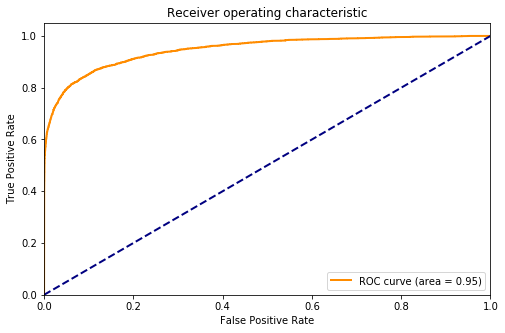

In [34]:

import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import roc_curve, auc


fpr, tpr, threshold = roc_curve(train_df['label'], oof)  ###计算真正率和假正率
roc_auc = auc(fpr, tpr) 

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)  ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [20]:
print(val_aucs, np.mean(val_aucs))
tpr = round(tpr_weight_funtion(train_df['label'], oof)[1], 6)
tpr, round(np.mean(val_aucs), 5)

[0.947178701052137] 0.947178701052137


(0.579144, 0.94718)

In [21]:
########################################
#一定要用全量数据再走一边，不然亏死，走一遍，分数提升1% ！！！
########################################
LOOPROUND = 2000
clf = LGBMClassifier(
    boosting_type = 'goss',
    #g learning_rate=0.03,
    learning_rate=0.05,
    n_estimators=LOOPROUND,
    max_depth = 2,
    random_state=1023,
    subsample_for_bin=20000,
    #metric='binary_error',
    is_unbalance=True,
    reg_alpha=0.005,
    reg_lambda=0.005,
    #bagging_freq = 20,
    #bagging_fraction = 0.8,
    feature_fraction = 0.8,
    min_data_in_leaf=10,
    #min_child_weight= 10,
    #min_split_gain = 0.1,
)

# 利用 call-back 函数，动态设置树深度，叶子节点数量以及学习率
reset_parameters = {
    'max_depth' : [ 2+(i//3) if 2+(i//3) <101 else 101  for i in range(LOOPROUND)  ],
        'num_leaves' : [ 2+(i//3) if 2+(i//3) <201 else 201 for i in range(LOOPROUND) ],
    'learning_rate' : [ 0.03 - (i//100)*0.005 if 0.03 - (i//100)*0.005>0.005 else 0.01 for i in range(LOOPROUND) ],
}

clf.fit(
    train_df[cols],train_df['label'],
            categorical_feature=list(set(cate_cols).intersection(cols)),
            eval_metric=tpr_weight_funtion,
            verbose=200,
            callbacks = [reset_parameter(**reset_parameters)]
        )
test_df['prob'] += clf.predict_proba(test_df[cols])[:, 1]

In [22]:
# 输出结果到提交
submit['id'] = test_df['id']
submit['label'] = test_df['prob']
submit = pd.merge(test,submit,on='id',how='left')[['id','label']]
submit['label'] = submit['label'].apply(lambda x: 0 if pd.isnull(x) else x)

submit.to_csv('../sub/submission{}_{}.csv'.format(tpr, round(np.mean(val_aucs), 6)), index = False)
submit.shape


(15000, 2)

In [23]:
#指标重要性分析
dImp = pd.DataFrame({
        'column': cols,
        'importance': [sum(i)/len(i) for i in np.array([ i.feature_importances_ for i in modellist ]).transpose()] ,
    }).sort_values(by='importance',ascending=False).reset_index().reset_index()
print(dImp[dImp['importance']<100]['column'].values.tolist())

['GRYJCE_woe_in_GJJRATE_prop', 'GJSIGN_in_DKFFE_woe_prop', 'DKFFE_woe_in_GRJCJS_woe_prop', 'GJJRATE_in_DKFFE_woe_prop', 'DKFFE_woe_in_GJJRATE_prop', 'WITHSIGN_NOTE_in_TOP_USER_prop', 'DWSSHY_GRZHZT_count', 'TOP_USER_in_WITHSIGN_NOTE_prop', 'XINGBIE_in_WITHSIGN_prop', 'DKYE_woe_in_WITHSIGN_NOTE_prop', 'GRYJCE_woe_TOP_USER_count', 'DKYE_woe_in_XINGBIE_prop', 'TOP_USER_in_XINGBIE_prop', 'GRYJCE_woe_in_GRZHSNJZYE_woe_prop', 'GJJRATE_in_DKYE_woe_prop', 'DKYE_woe_WITHSIGN_count', 'XINGBIE_GRZHDNGJYE_woe_count', 'DKFFE_woe_in_GRYJCE_woe_prop', 'GRJCJS_woe_in_GRZHYE_woe_prop', 'GRZHYE_woe_in_WITHSIGN_prop', 'GRZHDNGJYE_woe_in_GRZHYE_woe_prop', 'GRZHDNGJYE_woe_GJJRATE_count', 'GRZHSNJZYE_woe_in_GJSIGN_prop', 'DKYE_woe_GJSIGN_count', 'DKFFE_woe_in_WITHSIGN_prop', 'GRYJCE_woe_GJJRATE_count', 'GRYJCE_woe_WITHSIGN_count', 'GRJCJS_woe_GJJRATE_count', 'GRJCJS_woe_GRZHDNGJYE_woe_count', 'TOP_USER_in_GRJCJS_woe_prop', 'GRJCJS_woe_GRZHYE_woe_count', 'WITHSIGN_in_DKYE_woe_prop', 'XINGBIE_in_GRYJCE_woe_pr

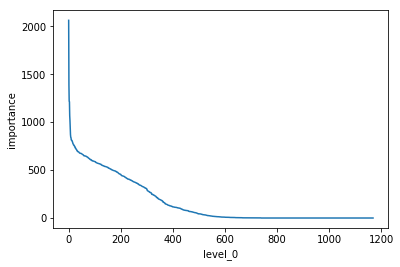

In [24]:
sns.lineplot(x='level_0',y='importance',data=dImp)

In [27]:
dImp.head(20)

,level_0,index,column,importance
0,0,1090,numsOf_GRJCJS_GRYJCE_div,2064.0
1,1,23,DWJJLX_in_DWSSHY_prop,1390.0
2,2,0,CSNY,1219.0
3,3,1124,numsOf_GRZHDNGJYE_YEARPURINCM_div,1214.0
4,4,1,DWSSHY,1069.0
5,5,24,DWSSHY_in_DWJJLX_prop,1017.0
6,6,22,DWJJLX_DWSSHY_count,924.0
7,7,1089,numsOf_GRJCJS_GRZHDNGJYE_div,870.0
8,8,951,GRJCJS_USAGE_RATE_std,843.0
9,9,1050,USAGE_RATE_USAGE_AMOUNT_sum,838.0


In [29]:
modellist[0]

LGBMClassifier(boosting_type='goss', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.8, is_unbalance=True, learning_rate=0.05,
        max_depth=2, min_child_samples=20, min_child_weight=0.001,
        min_data_in_leaf=10, min_split_gain=0.0, n_estimators=4000,
        n_jobs=-1, num_leaves=31, objective=None, random_state=1023,
        reg_alpha=0.008, reg_lambda=0.003, silent=True, subsample=1.0,
        subsample_for_bin=20000, subsample_freq=1, tree='voting')